In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as ks
from numpy import hstack
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [143]:
from numpy import load
# load array
X1 = load('Train1.npy')
X1 = np.transpose(X1, [0,2,1])
X2 = load('Train2.npy')
y = load('Train_targets.npy')

In [167]:
def ModelPerformance(yp, yt):
    G1Tot = 0
    G1Correct = 0
    G2Tot = 0
    G2Correct = 0
    G3Tot = 0
    G3Correct = 0
    G4Tot = 0
    G4Correct = 0
    G5Tot = 0
    G5Correct = 0
    G6Tot = 0
    G6Correct = 0
    
    for i in range(len(yp)):
        if yt[i] <= 12:
            G1Tot += 1
            if yp[i] <= 12:
                G1Correct +=1
        elif yt[i] <= 35:
            G2Tot += 1
            if yp[i] > 12 and yp[i] <= 35:
                G2Correct += 1
        elif yt[i] <= 55:
            G3Tot += 1
            if yp[i] > 35 and yp[i] <= 55:
                G3Correct += 1
        elif yt[i] <= 150:
            G4Tot += 1
            if yp[i] > 55 and yp[i] <= 150:
                G4Correct += 1
        elif yt[i] <= 250:
            G5Tot += 1
            if yp[i] > 150 and yp[i] <= 250:
                G5Correct += 1
        elif yt[i] >250:
            G6Tot += 1
            if yp[i] > 250:
                G6Correct += 1
                
    MSE   = np.mean((yp-yt)**2)
    RMSE  = (MSE)**0.5
    MAPE  = np.mean(np.abs((yt-yp)/(yt)))
    OBAR  = np.mean(yt)
    IA    = 1 - np.sum((yp-yt)**2)/np.sum((np.abs(yp-OBAR) + np.abs(yt-OBAR))**2)
    G1acc = G1Correct/G1Tot * 100
    G2acc = G2Correct/G2Tot * 100
    G3acc = G3Correct/G3Tot * 100
    G4acc = G4Correct/G4Tot * 100
    G5acc = G5Correct/G5Tot * 100
    G6acc = G6Correct/G6Tot * 100
    Wacc  = ((G1acc*G1Correct)+(G2acc*G2Correct)+(G3acc*G3Correct)+(G4acc*G4Correct)+(G5acc*G5Correct)+(G6acc*G6Correct))/(len(yp))
    
    return [G1acc, G2acc, G3acc, G4acc, G5acc, G6acc, Wacc]



def build_LSTM(act, dpt, X1, X2):
    in1 = Input(shape=(X1.shape[-2:]))
    LSTMx = LSTM(units = 150,  dropout = dpt)(in1)

    in2 = Input(shape=(X2.shape[1]))
    ffnnx = Dense(50, activation = 'sigmoid')(in2)

    mergex = concatenate([LSTMx,ffnnx])
    densex = Dense(30, activation=act)(mergex)
    outputx = Dense(1)(densex)
    modelX = Model(inputs=[in1, in2], outputs=outputx)
    modelX.compile(optimizer='adam', loss='mse', metrics = ['MeanAbsolutePercentageError', 'RootMeanSquaredError'])
    return modelX


print('LSTM MODEL')
# Optimise:
act = 'swish'
dpt = 0.1

model_LSTM = build_LSTM('swish',dpt,X1,X2)
model_LSTM.summary()

LSTM MODEL
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 6, 121)]     0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 41)]         0                                            
__________________________________________________________________________________________________
lstm_36 (LSTM)                  (None, 150)          163200      input_37[0][0]                   
__________________________________________________________________________________________________
dense_75 (Dense)                (None, 50)           2100        input_38[0][0]                   
________________________________________________________________________________

In [169]:
# OPTIMISING DROPOUT RATE

In [172]:
# Baseline LSTM
train_idx = 10000 # 80% of data to
EPOCHS = 1000
BATCH = 256 
# early_stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=30,restore_best_weights = True, 
#                                             min_delta = 5, verbose=2)
early_stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=30,restore_best_weights = True, 
                                             verbose=2, min_delta = 5)
act = 'swish'


SimCount = 10
SimSaver = np.zeros((3,SimCount, 9)) # RMSE, MAPE, Class 1%, Class 2%, Class 3%, Class 4%, Class 5%, Class 6%, Weighted % - 9 columns

DropoutVals = [0.05,0.1,0.2]



for j in range(len(DropoutVals)):
    dpt = DropoutVals[j]
    for i in range(SimCount):
        # RANDOMISING DATA
        ###############################################################
        randind = np.arange(len(y))
        np.random.shuffle(randind)
        
        tempX1 = X1[randind]
        tempX2 = X2[randind]
        tempy1 = y[randind]

        # Training Data
        x1 = tempX1[0:train_idx]
        x2 = tempX2[0:train_idx]
        y1 = tempy1[0:train_idx]

        # Testing Data
        testX1 = tempX1[train_idx::]
        testX2 = tempX2[train_idx::]
        testy = tempy1[train_idx::]
        ################################################################

        # Create Model
        model_LSTM = build_LSTM(act, dpt, X1, X2)

        # Fit Model
        mLSTM_hist = model_LSTM.fit([x1,x2], y1, epochs=EPOCHS,validation_split=0.15, verbose=2, callbacks = [early_stop], batch_size=BATCH, shuffle = True)
#         mLSTM_hist = model_LSTM.fit([x2], y1, epochs=EPOCHS,validation_split=0.15, verbose=2, callbacks = [early_stop], batch_size=BATCH, shuffle = True)

        # Evaluate Model
        MSE_save, RMSE_save, MAPE_save =  model_LSTM.evaluate([testX1,testX2],testy)
#         MSE_save, RMSE_save, MAPE_save =  model_LSTM.evaluate([testX2],testy)
        y_predict_LSTM = model_LSTM.predict([testX1,testX2])
#         y_predict_LSTM = model_LSTM.predict([testX2])

        # Append All Relevant Data To Matrix for Post Processing
        results = ModelPerformance(y_predict_LSTM, testy)

        SimSaver[j,i,0] = RMSE_save
        SimSaver[j,i,1] = MAPE_save
        SimSaver[j,i,2] = results[0]
        SimSaver[j,i,3] = results[1]
        SimSaver[j,i,4] = results[2]
        SimSaver[j,i,5] = results[3]
        SimSaver[j,i,6] = results[4]
        SimSaver[j,i,7] = results[5]
        SimSaver[j,i,8] = results[6]



Epoch 1/1000
34/34 - 2s - loss: 3553.7019 - mean_absolute_percentage_error: 66.7699 - root_mean_squared_error: 59.7991 - val_loss: 2276.2839 - val_mean_absolute_percentage_error: 45.5225 - val_root_mean_squared_error: 47.6535
Epoch 2/1000
34/34 - 1s - loss: 1894.8876 - mean_absolute_percentage_error: 61.0188 - root_mean_squared_error: 43.3070 - val_loss: 1799.5039 - val_mean_absolute_percentage_error: 70.3313 - val_root_mean_squared_error: 42.3808
Epoch 3/1000
34/34 - 1s - loss: 1770.8413 - mean_absolute_percentage_error: 74.2109 - root_mean_squared_error: 42.0883 - val_loss: 1799.2598 - val_mean_absolute_percentage_error: 67.8151 - val_root_mean_squared_error: 42.3764
Epoch 4/1000
34/34 - 1s - loss: 1798.7158 - mean_absolute_percentage_error: 71.6803 - root_mean_squared_error: 42.0450 - val_loss: 1798.2069 - val_mean_absolute_percentage_error: 67.7862 - val_root_mean_squared_error: 42.3640
Epoch 5/1000
34/34 - 1s - loss: 1759.9600 - mean_absolute_percentage_error: 73.1523 - root_mean_

Epoch 38/1000
34/34 - 1s - loss: 1399.2729 - mean_absolute_percentage_error: 59.1191 - root_mean_squared_error: 37.4593 - val_loss: 1475.9003 - val_mean_absolute_percentage_error: 57.9595 - val_root_mean_squared_error: 38.3775
Epoch 39/1000
34/34 - 1s - loss: 1404.3000 - mean_absolute_percentage_error: 59.2008 - root_mean_squared_error: 37.3099 - val_loss: 1468.7196 - val_mean_absolute_percentage_error: 60.3744 - val_root_mean_squared_error: 38.2866
Epoch 40/1000
34/34 - 1s - loss: 1401.8615 - mean_absolute_percentage_error: 59.4541 - root_mean_squared_error: 37.2839 - val_loss: 1466.0365 - val_mean_absolute_percentage_error: 61.8733 - val_root_mean_squared_error: 38.2530
Epoch 41/1000
34/34 - 1s - loss: 1364.0382 - mean_absolute_percentage_error: 59.1148 - root_mean_squared_error: 37.1049 - val_loss: 1462.2325 - val_mean_absolute_percentage_error: 57.8302 - val_root_mean_squared_error: 38.1991
Epoch 42/1000
34/34 - 1s - loss: 1381.0513 - mean_absolute_percentage_error: 58.5682 - root_

Epoch 75/1000
34/34 - 1s - loss: 1184.2168 - mean_absolute_percentage_error: 51.8334 - root_mean_squared_error: 33.5378 - val_loss: 1362.5194 - val_mean_absolute_percentage_error: 68.2229 - val_root_mean_squared_error: 36.8735
Epoch 76/1000
34/34 - 1s - loss: 1146.1954 - mean_absolute_percentage_error: 52.6385 - root_mean_squared_error: 33.7850 - val_loss: 1253.2802 - val_mean_absolute_percentage_error: 56.7801 - val_root_mean_squared_error: 35.3581
Epoch 77/1000
34/34 - 1s - loss: 1087.0698 - mean_absolute_percentage_error: 51.2815 - root_mean_squared_error: 33.1840 - val_loss: 1235.1559 - val_mean_absolute_percentage_error: 57.3179 - val_root_mean_squared_error: 35.0948
Epoch 78/1000
34/34 - 1s - loss: 1098.0681 - mean_absolute_percentage_error: 51.3067 - root_mean_squared_error: 32.8238 - val_loss: 1267.7836 - val_mean_absolute_percentage_error: 60.2562 - val_root_mean_squared_error: 35.5514
Epoch 79/1000
34/34 - 1s - loss: 1061.7100 - mean_absolute_percentage_error: 51.0660 - root_

Epoch 112/1000
34/34 - 1s - loss: 702.0562 - mean_absolute_percentage_error: 42.1230 - root_mean_squared_error: 26.5529 - val_loss: 1118.1678 - val_mean_absolute_percentage_error: 48.9844 - val_root_mean_squared_error: 33.3858
Epoch 113/1000
34/34 - 1s - loss: 690.6161 - mean_absolute_percentage_error: 42.3542 - root_mean_squared_error: 26.2331 - val_loss: 1136.2208 - val_mean_absolute_percentage_error: 49.5441 - val_root_mean_squared_error: 33.6501
Epoch 114/1000
34/34 - 1s - loss: 709.3565 - mean_absolute_percentage_error: 42.0687 - root_mean_squared_error: 26.1654 - val_loss: 1096.3336 - val_mean_absolute_percentage_error: 43.6741 - val_root_mean_squared_error: 33.0229
Epoch 115/1000
34/34 - 1s - loss: 682.9340 - mean_absolute_percentage_error: 42.1774 - root_mean_squared_error: 26.1439 - val_loss: 1117.3331 - val_mean_absolute_percentage_error: 43.8432 - val_root_mean_squared_error: 33.3900
Epoch 116/1000
34/34 - 1s - loss: 660.9573 - mean_absolute_percentage_error: 41.1931 - root_

Epoch 149/1000
34/34 - 1s - loss: 484.4619 - mean_absolute_percentage_error: 36.0946 - root_mean_squared_error: 21.8126 - val_loss: 1095.7416 - val_mean_absolute_percentage_error: 42.9043 - val_root_mean_squared_error: 33.0866
Epoch 150/1000
34/34 - 1s - loss: 484.3214 - mean_absolute_percentage_error: 36.7630 - root_mean_squared_error: 22.1153 - val_loss: 1108.3390 - val_mean_absolute_percentage_error: 39.1549 - val_root_mean_squared_error: 33.2798
Epoch 151/1000
34/34 - 1s - loss: 498.6342 - mean_absolute_percentage_error: 36.4099 - root_mean_squared_error: 22.1940 - val_loss: 1131.0839 - val_mean_absolute_percentage_error: 41.6264 - val_root_mean_squared_error: 33.6309
Epoch 152/1000
34/34 - 1s - loss: 467.8038 - mean_absolute_percentage_error: 36.2818 - root_mean_squared_error: 21.6792 - val_loss: 1068.5240 - val_mean_absolute_percentage_error: 45.1643 - val_root_mean_squared_error: 32.6729
Epoch 153/1000
34/34 - 1s - loss: 476.1379 - mean_absolute_percentage_error: 36.3205 - root_

Epoch 186/1000
34/34 - 1s - loss: 372.6954 - mean_absolute_percentage_error: 32.4515 - root_mean_squared_error: 19.3252 - val_loss: 1060.5270 - val_mean_absolute_percentage_error: 42.2578 - val_root_mean_squared_error: 32.5812
Epoch 187/1000
34/34 - 1s - loss: 351.5416 - mean_absolute_percentage_error: 31.4958 - root_mean_squared_error: 18.7887 - val_loss: 1070.0033 - val_mean_absolute_percentage_error: 43.7650 - val_root_mean_squared_error: 32.7209
Epoch 188/1000
34/34 - 1s - loss: 344.0212 - mean_absolute_percentage_error: 31.7756 - root_mean_squared_error: 18.6476 - val_loss: 1056.4081 - val_mean_absolute_percentage_error: 40.0941 - val_root_mean_squared_error: 32.4705
Epoch 189/1000
34/34 - 1s - loss: 340.7354 - mean_absolute_percentage_error: 31.7182 - root_mean_squared_error: 18.5306 - val_loss: 1044.2094 - val_mean_absolute_percentage_error: 40.4890 - val_root_mean_squared_error: 32.2656
Epoch 190/1000
34/34 - 1s - loss: 340.5316 - mean_absolute_percentage_error: 30.7133 - root_

Epoch 30/1000
34/34 - 1s - loss: 1527.6146 - mean_absolute_percentage_error: 62.2528 - root_mean_squared_error: 39.1752 - val_loss: 1227.1122 - val_mean_absolute_percentage_error: 54.5472 - val_root_mean_squared_error: 35.0093
Epoch 31/1000
34/34 - 1s - loss: 1536.4672 - mean_absolute_percentage_error: 61.3936 - root_mean_squared_error: 39.1220 - val_loss: 1265.5524 - val_mean_absolute_percentage_error: 66.3236 - val_root_mean_squared_error: 35.5763
Epoch 32/1000
34/34 - 1s - loss: 1533.9958 - mean_absolute_percentage_error: 63.0791 - root_mean_squared_error: 39.2984 - val_loss: 1223.7250 - val_mean_absolute_percentage_error: 52.3486 - val_root_mean_squared_error: 34.9575
Epoch 33/1000
34/34 - 1s - loss: 1512.1934 - mean_absolute_percentage_error: 60.2627 - root_mean_squared_error: 38.9455 - val_loss: 1216.4167 - val_mean_absolute_percentage_error: 59.5134 - val_root_mean_squared_error: 34.8688
Epoch 34/1000
34/34 - 1s - loss: 1547.2881 - mean_absolute_percentage_error: 61.2308 - root_

Epoch 67/1000
34/34 - 1s - loss: 1050.4650 - mean_absolute_percentage_error: 49.1176 - root_mean_squared_error: 32.2473 - val_loss: 989.9670 - val_mean_absolute_percentage_error: 49.1106 - val_root_mean_squared_error: 31.4910
Epoch 68/1000
34/34 - 1s - loss: 1008.0969 - mean_absolute_percentage_error: 49.4218 - root_mean_squared_error: 31.7983 - val_loss: 1009.1529 - val_mean_absolute_percentage_error: 40.4559 - val_root_mean_squared_error: 31.7627
Epoch 69/1000
34/34 - 1s - loss: 1037.7905 - mean_absolute_percentage_error: 49.3981 - root_mean_squared_error: 32.4131 - val_loss: 957.7592 - val_mean_absolute_percentage_error: 42.0758 - val_root_mean_squared_error: 30.9684
Epoch 70/1000
34/34 - 1s - loss: 1012.0493 - mean_absolute_percentage_error: 48.8112 - root_mean_squared_error: 31.9904 - val_loss: 943.4389 - val_mean_absolute_percentage_error: 47.5331 - val_root_mean_squared_error: 30.7426
Epoch 71/1000
34/34 - 1s - loss: 991.9251 - mean_absolute_percentage_error: 48.2409 - root_mean

Epoch 104/1000
34/34 - 1s - loss: 805.3510 - mean_absolute_percentage_error: 44.1215 - root_mean_squared_error: 28.2715 - val_loss: 917.7703 - val_mean_absolute_percentage_error: 44.7309 - val_root_mean_squared_error: 30.3250
Epoch 105/1000
34/34 - 1s - loss: 773.1120 - mean_absolute_percentage_error: 44.4356 - root_mean_squared_error: 27.8894 - val_loss: 907.6776 - val_mean_absolute_percentage_error: 42.9447 - val_root_mean_squared_error: 30.1625
Epoch 106/1000
34/34 - 1s - loss: 826.7875 - mean_absolute_percentage_error: 44.2012 - root_mean_squared_error: 28.6325 - val_loss: 923.2938 - val_mean_absolute_percentage_error: 39.7369 - val_root_mean_squared_error: 30.4195
Epoch 107/1000
34/34 - 1s - loss: 755.4745 - mean_absolute_percentage_error: 43.2824 - root_mean_squared_error: 27.5197 - val_loss: 900.9121 - val_mean_absolute_percentage_error: 40.0738 - val_root_mean_squared_error: 30.0458
Epoch 108/1000
34/34 - 1s - loss: 757.2846 - mean_absolute_percentage_error: 43.0939 - root_mean

Epoch 141/1000
34/34 - 1s - loss: 588.6454 - mean_absolute_percentage_error: 39.0404 - root_mean_squared_error: 24.2089 - val_loss: 877.2579 - val_mean_absolute_percentage_error: 38.1589 - val_root_mean_squared_error: 29.6726
Epoch 142/1000
34/34 - 1s - loss: 585.9275 - mean_absolute_percentage_error: 39.0442 - root_mean_squared_error: 24.2461 - val_loss: 879.1374 - val_mean_absolute_percentage_error: 41.8991 - val_root_mean_squared_error: 29.7189
Epoch 143/1000
34/34 - 1s - loss: 579.8364 - mean_absolute_percentage_error: 38.4847 - root_mean_squared_error: 23.9038 - val_loss: 865.0503 - val_mean_absolute_percentage_error: 41.0505 - val_root_mean_squared_error: 29.4871
Epoch 144/1000
34/34 - 1s - loss: 626.1217 - mean_absolute_percentage_error: 39.4502 - root_mean_squared_error: 25.0980 - val_loss: 929.7500 - val_mean_absolute_percentage_error: 50.3912 - val_root_mean_squared_error: 30.5515
Epoch 145/1000
34/34 - 1s - loss: 593.2047 - mean_absolute_percentage_error: 39.1592 - root_mean

Epoch 178/1000
34/34 - 1s - loss: 451.8823 - mean_absolute_percentage_error: 33.6965 - root_mean_squared_error: 20.8133 - val_loss: 845.4865 - val_mean_absolute_percentage_error: 41.2048 - val_root_mean_squared_error: 29.1482
Epoch 179/1000
34/34 - 1s - loss: 430.5009 - mean_absolute_percentage_error: 33.7018 - root_mean_squared_error: 20.8227 - val_loss: 862.8737 - val_mean_absolute_percentage_error: 41.3525 - val_root_mean_squared_error: 29.4424
Epoch 180/1000
34/34 - 1s - loss: 427.3795 - mean_absolute_percentage_error: 33.4298 - root_mean_squared_error: 20.8057 - val_loss: 848.9758 - val_mean_absolute_percentage_error: 38.9528 - val_root_mean_squared_error: 29.2080
Epoch 181/1000
34/34 - 1s - loss: 424.1179 - mean_absolute_percentage_error: 33.5194 - root_mean_squared_error: 20.6690 - val_loss: 853.5320 - val_mean_absolute_percentage_error: 38.0589 - val_root_mean_squared_error: 29.2739
Epoch 182/1000
34/34 - 1s - loss: 437.4062 - mean_absolute_percentage_error: 33.3902 - root_mean

Epoch 215/1000
34/34 - 1s - loss: 331.9633 - mean_absolute_percentage_error: 29.5494 - root_mean_squared_error: 18.2719 - val_loss: 788.7764 - val_mean_absolute_percentage_error: 37.4647 - val_root_mean_squared_error: 28.1357
Epoch 216/1000
34/34 - 1s - loss: 335.8676 - mean_absolute_percentage_error: 29.4717 - root_mean_squared_error: 18.2428 - val_loss: 799.9367 - val_mean_absolute_percentage_error: 39.2073 - val_root_mean_squared_error: 28.3352
Epoch 217/1000
34/34 - 1s - loss: 323.2791 - mean_absolute_percentage_error: 28.9952 - root_mean_squared_error: 18.0497 - val_loss: 792.3192 - val_mean_absolute_percentage_error: 37.6859 - val_root_mean_squared_error: 28.2050
Epoch 218/1000
34/34 - 1s - loss: 320.8058 - mean_absolute_percentage_error: 28.8357 - root_mean_squared_error: 18.0066 - val_loss: 779.8718 - val_mean_absolute_percentage_error: 39.3499 - val_root_mean_squared_error: 27.9774
Epoch 219/1000
34/34 - 1s - loss: 306.4309 - mean_absolute_percentage_error: 28.7115 - root_mean

Epoch 252/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 277.5247 - mean_absolute_percentage_error: 26.3247 - root_mean_squared_error: 16.6984 - val_loss: 761.2922 - val_mean_absolute_percentage_error: 39.1064 - val_root_mean_squared_error: 27.6641
Epoch 00252: early stopping
174/174 [==============================] - 1s 4ms/step - loss: 958.0432 - mean_absolute_percentage_error: 41.6256 - root_mean_squared_error: 31.0184
Epoch 1/1000
34/34 - 2s - loss: 3478.1125 - mean_absolute_percentage_error: 65.3036 - root_mean_squared_error: 58.7636 - val_loss: 2324.1912 - val_mean_absolute_percentage_error: 47.6619 - val_root_mean_squared_error: 48.2408
Epoch 2/1000
34/34 - 1s - loss: 1878.1616 - mean_absolute_percentage_error: 64.5874 - root_mean_squared_error: 42.9238 - val_loss: 1994.2028 - val_mean_absolute_percentage_error: 77.3388 - val_root_mean_squared_error: 44.6825
Epoch 3/1000
34/34 - 1s - loss: 1775.0043 - mean_absolute_percentage_error: 75.7925 - roo

Epoch 36/1000
34/34 - 1s - loss: 1440.5154 - mean_absolute_percentage_error: 59.6506 - root_mean_squared_error: 37.3861 - val_loss: 1548.9116 - val_mean_absolute_percentage_error: 62.0578 - val_root_mean_squared_error: 39.3635
Epoch 37/1000
34/34 - 1s - loss: 1380.1891 - mean_absolute_percentage_error: 59.9885 - root_mean_squared_error: 37.1962 - val_loss: 1543.0043 - val_mean_absolute_percentage_error: 54.7515 - val_root_mean_squared_error: 39.2909
Epoch 38/1000
34/34 - 1s - loss: 1392.6188 - mean_absolute_percentage_error: 58.6868 - root_mean_squared_error: 37.1754 - val_loss: 1541.3705 - val_mean_absolute_percentage_error: 64.5619 - val_root_mean_squared_error: 39.2650
Epoch 39/1000
34/34 - 1s - loss: 1361.0049 - mean_absolute_percentage_error: 59.4658 - root_mean_squared_error: 37.0357 - val_loss: 1531.2900 - val_mean_absolute_percentage_error: 65.0605 - val_root_mean_squared_error: 39.1397
Epoch 40/1000
34/34 - 1s - loss: 1379.5901 - mean_absolute_percentage_error: 58.2687 - root_

Epoch 73/1000
34/34 - 1s - loss: 1125.6279 - mean_absolute_percentage_error: 51.4117 - root_mean_squared_error: 33.4933 - val_loss: 1270.3280 - val_mean_absolute_percentage_error: 57.6582 - val_root_mean_squared_error: 35.6562
Epoch 74/1000
34/34 - 1s - loss: 1125.9967 - mean_absolute_percentage_error: 51.9250 - root_mean_squared_error: 33.3596 - val_loss: 1236.4515 - val_mean_absolute_percentage_error: 49.8085 - val_root_mean_squared_error: 35.1719
Epoch 75/1000
34/34 - 1s - loss: 1108.9072 - mean_absolute_percentage_error: 51.4836 - root_mean_squared_error: 33.3481 - val_loss: 1280.0657 - val_mean_absolute_percentage_error: 44.9378 - val_root_mean_squared_error: 35.7916
Epoch 76/1000
34/34 - 1s - loss: 1129.1473 - mean_absolute_percentage_error: 51.1305 - root_mean_squared_error: 33.3479 - val_loss: 1217.1000 - val_mean_absolute_percentage_error: 51.1403 - val_root_mean_squared_error: 34.8965
Epoch 77/1000
34/34 - 1s - loss: 1092.6445 - mean_absolute_percentage_error: 50.7089 - root_

Epoch 110/1000
34/34 - 1s - loss: 908.5355 - mean_absolute_percentage_error: 47.7065 - root_mean_squared_error: 30.2820 - val_loss: 1138.1296 - val_mean_absolute_percentage_error: 48.9704 - val_root_mean_squared_error: 33.7404
Epoch 111/1000
34/34 - 1s - loss: 908.9919 - mean_absolute_percentage_error: 46.4966 - root_mean_squared_error: 30.0529 - val_loss: 1140.9677 - val_mean_absolute_percentage_error: 53.7372 - val_root_mean_squared_error: 33.7806
Epoch 112/1000
34/34 - 1s - loss: 890.2811 - mean_absolute_percentage_error: 47.2284 - root_mean_squared_error: 29.9284 - val_loss: 1154.0504 - val_mean_absolute_percentage_error: 43.5041 - val_root_mean_squared_error: 33.9724
Epoch 113/1000
34/34 - 1s - loss: 905.1033 - mean_absolute_percentage_error: 46.6850 - root_mean_squared_error: 29.9780 - val_loss: 1196.9142 - val_mean_absolute_percentage_error: 48.9040 - val_root_mean_squared_error: 34.6258
Epoch 114/1000
34/34 - 1s - loss: 868.2319 - mean_absolute_percentage_error: 46.5271 - root_

Epoch 147/1000
34/34 - 1s - loss: 718.7573 - mean_absolute_percentage_error: 43.7927 - root_mean_squared_error: 26.8430 - val_loss: 1121.8846 - val_mean_absolute_percentage_error: 50.1784 - val_root_mean_squared_error: 33.4938
Epoch 148/1000
34/34 - 1s - loss: 745.9388 - mean_absolute_percentage_error: 43.8937 - root_mean_squared_error: 27.1751 - val_loss: 1109.8925 - val_mean_absolute_percentage_error: 49.9268 - val_root_mean_squared_error: 33.3258
Epoch 149/1000
34/34 - 1s - loss: 701.2858 - mean_absolute_percentage_error: 43.1090 - root_mean_squared_error: 26.5517 - val_loss: 1154.2867 - val_mean_absolute_percentage_error: 42.7593 - val_root_mean_squared_error: 33.9819
Epoch 150/1000
34/34 - 1s - loss: 716.9304 - mean_absolute_percentage_error: 44.0780 - root_mean_squared_error: 26.8719 - val_loss: 1116.7013 - val_mean_absolute_percentage_error: 44.8758 - val_root_mean_squared_error: 33.4109
Epoch 151/1000
34/34 - 1s - loss: 712.2828 - mean_absolute_percentage_error: 42.8176 - root_

Epoch 00182: early stopping
174/174 [==============================] - 1s 4ms/step - loss: 1136.6958 - mean_absolute_percentage_error: 44.4277 - root_mean_squared_error: 33.2317
Epoch 1/1000
34/34 - 2s - loss: 3685.6877 - mean_absolute_percentage_error: 67.8552 - root_mean_squared_error: 61.0932 - val_loss: 2386.6072 - val_mean_absolute_percentage_error: 47.2632 - val_root_mean_squared_error: 48.9363
Epoch 2/1000
34/34 - 1s - loss: 1959.6385 - mean_absolute_percentage_error: 62.0644 - root_mean_squared_error: 44.1441 - val_loss: 1920.2295 - val_mean_absolute_percentage_error: 77.7040 - val_root_mean_squared_error: 43.8950
Epoch 3/1000
34/34 - 1s - loss: 1835.6127 - mean_absolute_percentage_error: 74.0081 - root_mean_squared_error: 42.9758 - val_loss: 1916.3722 - val_mean_absolute_percentage_error: 73.3881 - val_root_mean_squared_error: 43.8529
Epoch 4/1000
34/34 - 1s - loss: 1825.3134 - mean_absolute_percentage_error: 72.2149 - root_mean_squared_error: 42.9390 - val_loss: 1915.5990 - v

Epoch 37/1000
34/34 - 1s - loss: 1488.1042 - mean_absolute_percentage_error: 61.0029 - root_mean_squared_error: 38.6251 - val_loss: 1523.4071 - val_mean_absolute_percentage_error: 68.5998 - val_root_mean_squared_error: 39.1096
Epoch 38/1000
34/34 - 1s - loss: 1454.9314 - mean_absolute_percentage_error: 59.9910 - root_mean_squared_error: 38.3376 - val_loss: 1501.8193 - val_mean_absolute_percentage_error: 63.2945 - val_root_mean_squared_error: 38.8384
Epoch 39/1000
34/34 - 1s - loss: 1465.1714 - mean_absolute_percentage_error: 60.0873 - root_mean_squared_error: 38.2128 - val_loss: 1500.2314 - val_mean_absolute_percentage_error: 58.6993 - val_root_mean_squared_error: 38.8219
Epoch 40/1000
34/34 - 1s - loss: 1458.0856 - mean_absolute_percentage_error: 59.5087 - root_mean_squared_error: 38.1518 - val_loss: 1487.3698 - val_mean_absolute_percentage_error: 64.7829 - val_root_mean_squared_error: 38.6517
Epoch 41/1000
34/34 - 1s - loss: 1431.3820 - mean_absolute_percentage_error: 60.0234 - root_

Epoch 74/1000
34/34 - 1s - loss: 1039.4398 - mean_absolute_percentage_error: 49.6411 - root_mean_squared_error: 32.3833 - val_loss: 1147.2081 - val_mean_absolute_percentage_error: 47.7833 - val_root_mean_squared_error: 33.9686
Epoch 75/1000
34/34 - 1s - loss: 1040.0546 - mean_absolute_percentage_error: 48.9804 - root_mean_squared_error: 32.3792 - val_loss: 1188.6935 - val_mean_absolute_percentage_error: 64.0598 - val_root_mean_squared_error: 34.5398
Epoch 76/1000
34/34 - 1s - loss: 1029.7075 - mean_absolute_percentage_error: 49.3626 - root_mean_squared_error: 32.1764 - val_loss: 1138.0479 - val_mean_absolute_percentage_error: 49.2941 - val_root_mean_squared_error: 33.8265
Epoch 77/1000
34/34 - 1s - loss: 1006.7429 - mean_absolute_percentage_error: 48.5658 - root_mean_squared_error: 31.8840 - val_loss: 1128.7411 - val_mean_absolute_percentage_error: 47.5898 - val_root_mean_squared_error: 33.6997
Epoch 78/1000
34/34 - 1s - loss: 1018.0936 - mean_absolute_percentage_error: 48.1524 - root_

Epoch 111/1000
34/34 - 1s - loss: 773.6006 - mean_absolute_percentage_error: 43.4558 - root_mean_squared_error: 27.5322 - val_loss: 1073.3827 - val_mean_absolute_percentage_error: 49.2440 - val_root_mean_squared_error: 32.8460
Epoch 112/1000
34/34 - 1s - loss: 730.5950 - mean_absolute_percentage_error: 43.5063 - root_mean_squared_error: 27.1396 - val_loss: 1097.6290 - val_mean_absolute_percentage_error: 44.5768 - val_root_mean_squared_error: 33.2367
Epoch 113/1000
34/34 - 1s - loss: 728.2617 - mean_absolute_percentage_error: 42.4911 - root_mean_squared_error: 27.0628 - val_loss: 1130.8145 - val_mean_absolute_percentage_error: 53.8416 - val_root_mean_squared_error: 33.6974
Epoch 114/1000
34/34 - 1s - loss: 743.2644 - mean_absolute_percentage_error: 43.1174 - root_mean_squared_error: 27.3735 - val_loss: 1068.6792 - val_mean_absolute_percentage_error: 43.7822 - val_root_mean_squared_error: 32.8144
Epoch 115/1000
34/34 - 1s - loss: 728.5698 - mean_absolute_percentage_error: 42.7510 - root_

Epoch 148/1000
34/34 - 1s - loss: 555.3677 - mean_absolute_percentage_error: 38.0559 - root_mean_squared_error: 23.6653 - val_loss: 1027.9679 - val_mean_absolute_percentage_error: 46.3556 - val_root_mean_squared_error: 32.2059
Epoch 149/1000
34/34 - 1s - loss: 577.5593 - mean_absolute_percentage_error: 38.3623 - root_mean_squared_error: 23.7918 - val_loss: 1040.7472 - val_mean_absolute_percentage_error: 47.0137 - val_root_mean_squared_error: 32.4105
Epoch 150/1000
34/34 - 1s - loss: 560.5280 - mean_absolute_percentage_error: 38.9874 - root_mean_squared_error: 23.7627 - val_loss: 1033.2992 - val_mean_absolute_percentage_error: 48.7199 - val_root_mean_squared_error: 32.2818
Epoch 151/1000
34/34 - 1s - loss: 566.7791 - mean_absolute_percentage_error: 38.9765 - root_mean_squared_error: 23.7346 - val_loss: 1064.7006 - val_mean_absolute_percentage_error: 42.2721 - val_root_mean_squared_error: 32.7783
Epoch 152/1000
34/34 - 1s - loss: 554.8862 - mean_absolute_percentage_error: 38.0249 - root_

Epoch 185/1000
34/34 - 1s - loss: 446.6124 - mean_absolute_percentage_error: 34.9017 - root_mean_squared_error: 21.2916 - val_loss: 1008.5497 - val_mean_absolute_percentage_error: 40.2088 - val_root_mean_squared_error: 31.9106
Epoch 186/1000
34/34 - 1s - loss: 452.9157 - mean_absolute_percentage_error: 35.4504 - root_mean_squared_error: 21.3486 - val_loss: 1014.0446 - val_mean_absolute_percentage_error: 45.3443 - val_root_mean_squared_error: 31.9844
Epoch 187/1000
34/34 - 1s - loss: 461.4718 - mean_absolute_percentage_error: 35.2407 - root_mean_squared_error: 21.2587 - val_loss: 1000.4946 - val_mean_absolute_percentage_error: 46.8270 - val_root_mean_squared_error: 31.7798
Epoch 188/1000
34/34 - 1s - loss: 428.1495 - mean_absolute_percentage_error: 34.5961 - root_mean_squared_error: 20.7508 - val_loss: 1018.3892 - val_mean_absolute_percentage_error: 45.9224 - val_root_mean_squared_error: 32.0474
Epoch 189/1000
34/34 - 1s - loss: 418.5261 - mean_absolute_percentage_error: 34.3020 - root_

Epoch 13/1000
34/34 - 1s - loss: 1738.0782 - mean_absolute_percentage_error: 71.2800 - root_mean_squared_error: 41.7685 - val_loss: 1555.1359 - val_mean_absolute_percentage_error: 65.9017 - val_root_mean_squared_error: 39.4837
Epoch 14/1000
34/34 - 1s - loss: 1722.0170 - mean_absolute_percentage_error: 69.9774 - root_mean_squared_error: 41.6634 - val_loss: 1545.2188 - val_mean_absolute_percentage_error: 70.3707 - val_root_mean_squared_error: 39.3577
Epoch 15/1000
34/34 - 1s - loss: 1706.1750 - mean_absolute_percentage_error: 69.9499 - root_mean_squared_error: 41.5248 - val_loss: 1531.6708 - val_mean_absolute_percentage_error: 65.9306 - val_root_mean_squared_error: 39.1847
Epoch 16/1000
34/34 - 1s - loss: 1701.6584 - mean_absolute_percentage_error: 69.4845 - root_mean_squared_error: 41.3654 - val_loss: 1517.0099 - val_mean_absolute_percentage_error: 66.4388 - val_root_mean_squared_error: 38.9966
Epoch 17/1000
34/34 - 1s - loss: 1692.4484 - mean_absolute_percentage_error: 68.6859 - root_

Epoch 50/1000
34/34 - 1s - loss: 1103.7531 - mean_absolute_percentage_error: 52.9587 - root_mean_squared_error: 33.2536 - val_loss: 1126.4984 - val_mean_absolute_percentage_error: 49.0930 - val_root_mean_squared_error: 33.5707
Epoch 51/1000
34/34 - 1s - loss: 1104.7574 - mean_absolute_percentage_error: 52.4921 - root_mean_squared_error: 33.0657 - val_loss: 1341.1696 - val_mean_absolute_percentage_error: 65.9459 - val_root_mean_squared_error: 36.6167
Epoch 52/1000
34/34 - 1s - loss: 1144.6904 - mean_absolute_percentage_error: 54.4907 - root_mean_squared_error: 33.9578 - val_loss: 1120.9923 - val_mean_absolute_percentage_error: 54.0406 - val_root_mean_squared_error: 33.4900
Epoch 53/1000
34/34 - 1s - loss: 1092.6948 - mean_absolute_percentage_error: 52.2241 - root_mean_squared_error: 32.9661 - val_loss: 1142.5414 - val_mean_absolute_percentage_error: 55.0813 - val_root_mean_squared_error: 33.8059
Epoch 54/1000
34/34 - 1s - loss: 1089.3882 - mean_absolute_percentage_error: 52.0248 - root_

Epoch 87/1000
34/34 - 1s - loss: 877.5226 - mean_absolute_percentage_error: 47.4287 - root_mean_squared_error: 29.5202 - val_loss: 1065.8969 - val_mean_absolute_percentage_error: 46.5260 - val_root_mean_squared_error: 32.6700
Epoch 88/1000
34/34 - 1s - loss: 858.1218 - mean_absolute_percentage_error: 47.2423 - root_mean_squared_error: 29.3527 - val_loss: 1066.8762 - val_mean_absolute_percentage_error: 42.6386 - val_root_mean_squared_error: 32.6790
Epoch 89/1000
34/34 - 1s - loss: 822.7261 - mean_absolute_percentage_error: 45.9651 - root_mean_squared_error: 28.7641 - val_loss: 1055.0472 - val_mean_absolute_percentage_error: 48.7733 - val_root_mean_squared_error: 32.4941
Epoch 90/1000
34/34 - 1s - loss: 819.7495 - mean_absolute_percentage_error: 45.9265 - root_mean_squared_error: 28.5116 - val_loss: 1106.1516 - val_mean_absolute_percentage_error: 53.7895 - val_root_mean_squared_error: 33.2737
Epoch 91/1000
34/34 - 1s - loss: 798.4733 - mean_absolute_percentage_error: 45.7306 - root_mean_

Epoch 124/1000
34/34 - 1s - loss: 635.8537 - mean_absolute_percentage_error: 41.1045 - root_mean_squared_error: 25.2487 - val_loss: 1021.3351 - val_mean_absolute_percentage_error: 45.9689 - val_root_mean_squared_error: 31.9875
Epoch 125/1000
34/34 - 1s - loss: 648.6815 - mean_absolute_percentage_error: 41.0335 - root_mean_squared_error: 25.3999 - val_loss: 1026.6342 - val_mean_absolute_percentage_error: 45.7197 - val_root_mean_squared_error: 32.0693
Epoch 126/1000
34/34 - 1s - loss: 635.8320 - mean_absolute_percentage_error: 41.0288 - root_mean_squared_error: 25.2491 - val_loss: 1081.3383 - val_mean_absolute_percentage_error: 39.4177 - val_root_mean_squared_error: 32.8861
Epoch 127/1000
34/34 - 1s - loss: 624.7465 - mean_absolute_percentage_error: 40.3895 - root_mean_squared_error: 25.1159 - val_loss: 994.0139 - val_mean_absolute_percentage_error: 43.5575 - val_root_mean_squared_error: 31.5619
Epoch 128/1000
34/34 - 1s - loss: 636.4228 - mean_absolute_percentage_error: 41.3305 - root_m

Epoch 161/1000
34/34 - 1s - loss: 540.7679 - mean_absolute_percentage_error: 37.2578 - root_mean_squared_error: 23.0907 - val_loss: 1019.3199 - val_mean_absolute_percentage_error: 47.8840 - val_root_mean_squared_error: 31.9160
Epoch 162/1000
34/34 - 1s - loss: 500.5553 - mean_absolute_percentage_error: 37.0640 - root_mean_squared_error: 22.5022 - val_loss: 1011.0864 - val_mean_absolute_percentage_error: 42.8584 - val_root_mean_squared_error: 31.7964
Epoch 163/1000
34/34 - 1s - loss: 497.1626 - mean_absolute_percentage_error: 36.3259 - root_mean_squared_error: 22.3255 - val_loss: 951.0019 - val_mean_absolute_percentage_error: 44.2832 - val_root_mean_squared_error: 30.8445
Epoch 164/1000
34/34 - 1s - loss: 492.7507 - mean_absolute_percentage_error: 36.5838 - root_mean_squared_error: 22.2260 - val_loss: 963.3364 - val_mean_absolute_percentage_error: 42.7112 - val_root_mean_squared_error: 31.0515
Epoch 165/1000
34/34 - 1s - loss: 497.7866 - mean_absolute_percentage_error: 36.5412 - root_me

Epoch 198/1000
34/34 - 1s - loss: 425.8130 - mean_absolute_percentage_error: 34.2243 - root_mean_squared_error: 20.6068 - val_loss: 959.0054 - val_mean_absolute_percentage_error: 40.0687 - val_root_mean_squared_error: 30.9952
Epoch 199/1000
34/34 - 1s - loss: 409.8493 - mean_absolute_percentage_error: 33.4073 - root_mean_squared_error: 20.3495 - val_loss: 1026.5432 - val_mean_absolute_percentage_error: 47.4491 - val_root_mean_squared_error: 32.0593
Epoch 200/1000
34/34 - 1s - loss: 410.4989 - mean_absolute_percentage_error: 33.8000 - root_mean_squared_error: 20.2752 - val_loss: 961.9568 - val_mean_absolute_percentage_error: 42.5061 - val_root_mean_squared_error: 31.0341
Epoch 201/1000
34/34 - 1s - loss: 395.1336 - mean_absolute_percentage_error: 33.7156 - root_mean_squared_error: 19.8948 - val_loss: 995.8875 - val_mean_absolute_percentage_error: 42.2032 - val_root_mean_squared_error: 31.5785
Epoch 202/1000
34/34 - 1s - loss: 408.4507 - mean_absolute_percentage_error: 33.1111 - root_mea

Epoch 235/1000
34/34 - 1s - loss: 326.0114 - mean_absolute_percentage_error: 30.1247 - root_mean_squared_error: 18.1462 - val_loss: 963.6761 - val_mean_absolute_percentage_error: 42.9170 - val_root_mean_squared_error: 31.0698
Epoch 236/1000
34/34 - 1s - loss: 329.4251 - mean_absolute_percentage_error: 30.1608 - root_mean_squared_error: 18.1326 - val_loss: 955.0720 - val_mean_absolute_percentage_error: 43.0595 - val_root_mean_squared_error: 30.9487
Epoch 237/1000
34/34 - 1s - loss: 320.3079 - mean_absolute_percentage_error: 30.2029 - root_mean_squared_error: 17.9566 - val_loss: 929.0599 - val_mean_absolute_percentage_error: 41.8149 - val_root_mean_squared_error: 30.5147
Epoch 238/1000
34/34 - 1s - loss: 334.2859 - mean_absolute_percentage_error: 29.7811 - root_mean_squared_error: 18.1640 - val_loss: 984.6822 - val_mean_absolute_percentage_error: 48.6991 - val_root_mean_squared_error: 31.4169
Epoch 239/1000
34/34 - 1s - loss: 341.9835 - mean_absolute_percentage_error: 31.2213 - root_mean

Epoch 272/1000
34/34 - 1s - loss: 283.6825 - mean_absolute_percentage_error: 27.9370 - root_mean_squared_error: 16.7685 - val_loss: 913.9797 - val_mean_absolute_percentage_error: 41.3695 - val_root_mean_squared_error: 30.2894
Epoch 273/1000
34/34 - 1s - loss: 263.6953 - mean_absolute_percentage_error: 26.9261 - root_mean_squared_error: 16.3026 - val_loss: 915.5865 - val_mean_absolute_percentage_error: 41.6147 - val_root_mean_squared_error: 30.2873
Epoch 274/1000
34/34 - 1s - loss: 270.1821 - mean_absolute_percentage_error: 27.0471 - root_mean_squared_error: 16.4859 - val_loss: 904.8212 - val_mean_absolute_percentage_error: 39.7066 - val_root_mean_squared_error: 30.1344
Epoch 275/1000
34/34 - 1s - loss: 278.6418 - mean_absolute_percentage_error: 27.5160 - root_mean_squared_error: 16.7619 - val_loss: 890.5256 - val_mean_absolute_percentage_error: 39.7198 - val_root_mean_squared_error: 29.8752
Epoch 276/1000
34/34 - 1s - loss: 267.9949 - mean_absolute_percentage_error: 27.2442 - root_mean

Epoch 309/1000
34/34 - 1s - loss: 230.6594 - mean_absolute_percentage_error: 25.0036 - root_mean_squared_error: 15.2245 - val_loss: 916.5955 - val_mean_absolute_percentage_error: 40.2804 - val_root_mean_squared_error: 30.3259
Epoch 310/1000
34/34 - 1s - loss: 240.4766 - mean_absolute_percentage_error: 25.3744 - root_mean_squared_error: 15.4833 - val_loss: 903.9208 - val_mean_absolute_percentage_error: 46.5608 - val_root_mean_squared_error: 30.1173
Epoch 311/1000
34/34 - 1s - loss: 230.8525 - mean_absolute_percentage_error: 25.3455 - root_mean_squared_error: 15.2546 - val_loss: 900.5715 - val_mean_absolute_percentage_error: 38.9715 - val_root_mean_squared_error: 30.0557
Epoch 312/1000
34/34 - 1s - loss: 241.3499 - mean_absolute_percentage_error: 25.5095 - root_mean_squared_error: 15.4384 - val_loss: 870.2387 - val_mean_absolute_percentage_error: 38.6056 - val_root_mean_squared_error: 29.5522
Epoch 313/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 236.80

Epoch 32/1000
34/34 - 2s - loss: 1479.5906 - mean_absolute_percentage_error: 62.1296 - root_mean_squared_error: 38.6970 - val_loss: 1671.6537 - val_mean_absolute_percentage_error: 61.0156 - val_root_mean_squared_error: 40.7867
Epoch 33/1000
34/34 - 1s - loss: 1519.8076 - mean_absolute_percentage_error: 62.0967 - root_mean_squared_error: 38.6411 - val_loss: 1667.2794 - val_mean_absolute_percentage_error: 59.9115 - val_root_mean_squared_error: 40.7365
Epoch 34/1000
34/34 - 1s - loss: 1474.9587 - mean_absolute_percentage_error: 62.7226 - root_mean_squared_error: 38.5614 - val_loss: 1657.5905 - val_mean_absolute_percentage_error: 58.9351 - val_root_mean_squared_error: 40.6167
Epoch 35/1000
34/34 - 1s - loss: 1457.4170 - mean_absolute_percentage_error: 61.7521 - root_mean_squared_error: 38.4623 - val_loss: 1654.2480 - val_mean_absolute_percentage_error: 55.9719 - val_root_mean_squared_error: 40.5751
Epoch 36/1000
34/34 - 1s - loss: 1472.5813 - mean_absolute_percentage_error: 61.6522 - root_

Epoch 69/1000
34/34 - 1s - loss: 1151.9487 - mean_absolute_percentage_error: 52.2295 - root_mean_squared_error: 34.1567 - val_loss: 1328.6591 - val_mean_absolute_percentage_error: 51.0573 - val_root_mean_squared_error: 36.3573
Epoch 70/1000
34/34 - 1s - loss: 1156.4153 - mean_absolute_percentage_error: 52.1704 - root_mean_squared_error: 34.0636 - val_loss: 1376.6769 - val_mean_absolute_percentage_error: 58.2748 - val_root_mean_squared_error: 37.0158
Epoch 71/1000
34/34 - 1s - loss: 1139.9589 - mean_absolute_percentage_error: 52.5899 - root_mean_squared_error: 33.8500 - val_loss: 1322.9617 - val_mean_absolute_percentage_error: 46.0022 - val_root_mean_squared_error: 36.2681
Epoch 72/1000
34/34 - 2s - loss: 1137.9474 - mean_absolute_percentage_error: 51.9378 - root_mean_squared_error: 33.8681 - val_loss: 1312.8300 - val_mean_absolute_percentage_error: 49.0154 - val_root_mean_squared_error: 36.1324
Epoch 73/1000
34/34 - 2s - loss: 1118.1823 - mean_absolute_percentage_error: 51.0664 - root_

Epoch 106/1000
34/34 - 1s - loss: 829.5136 - mean_absolute_percentage_error: 45.3561 - root_mean_squared_error: 28.8275 - val_loss: 1254.6364 - val_mean_absolute_percentage_error: 42.0333 - val_root_mean_squared_error: 35.2629
Epoch 107/1000
34/34 - 1s - loss: 876.3371 - mean_absolute_percentage_error: 46.0493 - root_mean_squared_error: 29.4716 - val_loss: 1222.8649 - val_mean_absolute_percentage_error: 44.7882 - val_root_mean_squared_error: 34.8196
Epoch 108/1000
34/34 - 1s - loss: 843.3174 - mean_absolute_percentage_error: 45.5592 - root_mean_squared_error: 28.9135 - val_loss: 1230.6548 - val_mean_absolute_percentage_error: 51.0837 - val_root_mean_squared_error: 34.9294
Epoch 109/1000
34/34 - 1s - loss: 834.2902 - mean_absolute_percentage_error: 45.1935 - root_mean_squared_error: 28.7020 - val_loss: 1273.5781 - val_mean_absolute_percentage_error: 51.7800 - val_root_mean_squared_error: 35.5407
Epoch 110/1000
34/34 - 1s - loss: 882.1053 - mean_absolute_percentage_error: 46.2011 - root_

Epoch 143/1000
34/34 - 1s - loss: 648.5710 - mean_absolute_percentage_error: 41.5588 - root_mean_squared_error: 25.4314 - val_loss: 1256.0842 - val_mean_absolute_percentage_error: 44.3933 - val_root_mean_squared_error: 35.2658
Epoch 144/1000
34/34 - 1s - loss: 641.6105 - mean_absolute_percentage_error: 40.8580 - root_mean_squared_error: 25.3937 - val_loss: 1197.2186 - val_mean_absolute_percentage_error: 46.1038 - val_root_mean_squared_error: 34.4326
Epoch 145/1000
34/34 - 1s - loss: 653.0236 - mean_absolute_percentage_error: 41.6020 - root_mean_squared_error: 25.6519 - val_loss: 1180.8462 - val_mean_absolute_percentage_error: 43.0309 - val_root_mean_squared_error: 34.1843
Epoch 146/1000
34/34 - 1s - loss: 641.5618 - mean_absolute_percentage_error: 40.5840 - root_mean_squared_error: 25.1114 - val_loss: 1205.5397 - val_mean_absolute_percentage_error: 44.8357 - val_root_mean_squared_error: 34.5354
Epoch 147/1000
34/34 - 1s - loss: 633.2174 - mean_absolute_percentage_error: 41.3116 - root_

Epoch 180/1000
34/34 - 1s - loss: 551.2842 - mean_absolute_percentage_error: 38.3203 - root_mean_squared_error: 23.5449 - val_loss: 1191.5948 - val_mean_absolute_percentage_error: 43.4367 - val_root_mean_squared_error: 34.3109
Epoch 181/1000
34/34 - 1s - loss: 524.6110 - mean_absolute_percentage_error: 37.9261 - root_mean_squared_error: 22.9441 - val_loss: 1170.7762 - val_mean_absolute_percentage_error: 39.9970 - val_root_mean_squared_error: 34.0291
Epoch 182/1000
34/34 - 2s - loss: 514.8577 - mean_absolute_percentage_error: 37.6897 - root_mean_squared_error: 22.6252 - val_loss: 1177.1598 - val_mean_absolute_percentage_error: 39.1848 - val_root_mean_squared_error: 34.1139
Epoch 183/1000
34/34 - 1s - loss: 509.6531 - mean_absolute_percentage_error: 37.3771 - root_mean_squared_error: 22.6711 - val_loss: 1176.9709 - val_mean_absolute_percentage_error: 46.6521 - val_root_mean_squared_error: 34.1244
Epoch 184/1000
34/34 - 1s - loss: 516.1677 - mean_absolute_percentage_error: 37.1441 - root_

Epoch 217/1000
34/34 - 1s - loss: 403.5794 - mean_absolute_percentage_error: 33.3501 - root_mean_squared_error: 20.1533 - val_loss: 1144.1847 - val_mean_absolute_percentage_error: 42.5745 - val_root_mean_squared_error: 33.6367
Epoch 218/1000
34/34 - 1s - loss: 425.6251 - mean_absolute_percentage_error: 33.8389 - root_mean_squared_error: 20.2519 - val_loss: 1129.7194 - val_mean_absolute_percentage_error: 41.5716 - val_root_mean_squared_error: 33.4345
Epoch 219/1000
34/34 - 1s - loss: 410.9324 - mean_absolute_percentage_error: 33.6286 - root_mean_squared_error: 20.1234 - val_loss: 1122.8224 - val_mean_absolute_percentage_error: 37.2403 - val_root_mean_squared_error: 33.3224
Epoch 220/1000
34/34 - 1s - loss: 405.5577 - mean_absolute_percentage_error: 33.2846 - root_mean_squared_error: 20.2226 - val_loss: 1129.1569 - val_mean_absolute_percentage_error: 38.1864 - val_root_mean_squared_error: 33.3931
Epoch 221/1000
34/34 - 2s - loss: 409.1740 - mean_absolute_percentage_error: 33.6212 - root_

Epoch 254/1000
34/34 - 1s - loss: 328.6695 - mean_absolute_percentage_error: 29.4142 - root_mean_squared_error: 18.1365 - val_loss: 1078.4816 - val_mean_absolute_percentage_error: 41.4834 - val_root_mean_squared_error: 32.6393
Epoch 255/1000
34/34 - 2s - loss: 332.3682 - mean_absolute_percentage_error: 30.3807 - root_mean_squared_error: 18.2559 - val_loss: 1111.3773 - val_mean_absolute_percentage_error: 37.3734 - val_root_mean_squared_error: 33.1358
Epoch 256/1000
34/34 - 2s - loss: 326.0962 - mean_absolute_percentage_error: 30.0270 - root_mean_squared_error: 18.0539 - val_loss: 1118.0127 - val_mean_absolute_percentage_error: 36.1404 - val_root_mean_squared_error: 33.2330
Epoch 257/1000
34/34 - 2s - loss: 315.1902 - mean_absolute_percentage_error: 29.3444 - root_mean_squared_error: 17.8239 - val_loss: 1083.0944 - val_mean_absolute_percentage_error: 38.8225 - val_root_mean_squared_error: 32.7153
Epoch 258/1000
34/34 - 2s - loss: 325.0813 - mean_absolute_percentage_error: 29.3038 - root_

Epoch 291/1000
34/34 - 1s - loss: 273.0474 - mean_absolute_percentage_error: 27.2168 - root_mean_squared_error: 16.5583 - val_loss: 1054.4354 - val_mean_absolute_percentage_error: 36.1617 - val_root_mean_squared_error: 32.2702
Epoch 292/1000
34/34 - 1s - loss: 257.1310 - mean_absolute_percentage_error: 26.7261 - root_mean_squared_error: 16.1075 - val_loss: 1111.7094 - val_mean_absolute_percentage_error: 36.4630 - val_root_mean_squared_error: 33.1409
Epoch 293/1000
34/34 - 1s - loss: 269.0676 - mean_absolute_percentage_error: 26.3517 - root_mean_squared_error: 16.0996 - val_loss: 1069.0160 - val_mean_absolute_percentage_error: 37.9336 - val_root_mean_squared_error: 32.5018
Epoch 294/1000
Restoring model weights from the end of the best epoch.
34/34 - 2s - loss: 261.4950 - mean_absolute_percentage_error: 26.8511 - root_mean_squared_error: 16.1789 - val_loss: 1054.5992 - val_mean_absolute_percentage_error: 37.5071 - val_root_mean_squared_error: 32.2756
Epoch 00294: early stopping
174/174 

Epoch 33/1000
34/34 - 1s - loss: 1522.9188 - mean_absolute_percentage_error: 62.9344 - root_mean_squared_error: 39.1714 - val_loss: 1396.3175 - val_mean_absolute_percentage_error: 66.4880 - val_root_mean_squared_error: 37.2884
Epoch 34/1000
34/34 - 1s - loss: 1537.9357 - mean_absolute_percentage_error: 63.1037 - root_mean_squared_error: 39.1038 - val_loss: 1370.5209 - val_mean_absolute_percentage_error: 57.8422 - val_root_mean_squared_error: 36.9424
Epoch 35/1000
34/34 - 1s - loss: 1512.4688 - mean_absolute_percentage_error: 62.4029 - root_mean_squared_error: 38.9033 - val_loss: 1359.7240 - val_mean_absolute_percentage_error: 60.8851 - val_root_mean_squared_error: 36.7985
Epoch 36/1000
34/34 - 1s - loss: 1495.2535 - mean_absolute_percentage_error: 61.5356 - root_mean_squared_error: 38.8163 - val_loss: 1354.5197 - val_mean_absolute_percentage_error: 62.6320 - val_root_mean_squared_error: 36.7318
Epoch 37/1000
34/34 - 1s - loss: 1490.1604 - mean_absolute_percentage_error: 62.0872 - root_

Epoch 70/1000
34/34 - 1s - loss: 1084.6523 - mean_absolute_percentage_error: 49.6008 - root_mean_squared_error: 33.0204 - val_loss: 1144.6422 - val_mean_absolute_percentage_error: 54.2955 - val_root_mean_squared_error: 33.8530
Epoch 71/1000
34/34 - 1s - loss: 1098.0941 - mean_absolute_percentage_error: 50.7326 - root_mean_squared_error: 32.7915 - val_loss: 1112.8888 - val_mean_absolute_percentage_error: 47.6317 - val_root_mean_squared_error: 33.3671
Epoch 72/1000
34/34 - 1s - loss: 1083.6945 - mean_absolute_percentage_error: 50.3322 - root_mean_squared_error: 32.3888 - val_loss: 1150.5911 - val_mean_absolute_percentage_error: 44.3084 - val_root_mean_squared_error: 33.9265
Epoch 73/1000
34/34 - 1s - loss: 1056.7438 - mean_absolute_percentage_error: 50.5949 - root_mean_squared_error: 32.6075 - val_loss: 1157.0353 - val_mean_absolute_percentage_error: 42.3807 - val_root_mean_squared_error: 33.9861
Epoch 74/1000
34/34 - 1s - loss: 1050.6957 - mean_absolute_percentage_error: 49.3391 - root_

Epoch 107/1000
34/34 - 1s - loss: 800.9642 - mean_absolute_percentage_error: 44.6369 - root_mean_squared_error: 28.2558 - val_loss: 1063.5154 - val_mean_absolute_percentage_error: 48.7692 - val_root_mean_squared_error: 32.6009
Epoch 108/1000
34/34 - 1s - loss: 798.3384 - mean_absolute_percentage_error: 44.7047 - root_mean_squared_error: 28.1462 - val_loss: 1062.7609 - val_mean_absolute_percentage_error: 45.5658 - val_root_mean_squared_error: 32.5737
Epoch 109/1000
34/34 - 1s - loss: 807.0461 - mean_absolute_percentage_error: 44.6208 - root_mean_squared_error: 28.1968 - val_loss: 1082.4264 - val_mean_absolute_percentage_error: 42.6138 - val_root_mean_squared_error: 32.8949
Epoch 110/1000
34/34 - 1s - loss: 808.8502 - mean_absolute_percentage_error: 45.0120 - root_mean_squared_error: 28.2150 - val_loss: 1068.7194 - val_mean_absolute_percentage_error: 44.9355 - val_root_mean_squared_error: 32.6779
Epoch 111/1000
34/34 - 1s - loss: 797.4445 - mean_absolute_percentage_error: 45.2201 - root_

Epoch 144/1000
34/34 - 1s - loss: 622.4181 - mean_absolute_percentage_error: 40.8912 - root_mean_squared_error: 25.0584 - val_loss: 997.6541 - val_mean_absolute_percentage_error: 42.1846 - val_root_mean_squared_error: 31.5578
Epoch 145/1000
34/34 - 1s - loss: 608.8415 - mean_absolute_percentage_error: 40.1999 - root_mean_squared_error: 24.6968 - val_loss: 1001.8057 - val_mean_absolute_percentage_error: 40.7855 - val_root_mean_squared_error: 31.6175
Epoch 146/1000
34/34 - 1s - loss: 636.6874 - mean_absolute_percentage_error: 39.9359 - root_mean_squared_error: 24.9570 - val_loss: 1044.9545 - val_mean_absolute_percentage_error: 45.9483 - val_root_mean_squared_error: 32.3490
Epoch 147/1000
34/34 - 1s - loss: 630.3288 - mean_absolute_percentage_error: 40.7216 - root_mean_squared_error: 25.0969 - val_loss: 995.2420 - val_mean_absolute_percentage_error: 41.5636 - val_root_mean_squared_error: 31.5220
Epoch 148/1000
34/34 - 1s - loss: 635.2068 - mean_absolute_percentage_error: 40.4021 - root_me

Epoch 181/1000
34/34 - 1s - loss: 493.5572 - mean_absolute_percentage_error: 36.7403 - root_mean_squared_error: 22.1972 - val_loss: 984.9150 - val_mean_absolute_percentage_error: 40.3552 - val_root_mean_squared_error: 31.3862
Epoch 182/1000
34/34 - 1s - loss: 487.8400 - mean_absolute_percentage_error: 35.9684 - root_mean_squared_error: 22.0497 - val_loss: 962.1072 - val_mean_absolute_percentage_error: 39.6352 - val_root_mean_squared_error: 31.0113
Epoch 183/1000
34/34 - 1s - loss: 475.3827 - mean_absolute_percentage_error: 36.1045 - root_mean_squared_error: 21.8803 - val_loss: 1027.6716 - val_mean_absolute_percentage_error: 48.8215 - val_root_mean_squared_error: 32.0705
Epoch 184/1000
34/34 - 1s - loss: 485.6459 - mean_absolute_percentage_error: 36.2151 - root_mean_squared_error: 21.9675 - val_loss: 1099.3558 - val_mean_absolute_percentage_error: 47.2576 - val_root_mean_squared_error: 33.2102
Epoch 185/1000
34/34 - 1s - loss: 501.5234 - mean_absolute_percentage_error: 36.7887 - root_me

Epoch 9/1000
34/34 - 1s - loss: 1812.7762 - mean_absolute_percentage_error: 72.8258 - root_mean_squared_error: 42.6598 - val_loss: 1785.6986 - val_mean_absolute_percentage_error: 68.5698 - val_root_mean_squared_error: 42.2812
Epoch 10/1000
34/34 - 1s - loss: 1801.4563 - mean_absolute_percentage_error: 72.3862 - root_mean_squared_error: 42.6524 - val_loss: 1783.1846 - val_mean_absolute_percentage_error: 68.1758 - val_root_mean_squared_error: 42.2519
Epoch 11/1000
34/34 - 1s - loss: 1809.6511 - mean_absolute_percentage_error: 71.1614 - root_mean_squared_error: 42.5957 - val_loss: 1776.5195 - val_mean_absolute_percentage_error: 71.4668 - val_root_mean_squared_error: 42.1696
Epoch 12/1000
34/34 - 1s - loss: 1833.9138 - mean_absolute_percentage_error: 71.1981 - root_mean_squared_error: 42.4925 - val_loss: 1770.4642 - val_mean_absolute_percentage_error: 73.2790 - val_root_mean_squared_error: 42.0959
Epoch 13/1000
34/34 - 1s - loss: 1834.3027 - mean_absolute_percentage_error: 72.6841 - root_m

Epoch 46/1000
34/34 - 1s - loss: 1403.7944 - mean_absolute_percentage_error: 58.3554 - root_mean_squared_error: 37.5794 - val_loss: 1374.9346 - val_mean_absolute_percentage_error: 56.9445 - val_root_mean_squared_error: 37.1206
Epoch 47/1000
34/34 - 1s - loss: 1389.1915 - mean_absolute_percentage_error: 58.8779 - root_mean_squared_error: 37.4459 - val_loss: 1374.0719 - val_mean_absolute_percentage_error: 53.4921 - val_root_mean_squared_error: 37.1128
Epoch 48/1000
34/34 - 1s - loss: 1444.6560 - mean_absolute_percentage_error: 58.0202 - root_mean_squared_error: 37.3625 - val_loss: 1354.6624 - val_mean_absolute_percentage_error: 58.4362 - val_root_mean_squared_error: 36.8445
Epoch 49/1000
34/34 - 1s - loss: 1399.9983 - mean_absolute_percentage_error: 58.7746 - root_mean_squared_error: 37.3599 - val_loss: 1345.9215 - val_mean_absolute_percentage_error: 57.8178 - val_root_mean_squared_error: 36.7267
Epoch 50/1000
34/34 - 1s - loss: 1360.0778 - mean_absolute_percentage_error: 57.4375 - root_

Epoch 83/1000
34/34 - 1s - loss: 1064.3911 - mean_absolute_percentage_error: 49.6147 - root_mean_squared_error: 32.4829 - val_loss: 1168.3109 - val_mean_absolute_percentage_error: 54.4542 - val_root_mean_squared_error: 34.2625
Epoch 84/1000
34/34 - 1s - loss: 1044.3669 - mean_absolute_percentage_error: 49.7447 - root_mean_squared_error: 32.5260 - val_loss: 1156.4563 - val_mean_absolute_percentage_error: 45.6317 - val_root_mean_squared_error: 34.0959
Epoch 85/1000
34/34 - 1s - loss: 1037.6816 - mean_absolute_percentage_error: 48.6822 - root_mean_squared_error: 32.1525 - val_loss: 1168.3208 - val_mean_absolute_percentage_error: 55.5054 - val_root_mean_squared_error: 34.2619
Epoch 86/1000
34/34 - 1s - loss: 1008.8129 - mean_absolute_percentage_error: 48.7225 - root_mean_squared_error: 31.7907 - val_loss: 1150.6229 - val_mean_absolute_percentage_error: 51.5602 - val_root_mean_squared_error: 34.0144
Epoch 87/1000
34/34 - 1s - loss: 994.7230 - mean_absolute_percentage_error: 48.2554 - root_m

Epoch 12/1000
34/34 - 1s - loss: 1756.6130 - mean_absolute_percentage_error: 71.0289 - root_mean_squared_error: 41.9963 - val_loss: 1703.2394 - val_mean_absolute_percentage_error: 69.2821 - val_root_mean_squared_error: 41.3371
Epoch 13/1000
34/34 - 1s - loss: 1741.3655 - mean_absolute_percentage_error: 70.5665 - root_mean_squared_error: 41.8402 - val_loss: 1689.1686 - val_mean_absolute_percentage_error: 69.0736 - val_root_mean_squared_error: 41.1661
Epoch 14/1000
34/34 - 1s - loss: 1772.4817 - mean_absolute_percentage_error: 69.5483 - root_mean_squared_error: 41.6730 - val_loss: 1673.2902 - val_mean_absolute_percentage_error: 66.9512 - val_root_mean_squared_error: 40.9740
Epoch 15/1000
34/34 - 1s - loss: 1700.6204 - mean_absolute_percentage_error: 70.3975 - root_mean_squared_error: 41.4728 - val_loss: 1657.1411 - val_mean_absolute_percentage_error: 66.7160 - val_root_mean_squared_error: 40.7757
Epoch 16/1000
34/34 - 1s - loss: 1701.7968 - mean_absolute_percentage_error: 68.4392 - root_

Epoch 49/1000
34/34 - 1s - loss: 1339.8510 - mean_absolute_percentage_error: 57.0063 - root_mean_squared_error: 36.5950 - val_loss: 1336.4264 - val_mean_absolute_percentage_error: 55.1828 - val_root_mean_squared_error: 36.6043
Epoch 50/1000
34/34 - 1s - loss: 1312.7904 - mean_absolute_percentage_error: 57.3182 - root_mean_squared_error: 36.4430 - val_loss: 1343.3760 - val_mean_absolute_percentage_error: 51.9675 - val_root_mean_squared_error: 36.6995
Epoch 51/1000
34/34 - 1s - loss: 1315.2692 - mean_absolute_percentage_error: 56.5761 - root_mean_squared_error: 36.4663 - val_loss: 1326.6139 - val_mean_absolute_percentage_error: 57.7807 - val_root_mean_squared_error: 36.4676
Epoch 52/1000
34/34 - 1s - loss: 1314.8689 - mean_absolute_percentage_error: 56.7800 - root_mean_squared_error: 36.1980 - val_loss: 1321.8090 - val_mean_absolute_percentage_error: 58.3194 - val_root_mean_squared_error: 36.4021
Epoch 53/1000
34/34 - 1s - loss: 1314.9419 - mean_absolute_percentage_error: 56.0988 - root_

Epoch 86/1000
34/34 - 1s - loss: 1027.0518 - mean_absolute_percentage_error: 48.1779 - root_mean_squared_error: 32.0014 - val_loss: 1138.2679 - val_mean_absolute_percentage_error: 50.5803 - val_root_mean_squared_error: 33.7827
Epoch 87/1000
34/34 - 1s - loss: 1006.6063 - mean_absolute_percentage_error: 48.5078 - root_mean_squared_error: 31.8904 - val_loss: 1166.5114 - val_mean_absolute_percentage_error: 44.0291 - val_root_mean_squared_error: 34.2104
Epoch 88/1000
34/34 - 1s - loss: 998.3952 - mean_absolute_percentage_error: 47.8052 - root_mean_squared_error: 31.6912 - val_loss: 1117.5121 - val_mean_absolute_percentage_error: 50.3102 - val_root_mean_squared_error: 33.4648
Epoch 89/1000
34/34 - 1s - loss: 1002.2886 - mean_absolute_percentage_error: 48.2327 - root_mean_squared_error: 31.7884 - val_loss: 1126.8214 - val_mean_absolute_percentage_error: 45.4654 - val_root_mean_squared_error: 33.6106
Epoch 90/1000
34/34 - 1s - loss: 993.0591 - mean_absolute_percentage_error: 47.6626 - root_me

Epoch 123/1000
34/34 - 1s - loss: 745.8978 - mean_absolute_percentage_error: 42.2046 - root_mean_squared_error: 27.0316 - val_loss: 1145.1096 - val_mean_absolute_percentage_error: 48.9855 - val_root_mean_squared_error: 33.8874
Epoch 124/1000
34/34 - 1s - loss: 743.8831 - mean_absolute_percentage_error: 42.8459 - root_mean_squared_error: 27.3246 - val_loss: 1049.7501 - val_mean_absolute_percentage_error: 49.9291 - val_root_mean_squared_error: 32.4459
Epoch 125/1000
34/34 - 1s - loss: 723.1863 - mean_absolute_percentage_error: 42.0478 - root_mean_squared_error: 26.8628 - val_loss: 1076.9552 - val_mean_absolute_percentage_error: 54.4730 - val_root_mean_squared_error: 32.8588
Epoch 126/1000
34/34 - 1s - loss: 735.1733 - mean_absolute_percentage_error: 43.3484 - root_mean_squared_error: 27.0720 - val_loss: 1075.5524 - val_mean_absolute_percentage_error: 44.6850 - val_root_mean_squared_error: 32.8530
Epoch 127/1000
34/34 - 1s - loss: 720.7592 - mean_absolute_percentage_error: 41.7096 - root_

Epoch 160/1000
34/34 - 1s - loss: 586.7534 - mean_absolute_percentage_error: 38.5782 - root_mean_squared_error: 24.1917 - val_loss: 1039.7673 - val_mean_absolute_percentage_error: 42.6944 - val_root_mean_squared_error: 32.3088
Epoch 161/1000
34/34 - 1s - loss: 567.3105 - mean_absolute_percentage_error: 39.3939 - root_mean_squared_error: 23.8484 - val_loss: 1038.6434 - val_mean_absolute_percentage_error: 39.0308 - val_root_mean_squared_error: 32.2802
Epoch 162/1000
34/34 - 1s - loss: 550.1778 - mean_absolute_percentage_error: 38.1253 - root_mean_squared_error: 23.5541 - val_loss: 1009.9416 - val_mean_absolute_percentage_error: 40.9448 - val_root_mean_squared_error: 31.8217
Epoch 163/1000
34/34 - 1s - loss: 542.5285 - mean_absolute_percentage_error: 37.7445 - root_mean_squared_error: 23.2684 - val_loss: 984.1950 - val_mean_absolute_percentage_error: 43.9783 - val_root_mean_squared_error: 31.4116
Epoch 164/1000
34/34 - 1s - loss: 562.3854 - mean_absolute_percentage_error: 37.5641 - root_m

Epoch 197/1000
34/34 - 1s - loss: 447.9247 - mean_absolute_percentage_error: 34.8931 - root_mean_squared_error: 21.0977 - val_loss: 956.6928 - val_mean_absolute_percentage_error: 40.0914 - val_root_mean_squared_error: 30.9909
Epoch 198/1000
34/34 - 1s - loss: 453.9362 - mean_absolute_percentage_error: 34.8705 - root_mean_squared_error: 21.1953 - val_loss: 965.0685 - val_mean_absolute_percentage_error: 39.6914 - val_root_mean_squared_error: 31.1160
Epoch 199/1000
34/34 - 1s - loss: 444.1536 - mean_absolute_percentage_error: 34.0264 - root_mean_squared_error: 21.0324 - val_loss: 1033.7311 - val_mean_absolute_percentage_error: 47.3090 - val_root_mean_squared_error: 32.1926
Epoch 200/1000
34/34 - 1s - loss: 456.9639 - mean_absolute_percentage_error: 35.2018 - root_mean_squared_error: 21.3535 - val_loss: 964.1791 - val_mean_absolute_percentage_error: 41.2880 - val_root_mean_squared_error: 31.1010
Epoch 201/1000
34/34 - 1s - loss: 447.8551 - mean_absolute_percentage_error: 34.8572 - root_mea

Epoch 234/1000
34/34 - 1s - loss: 373.1661 - mean_absolute_percentage_error: 31.5941 - root_mean_squared_error: 19.3133 - val_loss: 948.0617 - val_mean_absolute_percentage_error: 40.3508 - val_root_mean_squared_error: 30.8558
Epoch 235/1000
34/34 - 1s - loss: 367.0882 - mean_absolute_percentage_error: 31.9757 - root_mean_squared_error: 19.2983 - val_loss: 957.6469 - val_mean_absolute_percentage_error: 38.1775 - val_root_mean_squared_error: 30.9861
Epoch 236/1000
34/34 - 1s - loss: 363.6889 - mean_absolute_percentage_error: 31.4164 - root_mean_squared_error: 19.0948 - val_loss: 956.8655 - val_mean_absolute_percentage_error: 43.6601 - val_root_mean_squared_error: 30.9919
Epoch 237/1000
34/34 - 1s - loss: 373.9656 - mean_absolute_percentage_error: 32.3041 - root_mean_squared_error: 19.3764 - val_loss: 949.4180 - val_mean_absolute_percentage_error: 40.4028 - val_root_mean_squared_error: 30.8477
Epoch 238/1000
34/34 - 1s - loss: 370.6046 - mean_absolute_percentage_error: 31.7148 - root_mean

Epoch 15/1000
34/34 - 1s - loss: 1756.7693 - mean_absolute_percentage_error: 72.2572 - root_mean_squared_error: 41.9944 - val_loss: 1910.4752 - val_mean_absolute_percentage_error: 69.9411 - val_root_mean_squared_error: 43.5054
Epoch 16/1000
34/34 - 1s - loss: 1758.5844 - mean_absolute_percentage_error: 73.2121 - root_mean_squared_error: 41.8589 - val_loss: 1909.5267 - val_mean_absolute_percentage_error: 64.7881 - val_root_mean_squared_error: 43.4860
Epoch 17/1000
34/34 - 1s - loss: 1718.8430 - mean_absolute_percentage_error: 72.4616 - root_mean_squared_error: 41.6862 - val_loss: 1894.8029 - val_mean_absolute_percentage_error: 64.3380 - val_root_mean_squared_error: 43.3166
Epoch 18/1000
34/34 - 1s - loss: 1752.6908 - mean_absolute_percentage_error: 72.0094 - root_mean_squared_error: 41.5608 - val_loss: 1866.7201 - val_mean_absolute_percentage_error: 70.8047 - val_root_mean_squared_error: 43.0043
Epoch 19/1000
34/34 - 1s - loss: 1702.5560 - mean_absolute_percentage_error: 71.0786 - root_

Epoch 52/1000
34/34 - 1s - loss: 1379.2041 - mean_absolute_percentage_error: 58.5939 - root_mean_squared_error: 36.9109 - val_loss: 1576.9590 - val_mean_absolute_percentage_error: 64.9330 - val_root_mean_squared_error: 39.5302
Epoch 53/1000
34/34 - 1s - loss: 1350.3378 - mean_absolute_percentage_error: 59.3850 - root_mean_squared_error: 36.9042 - val_loss: 1561.9469 - val_mean_absolute_percentage_error: 55.5091 - val_root_mean_squared_error: 39.3168
Epoch 54/1000
34/34 - 1s - loss: 1361.8691 - mean_absolute_percentage_error: 58.2621 - root_mean_squared_error: 36.7971 - val_loss: 1549.2323 - val_mean_absolute_percentage_error: 59.2954 - val_root_mean_squared_error: 39.1671
Epoch 55/1000
34/34 - 1s - loss: 1332.9366 - mean_absolute_percentage_error: 58.4967 - root_mean_squared_error: 36.6759 - val_loss: 1598.4301 - val_mean_absolute_percentage_error: 50.2218 - val_root_mean_squared_error: 39.7657
Epoch 56/1000
34/34 - 1s - loss: 1354.1753 - mean_absolute_percentage_error: 57.7446 - root_

Epoch 89/1000
34/34 - 1s - loss: 1036.5072 - mean_absolute_percentage_error: 49.5957 - root_mean_squared_error: 32.1888 - val_loss: 1300.2186 - val_mean_absolute_percentage_error: 52.5703 - val_root_mean_squared_error: 35.8948
Epoch 90/1000
34/34 - 1s - loss: 1019.9927 - mean_absolute_percentage_error: 50.1221 - root_mean_squared_error: 31.9796 - val_loss: 1348.8806 - val_mean_absolute_percentage_error: 46.5741 - val_root_mean_squared_error: 36.5419
Epoch 91/1000
34/34 - 1s - loss: 1034.9426 - mean_absolute_percentage_error: 50.1006 - root_mean_squared_error: 32.3295 - val_loss: 1304.9044 - val_mean_absolute_percentage_error: 47.7713 - val_root_mean_squared_error: 35.9622
Epoch 92/1000
34/34 - 1s - loss: 1022.3643 - mean_absolute_percentage_error: 50.4153 - root_mean_squared_error: 32.0808 - val_loss: 1294.9879 - val_mean_absolute_percentage_error: 49.9781 - val_root_mean_squared_error: 35.8254
Epoch 93/1000
34/34 - 1s - loss: 981.0604 - mean_absolute_percentage_error: 49.1200 - root_m

Epoch 126/1000
34/34 - 1s - loss: 759.0129 - mean_absolute_percentage_error: 44.0474 - root_mean_squared_error: 27.6160 - val_loss: 1207.5511 - val_mean_absolute_percentage_error: 46.8170 - val_root_mean_squared_error: 34.6096
Epoch 127/1000
34/34 - 1s - loss: 769.9324 - mean_absolute_percentage_error: 44.1649 - root_mean_squared_error: 27.5999 - val_loss: 1217.2294 - val_mean_absolute_percentage_error: 48.8322 - val_root_mean_squared_error: 34.7545
Epoch 128/1000
34/34 - 1s - loss: 785.8450 - mean_absolute_percentage_error: 45.4530 - root_mean_squared_error: 27.9477 - val_loss: 1266.7355 - val_mean_absolute_percentage_error: 42.6726 - val_root_mean_squared_error: 35.4350
Epoch 129/1000
34/34 - 1s - loss: 779.5324 - mean_absolute_percentage_error: 44.3221 - root_mean_squared_error: 27.8601 - val_loss: 1183.5924 - val_mean_absolute_percentage_error: 48.2919 - val_root_mean_squared_error: 34.2561
Epoch 130/1000
34/34 - 1s - loss: 737.2446 - mean_absolute_percentage_error: 43.9913 - root_

Epoch 163/1000
34/34 - 1s - loss: 611.9955 - mean_absolute_percentage_error: 40.7659 - root_mean_squared_error: 24.5450 - val_loss: 1169.1964 - val_mean_absolute_percentage_error: 44.4845 - val_root_mean_squared_error: 34.0430
Epoch 164/1000
34/34 - 1s - loss: 600.7553 - mean_absolute_percentage_error: 40.5589 - root_mean_squared_error: 24.5531 - val_loss: 1221.5150 - val_mean_absolute_percentage_error: 43.7537 - val_root_mean_squared_error: 34.8053
Epoch 165/1000
34/34 - 1s - loss: 603.1999 - mean_absolute_percentage_error: 40.0997 - root_mean_squared_error: 24.3456 - val_loss: 1215.7394 - val_mean_absolute_percentage_error: 43.6208 - val_root_mean_squared_error: 34.6889
Epoch 166/1000
34/34 - 1s - loss: 589.7489 - mean_absolute_percentage_error: 40.4682 - root_mean_squared_error: 24.3295 - val_loss: 1242.8566 - val_mean_absolute_percentage_error: 45.7808 - val_root_mean_squared_error: 35.1026
Epoch 167/1000
34/34 - 1s - loss: 596.6763 - mean_absolute_percentage_error: 40.4064 - root_

Epoch 200/1000
34/34 - 1s - loss: 474.6523 - mean_absolute_percentage_error: 36.3076 - root_mean_squared_error: 21.7663 - val_loss: 1214.7793 - val_mean_absolute_percentage_error: 40.5999 - val_root_mean_squared_error: 34.7066
Epoch 201/1000
34/34 - 1s - loss: 460.4449 - mean_absolute_percentage_error: 36.1242 - root_mean_squared_error: 21.5422 - val_loss: 1169.6647 - val_mean_absolute_percentage_error: 45.8060 - val_root_mean_squared_error: 34.0589
Epoch 202/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 463.4458 - mean_absolute_percentage_error: 36.5303 - root_mean_squared_error: 21.5990 - val_loss: 1162.9999 - val_mean_absolute_percentage_error: 43.0992 - val_root_mean_squared_error: 33.9625
Epoch 00202: early stopping
174/174 [==============================] - 1s 5ms/step - loss: 1028.1254 - mean_absolute_percentage_error: 41.9425 - root_mean_squared_error: 32.0794
Epoch 1/1000
34/34 - 2s - loss: 3472.8101 - mean_absolute_percentage_error: 65.5504 -

Epoch 34/1000
34/34 - 1s - loss: 1453.6741 - mean_absolute_percentage_error: 60.7971 - root_mean_squared_error: 37.8409 - val_loss: 1495.7299 - val_mean_absolute_percentage_error: 69.3048 - val_root_mean_squared_error: 38.6610
Epoch 35/1000
34/34 - 1s - loss: 1405.5740 - mean_absolute_percentage_error: 60.2620 - root_mean_squared_error: 37.6877 - val_loss: 1476.7094 - val_mean_absolute_percentage_error: 65.2106 - val_root_mean_squared_error: 38.4154
Epoch 36/1000
34/34 - 1s - loss: 1403.0557 - mean_absolute_percentage_error: 60.0341 - root_mean_squared_error: 37.5761 - val_loss: 1465.7738 - val_mean_absolute_percentage_error: 61.5585 - val_root_mean_squared_error: 38.2748
Epoch 37/1000
34/34 - 1s - loss: 1424.9443 - mean_absolute_percentage_error: 59.8014 - root_mean_squared_error: 37.5754 - val_loss: 1475.0288 - val_mean_absolute_percentage_error: 68.5085 - val_root_mean_squared_error: 38.3931
Epoch 38/1000
34/34 - 1s - loss: 1404.3782 - mean_absolute_percentage_error: 60.2819 - root_

Epoch 71/1000
34/34 - 1s - loss: 1211.9005 - mean_absolute_percentage_error: 53.5574 - root_mean_squared_error: 34.6164 - val_loss: 1293.6241 - val_mean_absolute_percentage_error: 62.7676 - val_root_mean_squared_error: 35.9635
Epoch 72/1000
34/34 - 1s - loss: 1174.1998 - mean_absolute_percentage_error: 53.2328 - root_mean_squared_error: 34.4241 - val_loss: 1261.2568 - val_mean_absolute_percentage_error: 57.1463 - val_root_mean_squared_error: 35.5177
Epoch 73/1000
34/34 - 1s - loss: 1197.4237 - mean_absolute_percentage_error: 52.6429 - root_mean_squared_error: 34.2746 - val_loss: 1273.8071 - val_mean_absolute_percentage_error: 62.1451 - val_root_mean_squared_error: 35.6934
Epoch 74/1000
34/34 - 1s - loss: 1191.1987 - mean_absolute_percentage_error: 53.4254 - root_mean_squared_error: 34.3518 - val_loss: 1241.3263 - val_mean_absolute_percentage_error: 56.2407 - val_root_mean_squared_error: 35.2367
Epoch 75/1000
34/34 - 1s - loss: 1166.8719 - mean_absolute_percentage_error: 53.4875 - root_

Epoch 108/1000
34/34 - 1s - loss: 925.8524 - mean_absolute_percentage_error: 46.8196 - root_mean_squared_error: 30.5000 - val_loss: 1050.3671 - val_mean_absolute_percentage_error: 53.7661 - val_root_mean_squared_error: 32.4529
Epoch 109/1000
34/34 - 1s - loss: 911.4663 - mean_absolute_percentage_error: 46.7505 - root_mean_squared_error: 30.2413 - val_loss: 1086.8014 - val_mean_absolute_percentage_error: 47.5923 - val_root_mean_squared_error: 32.9840
Epoch 110/1000
34/34 - 1s - loss: 906.6362 - mean_absolute_percentage_error: 46.7332 - root_mean_squared_error: 30.1807 - val_loss: 1033.9419 - val_mean_absolute_percentage_error: 48.7838 - val_root_mean_squared_error: 32.2010
Epoch 111/1000
34/34 - 1s - loss: 908.8048 - mean_absolute_percentage_error: 46.4265 - root_mean_squared_error: 29.9084 - val_loss: 1033.3530 - val_mean_absolute_percentage_error: 48.1414 - val_root_mean_squared_error: 32.1807
Epoch 112/1000
34/34 - 1s - loss: 865.9834 - mean_absolute_percentage_error: 46.2281 - root_

Epoch 145/1000
34/34 - 1s - loss: 726.5949 - mean_absolute_percentage_error: 42.8464 - root_mean_squared_error: 26.9784 - val_loss: 1022.4136 - val_mean_absolute_percentage_error: 43.9469 - val_root_mean_squared_error: 31.9891
Epoch 146/1000
34/34 - 1s - loss: 748.2319 - mean_absolute_percentage_error: 42.9948 - root_mean_squared_error: 27.4930 - val_loss: 994.4983 - val_mean_absolute_percentage_error: 49.1555 - val_root_mean_squared_error: 31.5406
Epoch 147/1000
34/34 - 1s - loss: 715.7635 - mean_absolute_percentage_error: 42.0153 - root_mean_squared_error: 26.8297 - val_loss: 999.4708 - val_mean_absolute_percentage_error: 46.9709 - val_root_mean_squared_error: 31.6266
Epoch 148/1000
34/34 - 1s - loss: 703.7179 - mean_absolute_percentage_error: 42.0063 - root_mean_squared_error: 26.4619 - val_loss: 1042.2604 - val_mean_absolute_percentage_error: 43.5816 - val_root_mean_squared_error: 32.2986
Epoch 149/1000
34/34 - 1s - loss: 729.4119 - mean_absolute_percentage_error: 42.7816 - root_me

Epoch 17/1000
34/34 - 1s - loss: 1705.7151 - mean_absolute_percentage_error: 68.6962 - root_mean_squared_error: 41.3585 - val_loss: 1508.9200 - val_mean_absolute_percentage_error: 77.6471 - val_root_mean_squared_error: 38.9128
Epoch 18/1000
34/34 - 1s - loss: 1684.0255 - mean_absolute_percentage_error: 68.1484 - root_mean_squared_error: 41.1017 - val_loss: 1480.9620 - val_mean_absolute_percentage_error: 75.8899 - val_root_mean_squared_error: 38.5522
Epoch 19/1000
34/34 - 1s - loss: 1668.6586 - mean_absolute_percentage_error: 68.2060 - root_mean_squared_error: 40.8251 - val_loss: 1437.0704 - val_mean_absolute_percentage_error: 69.6895 - val_root_mean_squared_error: 37.9794
Epoch 20/1000
34/34 - 1s - loss: 1637.7874 - mean_absolute_percentage_error: 67.4413 - root_mean_squared_error: 40.6089 - val_loss: 1413.5372 - val_mean_absolute_percentage_error: 64.4320 - val_root_mean_squared_error: 37.6687
Epoch 21/1000
34/34 - 1s - loss: 1619.2094 - mean_absolute_percentage_error: 65.7862 - root_

Epoch 54/1000
34/34 - 1s - loss: 1376.7946 - mean_absolute_percentage_error: 57.3922 - root_mean_squared_error: 37.2064 - val_loss: 1219.3951 - val_mean_absolute_percentage_error: 60.8820 - val_root_mean_squared_error: 35.0009
Epoch 55/1000
34/34 - 1s - loss: 1376.2144 - mean_absolute_percentage_error: 56.7650 - root_mean_squared_error: 37.0460 - val_loss: 1215.8801 - val_mean_absolute_percentage_error: 60.5271 - val_root_mean_squared_error: 34.9508
Epoch 56/1000
34/34 - 1s - loss: 1357.4615 - mean_absolute_percentage_error: 57.2633 - root_mean_squared_error: 36.9266 - val_loss: 1195.8085 - val_mean_absolute_percentage_error: 55.2058 - val_root_mean_squared_error: 34.6633
Epoch 57/1000
34/34 - 1s - loss: 1374.8954 - mean_absolute_percentage_error: 56.2642 - root_mean_squared_error: 36.9783 - val_loss: 1192.5776 - val_mean_absolute_percentage_error: 54.0524 - val_root_mean_squared_error: 34.6166
Epoch 58/1000
34/34 - 1s - loss: 1349.9004 - mean_absolute_percentage_error: 56.2214 - root_

Epoch 91/1000
34/34 - 2s - loss: 1143.2053 - mean_absolute_percentage_error: 50.3291 - root_mean_squared_error: 33.8655 - val_loss: 1092.3885 - val_mean_absolute_percentage_error: 56.8916 - val_root_mean_squared_error: 33.1539
Epoch 92/1000
34/34 - 1s - loss: 1126.1932 - mean_absolute_percentage_error: 49.7963 - root_mean_squared_error: 33.5325 - val_loss: 1072.7887 - val_mean_absolute_percentage_error: 53.0988 - val_root_mean_squared_error: 32.8598
Epoch 93/1000
34/34 - 1s - loss: 1127.5404 - mean_absolute_percentage_error: 49.6860 - root_mean_squared_error: 33.5296 - val_loss: 1158.9742 - val_mean_absolute_percentage_error: 62.7456 - val_root_mean_squared_error: 34.1474
Epoch 94/1000
34/34 - 1s - loss: 1103.0095 - mean_absolute_percentage_error: 50.3228 - root_mean_squared_error: 33.2968 - val_loss: 1055.1788 - val_mean_absolute_percentage_error: 48.8155 - val_root_mean_squared_error: 32.5903
Epoch 95/1000
34/34 - 1s - loss: 1081.1752 - mean_absolute_percentage_error: 49.7856 - root_

Epoch 128/1000
34/34 - 1s - loss: 871.0374 - mean_absolute_percentage_error: 44.9869 - root_mean_squared_error: 29.5153 - val_loss: 994.6699 - val_mean_absolute_percentage_error: 55.8498 - val_root_mean_squared_error: 31.6681
Epoch 129/1000
34/34 - 1s - loss: 870.7640 - mean_absolute_percentage_error: 44.9099 - root_mean_squared_error: 29.3771 - val_loss: 979.1206 - val_mean_absolute_percentage_error: 49.0897 - val_root_mean_squared_error: 31.4049
Epoch 130/1000
34/34 - 1s - loss: 867.2670 - mean_absolute_percentage_error: 46.2558 - root_mean_squared_error: 29.6308 - val_loss: 980.2613 - val_mean_absolute_percentage_error: 43.9170 - val_root_mean_squared_error: 31.4164
Epoch 131/1000
34/34 - 1s - loss: 860.3606 - mean_absolute_percentage_error: 43.8457 - root_mean_squared_error: 29.5110 - val_loss: 974.8738 - val_mean_absolute_percentage_error: 51.6751 - val_root_mean_squared_error: 31.3600
Epoch 132/1000
34/34 - 1s - loss: 836.9634 - mean_absolute_percentage_error: 44.3330 - root_mean

Epoch 165/1000
34/34 - 1s - loss: 732.6096 - mean_absolute_percentage_error: 41.7540 - root_mean_squared_error: 26.7963 - val_loss: 937.7168 - val_mean_absolute_percentage_error: 49.2399 - val_root_mean_squared_error: 30.7569
Epoch 166/1000
34/34 - 1s - loss: 672.6957 - mean_absolute_percentage_error: 41.1362 - root_mean_squared_error: 25.9837 - val_loss: 948.0740 - val_mean_absolute_percentage_error: 44.2268 - val_root_mean_squared_error: 30.9163
Epoch 167/1000
34/34 - 1s - loss: 673.4141 - mean_absolute_percentage_error: 40.4681 - root_mean_squared_error: 25.9558 - val_loss: 908.1865 - val_mean_absolute_percentage_error: 46.4881 - val_root_mean_squared_error: 30.2550
Epoch 168/1000
34/34 - 1s - loss: 669.1274 - mean_absolute_percentage_error: 40.5899 - root_mean_squared_error: 25.8174 - val_loss: 920.6727 - val_mean_absolute_percentage_error: 49.1060 - val_root_mean_squared_error: 30.4709
Epoch 169/1000
34/34 - 1s - loss: 663.7505 - mean_absolute_percentage_error: 40.2350 - root_mean

Epoch 202/1000
34/34 - 1s - loss: 543.2798 - mean_absolute_percentage_error: 36.6956 - root_mean_squared_error: 23.2716 - val_loss: 896.4402 - val_mean_absolute_percentage_error: 43.2749 - val_root_mean_squared_error: 30.0812
Epoch 203/1000
34/34 - 1s - loss: 537.0789 - mean_absolute_percentage_error: 36.6935 - root_mean_squared_error: 23.2752 - val_loss: 866.5710 - val_mean_absolute_percentage_error: 45.2713 - val_root_mean_squared_error: 29.5517
Epoch 204/1000
34/34 - 1s - loss: 541.9297 - mean_absolute_percentage_error: 36.9616 - root_mean_squared_error: 23.3254 - val_loss: 906.4651 - val_mean_absolute_percentage_error: 44.4381 - val_root_mean_squared_error: 30.2112
Epoch 205/1000
34/34 - 1s - loss: 543.7118 - mean_absolute_percentage_error: 36.8679 - root_mean_squared_error: 23.2996 - val_loss: 907.8698 - val_mean_absolute_percentage_error: 43.3263 - val_root_mean_squared_error: 30.2511
Epoch 206/1000
34/34 - 1s - loss: 545.7094 - mean_absolute_percentage_error: 36.5375 - root_mean

Epoch 239/1000
34/34 - 1s - loss: 465.1292 - mean_absolute_percentage_error: 33.8114 - root_mean_squared_error: 21.4748 - val_loss: 868.5621 - val_mean_absolute_percentage_error: 47.9190 - val_root_mean_squared_error: 29.5572
Epoch 240/1000
34/34 - 1s - loss: 462.4094 - mean_absolute_percentage_error: 34.0994 - root_mean_squared_error: 21.5608 - val_loss: 863.7873 - val_mean_absolute_percentage_error: 40.3260 - val_root_mean_squared_error: 29.5101
Epoch 241/1000
34/34 - 1s - loss: 444.5414 - mean_absolute_percentage_error: 33.9584 - root_mean_squared_error: 21.1799 - val_loss: 848.3431 - val_mean_absolute_percentage_error: 45.0733 - val_root_mean_squared_error: 29.2419
Epoch 242/1000
34/34 - 1s - loss: 449.0856 - mean_absolute_percentage_error: 33.5470 - root_mean_squared_error: 21.1757 - val_loss: 876.6174 - val_mean_absolute_percentage_error: 46.4736 - val_root_mean_squared_error: 29.7046
Epoch 243/1000
34/34 - 1s - loss: 436.4971 - mean_absolute_percentage_error: 33.7103 - root_mean

Epoch 276/1000
34/34 - 1s - loss: 384.9179 - mean_absolute_percentage_error: 31.3282 - root_mean_squared_error: 19.6649 - val_loss: 833.7007 - val_mean_absolute_percentage_error: 41.2072 - val_root_mean_squared_error: 28.9560
Epoch 277/1000
34/34 - 1s - loss: 379.5962 - mean_absolute_percentage_error: 30.8948 - root_mean_squared_error: 19.4835 - val_loss: 827.6951 - val_mean_absolute_percentage_error: 42.4574 - val_root_mean_squared_error: 28.8734
Epoch 278/1000
34/34 - 1s - loss: 388.6526 - mean_absolute_percentage_error: 31.0010 - root_mean_squared_error: 19.4545 - val_loss: 848.0374 - val_mean_absolute_percentage_error: 43.4479 - val_root_mean_squared_error: 29.1896
Epoch 279/1000
34/34 - 1s - loss: 371.4596 - mean_absolute_percentage_error: 31.1663 - root_mean_squared_error: 19.3685 - val_loss: 849.1569 - val_mean_absolute_percentage_error: 42.1289 - val_root_mean_squared_error: 29.2272
Epoch 280/1000
34/34 - 1s - loss: 378.5107 - mean_absolute_percentage_error: 31.0997 - root_mean

Epoch 313/1000
34/34 - 1s - loss: 337.0374 - mean_absolute_percentage_error: 29.6925 - root_mean_squared_error: 18.3714 - val_loss: 831.7598 - val_mean_absolute_percentage_error: 42.8284 - val_root_mean_squared_error: 28.9227
Epoch 314/1000
34/34 - 1s - loss: 329.1497 - mean_absolute_percentage_error: 29.0333 - root_mean_squared_error: 18.0647 - val_loss: 812.7181 - val_mean_absolute_percentage_error: 41.4470 - val_root_mean_squared_error: 28.6041
Epoch 315/1000
34/34 - 1s - loss: 321.8376 - mean_absolute_percentage_error: 28.9212 - root_mean_squared_error: 18.0093 - val_loss: 789.7216 - val_mean_absolute_percentage_error: 41.3144 - val_root_mean_squared_error: 28.1868
Epoch 316/1000
34/34 - 1s - loss: 323.0727 - mean_absolute_percentage_error: 28.4709 - root_mean_squared_error: 17.9675 - val_loss: 855.3859 - val_mean_absolute_percentage_error: 41.8363 - val_root_mean_squared_error: 29.3415
Epoch 317/1000
34/34 - 1s - loss: 330.2413 - mean_absolute_percentage_error: 28.4968 - root_mean

Epoch 350/1000
34/34 - 1s - loss: 290.0184 - mean_absolute_percentage_error: 27.0927 - root_mean_squared_error: 17.0706 - val_loss: 793.1147 - val_mean_absolute_percentage_error: 41.4860 - val_root_mean_squared_error: 28.2504
Epoch 351/1000
34/34 - 1s - loss: 300.9931 - mean_absolute_percentage_error: 27.4616 - root_mean_squared_error: 17.3308 - val_loss: 837.9946 - val_mean_absolute_percentage_error: 37.6513 - val_root_mean_squared_error: 29.0412
Epoch 352/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 296.2292 - mean_absolute_percentage_error: 26.9053 - root_mean_squared_error: 17.1505 - val_loss: 827.8123 - val_mean_absolute_percentage_error: 41.2099 - val_root_mean_squared_error: 28.8428
Epoch 00352: early stopping
174/174 [==============================] - 1s 4ms/step - loss: 929.5043 - mean_absolute_percentage_error: 39.6242 - root_mean_squared_error: 30.4729
Epoch 1/1000
34/34 - 2s - loss: 3781.6213 - mean_absolute_percentage_error: 69.1308 - roo

Epoch 34/1000
34/34 - 1s - loss: 1299.9856 - mean_absolute_percentage_error: 57.3954 - root_mean_squared_error: 36.2418 - val_loss: 1429.5830 - val_mean_absolute_percentage_error: 50.2013 - val_root_mean_squared_error: 37.9294
Epoch 35/1000
34/34 - 1s - loss: 1306.3198 - mean_absolute_percentage_error: 56.7417 - root_mean_squared_error: 36.0738 - val_loss: 1400.0914 - val_mean_absolute_percentage_error: 51.6126 - val_root_mean_squared_error: 37.5272
Epoch 36/1000
34/34 - 1s - loss: 1263.0802 - mean_absolute_percentage_error: 56.4230 - root_mean_squared_error: 35.6965 - val_loss: 1384.7833 - val_mean_absolute_percentage_error: 52.8640 - val_root_mean_squared_error: 37.3221
Epoch 37/1000
34/34 - 1s - loss: 1277.6722 - mean_absolute_percentage_error: 55.6272 - root_mean_squared_error: 35.3688 - val_loss: 1376.0800 - val_mean_absolute_percentage_error: 54.8252 - val_root_mean_squared_error: 37.1997
Epoch 38/1000
34/34 - 1s - loss: 1258.3723 - mean_absolute_percentage_error: 55.5545 - root_

Epoch 71/1000
34/34 - 1s - loss: 891.0586 - mean_absolute_percentage_error: 48.2089 - root_mean_squared_error: 29.9446 - val_loss: 1263.3735 - val_mean_absolute_percentage_error: 40.8493 - val_root_mean_squared_error: 35.6491
Epoch 72/1000
34/34 - 1s - loss: 907.3046 - mean_absolute_percentage_error: 47.3332 - root_mean_squared_error: 30.2961 - val_loss: 1251.3817 - val_mean_absolute_percentage_error: 53.1307 - val_root_mean_squared_error: 35.4841
Epoch 73/1000
34/34 - 1s - loss: 863.2401 - mean_absolute_percentage_error: 47.0796 - root_mean_squared_error: 29.4491 - val_loss: 1209.7987 - val_mean_absolute_percentage_error: 51.0131 - val_root_mean_squared_error: 34.8880
Epoch 74/1000
34/34 - 1s - loss: 868.4308 - mean_absolute_percentage_error: 47.0996 - root_mean_squared_error: 29.5043 - val_loss: 1243.5917 - val_mean_absolute_percentage_error: 46.9416 - val_root_mean_squared_error: 35.3900
Epoch 75/1000
34/34 - 1s - loss: 918.4527 - mean_absolute_percentage_error: 47.3055 - root_mean_

Epoch 108/1000
34/34 - 1s - loss: 676.3771 - mean_absolute_percentage_error: 41.9529 - root_mean_squared_error: 25.9280 - val_loss: 1174.4923 - val_mean_absolute_percentage_error: 46.2079 - val_root_mean_squared_error: 34.3905
Epoch 109/1000
34/34 - 1s - loss: 680.4872 - mean_absolute_percentage_error: 42.2641 - root_mean_squared_error: 25.9420 - val_loss: 1210.7363 - val_mean_absolute_percentage_error: 42.1795 - val_root_mean_squared_error: 34.9062
Epoch 110/1000
34/34 - 1s - loss: 679.0595 - mean_absolute_percentage_error: 41.7000 - root_mean_squared_error: 25.8441 - val_loss: 1236.5516 - val_mean_absolute_percentage_error: 43.6543 - val_root_mean_squared_error: 35.2801
Epoch 111/1000
34/34 - 1s - loss: 692.9485 - mean_absolute_percentage_error: 42.3586 - root_mean_squared_error: 26.3063 - val_loss: 1180.8318 - val_mean_absolute_percentage_error: 45.2642 - val_root_mean_squared_error: 34.4813
Epoch 112/1000
34/34 - 1s - loss: 655.2573 - mean_absolute_percentage_error: 41.3511 - root_

Epoch 145/1000
34/34 - 1s - loss: 545.9433 - mean_absolute_percentage_error: 37.4275 - root_mean_squared_error: 23.1505 - val_loss: 1128.3341 - val_mean_absolute_percentage_error: 41.1428 - val_root_mean_squared_error: 33.7273
Epoch 146/1000
34/34 - 1s - loss: 523.0280 - mean_absolute_percentage_error: 37.5756 - root_mean_squared_error: 22.8581 - val_loss: 1156.4244 - val_mean_absolute_percentage_error: 41.0409 - val_root_mean_squared_error: 34.1407
Epoch 147/1000
34/34 - 1s - loss: 548.0801 - mean_absolute_percentage_error: 37.6366 - root_mean_squared_error: 23.0147 - val_loss: 1143.2694 - val_mean_absolute_percentage_error: 38.0158 - val_root_mean_squared_error: 33.9590
Epoch 148/1000
34/34 - 1s - loss: 640.8036 - mean_absolute_percentage_error: 40.5532 - root_mean_squared_error: 25.3696 - val_loss: 1123.7233 - val_mean_absolute_percentage_error: 43.7599 - val_root_mean_squared_error: 33.6702
Epoch 149/1000
34/34 - 1s - loss: 529.0604 - mean_absolute_percentage_error: 37.3875 - root_

Epoch 182/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 441.4618 - mean_absolute_percentage_error: 34.4520 - root_mean_squared_error: 21.0969 - val_loss: 1131.7501 - val_mean_absolute_percentage_error: 37.0517 - val_root_mean_squared_error: 33.7909
Epoch 00182: early stopping
174/174 [==============================] - 1s 4ms/step - loss: 999.9260 - mean_absolute_percentage_error: 42.8075 - root_mean_squared_error: 31.4191
Epoch 1/1000
34/34 - 2s - loss: 3644.2969 - mean_absolute_percentage_error: 69.5565 - root_mean_squared_error: 60.6680 - val_loss: 2800.2324 - val_mean_absolute_percentage_error: 45.8507 - val_root_mean_squared_error: 52.8972
Epoch 2/1000
34/34 - 1s - loss: 1987.0870 - mean_absolute_percentage_error: 53.9630 - root_mean_squared_error: 44.7682 - val_loss: 2013.9731 - val_mean_absolute_percentage_error: 61.0447 - val_root_mean_squared_error: 44.8265
Epoch 3/1000
34/34 - 1s - loss: 1741.2592 - mean_absolute_percentage_error: 72.5072 - ro

Epoch 36/1000
34/34 - 1s - loss: 1433.0026 - mean_absolute_percentage_error: 60.9102 - root_mean_squared_error: 37.9209 - val_loss: 1642.1288 - val_mean_absolute_percentage_error: 60.9204 - val_root_mean_squared_error: 40.4685
Epoch 37/1000
34/34 - 1s - loss: 1430.6326 - mean_absolute_percentage_error: 61.0344 - root_mean_squared_error: 37.9959 - val_loss: 1655.5018 - val_mean_absolute_percentage_error: 54.5477 - val_root_mean_squared_error: 40.6408
Epoch 38/1000
34/34 - 1s - loss: 1415.1641 - mean_absolute_percentage_error: 60.7279 - root_mean_squared_error: 37.9078 - val_loss: 1661.4834 - val_mean_absolute_percentage_error: 52.8225 - val_root_mean_squared_error: 40.7161
Epoch 39/1000
34/34 - 1s - loss: 1406.6370 - mean_absolute_percentage_error: 59.9125 - root_mean_squared_error: 37.7351 - val_loss: 1635.5775 - val_mean_absolute_percentage_error: 57.0285 - val_root_mean_squared_error: 40.3931
Epoch 40/1000
34/34 - 1s - loss: 1479.2534 - mean_absolute_percentage_error: 60.2386 - root_

Epoch 73/1000
34/34 - 1s - loss: 1211.0006 - mean_absolute_percentage_error: 53.9689 - root_mean_squared_error: 34.9120 - val_loss: 1381.8717 - val_mean_absolute_percentage_error: 52.4287 - val_root_mean_squared_error: 37.1295
Epoch 74/1000
34/34 - 1s - loss: 1225.8269 - mean_absolute_percentage_error: 53.6848 - root_mean_squared_error: 35.0304 - val_loss: 1371.1647 - val_mean_absolute_percentage_error: 55.3483 - val_root_mean_squared_error: 36.9791
Epoch 75/1000
34/34 - 1s - loss: 1226.5327 - mean_absolute_percentage_error: 53.6903 - root_mean_squared_error: 34.7716 - val_loss: 1355.8029 - val_mean_absolute_percentage_error: 53.8778 - val_root_mean_squared_error: 36.7741
Epoch 76/1000
34/34 - 1s - loss: 1192.0403 - mean_absolute_percentage_error: 53.8028 - root_mean_squared_error: 34.7270 - val_loss: 1384.9525 - val_mean_absolute_percentage_error: 49.9104 - val_root_mean_squared_error: 37.1719
Epoch 77/1000
34/34 - 1s - loss: 1184.3888 - mean_absolute_percentage_error: 53.1892 - root_

Epoch 110/1000
34/34 - 1s - loss: 968.4877 - mean_absolute_percentage_error: 47.9639 - root_mean_squared_error: 31.1126 - val_loss: 1149.9910 - val_mean_absolute_percentage_error: 49.8340 - val_root_mean_squared_error: 33.8698
Epoch 111/1000
34/34 - 1s - loss: 982.3148 - mean_absolute_percentage_error: 47.9001 - root_mean_squared_error: 31.2218 - val_loss: 1155.8384 - val_mean_absolute_percentage_error: 48.9466 - val_root_mean_squared_error: 33.9551
Epoch 112/1000
34/34 - 1s - loss: 946.9039 - mean_absolute_percentage_error: 47.3327 - root_mean_squared_error: 30.7568 - val_loss: 1150.4625 - val_mean_absolute_percentage_error: 49.2247 - val_root_mean_squared_error: 33.8808
Epoch 113/1000
34/34 - 1s - loss: 952.7598 - mean_absolute_percentage_error: 46.9247 - root_mean_squared_error: 30.7248 - val_loss: 1159.6520 - val_mean_absolute_percentage_error: 45.1532 - val_root_mean_squared_error: 34.0290
Epoch 114/1000
34/34 - 1s - loss: 925.6231 - mean_absolute_percentage_error: 46.8679 - root_

Epoch 147/1000
34/34 - 1s - loss: 745.6144 - mean_absolute_percentage_error: 43.2588 - root_mean_squared_error: 27.2055 - val_loss: 1139.2194 - val_mean_absolute_percentage_error: 46.0677 - val_root_mean_squared_error: 33.7395
Epoch 148/1000
34/34 - 1s - loss: 748.8076 - mean_absolute_percentage_error: 42.4884 - root_mean_squared_error: 27.0962 - val_loss: 1182.8868 - val_mean_absolute_percentage_error: 57.2464 - val_root_mean_squared_error: 34.3586
Epoch 149/1000
34/34 - 1s - loss: 744.4332 - mean_absolute_percentage_error: 44.4557 - root_mean_squared_error: 27.3421 - val_loss: 1136.5822 - val_mean_absolute_percentage_error: 43.9819 - val_root_mean_squared_error: 33.6977
Epoch 150/1000
34/34 - 1s - loss: 725.3232 - mean_absolute_percentage_error: 42.8340 - root_mean_squared_error: 26.9990 - val_loss: 1141.9261 - val_mean_absolute_percentage_error: 43.7178 - val_root_mean_squared_error: 33.7902
Epoch 151/1000
34/34 - 1s - loss: 715.9009 - mean_absolute_percentage_error: 42.5418 - root_

Epoch 31/1000
34/34 - 1s - loss: 1526.8828 - mean_absolute_percentage_error: 61.6643 - root_mean_squared_error: 38.9533 - val_loss: 1356.7008 - val_mean_absolute_percentage_error: 61.6027 - val_root_mean_squared_error: 36.9442
Epoch 32/1000
34/34 - 1s - loss: 1517.8188 - mean_absolute_percentage_error: 61.3293 - root_mean_squared_error: 38.5167 - val_loss: 1358.5994 - val_mean_absolute_percentage_error: 64.4318 - val_root_mean_squared_error: 36.9648
Epoch 33/1000
34/34 - 1s - loss: 1471.3276 - mean_absolute_percentage_error: 61.0137 - root_mean_squared_error: 38.4042 - val_loss: 1321.0707 - val_mean_absolute_percentage_error: 57.4589 - val_root_mean_squared_error: 36.4604
Epoch 34/1000
34/34 - 1s - loss: 1490.4080 - mean_absolute_percentage_error: 59.5256 - root_mean_squared_error: 38.0402 - val_loss: 1337.1979 - val_mean_absolute_percentage_error: 63.6941 - val_root_mean_squared_error: 36.6706
Epoch 35/1000
34/34 - 1s - loss: 1427.4998 - mean_absolute_percentage_error: 59.5883 - root_

Epoch 68/1000
34/34 - 1s - loss: 1019.1504 - mean_absolute_percentage_error: 50.0901 - root_mean_squared_error: 32.1473 - val_loss: 1072.8148 - val_mean_absolute_percentage_error: 51.9286 - val_root_mean_squared_error: 32.8398
Epoch 69/1000
34/34 - 1s - loss: 1034.9200 - mean_absolute_percentage_error: 49.2250 - root_mean_squared_error: 31.9780 - val_loss: 1133.6187 - val_mean_absolute_percentage_error: 57.7955 - val_root_mean_squared_error: 33.7177
Epoch 70/1000
34/34 - 1s - loss: 1027.1691 - mean_absolute_percentage_error: 50.0462 - root_mean_squared_error: 32.0451 - val_loss: 1070.9767 - val_mean_absolute_percentage_error: 48.4265 - val_root_mean_squared_error: 32.8038
Epoch 71/1000
34/34 - 1s - loss: 995.9215 - mean_absolute_percentage_error: 49.7807 - root_mean_squared_error: 31.6958 - val_loss: 1073.3694 - val_mean_absolute_percentage_error: 45.1523 - val_root_mean_squared_error: 32.8361
Epoch 72/1000
34/34 - 1s - loss: 992.0750 - mean_absolute_percentage_error: 48.8879 - root_me

Epoch 105/1000
34/34 - 1s - loss: 827.7965 - mean_absolute_percentage_error: 45.2483 - root_mean_squared_error: 28.6919 - val_loss: 1021.7881 - val_mean_absolute_percentage_error: 43.5225 - val_root_mean_squared_error: 32.0669
Epoch 106/1000
34/34 - 1s - loss: 805.5703 - mean_absolute_percentage_error: 44.8026 - root_mean_squared_error: 28.5251 - val_loss: 1032.5514 - val_mean_absolute_percentage_error: 43.9911 - val_root_mean_squared_error: 32.2245
Epoch 107/1000
34/34 - 1s - loss: 789.0111 - mean_absolute_percentage_error: 44.5483 - root_mean_squared_error: 28.2182 - val_loss: 1101.9471 - val_mean_absolute_percentage_error: 52.0105 - val_root_mean_squared_error: 33.2790
Epoch 108/1000
34/34 - 1s - loss: 806.6695 - mean_absolute_percentage_error: 45.0914 - root_mean_squared_error: 28.5471 - val_loss: 1031.3108 - val_mean_absolute_percentage_error: 44.1680 - val_root_mean_squared_error: 32.2264
Epoch 109/1000
34/34 - 1s - loss: 781.4388 - mean_absolute_percentage_error: 44.2166 - root_

Epoch 142/1000
34/34 - 1s - loss: 655.4041 - mean_absolute_percentage_error: 40.7921 - root_mean_squared_error: 25.6480 - val_loss: 1014.8167 - val_mean_absolute_percentage_error: 42.7257 - val_root_mean_squared_error: 31.9635
Epoch 143/1000
34/34 - 1s - loss: 647.6868 - mean_absolute_percentage_error: 40.6991 - root_mean_squared_error: 25.4310 - val_loss: 1028.4287 - val_mean_absolute_percentage_error: 47.2110 - val_root_mean_squared_error: 32.1756
Epoch 144/1000
34/34 - 1s - loss: 666.5244 - mean_absolute_percentage_error: 41.3117 - root_mean_squared_error: 25.8260 - val_loss: 1015.1827 - val_mean_absolute_percentage_error: 44.2285 - val_root_mean_squared_error: 31.9534
Epoch 145/1000
34/34 - 1s - loss: 651.7433 - mean_absolute_percentage_error: 40.6325 - root_mean_squared_error: 25.6406 - val_loss: 1051.1217 - val_mean_absolute_percentage_error: 52.5438 - val_root_mean_squared_error: 32.4978
Epoch 146/1000
34/34 - 1s - loss: 639.7188 - mean_absolute_percentage_error: 40.8406 - root_

Epoch 179/1000
34/34 - 1s - loss: 557.4179 - mean_absolute_percentage_error: 38.0742 - root_mean_squared_error: 23.5406 - val_loss: 996.1963 - val_mean_absolute_percentage_error: 47.5693 - val_root_mean_squared_error: 31.6433
Epoch 180/1000
34/34 - 1s - loss: 573.8781 - mean_absolute_percentage_error: 38.4126 - root_mean_squared_error: 23.8892 - val_loss: 981.2455 - val_mean_absolute_percentage_error: 41.3381 - val_root_mean_squared_error: 31.4120
Epoch 181/1000
34/34 - 1s - loss: 531.5630 - mean_absolute_percentage_error: 38.2919 - root_mean_squared_error: 23.1652 - val_loss: 1007.6629 - val_mean_absolute_percentage_error: 37.7796 - val_root_mean_squared_error: 31.8365
Epoch 182/1000
34/34 - 1s - loss: 542.3071 - mean_absolute_percentage_error: 37.8716 - root_mean_squared_error: 23.3492 - val_loss: 949.4451 - val_mean_absolute_percentage_error: 42.4255 - val_root_mean_squared_error: 30.9031
Epoch 183/1000
34/34 - 1s - loss: 537.7385 - mean_absolute_percentage_error: 37.4318 - root_mea

Epoch 216/1000
34/34 - 1s - loss: 454.0604 - mean_absolute_percentage_error: 34.9674 - root_mean_squared_error: 21.3468 - val_loss: 931.1348 - val_mean_absolute_percentage_error: 42.0085 - val_root_mean_squared_error: 30.6054
Epoch 217/1000
34/34 - 1s - loss: 453.5840 - mean_absolute_percentage_error: 35.0595 - root_mean_squared_error: 21.3105 - val_loss: 943.3806 - val_mean_absolute_percentage_error: 39.0214 - val_root_mean_squared_error: 30.8168
Epoch 218/1000
34/34 - 1s - loss: 468.1981 - mean_absolute_percentage_error: 35.1181 - root_mean_squared_error: 21.6758 - val_loss: 1001.9968 - val_mean_absolute_percentage_error: 52.4882 - val_root_mean_squared_error: 31.7267
Epoch 219/1000
34/34 - 1s - loss: 498.7473 - mean_absolute_percentage_error: 36.5270 - root_mean_squared_error: 22.3762 - val_loss: 983.9323 - val_mean_absolute_percentage_error: 46.0528 - val_root_mean_squared_error: 31.4456
Epoch 220/1000
34/34 - 1s - loss: 473.2415 - mean_absolute_percentage_error: 35.5867 - root_mea

Epoch 10/1000
34/34 - 1s - loss: 1757.6417 - mean_absolute_percentage_error: 71.3466 - root_mean_squared_error: 41.7708 - val_loss: 2022.3876 - val_mean_absolute_percentage_error: 70.7275 - val_root_mean_squared_error: 44.9895
Epoch 11/1000
34/34 - 1s - loss: 1733.7877 - mean_absolute_percentage_error: 71.6771 - root_mean_squared_error: 41.7203 - val_loss: 2019.3395 - val_mean_absolute_percentage_error: 68.9599 - val_root_mean_squared_error: 44.9562
Epoch 12/1000
34/34 - 1s - loss: 1724.5476 - mean_absolute_percentage_error: 70.9037 - root_mean_squared_error: 41.6502 - val_loss: 2011.5342 - val_mean_absolute_percentage_error: 71.2935 - val_root_mean_squared_error: 44.8674
Epoch 13/1000
34/34 - 1s - loss: 1746.3503 - mean_absolute_percentage_error: 70.4600 - root_mean_squared_error: 41.5868 - val_loss: 2001.9287 - val_mean_absolute_percentage_error: 72.2976 - val_root_mean_squared_error: 44.7590
Epoch 14/1000
34/34 - 1s - loss: 1709.3145 - mean_absolute_percentage_error: 70.6769 - root_

Epoch 47/1000
34/34 - 1s - loss: 1358.0996 - mean_absolute_percentage_error: 58.7982 - root_mean_squared_error: 36.8653 - val_loss: 1577.2798 - val_mean_absolute_percentage_error: 56.1232 - val_root_mean_squared_error: 39.7026
Epoch 48/1000
34/34 - 1s - loss: 1331.7970 - mean_absolute_percentage_error: 58.0026 - root_mean_squared_error: 36.5766 - val_loss: 1547.6069 - val_mean_absolute_percentage_error: 56.2570 - val_root_mean_squared_error: 39.3242
Epoch 49/1000
34/34 - 1s - loss: 1325.4333 - mean_absolute_percentage_error: 57.8048 - root_mean_squared_error: 36.3828 - val_loss: 1527.7496 - val_mean_absolute_percentage_error: 57.5241 - val_root_mean_squared_error: 39.0685
Epoch 50/1000
34/34 - 1s - loss: 1320.6290 - mean_absolute_percentage_error: 58.4266 - root_mean_squared_error: 36.4492 - val_loss: 1526.5533 - val_mean_absolute_percentage_error: 56.1996 - val_root_mean_squared_error: 39.0525
Epoch 51/1000
34/34 - 1s - loss: 1324.6117 - mean_absolute_percentage_error: 56.6174 - root_

Epoch 84/1000
34/34 - 1s - loss: 942.2068 - mean_absolute_percentage_error: 48.8535 - root_mean_squared_error: 30.7303 - val_loss: 1340.6217 - val_mean_absolute_percentage_error: 46.6632 - val_root_mean_squared_error: 36.5871
Epoch 85/1000
34/34 - 1s - loss: 946.1472 - mean_absolute_percentage_error: 47.3800 - root_mean_squared_error: 30.3736 - val_loss: 1271.1456 - val_mean_absolute_percentage_error: 52.3607 - val_root_mean_squared_error: 35.6330
Epoch 86/1000
34/34 - 1s - loss: 942.5847 - mean_absolute_percentage_error: 47.9674 - root_mean_squared_error: 30.7827 - val_loss: 1314.7751 - val_mean_absolute_percentage_error: 45.2543 - val_root_mean_squared_error: 36.2310
Epoch 87/1000
34/34 - 1s - loss: 922.1725 - mean_absolute_percentage_error: 47.7229 - root_mean_squared_error: 30.5303 - val_loss: 1292.5031 - val_mean_absolute_percentage_error: 43.7802 - val_root_mean_squared_error: 35.9232
Epoch 88/1000
34/34 - 1s - loss: 908.5030 - mean_absolute_percentage_error: 47.3362 - root_mean_

Epoch 121/1000
34/34 - 1s - loss: 733.9817 - mean_absolute_percentage_error: 43.3932 - root_mean_squared_error: 27.2328 - val_loss: 1273.5895 - val_mean_absolute_percentage_error: 44.6834 - val_root_mean_squared_error: 35.6586
Epoch 122/1000
34/34 - 1s - loss: 731.2504 - mean_absolute_percentage_error: 42.9205 - root_mean_squared_error: 27.0420 - val_loss: 1232.3661 - val_mean_absolute_percentage_error: 46.0249 - val_root_mean_squared_error: 35.0768
Epoch 123/1000
34/34 - 1s - loss: 719.5151 - mean_absolute_percentage_error: 43.0452 - root_mean_squared_error: 26.8543 - val_loss: 1271.6779 - val_mean_absolute_percentage_error: 48.4457 - val_root_mean_squared_error: 35.6470
Epoch 124/1000
34/34 - 1s - loss: 719.5828 - mean_absolute_percentage_error: 42.7616 - root_mean_squared_error: 26.8968 - val_loss: 1277.8497 - val_mean_absolute_percentage_error: 48.5856 - val_root_mean_squared_error: 35.7246
Epoch 125/1000
34/34 - 1s - loss: 730.2404 - mean_absolute_percentage_error: 43.2004 - root_

Epoch 158/1000
34/34 - 1s - loss: 581.3126 - mean_absolute_percentage_error: 39.0824 - root_mean_squared_error: 24.1794 - val_loss: 1224.1539 - val_mean_absolute_percentage_error: 45.6737 - val_root_mean_squared_error: 34.9647
Epoch 159/1000
34/34 - 1s - loss: 582.6157 - mean_absolute_percentage_error: 39.1785 - root_mean_squared_error: 24.2584 - val_loss: 1230.8345 - val_mean_absolute_percentage_error: 40.5709 - val_root_mean_squared_error: 35.0319
Epoch 160/1000
34/34 - 1s - loss: 583.9833 - mean_absolute_percentage_error: 38.8001 - root_mean_squared_error: 24.1026 - val_loss: 1245.5509 - val_mean_absolute_percentage_error: 43.8895 - val_root_mean_squared_error: 35.2640
Epoch 161/1000
34/34 - 1s - loss: 623.5605 - mean_absolute_percentage_error: 40.0195 - root_mean_squared_error: 24.7617 - val_loss: 1235.0839 - val_mean_absolute_percentage_error: 42.0068 - val_root_mean_squared_error: 35.1044
Epoch 162/1000
34/34 - 1s - loss: 580.0580 - mean_absolute_percentage_error: 38.8503 - root_

Epoch 195/1000
34/34 - 1s - loss: 467.3103 - mean_absolute_percentage_error: 35.9585 - root_mean_squared_error: 21.7380 - val_loss: 1191.1580 - val_mean_absolute_percentage_error: 40.0598 - val_root_mean_squared_error: 34.4496
Epoch 196/1000
34/34 - 1s - loss: 472.2660 - mean_absolute_percentage_error: 35.0505 - root_mean_squared_error: 21.5436 - val_loss: 1198.7417 - val_mean_absolute_percentage_error: 42.9162 - val_root_mean_squared_error: 34.5937
Epoch 197/1000
34/34 - 1s - loss: 506.6420 - mean_absolute_percentage_error: 36.6545 - root_mean_squared_error: 22.5848 - val_loss: 1210.4003 - val_mean_absolute_percentage_error: 42.5723 - val_root_mean_squared_error: 34.7275
Epoch 198/1000
34/34 - 1s - loss: 474.8089 - mean_absolute_percentage_error: 35.3534 - root_mean_squared_error: 21.8006 - val_loss: 1259.0164 - val_mean_absolute_percentage_error: 44.2681 - val_root_mean_squared_error: 35.4715
Epoch 199/1000
34/34 - 1s - loss: 470.1936 - mean_absolute_percentage_error: 35.0851 - root_

Epoch 232/1000
34/34 - 1s - loss: 392.8972 - mean_absolute_percentage_error: 32.8080 - root_mean_squared_error: 19.8409 - val_loss: 1145.1504 - val_mean_absolute_percentage_error: 42.3248 - val_root_mean_squared_error: 33.7734
Epoch 233/1000
34/34 - 1s - loss: 399.7274 - mean_absolute_percentage_error: 33.0679 - root_mean_squared_error: 20.0404 - val_loss: 1121.8359 - val_mean_absolute_percentage_error: 41.2480 - val_root_mean_squared_error: 33.4036
Epoch 234/1000
34/34 - 1s - loss: 388.7144 - mean_absolute_percentage_error: 32.3725 - root_mean_squared_error: 19.7575 - val_loss: 1111.0095 - val_mean_absolute_percentage_error: 40.4949 - val_root_mean_squared_error: 33.2457
Epoch 235/1000
34/34 - 1s - loss: 367.7636 - mean_absolute_percentage_error: 31.4176 - root_mean_squared_error: 19.2266 - val_loss: 1125.3690 - val_mean_absolute_percentage_error: 39.3819 - val_root_mean_squared_error: 33.4865
Epoch 236/1000
34/34 - 1s - loss: 376.0110 - mean_absolute_percentage_error: 32.1123 - root_

Epoch 269/1000
34/34 - 1s - loss: 333.2829 - mean_absolute_percentage_error: 29.9883 - root_mean_squared_error: 18.1901 - val_loss: 1110.3042 - val_mean_absolute_percentage_error: 37.5937 - val_root_mean_squared_error: 33.1982
Epoch 270/1000
34/34 - 1s - loss: 333.3507 - mean_absolute_percentage_error: 29.5279 - root_mean_squared_error: 18.2846 - val_loss: 1070.0173 - val_mean_absolute_percentage_error: 40.2823 - val_root_mean_squared_error: 32.6411
Epoch 271/1000
34/34 - 1s - loss: 315.5717 - mean_absolute_percentage_error: 29.1468 - root_mean_squared_error: 17.8352 - val_loss: 1094.1981 - val_mean_absolute_percentage_error: 38.0125 - val_root_mean_squared_error: 32.9806
Epoch 272/1000
34/34 - 1s - loss: 319.7055 - mean_absolute_percentage_error: 29.4589 - root_mean_squared_error: 17.9534 - val_loss: 1081.1143 - val_mean_absolute_percentage_error: 44.2511 - val_root_mean_squared_error: 32.7923
Epoch 273/1000
34/34 - 1s - loss: 313.8816 - mean_absolute_percentage_error: 29.4573 - root_

Epoch 306/1000
34/34 - 1s - loss: 267.8312 - mean_absolute_percentage_error: 27.1251 - root_mean_squared_error: 16.3837 - val_loss: 1040.2556 - val_mean_absolute_percentage_error: 39.6629 - val_root_mean_squared_error: 32.1862
Epoch 307/1000
34/34 - 1s - loss: 275.4328 - mean_absolute_percentage_error: 26.9670 - root_mean_squared_error: 16.5419 - val_loss: 1063.8315 - val_mean_absolute_percentage_error: 40.3067 - val_root_mean_squared_error: 32.5175
Epoch 308/1000
34/34 - 1s - loss: 273.7461 - mean_absolute_percentage_error: 27.0168 - root_mean_squared_error: 16.5877 - val_loss: 1053.3038 - val_mean_absolute_percentage_error: 40.3255 - val_root_mean_squared_error: 32.3906
Epoch 309/1000
34/34 - 1s - loss: 270.8297 - mean_absolute_percentage_error: 26.8138 - root_mean_squared_error: 16.4456 - val_loss: 1082.8199 - val_mean_absolute_percentage_error: 41.4160 - val_root_mean_squared_error: 32.8655
Epoch 310/1000
34/34 - 1s - loss: 282.1262 - mean_absolute_percentage_error: 27.6752 - root_

Epoch 343/1000
34/34 - 1s - loss: 241.0954 - mean_absolute_percentage_error: 25.1300 - root_mean_squared_error: 15.5647 - val_loss: 982.8366 - val_mean_absolute_percentage_error: 37.4622 - val_root_mean_squared_error: 31.2805
Epoch 344/1000
34/34 - 1s - loss: 243.9601 - mean_absolute_percentage_error: 25.1274 - root_mean_squared_error: 15.6759 - val_loss: 1054.0049 - val_mean_absolute_percentage_error: 36.3106 - val_root_mean_squared_error: 32.3814
Epoch 345/1000
34/34 - 1s - loss: 237.5656 - mean_absolute_percentage_error: 25.2286 - root_mean_squared_error: 15.4817 - val_loss: 1022.1370 - val_mean_absolute_percentage_error: 38.6928 - val_root_mean_squared_error: 31.8767
Epoch 346/1000
34/34 - 1s - loss: 229.6557 - mean_absolute_percentage_error: 24.7199 - root_mean_squared_error: 15.2253 - val_loss: 1051.6866 - val_mean_absolute_percentage_error: 36.8574 - val_root_mean_squared_error: 32.3231
Epoch 347/1000
34/34 - 1s - loss: 254.4579 - mean_absolute_percentage_error: 25.4046 - root_m

Epoch 6/1000
34/34 - 1s - loss: 1803.8699 - mean_absolute_percentage_error: 72.4789 - root_mean_squared_error: 42.4879 - val_loss: 1738.3018 - val_mean_absolute_percentage_error: 70.3465 - val_root_mean_squared_error: 41.5884
Epoch 7/1000
34/34 - 1s - loss: 1832.5870 - mean_absolute_percentage_error: 73.7838 - root_mean_squared_error: 42.4814 - val_loss: 1736.2179 - val_mean_absolute_percentage_error: 68.9211 - val_root_mean_squared_error: 41.5644
Epoch 8/1000
34/34 - 1s - loss: 1792.1749 - mean_absolute_percentage_error: 74.8943 - root_mean_squared_error: 42.4642 - val_loss: 1735.7521 - val_mean_absolute_percentage_error: 66.6636 - val_root_mean_squared_error: 41.5606
Epoch 9/1000
34/34 - 1s - loss: 1784.8442 - mean_absolute_percentage_error: 72.5663 - root_mean_squared_error: 42.4422 - val_loss: 1733.7579 - val_mean_absolute_percentage_error: 69.5296 - val_root_mean_squared_error: 41.5342
Epoch 10/1000
34/34 - 1s - loss: 1785.1543 - mean_absolute_percentage_error: 73.6482 - root_mean

Epoch 43/1000
34/34 - 1s - loss: 1422.8555 - mean_absolute_percentage_error: 60.9634 - root_mean_squared_error: 37.8896 - val_loss: 1416.7626 - val_mean_absolute_percentage_error: 60.8925 - val_root_mean_squared_error: 37.5713
Epoch 44/1000
34/34 - 1s - loss: 1443.3285 - mean_absolute_percentage_error: 60.6914 - root_mean_squared_error: 37.8484 - val_loss: 1427.9868 - val_mean_absolute_percentage_error: 65.1609 - val_root_mean_squared_error: 37.7146
Epoch 45/1000
34/34 - 1s - loss: 1424.4299 - mean_absolute_percentage_error: 60.3862 - root_mean_squared_error: 37.7755 - val_loss: 1408.1459 - val_mean_absolute_percentage_error: 56.6823 - val_root_mean_squared_error: 37.4607
Epoch 46/1000
34/34 - 1s - loss: 1406.1572 - mean_absolute_percentage_error: 60.3476 - root_mean_squared_error: 37.5872 - val_loss: 1407.3861 - val_mean_absolute_percentage_error: 55.8461 - val_root_mean_squared_error: 37.4515
Epoch 47/1000
34/34 - 1s - loss: 1405.6823 - mean_absolute_percentage_error: 59.3674 - root_

Epoch 80/1000
34/34 - 1s - loss: 1185.4296 - mean_absolute_percentage_error: 52.7764 - root_mean_squared_error: 34.3900 - val_loss: 1222.8027 - val_mean_absolute_percentage_error: 54.2097 - val_root_mean_squared_error: 34.9079
Epoch 81/1000
34/34 - 1s - loss: 1149.1416 - mean_absolute_percentage_error: 52.1260 - root_mean_squared_error: 34.0660 - val_loss: 1216.6310 - val_mean_absolute_percentage_error: 52.6697 - val_root_mean_squared_error: 34.8211
Epoch 82/1000
34/34 - 1s - loss: 1126.1172 - mean_absolute_percentage_error: 51.9954 - root_mean_squared_error: 33.7246 - val_loss: 1219.7938 - val_mean_absolute_percentage_error: 53.7500 - val_root_mean_squared_error: 34.8824
Epoch 83/1000
34/34 - 1s - loss: 1144.3658 - mean_absolute_percentage_error: 52.0026 - root_mean_squared_error: 33.9486 - val_loss: 1215.8958 - val_mean_absolute_percentage_error: 56.2577 - val_root_mean_squared_error: 34.8177
Epoch 84/1000
34/34 - 1s - loss: 1117.0211 - mean_absolute_percentage_error: 51.6146 - root_

Epoch 117/1000
34/34 - 1s - loss: 958.8976 - mean_absolute_percentage_error: 48.2629 - root_mean_squared_error: 30.7353 - val_loss: 1133.4227 - val_mean_absolute_percentage_error: 46.1176 - val_root_mean_squared_error: 33.6346
Epoch 118/1000
34/34 - 1s - loss: 935.8240 - mean_absolute_percentage_error: 47.1483 - root_mean_squared_error: 30.5237 - val_loss: 1116.7142 - val_mean_absolute_percentage_error: 50.3509 - val_root_mean_squared_error: 33.3795
Epoch 119/1000
34/34 - 1s - loss: 940.0363 - mean_absolute_percentage_error: 48.9117 - root_mean_squared_error: 30.5256 - val_loss: 1144.8849 - val_mean_absolute_percentage_error: 48.2295 - val_root_mean_squared_error: 33.8326
Epoch 120/1000
34/34 - 1s - loss: 961.2229 - mean_absolute_percentage_error: 48.4685 - root_mean_squared_error: 30.9242 - val_loss: 1127.9712 - val_mean_absolute_percentage_error: 50.7120 - val_root_mean_squared_error: 33.5448
Epoch 121/1000
34/34 - 1s - loss: 897.9416 - mean_absolute_percentage_error: 47.6355 - root_

Epoch 154/1000
34/34 - 1s - loss: 777.5109 - mean_absolute_percentage_error: 44.3372 - root_mean_squared_error: 27.7006 - val_loss: 1044.2440 - val_mean_absolute_percentage_error: 46.2568 - val_root_mean_squared_error: 32.2871
Epoch 155/1000
34/34 - 1s - loss: 763.6102 - mean_absolute_percentage_error: 44.3656 - root_mean_squared_error: 27.7370 - val_loss: 1043.0330 - val_mean_absolute_percentage_error: 46.0182 - val_root_mean_squared_error: 32.2401
Epoch 156/1000
34/34 - 1s - loss: 755.7260 - mean_absolute_percentage_error: 43.4670 - root_mean_squared_error: 27.3560 - val_loss: 1145.3829 - val_mean_absolute_percentage_error: 53.7860 - val_root_mean_squared_error: 33.7950
Epoch 157/1000
34/34 - 1s - loss: 813.7328 - mean_absolute_percentage_error: 44.5457 - root_mean_squared_error: 27.9762 - val_loss: 1035.9969 - val_mean_absolute_percentage_error: 45.3311 - val_root_mean_squared_error: 32.1399
Epoch 158/1000
34/34 - 1s - loss: 747.1441 - mean_absolute_percentage_error: 44.0698 - root_

Epoch 191/1000
34/34 - 1s - loss: 652.4660 - mean_absolute_percentage_error: 40.2016 - root_mean_squared_error: 25.4743 - val_loss: 1053.9642 - val_mean_absolute_percentage_error: 42.0633 - val_root_mean_squared_error: 32.3894
Epoch 192/1000
34/34 - 1s - loss: 639.8711 - mean_absolute_percentage_error: 40.8861 - root_mean_squared_error: 25.3804 - val_loss: 1063.1141 - val_mean_absolute_percentage_error: 40.3373 - val_root_mean_squared_error: 32.5219
Epoch 193/1000
34/34 - 1s - loss: 639.8682 - mean_absolute_percentage_error: 40.5458 - root_mean_squared_error: 25.4522 - val_loss: 1036.7076 - val_mean_absolute_percentage_error: 45.6287 - val_root_mean_squared_error: 32.1131
Epoch 194/1000
34/34 - 1s - loss: 634.3224 - mean_absolute_percentage_error: 40.1871 - root_mean_squared_error: 25.2581 - val_loss: 1031.5192 - val_mean_absolute_percentage_error: 41.9336 - val_root_mean_squared_error: 32.0497
Epoch 195/1000
34/34 - 1s - loss: 620.6471 - mean_absolute_percentage_error: 39.9366 - root_

Epoch 25/1000
34/34 - 1s - loss: 1491.5432 - mean_absolute_percentage_error: 62.5672 - root_mean_squared_error: 38.8233 - val_loss: 1742.2784 - val_mean_absolute_percentage_error: 58.9149 - val_root_mean_squared_error: 41.7841
Epoch 26/1000
34/34 - 1s - loss: 1474.4941 - mean_absolute_percentage_error: 61.9247 - root_mean_squared_error: 38.5743 - val_loss: 1754.1605 - val_mean_absolute_percentage_error: 54.5251 - val_root_mean_squared_error: 41.9338
Epoch 27/1000
34/34 - 1s - loss: 1494.2803 - mean_absolute_percentage_error: 60.9120 - root_mean_squared_error: 38.5351 - val_loss: 1714.4176 - val_mean_absolute_percentage_error: 58.1980 - val_root_mean_squared_error: 41.4507
Epoch 28/1000
34/34 - 1s - loss: 1467.6249 - mean_absolute_percentage_error: 61.3283 - root_mean_squared_error: 38.3872 - val_loss: 1698.9570 - val_mean_absolute_percentage_error: 60.5729 - val_root_mean_squared_error: 41.2580
Epoch 29/1000
34/34 - 1s - loss: 1442.8132 - mean_absolute_percentage_error: 61.2600 - root_

Epoch 62/1000
34/34 - 1s - loss: 1206.3110 - mean_absolute_percentage_error: 52.5844 - root_mean_squared_error: 34.6081 - val_loss: 1377.5355 - val_mean_absolute_percentage_error: 49.3056 - val_root_mean_squared_error: 37.1433
Epoch 63/1000
34/34 - 1s - loss: 1186.4376 - mean_absolute_percentage_error: 52.8149 - root_mean_squared_error: 34.3980 - val_loss: 1369.3441 - val_mean_absolute_percentage_error: 49.5147 - val_root_mean_squared_error: 37.0342
Epoch 64/1000
34/34 - 1s - loss: 1179.8297 - mean_absolute_percentage_error: 52.2470 - root_mean_squared_error: 34.4393 - val_loss: 1349.6451 - val_mean_absolute_percentage_error: 51.2372 - val_root_mean_squared_error: 36.7609
Epoch 65/1000
34/34 - 1s - loss: 1179.3033 - mean_absolute_percentage_error: 51.6541 - root_mean_squared_error: 34.2251 - val_loss: 1362.3727 - val_mean_absolute_percentage_error: 57.4545 - val_root_mean_squared_error: 36.9261
Epoch 66/1000
34/34 - 1s - loss: 1182.6340 - mean_absolute_percentage_error: 53.3347 - root_

Epoch 99/1000
34/34 - 1s - loss: 982.6142 - mean_absolute_percentage_error: 46.9700 - root_mean_squared_error: 31.0195 - val_loss: 1246.0648 - val_mean_absolute_percentage_error: 47.1545 - val_root_mean_squared_error: 35.3442
Epoch 100/1000
34/34 - 1s - loss: 947.0421 - mean_absolute_percentage_error: 47.7110 - root_mean_squared_error: 30.9805 - val_loss: 1252.3016 - val_mean_absolute_percentage_error: 47.7805 - val_root_mean_squared_error: 35.4269
Epoch 101/1000
34/34 - 1s - loss: 934.2003 - mean_absolute_percentage_error: 46.2446 - root_mean_squared_error: 30.6193 - val_loss: 1262.6479 - val_mean_absolute_percentage_error: 50.4709 - val_root_mean_squared_error: 35.5621
Epoch 102/1000
34/34 - 1s - loss: 942.6860 - mean_absolute_percentage_error: 47.0208 - root_mean_squared_error: 30.5385 - val_loss: 1242.5629 - val_mean_absolute_percentage_error: 46.5735 - val_root_mean_squared_error: 35.2977
Epoch 103/1000
34/34 - 1s - loss: 943.9934 - mean_absolute_percentage_error: 47.3195 - root_m

Epoch 136/1000
34/34 - 1s - loss: 776.4250 - mean_absolute_percentage_error: 43.8570 - root_mean_squared_error: 27.7390 - val_loss: 1204.0840 - val_mean_absolute_percentage_error: 44.1462 - val_root_mean_squared_error: 34.7563
Epoch 137/1000
34/34 - 1s - loss: 772.3010 - mean_absolute_percentage_error: 43.2626 - root_mean_squared_error: 27.9403 - val_loss: 1238.9125 - val_mean_absolute_percentage_error: 48.6033 - val_root_mean_squared_error: 35.2405
Epoch 138/1000
34/34 - 1s - loss: 792.1333 - mean_absolute_percentage_error: 44.0280 - root_mean_squared_error: 28.1185 - val_loss: 1249.8907 - val_mean_absolute_percentage_error: 49.3574 - val_root_mean_squared_error: 35.3929
Epoch 139/1000
34/34 - 1s - loss: 772.3458 - mean_absolute_percentage_error: 43.4347 - root_mean_squared_error: 27.8988 - val_loss: 1270.9875 - val_mean_absolute_percentage_error: 42.5769 - val_root_mean_squared_error: 35.7005
Epoch 140/1000
34/34 - 1s - loss: 772.6928 - mean_absolute_percentage_error: 43.5246 - root_

Epoch 173/1000
34/34 - 1s - loss: 690.2585 - mean_absolute_percentage_error: 41.6464 - root_mean_squared_error: 26.1173 - val_loss: 1213.5731 - val_mean_absolute_percentage_error: 40.6418 - val_root_mean_squared_error: 34.9109
Epoch 174/1000
34/34 - 1s - loss: 670.8376 - mean_absolute_percentage_error: 41.0242 - root_mean_squared_error: 25.8639 - val_loss: 1190.0294 - val_mean_absolute_percentage_error: 43.6092 - val_root_mean_squared_error: 34.5470
Epoch 175/1000
34/34 - 1s - loss: 672.7759 - mean_absolute_percentage_error: 40.7562 - root_mean_squared_error: 25.9669 - val_loss: 1167.6415 - val_mean_absolute_percentage_error: 47.5206 - val_root_mean_squared_error: 34.2271
Epoch 176/1000
34/34 - 1s - loss: 681.3811 - mean_absolute_percentage_error: 41.0256 - root_mean_squared_error: 25.8702 - val_loss: 1153.2811 - val_mean_absolute_percentage_error: 47.8358 - val_root_mean_squared_error: 34.0093
Epoch 177/1000
34/34 - 1s - loss: 662.9730 - mean_absolute_percentage_error: 40.7892 - root_

Epoch 210/1000
34/34 - 1s - loss: 570.2672 - mean_absolute_percentage_error: 38.4516 - root_mean_squared_error: 23.9461 - val_loss: 1105.1072 - val_mean_absolute_percentage_error: 42.2437 - val_root_mean_squared_error: 33.2966
Epoch 211/1000
34/34 - 1s - loss: 598.1646 - mean_absolute_percentage_error: 38.5072 - root_mean_squared_error: 23.9451 - val_loss: 1175.0092 - val_mean_absolute_percentage_error: 52.3817 - val_root_mean_squared_error: 34.3083
Epoch 212/1000
34/34 - 1s - loss: 608.1265 - mean_absolute_percentage_error: 39.7315 - root_mean_squared_error: 24.7674 - val_loss: 1113.4005 - val_mean_absolute_percentage_error: 48.3866 - val_root_mean_squared_error: 33.4163
Epoch 213/1000
34/34 - 1s - loss: 570.0941 - mean_absolute_percentage_error: 39.1527 - root_mean_squared_error: 23.7849 - val_loss: 1129.6749 - val_mean_absolute_percentage_error: 41.1503 - val_root_mean_squared_error: 33.6633
Epoch 214/1000
34/34 - 1s - loss: 551.1398 - mean_absolute_percentage_error: 38.0616 - root_

Epoch 247/1000
34/34 - 1s - loss: 476.4094 - mean_absolute_percentage_error: 35.1216 - root_mean_squared_error: 21.8581 - val_loss: 1029.6520 - val_mean_absolute_percentage_error: 48.8527 - val_root_mean_squared_error: 32.1262
Epoch 248/1000
34/34 - 1s - loss: 469.1131 - mean_absolute_percentage_error: 35.5679 - root_mean_squared_error: 21.7436 - val_loss: 1037.3441 - val_mean_absolute_percentage_error: 44.5124 - val_root_mean_squared_error: 32.2585
Epoch 249/1000
34/34 - 1s - loss: 480.8668 - mean_absolute_percentage_error: 35.4222 - root_mean_squared_error: 21.7434 - val_loss: 1046.9670 - val_mean_absolute_percentage_error: 41.7975 - val_root_mean_squared_error: 32.4011
Epoch 250/1000
34/34 - 1s - loss: 469.4537 - mean_absolute_percentage_error: 35.6410 - root_mean_squared_error: 21.7543 - val_loss: 1013.5801 - val_mean_absolute_percentage_error: 40.8727 - val_root_mean_squared_error: 31.9072
Epoch 251/1000
34/34 - 1s - loss: 459.1504 - mean_absolute_percentage_error: 35.0010 - root_

Epoch 284/1000
34/34 - 1s - loss: 406.8751 - mean_absolute_percentage_error: 33.2147 - root_mean_squared_error: 20.2489 - val_loss: 1014.6565 - val_mean_absolute_percentage_error: 41.9478 - val_root_mean_squared_error: 31.8931
Epoch 285/1000
34/34 - 1s - loss: 405.4049 - mean_absolute_percentage_error: 33.2326 - root_mean_squared_error: 20.0505 - val_loss: 994.1370 - val_mean_absolute_percentage_error: 40.3376 - val_root_mean_squared_error: 31.5849
Epoch 286/1000
34/34 - 1s - loss: 420.9964 - mean_absolute_percentage_error: 33.5654 - root_mean_squared_error: 20.5679 - val_loss: 956.9739 - val_mean_absolute_percentage_error: 43.9712 - val_root_mean_squared_error: 30.9808
Epoch 287/1000
34/34 - 1s - loss: 400.9607 - mean_absolute_percentage_error: 32.9021 - root_mean_squared_error: 19.9234 - val_loss: 979.5119 - val_mean_absolute_percentage_error: 41.0227 - val_root_mean_squared_error: 31.3514
Epoch 288/1000
34/34 - 1s - loss: 406.2603 - mean_absolute_percentage_error: 33.3810 - root_mea

Epoch 4/1000
34/34 - 1s - loss: 1804.7548 - mean_absolute_percentage_error: 73.1609 - root_mean_squared_error: 42.5642 - val_loss: 1803.0626 - val_mean_absolute_percentage_error: 69.9148 - val_root_mean_squared_error: 42.4855
Epoch 5/1000
34/34 - 1s - loss: 1801.8701 - mean_absolute_percentage_error: 71.5896 - root_mean_squared_error: 42.5389 - val_loss: 1802.2513 - val_mean_absolute_percentage_error: 69.4165 - val_root_mean_squared_error: 42.4763
Epoch 6/1000
34/34 - 1s - loss: 1798.3750 - mean_absolute_percentage_error: 71.0226 - root_mean_squared_error: 42.5232 - val_loss: 1800.1012 - val_mean_absolute_percentage_error: 69.6616 - val_root_mean_squared_error: 42.4507
Epoch 7/1000
34/34 - 1s - loss: 1791.7549 - mean_absolute_percentage_error: 71.5534 - root_mean_squared_error: 42.4977 - val_loss: 1796.7843 - val_mean_absolute_percentage_error: 70.1243 - val_root_mean_squared_error: 42.4112
Epoch 8/1000
34/34 - 1s - loss: 1809.4159 - mean_absolute_percentage_error: 71.1497 - root_mean_

Epoch 41/1000
34/34 - 1s - loss: 1421.7186 - mean_absolute_percentage_error: 59.4612 - root_mean_squared_error: 37.8257 - val_loss: 1379.3973 - val_mean_absolute_percentage_error: 50.8415 - val_root_mean_squared_error: 37.1563
Epoch 42/1000
34/34 - 1s - loss: 1421.2260 - mean_absolute_percentage_error: 59.0655 - root_mean_squared_error: 37.7663 - val_loss: 1367.2528 - val_mean_absolute_percentage_error: 52.8140 - val_root_mean_squared_error: 36.9986
Epoch 43/1000
34/34 - 1s - loss: 1405.1865 - mean_absolute_percentage_error: 59.2131 - root_mean_squared_error: 37.5998 - val_loss: 1335.9415 - val_mean_absolute_percentage_error: 56.3684 - val_root_mean_squared_error: 36.5685
Epoch 44/1000
34/34 - 1s - loss: 1382.9445 - mean_absolute_percentage_error: 58.4854 - root_mean_squared_error: 37.3697 - val_loss: 1316.2476 - val_mean_absolute_percentage_error: 57.7152 - val_root_mean_squared_error: 36.2960
Epoch 45/1000
34/34 - 1s - loss: 1386.5811 - mean_absolute_percentage_error: 58.0168 - root_

Epoch 78/1000
34/34 - 1s - loss: 1051.3193 - mean_absolute_percentage_error: 50.6137 - root_mean_squared_error: 32.5590 - val_loss: 1082.2035 - val_mean_absolute_percentage_error: 50.8625 - val_root_mean_squared_error: 32.8793
Epoch 79/1000
34/34 - 1s - loss: 1063.0271 - mean_absolute_percentage_error: 50.4085 - root_mean_squared_error: 32.4445 - val_loss: 1116.6149 - val_mean_absolute_percentage_error: 49.3956 - val_root_mean_squared_error: 33.3954
Epoch 80/1000
34/34 - 1s - loss: 1026.7949 - mean_absolute_percentage_error: 48.9631 - root_mean_squared_error: 32.0248 - val_loss: 1096.3541 - val_mean_absolute_percentage_error: 53.0601 - val_root_mean_squared_error: 33.0828
Epoch 81/1000
34/34 - 1s - loss: 1046.0503 - mean_absolute_percentage_error: 49.9215 - root_mean_squared_error: 32.4896 - val_loss: 1078.0503 - val_mean_absolute_percentage_error: 47.1053 - val_root_mean_squared_error: 32.8192
Epoch 82/1000
34/34 - 1s - loss: 1010.8484 - mean_absolute_percentage_error: 48.7431 - root_

Epoch 115/1000
34/34 - 1s - loss: 835.8000 - mean_absolute_percentage_error: 45.3252 - root_mean_squared_error: 29.1026 - val_loss: 1045.3871 - val_mean_absolute_percentage_error: 47.0119 - val_root_mean_squared_error: 32.2875
Epoch 116/1000
34/34 - 1s - loss: 815.5266 - mean_absolute_percentage_error: 44.6170 - root_mean_squared_error: 28.5948 - val_loss: 1018.5513 - val_mean_absolute_percentage_error: 48.4908 - val_root_mean_squared_error: 31.8800
Epoch 117/1000
34/34 - 1s - loss: 800.8344 - mean_absolute_percentage_error: 44.4265 - root_mean_squared_error: 28.3753 - val_loss: 1080.7169 - val_mean_absolute_percentage_error: 54.2808 - val_root_mean_squared_error: 32.8290
Epoch 118/1000
34/34 - 1s - loss: 812.4453 - mean_absolute_percentage_error: 44.6667 - root_mean_squared_error: 28.6406 - val_loss: 1010.6202 - val_mean_absolute_percentage_error: 50.9451 - val_root_mean_squared_error: 31.7685
Epoch 119/1000
34/34 - 1s - loss: 805.1016 - mean_absolute_percentage_error: 44.3027 - root_

Epoch 152/1000
34/34 - 1s - loss: 672.1162 - mean_absolute_percentage_error: 41.0808 - root_mean_squared_error: 25.9476 - val_loss: 1024.9569 - val_mean_absolute_percentage_error: 42.2309 - val_root_mean_squared_error: 31.9905
Epoch 153/1000
34/34 - 1s - loss: 692.0384 - mean_absolute_percentage_error: 41.1997 - root_mean_squared_error: 25.7209 - val_loss: 1026.2852 - val_mean_absolute_percentage_error: 48.8462 - val_root_mean_squared_error: 32.0201
Epoch 154/1000
34/34 - 1s - loss: 693.6216 - mean_absolute_percentage_error: 42.4198 - root_mean_squared_error: 26.0797 - val_loss: 1030.9180 - val_mean_absolute_percentage_error: 43.2015 - val_root_mean_squared_error: 32.0724
Epoch 155/1000
34/34 - 1s - loss: 731.5649 - mean_absolute_percentage_error: 42.7642 - root_mean_squared_error: 27.2134 - val_loss: 1006.8932 - val_mean_absolute_percentage_error: 41.6436 - val_root_mean_squared_error: 31.6917
Epoch 156/1000
34/34 - 1s - loss: 672.7468 - mean_absolute_percentage_error: 40.9726 - root_

Epoch 189/1000
34/34 - 1s - loss: 546.4777 - mean_absolute_percentage_error: 37.7395 - root_mean_squared_error: 23.4051 - val_loss: 959.8726 - val_mean_absolute_percentage_error: 43.3276 - val_root_mean_squared_error: 30.9384
Epoch 190/1000
34/34 - 1s - loss: 547.9457 - mean_absolute_percentage_error: 38.2752 - root_mean_squared_error: 23.2842 - val_loss: 998.1924 - val_mean_absolute_percentage_error: 44.2292 - val_root_mean_squared_error: 31.5247
Epoch 191/1000
34/34 - 1s - loss: 530.8233 - mean_absolute_percentage_error: 37.9475 - root_mean_squared_error: 23.0185 - val_loss: 974.6916 - val_mean_absolute_percentage_error: 41.9525 - val_root_mean_squared_error: 31.1848
Epoch 192/1000
34/34 - 1s - loss: 554.3761 - mean_absolute_percentage_error: 38.0730 - root_mean_squared_error: 23.6034 - val_loss: 985.7316 - val_mean_absolute_percentage_error: 43.8038 - val_root_mean_squared_error: 31.3451
Epoch 193/1000
34/34 - 1s - loss: 535.6018 - mean_absolute_percentage_error: 38.4581 - root_mean

Epoch 226/1000
34/34 - 1s - loss: 476.8000 - mean_absolute_percentage_error: 36.0819 - root_mean_squared_error: 21.8271 - val_loss: 946.9963 - val_mean_absolute_percentage_error: 42.1551 - val_root_mean_squared_error: 30.6628
Epoch 227/1000
34/34 - 1s - loss: 480.8253 - mean_absolute_percentage_error: 35.2325 - root_mean_squared_error: 21.5369 - val_loss: 974.4626 - val_mean_absolute_percentage_error: 45.6031 - val_root_mean_squared_error: 31.1466
Epoch 228/1000
34/34 - 1s - loss: 452.6505 - mean_absolute_percentage_error: 35.7158 - root_mean_squared_error: 21.3123 - val_loss: 945.5500 - val_mean_absolute_percentage_error: 42.8805 - val_root_mean_squared_error: 30.6616
Epoch 229/1000
34/34 - 1s - loss: 458.4596 - mean_absolute_percentage_error: 34.9579 - root_mean_squared_error: 21.4391 - val_loss: 958.9812 - val_mean_absolute_percentage_error: 44.0654 - val_root_mean_squared_error: 30.8876
Epoch 230/1000
34/34 - 1s - loss: 452.8425 - mean_absolute_percentage_error: 35.1315 - root_mean

Epoch 22/1000
34/34 - 1s - loss: 1594.9788 - mean_absolute_percentage_error: 63.5542 - root_mean_squared_error: 39.9304 - val_loss: 1567.1564 - val_mean_absolute_percentage_error: 70.1200 - val_root_mean_squared_error: 39.3895
Epoch 23/1000
34/34 - 1s - loss: 1575.1553 - mean_absolute_percentage_error: 63.1032 - root_mean_squared_error: 39.7520 - val_loss: 1567.5153 - val_mean_absolute_percentage_error: 62.9086 - val_root_mean_squared_error: 39.3930
Epoch 24/1000
34/34 - 1s - loss: 1571.0018 - mean_absolute_percentage_error: 63.0112 - root_mean_squared_error: 39.6851 - val_loss: 1554.7264 - val_mean_absolute_percentage_error: 63.6086 - val_root_mean_squared_error: 39.2308
Epoch 25/1000
34/34 - 1s - loss: 1551.7526 - mean_absolute_percentage_error: 62.1268 - root_mean_squared_error: 39.5528 - val_loss: 1548.9497 - val_mean_absolute_percentage_error: 64.3014 - val_root_mean_squared_error: 39.1572
Epoch 26/1000
34/34 - 1s - loss: 1549.6538 - mean_absolute_percentage_error: 62.2770 - root_

Epoch 59/1000
34/34 - 1s - loss: 1311.1770 - mean_absolute_percentage_error: 53.3485 - root_mean_squared_error: 36.2326 - val_loss: 1288.7582 - val_mean_absolute_percentage_error: 59.4149 - val_root_mean_squared_error: 35.6982
Epoch 60/1000
34/34 - 1s - loss: 1290.0818 - mean_absolute_percentage_error: 53.2357 - root_mean_squared_error: 35.9646 - val_loss: 1285.3983 - val_mean_absolute_percentage_error: 58.7828 - val_root_mean_squared_error: 35.6490
Epoch 61/1000
34/34 - 1s - loss: 1280.7902 - mean_absolute_percentage_error: 54.0209 - root_mean_squared_error: 35.9791 - val_loss: 1291.5472 - val_mean_absolute_percentage_error: 52.8606 - val_root_mean_squared_error: 35.7346
Epoch 62/1000
34/34 - 1s - loss: 1277.4695 - mean_absolute_percentage_error: 53.3233 - root_mean_squared_error: 35.8867 - val_loss: 1287.3334 - val_mean_absolute_percentage_error: 52.4287 - val_root_mean_squared_error: 35.6758
Epoch 63/1000
34/34 - 1s - loss: 1288.4855 - mean_absolute_percentage_error: 52.6333 - root_

Epoch 96/1000
34/34 - 1s - loss: 981.7590 - mean_absolute_percentage_error: 46.8947 - root_mean_squared_error: 31.4936 - val_loss: 1128.0721 - val_mean_absolute_percentage_error: 50.2248 - val_root_mean_squared_error: 33.4354
Epoch 97/1000
34/34 - 2s - loss: 976.2261 - mean_absolute_percentage_error: 46.2790 - root_mean_squared_error: 31.4701 - val_loss: 1148.7129 - val_mean_absolute_percentage_error: 55.0471 - val_root_mean_squared_error: 33.7671
Epoch 98/1000
34/34 - 2s - loss: 994.6326 - mean_absolute_percentage_error: 46.8244 - root_mean_squared_error: 31.5756 - val_loss: 1138.0494 - val_mean_absolute_percentage_error: 55.2030 - val_root_mean_squared_error: 33.5997
Epoch 99/1000
34/34 - 1s - loss: 991.2367 - mean_absolute_percentage_error: 46.4799 - root_mean_squared_error: 31.5036 - val_loss: 1145.1475 - val_mean_absolute_percentage_error: 54.0766 - val_root_mean_squared_error: 33.6929
Epoch 100/1000
34/34 - 2s - loss: 973.3632 - mean_absolute_percentage_error: 46.7477 - root_mean

Epoch 133/1000
34/34 - 1s - loss: 868.6796 - mean_absolute_percentage_error: 44.1116 - root_mean_squared_error: 29.2951 - val_loss: 1138.1655 - val_mean_absolute_percentage_error: 57.3309 - val_root_mean_squared_error: 33.5897
Epoch 134/1000
34/34 - 1s - loss: 846.7247 - mean_absolute_percentage_error: 44.4692 - root_mean_squared_error: 28.6547 - val_loss: 1096.4567 - val_mean_absolute_percentage_error: 50.2963 - val_root_mean_squared_error: 32.9604
Epoch 135/1000
34/34 - 1s - loss: 814.9568 - mean_absolute_percentage_error: 43.8681 - root_mean_squared_error: 28.5258 - val_loss: 1140.4282 - val_mean_absolute_percentage_error: 44.3254 - val_root_mean_squared_error: 33.6158
Epoch 136/1000
34/34 - 1s - loss: 818.9249 - mean_absolute_percentage_error: 42.7046 - root_mean_squared_error: 28.3083 - val_loss: 1156.6471 - val_mean_absolute_percentage_error: 52.6389 - val_root_mean_squared_error: 33.8801
Epoch 137/1000
34/34 - 1s - loss: 834.3746 - mean_absolute_percentage_error: 43.4161 - root_

Epoch 170/1000
34/34 - 1s - loss: 693.0248 - mean_absolute_percentage_error: 40.2310 - root_mean_squared_error: 26.3569 - val_loss: 1091.7998 - val_mean_absolute_percentage_error: 49.0781 - val_root_mean_squared_error: 32.8929
Epoch 171/1000
34/34 - 1s - loss: 667.2270 - mean_absolute_percentage_error: 40.2708 - root_mean_squared_error: 25.8856 - val_loss: 1072.3636 - val_mean_absolute_percentage_error: 50.9150 - val_root_mean_squared_error: 32.5967
Epoch 172/1000
34/34 - 1s - loss: 667.7000 - mean_absolute_percentage_error: 40.5336 - root_mean_squared_error: 25.8949 - val_loss: 1076.9291 - val_mean_absolute_percentage_error: 46.6163 - val_root_mean_squared_error: 32.6622
Epoch 173/1000
34/34 - 1s - loss: 662.2028 - mean_absolute_percentage_error: 40.0328 - root_mean_squared_error: 25.6399 - val_loss: 1090.6746 - val_mean_absolute_percentage_error: 45.3511 - val_root_mean_squared_error: 32.8433
Epoch 174/1000
34/34 - 1s - loss: 654.8586 - mean_absolute_percentage_error: 40.7142 - root_

Epoch 207/1000
34/34 - 1s - loss: 584.8265 - mean_absolute_percentage_error: 37.9579 - root_mean_squared_error: 24.1329 - val_loss: 1046.4502 - val_mean_absolute_percentage_error: 45.0403 - val_root_mean_squared_error: 32.2267
Epoch 208/1000
34/34 - 1s - loss: 569.0416 - mean_absolute_percentage_error: 38.0036 - root_mean_squared_error: 23.7621 - val_loss: 1042.2180 - val_mean_absolute_percentage_error: 45.4511 - val_root_mean_squared_error: 32.1137
Epoch 209/1000
34/34 - 1s - loss: 569.9911 - mean_absolute_percentage_error: 37.8618 - root_mean_squared_error: 23.9462 - val_loss: 1036.5250 - val_mean_absolute_percentage_error: 44.6726 - val_root_mean_squared_error: 32.0217
Epoch 210/1000
34/34 - 1s - loss: 556.1434 - mean_absolute_percentage_error: 37.9117 - root_mean_squared_error: 23.6924 - val_loss: 1031.0729 - val_mean_absolute_percentage_error: 44.6720 - val_root_mean_squared_error: 31.9513
Epoch 211/1000
34/34 - 1s - loss: 572.8228 - mean_absolute_percentage_error: 37.8970 - root_

Epoch 244/1000
34/34 - 1s - loss: 474.0638 - mean_absolute_percentage_error: 34.7438 - root_mean_squared_error: 21.7811 - val_loss: 1024.3455 - val_mean_absolute_percentage_error: 49.7320 - val_root_mean_squared_error: 31.9011
Epoch 245/1000
34/34 - 1s - loss: 479.1389 - mean_absolute_percentage_error: 35.1399 - root_mean_squared_error: 21.9887 - val_loss: 1006.3073 - val_mean_absolute_percentage_error: 47.5384 - val_root_mean_squared_error: 31.6168
Epoch 246/1000
34/34 - 1s - loss: 482.8884 - mean_absolute_percentage_error: 35.4416 - root_mean_squared_error: 22.0469 - val_loss: 1008.8826 - val_mean_absolute_percentage_error: 45.2468 - val_root_mean_squared_error: 31.6822
Epoch 247/1000
34/34 - 1s - loss: 507.6981 - mean_absolute_percentage_error: 35.4395 - root_mean_squared_error: 22.2170 - val_loss: 999.5496 - val_mean_absolute_percentage_error: 45.8967 - val_root_mean_squared_error: 31.4780
Epoch 248/1000
34/34 - 1s - loss: 478.4884 - mean_absolute_percentage_error: 35.0412 - root_m

Epoch 281/1000
34/34 - 1s - loss: 436.1428 - mean_absolute_percentage_error: 33.4488 - root_mean_squared_error: 20.9897 - val_loss: 988.6288 - val_mean_absolute_percentage_error: 43.6094 - val_root_mean_squared_error: 31.3090
Epoch 282/1000
34/34 - 1s - loss: 419.7604 - mean_absolute_percentage_error: 33.4019 - root_mean_squared_error: 20.5119 - val_loss: 968.9625 - val_mean_absolute_percentage_error: 40.5929 - val_root_mean_squared_error: 30.9911
Epoch 283/1000
34/34 - 1s - loss: 412.0005 - mean_absolute_percentage_error: 32.7184 - root_mean_squared_error: 20.2710 - val_loss: 991.1006 - val_mean_absolute_percentage_error: 43.8339 - val_root_mean_squared_error: 31.3703
Epoch 284/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 406.7176 - mean_absolute_percentage_error: 32.6925 - root_mean_squared_error: 20.2504 - val_loss: 1003.4807 - val_mean_absolute_percentage_error: 43.6959 - val_root_mean_squared_error: 31.5558
Epoch 00284: early stopping
174/174 [==

Epoch 33/1000
34/34 - 1s - loss: 1507.9119 - mean_absolute_percentage_error: 61.4435 - root_mean_squared_error: 38.8611 - val_loss: 1620.6266 - val_mean_absolute_percentage_error: 65.9212 - val_root_mean_squared_error: 40.3077
Epoch 34/1000
34/34 - 1s - loss: 1490.4458 - mean_absolute_percentage_error: 61.2132 - root_mean_squared_error: 38.7753 - val_loss: 1611.0366 - val_mean_absolute_percentage_error: 64.6720 - val_root_mean_squared_error: 40.1885
Epoch 35/1000
34/34 - 1s - loss: 1491.5724 - mean_absolute_percentage_error: 61.2192 - root_mean_squared_error: 38.6178 - val_loss: 1601.6235 - val_mean_absolute_percentage_error: 65.5590 - val_root_mean_squared_error: 40.0703
Epoch 36/1000
34/34 - 1s - loss: 1494.9911 - mean_absolute_percentage_error: 60.4256 - root_mean_squared_error: 38.4651 - val_loss: 1595.5253 - val_mean_absolute_percentage_error: 64.2767 - val_root_mean_squared_error: 39.9962
Epoch 37/1000
34/34 - 1s - loss: 1470.3834 - mean_absolute_percentage_error: 61.0542 - root_

Epoch 70/1000
34/34 - 2s - loss: 1206.8829 - mean_absolute_percentage_error: 51.6159 - root_mean_squared_error: 34.4710 - val_loss: 1279.7848 - val_mean_absolute_percentage_error: 56.6315 - val_root_mean_squared_error: 35.8159
Epoch 71/1000
34/34 - 2s - loss: 1186.8527 - mean_absolute_percentage_error: 52.1416 - root_mean_squared_error: 34.3393 - val_loss: 1301.6483 - val_mean_absolute_percentage_error: 52.3728 - val_root_mean_squared_error: 36.1052
Epoch 72/1000
34/34 - 1s - loss: 1204.0466 - mean_absolute_percentage_error: 51.6756 - root_mean_squared_error: 34.1721 - val_loss: 1249.0314 - val_mean_absolute_percentage_error: 55.0771 - val_root_mean_squared_error: 35.3857
Epoch 73/1000
34/34 - 1s - loss: 1141.3114 - mean_absolute_percentage_error: 51.7220 - root_mean_squared_error: 33.9496 - val_loss: 1291.2588 - val_mean_absolute_percentage_error: 49.9379 - val_root_mean_squared_error: 35.9789
Epoch 74/1000
34/34 - 1s - loss: 1158.0231 - mean_absolute_percentage_error: 51.2906 - root_

34/34 - 1s - loss: 1020.9182 - mean_absolute_percentage_error: 47.5274 - root_mean_squared_error: 32.0154 - val_loss: 1248.6586 - val_mean_absolute_percentage_error: 47.6637 - val_root_mean_squared_error: 35.3705
Epoch 107/1000
34/34 - 1s - loss: 1022.8534 - mean_absolute_percentage_error: 49.1857 - root_mean_squared_error: 32.0779 - val_loss: 1172.7345 - val_mean_absolute_percentage_error: 45.3055 - val_root_mean_squared_error: 34.2935
Epoch 108/1000
34/34 - 1s - loss: 1001.8224 - mean_absolute_percentage_error: 47.0725 - root_mean_squared_error: 31.6715 - val_loss: 1141.4518 - val_mean_absolute_percentage_error: 54.2827 - val_root_mean_squared_error: 33.8256
Epoch 109/1000
34/34 - 1s - loss: 1004.0624 - mean_absolute_percentage_error: 48.2992 - root_mean_squared_error: 31.6085 - val_loss: 1137.4467 - val_mean_absolute_percentage_error: 53.4680 - val_root_mean_squared_error: 33.7493
Epoch 110/1000
34/34 - 1s - loss: 1023.2893 - mean_absolute_percentage_error: 47.4701 - root_mean_squar

Epoch 143/1000
34/34 - 1s - loss: 903.6077 - mean_absolute_percentage_error: 45.9009 - root_mean_squared_error: 29.8358 - val_loss: 1069.4750 - val_mean_absolute_percentage_error: 51.7607 - val_root_mean_squared_error: 32.7531
Epoch 144/1000
34/34 - 1s - loss: 881.0433 - mean_absolute_percentage_error: 46.0099 - root_mean_squared_error: 29.7773 - val_loss: 1096.3633 - val_mean_absolute_percentage_error: 57.1093 - val_root_mean_squared_error: 33.1623
Epoch 145/1000
34/34 - 1s - loss: 854.6460 - mean_absolute_percentage_error: 45.2816 - root_mean_squared_error: 29.2805 - val_loss: 1061.9188 - val_mean_absolute_percentage_error: 46.9176 - val_root_mean_squared_error: 32.6292
Epoch 146/1000
34/34 - 1s - loss: 866.3347 - mean_absolute_percentage_error: 45.4485 - root_mean_squared_error: 29.4540 - val_loss: 1160.0641 - val_mean_absolute_percentage_error: 45.5714 - val_root_mean_squared_error: 34.0994
Epoch 147/1000
34/34 - 1s - loss: 885.0933 - mean_absolute_percentage_error: 45.8920 - root_

Epoch 180/1000
34/34 - 1s - loss: 787.3466 - mean_absolute_percentage_error: 43.2680 - root_mean_squared_error: 28.0546 - val_loss: 1046.2598 - val_mean_absolute_percentage_error: 54.7967 - val_root_mean_squared_error: 32.3834
Epoch 181/1000
34/34 - 1s - loss: 774.9565 - mean_absolute_percentage_error: 43.5945 - root_mean_squared_error: 27.8872 - val_loss: 1071.5089 - val_mean_absolute_percentage_error: 44.2900 - val_root_mean_squared_error: 32.7585
Epoch 182/1000
34/34 - 1s - loss: 758.7192 - mean_absolute_percentage_error: 42.8582 - root_mean_squared_error: 27.3602 - val_loss: 1007.6021 - val_mean_absolute_percentage_error: 51.9327 - val_root_mean_squared_error: 31.7999
Epoch 183/1000
34/34 - 1s - loss: 797.6074 - mean_absolute_percentage_error: 44.5100 - root_mean_squared_error: 28.3151 - val_loss: 1019.9450 - val_mean_absolute_percentage_error: 48.2437 - val_root_mean_squared_error: 31.9870
Epoch 184/1000
34/34 - 1s - loss: 750.0571 - mean_absolute_percentage_error: 42.9581 - root_

Epoch 217/1000
34/34 - 1s - loss: 673.4682 - mean_absolute_percentage_error: 41.3070 - root_mean_squared_error: 25.9049 - val_loss: 983.6880 - val_mean_absolute_percentage_error: 44.0680 - val_root_mean_squared_error: 31.4023
Epoch 218/1000
34/34 - 1s - loss: 712.2064 - mean_absolute_percentage_error: 41.8293 - root_mean_squared_error: 26.6542 - val_loss: 1013.5518 - val_mean_absolute_percentage_error: 48.1037 - val_root_mean_squared_error: 31.9095
Epoch 219/1000
34/34 - 1s - loss: 666.0963 - mean_absolute_percentage_error: 41.4379 - root_mean_squared_error: 25.9649 - val_loss: 987.5212 - val_mean_absolute_percentage_error: 44.2177 - val_root_mean_squared_error: 31.4674
Epoch 220/1000
34/34 - 1s - loss: 682.0335 - mean_absolute_percentage_error: 41.0660 - root_mean_squared_error: 25.9909 - val_loss: 1004.9321 - val_mean_absolute_percentage_error: 42.5086 - val_root_mean_squared_error: 31.7565
Epoch 221/1000
34/34 - 1s - loss: 689.6785 - mean_absolute_percentage_error: 42.0124 - root_me

Epoch 254/1000
34/34 - 1s - loss: 642.3116 - mean_absolute_percentage_error: 39.9298 - root_mean_squared_error: 25.2255 - val_loss: 1000.5192 - val_mean_absolute_percentage_error: 41.8171 - val_root_mean_squared_error: 31.6808
Epoch 255/1000
34/34 - 1s - loss: 617.0401 - mean_absolute_percentage_error: 39.6983 - root_mean_squared_error: 24.8710 - val_loss: 960.3151 - val_mean_absolute_percentage_error: 50.6450 - val_root_mean_squared_error: 31.0417
Epoch 256/1000
34/34 - 1s - loss: 626.6982 - mean_absolute_percentage_error: 40.2071 - root_mean_squared_error: 24.9209 - val_loss: 1037.5790 - val_mean_absolute_percentage_error: 41.2563 - val_root_mean_squared_error: 32.2674
Epoch 257/1000
34/34 - 1s - loss: 629.5025 - mean_absolute_percentage_error: 39.7285 - root_mean_squared_error: 24.9415 - val_loss: 986.7893 - val_mean_absolute_percentage_error: 50.4641 - val_root_mean_squared_error: 31.4295
Epoch 258/1000
34/34 - 1s - loss: 643.4749 - mean_absolute_percentage_error: 41.0428 - root_me

Epoch 291/1000
34/34 - 1s - loss: 565.8361 - mean_absolute_percentage_error: 37.6565 - root_mean_squared_error: 23.7421 - val_loss: 947.4082 - val_mean_absolute_percentage_error: 44.6814 - val_root_mean_squared_error: 30.8293
Epoch 292/1000
34/34 - 1s - loss: 546.2546 - mean_absolute_percentage_error: 37.3484 - root_mean_squared_error: 23.4100 - val_loss: 912.6943 - val_mean_absolute_percentage_error: 47.6346 - val_root_mean_squared_error: 30.2771
Epoch 293/1000
34/34 - 1s - loss: 551.6643 - mean_absolute_percentage_error: 37.5292 - root_mean_squared_error: 23.5848 - val_loss: 906.1794 - val_mean_absolute_percentage_error: 45.9044 - val_root_mean_squared_error: 30.1451
Epoch 294/1000
34/34 - 1s - loss: 552.7271 - mean_absolute_percentage_error: 37.5630 - root_mean_squared_error: 23.4982 - val_loss: 955.3107 - val_mean_absolute_percentage_error: 45.5857 - val_root_mean_squared_error: 30.9539
Epoch 295/1000
34/34 - 1s - loss: 565.1561 - mean_absolute_percentage_error: 37.5489 - root_mean

Epoch 328/1000
34/34 - 1s - loss: 506.4189 - mean_absolute_percentage_error: 36.5647 - root_mean_squared_error: 22.4357 - val_loss: 909.7111 - val_mean_absolute_percentage_error: 42.9264 - val_root_mean_squared_error: 30.1945
Epoch 329/1000
34/34 - 2s - loss: 523.2132 - mean_absolute_percentage_error: 36.0996 - root_mean_squared_error: 22.9654 - val_loss: 971.1620 - val_mean_absolute_percentage_error: 43.1092 - val_root_mean_squared_error: 31.1904
Epoch 330/1000
34/34 - 1s - loss: 512.6426 - mean_absolute_percentage_error: 37.1934 - root_mean_squared_error: 22.6335 - val_loss: 902.9929 - val_mean_absolute_percentage_error: 40.8685 - val_root_mean_squared_error: 30.0798
Epoch 331/1000
34/34 - 1s - loss: 502.7405 - mean_absolute_percentage_error: 35.7332 - root_mean_squared_error: 22.4422 - val_loss: 920.7553 - val_mean_absolute_percentage_error: 44.7090 - val_root_mean_squared_error: 30.3874
Epoch 332/1000
34/34 - 1s - loss: 501.1368 - mean_absolute_percentage_error: 35.3883 - root_mean

Epoch 31/1000
34/34 - 1s - loss: 1540.5547 - mean_absolute_percentage_error: 62.0442 - root_mean_squared_error: 39.5063 - val_loss: 1385.0825 - val_mean_absolute_percentage_error: 62.8932 - val_root_mean_squared_error: 37.2854
Epoch 32/1000
34/34 - 1s - loss: 1527.8098 - mean_absolute_percentage_error: 61.2497 - root_mean_squared_error: 39.3482 - val_loss: 1394.2754 - val_mean_absolute_percentage_error: 56.4333 - val_root_mean_squared_error: 37.4127
Epoch 33/1000
34/34 - 1s - loss: 1518.5360 - mean_absolute_percentage_error: 60.5807 - root_mean_squared_error: 39.1855 - val_loss: 1378.0951 - val_mean_absolute_percentage_error: 59.0460 - val_root_mean_squared_error: 37.1941
Epoch 34/1000
34/34 - 1s - loss: 1516.4514 - mean_absolute_percentage_error: 60.4141 - root_mean_squared_error: 39.0307 - val_loss: 1371.8358 - val_mean_absolute_percentage_error: 60.3098 - val_root_mean_squared_error: 37.1092
Epoch 35/1000
34/34 - 1s - loss: 1501.0298 - mean_absolute_percentage_error: 60.0377 - root_

Epoch 68/1000
34/34 - 1s - loss: 1300.8944 - mean_absolute_percentage_error: 53.0408 - root_mean_squared_error: 36.0163 - val_loss: 1191.8177 - val_mean_absolute_percentage_error: 52.7234 - val_root_mean_squared_error: 34.6141
Epoch 69/1000
34/34 - 1s - loss: 1274.4229 - mean_absolute_percentage_error: 52.2473 - root_mean_squared_error: 35.7894 - val_loss: 1187.2360 - val_mean_absolute_percentage_error: 58.0967 - val_root_mean_squared_error: 34.5478
Epoch 70/1000
34/34 - 1s - loss: 1277.6005 - mean_absolute_percentage_error: 52.8893 - root_mean_squared_error: 35.8604 - val_loss: 1177.3650 - val_mean_absolute_percentage_error: 51.9935 - val_root_mean_squared_error: 34.4063
Epoch 71/1000
34/34 - 1s - loss: 1302.0724 - mean_absolute_percentage_error: 51.9762 - root_mean_squared_error: 35.6660 - val_loss: 1206.2001 - val_mean_absolute_percentage_error: 61.4845 - val_root_mean_squared_error: 34.8171
Epoch 72/1000
34/34 - 2s - loss: 1299.4127 - mean_absolute_percentage_error: 53.1147 - root_

Epoch 105/1000
34/34 - 1s - loss: 1049.6738 - mean_absolute_percentage_error: 47.6968 - root_mean_squared_error: 32.4378 - val_loss: 1068.4611 - val_mean_absolute_percentage_error: 47.5869 - val_root_mean_squared_error: 32.7801
Epoch 106/1000
34/34 - 1s - loss: 1037.0776 - mean_absolute_percentage_error: 47.1076 - root_mean_squared_error: 32.1005 - val_loss: 1065.2635 - val_mean_absolute_percentage_error: 52.3661 - val_root_mean_squared_error: 32.7297
Epoch 107/1000
34/34 - 2s - loss: 1019.5765 - mean_absolute_percentage_error: 47.6970 - root_mean_squared_error: 32.1084 - val_loss: 1129.2990 - val_mean_absolute_percentage_error: 46.3339 - val_root_mean_squared_error: 33.7012
Epoch 108/1000
34/34 - 1s - loss: 1043.4636 - mean_absolute_percentage_error: 47.6368 - root_mean_squared_error: 32.3979 - val_loss: 1113.7338 - val_mean_absolute_percentage_error: 44.3297 - val_root_mean_squared_error: 33.4693
Epoch 109/1000
34/34 - 1s - loss: 1063.6360 - mean_absolute_percentage_error: 48.0338 - 

34/34 - 1s - loss: 869.7207 - mean_absolute_percentage_error: 44.5889 - root_mean_squared_error: 29.6283 - val_loss: 1015.1055 - val_mean_absolute_percentage_error: 44.3833 - val_root_mean_squared_error: 31.9640
Epoch 142/1000
34/34 - 1s - loss: 871.9207 - mean_absolute_percentage_error: 43.9759 - root_mean_squared_error: 29.6197 - val_loss: 1005.4878 - val_mean_absolute_percentage_error: 44.4860 - val_root_mean_squared_error: 31.8187
Epoch 143/1000
34/34 - 1s - loss: 873.6807 - mean_absolute_percentage_error: 44.0990 - root_mean_squared_error: 29.5785 - val_loss: 1022.5696 - val_mean_absolute_percentage_error: 45.0507 - val_root_mean_squared_error: 32.0767
Epoch 144/1000
34/34 - 1s - loss: 857.4815 - mean_absolute_percentage_error: 44.2757 - root_mean_squared_error: 29.3870 - val_loss: 1073.4926 - val_mean_absolute_percentage_error: 42.5019 - val_root_mean_squared_error: 32.8763
Epoch 145/1000
34/34 - 1s - loss: 895.3339 - mean_absolute_percentage_error: 45.1523 - root_mean_squared_er

Epoch 178/1000
34/34 - 1s - loss: 775.2139 - mean_absolute_percentage_error: 42.5761 - root_mean_squared_error: 27.8553 - val_loss: 1004.2341 - val_mean_absolute_percentage_error: 42.3473 - val_root_mean_squared_error: 31.8019
Epoch 179/1000
34/34 - 1s - loss: 751.1728 - mean_absolute_percentage_error: 41.1533 - root_mean_squared_error: 27.3698 - val_loss: 983.1686 - val_mean_absolute_percentage_error: 46.8443 - val_root_mean_squared_error: 31.4593
Epoch 180/1000
34/34 - 1s - loss: 762.7803 - mean_absolute_percentage_error: 41.8536 - root_mean_squared_error: 27.6926 - val_loss: 1044.1447 - val_mean_absolute_percentage_error: 57.8011 - val_root_mean_squared_error: 32.4157
Epoch 181/1000
34/34 - 1s - loss: 751.8185 - mean_absolute_percentage_error: 42.3912 - root_mean_squared_error: 27.4816 - val_loss: 1017.3940 - val_mean_absolute_percentage_error: 41.3266 - val_root_mean_squared_error: 32.0075
Epoch 182/1000
34/34 - 1s - loss: 765.1367 - mean_absolute_percentage_error: 41.9064 - root_m

Epoch 215/1000
34/34 - 1s - loss: 652.8344 - mean_absolute_percentage_error: 39.8007 - root_mean_squared_error: 25.6306 - val_loss: 1066.2719 - val_mean_absolute_percentage_error: 39.3373 - val_root_mean_squared_error: 32.7687
Epoch 216/1000
34/34 - 1s - loss: 662.7086 - mean_absolute_percentage_error: 40.5241 - root_mean_squared_error: 25.8492 - val_loss: 966.3933 - val_mean_absolute_percentage_error: 44.4646 - val_root_mean_squared_error: 31.2055
Epoch 217/1000
34/34 - 1s - loss: 640.9076 - mean_absolute_percentage_error: 38.9967 - root_mean_squared_error: 25.3090 - val_loss: 980.6674 - val_mean_absolute_percentage_error: 43.3209 - val_root_mean_squared_error: 31.4271
Epoch 218/1000
34/34 - 1s - loss: 648.3940 - mean_absolute_percentage_error: 39.3618 - root_mean_squared_error: 25.3388 - val_loss: 981.9905 - val_mean_absolute_percentage_error: 43.3885 - val_root_mean_squared_error: 31.4487
Epoch 219/1000
34/34 - 1s - loss: 666.4044 - mean_absolute_percentage_error: 40.1010 - root_mea

Epoch 252/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 589.4980 - mean_absolute_percentage_error: 38.4433 - root_mean_squared_error: 24.3930 - val_loss: 984.0163 - val_mean_absolute_percentage_error: 40.0711 - val_root_mean_squared_error: 31.4768
Epoch 00252: early stopping
174/174 [==============================] - 1s 4ms/step - loss: 961.8788 - mean_absolute_percentage_error: 46.8035 - root_mean_squared_error: 31.0165
Epoch 1/1000
34/34 - 2s - loss: 3860.5110 - mean_absolute_percentage_error: 71.3126 - root_mean_squared_error: 62.6107 - val_loss: 2669.0261 - val_mean_absolute_percentage_error: 46.1734 - val_root_mean_squared_error: 51.6769
Epoch 2/1000
34/34 - 1s - loss: 2089.6750 - mean_absolute_percentage_error: 55.9974 - root_mean_squared_error: 45.2572 - val_loss: 1950.5656 - val_mean_absolute_percentage_error: 70.4833 - val_root_mean_squared_error: 44.1699
Epoch 3/1000
34/34 - 1s - loss: 1842.4154 - mean_absolute_percentage_error: 74.3642 - roo

Epoch 36/1000
34/34 - 1s - loss: 1472.8623 - mean_absolute_percentage_error: 60.7518 - root_mean_squared_error: 38.5330 - val_loss: 1564.6240 - val_mean_absolute_percentage_error: 61.3648 - val_root_mean_squared_error: 39.5738
Epoch 37/1000
34/34 - 1s - loss: 1477.9966 - mean_absolute_percentage_error: 60.9721 - root_mean_squared_error: 38.3774 - val_loss: 1558.2168 - val_mean_absolute_percentage_error: 59.7518 - val_root_mean_squared_error: 39.4957
Epoch 38/1000
34/34 - 1s - loss: 1445.4672 - mean_absolute_percentage_error: 60.1376 - root_mean_squared_error: 38.2491 - val_loss: 1548.1566 - val_mean_absolute_percentage_error: 62.2320 - val_root_mean_squared_error: 39.3662
Epoch 39/1000
34/34 - 1s - loss: 1444.8979 - mean_absolute_percentage_error: 60.0660 - root_mean_squared_error: 38.1726 - val_loss: 1581.8009 - val_mean_absolute_percentage_error: 56.2562 - val_root_mean_squared_error: 39.7909
Epoch 40/1000
34/34 - 1s - loss: 1438.2913 - mean_absolute_percentage_error: 59.3497 - root_

Epoch 73/1000
34/34 - 1s - loss: 1154.9557 - mean_absolute_percentage_error: 51.3426 - root_mean_squared_error: 34.1020 - val_loss: 1303.9810 - val_mean_absolute_percentage_error: 54.9295 - val_root_mean_squared_error: 36.1515
Epoch 74/1000
34/34 - 1s - loss: 1128.1549 - mean_absolute_percentage_error: 50.0895 - root_mean_squared_error: 33.6182 - val_loss: 1303.3090 - val_mean_absolute_percentage_error: 47.9847 - val_root_mean_squared_error: 36.1508
Epoch 75/1000
34/34 - 1s - loss: 1152.4087 - mean_absolute_percentage_error: 50.0309 - root_mean_squared_error: 33.5450 - val_loss: 1296.5287 - val_mean_absolute_percentage_error: 50.4739 - val_root_mean_squared_error: 36.0645
Epoch 76/1000
34/34 - 1s - loss: 1144.8181 - mean_absolute_percentage_error: 50.9430 - root_mean_squared_error: 33.7027 - val_loss: 1275.1661 - val_mean_absolute_percentage_error: 52.9520 - val_root_mean_squared_error: 35.7532
Epoch 77/1000
34/34 - 1s - loss: 1108.6428 - mean_absolute_percentage_error: 49.7574 - root_

Epoch 110/1000
34/34 - 1s - loss: 883.7249 - mean_absolute_percentage_error: 45.1507 - root_mean_squared_error: 29.7550 - val_loss: 1186.0021 - val_mean_absolute_percentage_error: 50.6763 - val_root_mean_squared_error: 34.4691
Epoch 111/1000
34/34 - 1s - loss: 883.1334 - mean_absolute_percentage_error: 45.6565 - root_mean_squared_error: 29.8269 - val_loss: 1193.1768 - val_mean_absolute_percentage_error: 43.3094 - val_root_mean_squared_error: 34.6153
Epoch 112/1000
34/34 - 1s - loss: 854.7023 - mean_absolute_percentage_error: 44.6722 - root_mean_squared_error: 29.2268 - val_loss: 1226.3107 - val_mean_absolute_percentage_error: 41.9921 - val_root_mean_squared_error: 35.0731
Epoch 113/1000
34/34 - 1s - loss: 897.8361 - mean_absolute_percentage_error: 45.6951 - root_mean_squared_error: 30.0501 - val_loss: 1171.9081 - val_mean_absolute_percentage_error: 44.6187 - val_root_mean_squared_error: 34.2412
Epoch 114/1000
34/34 - 1s - loss: 889.8379 - mean_absolute_percentage_error: 45.3666 - root_

Epoch 147/1000
34/34 - 1s - loss: 758.9240 - mean_absolute_percentage_error: 43.7517 - root_mean_squared_error: 27.7081 - val_loss: 1162.9403 - val_mean_absolute_percentage_error: 39.3053 - val_root_mean_squared_error: 34.0968
Epoch 148/1000
34/34 - 1s - loss: 747.6265 - mean_absolute_percentage_error: 42.2935 - root_mean_squared_error: 27.1654 - val_loss: 1097.0609 - val_mean_absolute_percentage_error: 43.3912 - val_root_mean_squared_error: 33.1482
Epoch 149/1000
34/34 - 1s - loss: 741.2310 - mean_absolute_percentage_error: 42.3674 - root_mean_squared_error: 27.2962 - val_loss: 1129.9393 - val_mean_absolute_percentage_error: 46.2129 - val_root_mean_squared_error: 33.6275
Epoch 150/1000
34/34 - 1s - loss: 745.3008 - mean_absolute_percentage_error: 41.5869 - root_mean_squared_error: 27.0840 - val_loss: 1122.1163 - val_mean_absolute_percentage_error: 47.9367 - val_root_mean_squared_error: 33.4817
Epoch 151/1000
34/34 - 1s - loss: 755.2647 - mean_absolute_percentage_error: 42.5856 - root_

Epoch 184/1000
34/34 - 2s - loss: 635.0239 - mean_absolute_percentage_error: 39.6151 - root_mean_squared_error: 25.2559 - val_loss: 1073.3983 - val_mean_absolute_percentage_error: 40.4751 - val_root_mean_squared_error: 32.7577
Epoch 185/1000
34/34 - 1s - loss: 649.5146 - mean_absolute_percentage_error: 39.1875 - root_mean_squared_error: 25.3413 - val_loss: 1095.0714 - val_mean_absolute_percentage_error: 45.7497 - val_root_mean_squared_error: 33.0748
Epoch 186/1000
34/34 - 1s - loss: 647.2778 - mean_absolute_percentage_error: 40.3426 - root_mean_squared_error: 25.4434 - val_loss: 1078.0758 - val_mean_absolute_percentage_error: 40.8538 - val_root_mean_squared_error: 32.7920
Epoch 187/1000
34/34 - 1s - loss: 649.3825 - mean_absolute_percentage_error: 40.3743 - root_mean_squared_error: 25.6352 - val_loss: 1266.6526 - val_mean_absolute_percentage_error: 36.3710 - val_root_mean_squared_error: 35.6143
Epoch 188/1000
34/34 - 1s - loss: 625.7349 - mean_absolute_percentage_error: 39.8106 - root_

Epoch 221/1000
34/34 - 1s - loss: 566.9365 - mean_absolute_percentage_error: 37.9427 - root_mean_squared_error: 23.8421 - val_loss: 1064.8727 - val_mean_absolute_percentage_error: 43.8835 - val_root_mean_squared_error: 32.6139
Epoch 222/1000
34/34 - 1s - loss: 555.4637 - mean_absolute_percentage_error: 37.8079 - root_mean_squared_error: 23.5674 - val_loss: 1021.1548 - val_mean_absolute_percentage_error: 38.9944 - val_root_mean_squared_error: 31.9529
Epoch 223/1000
34/34 - 1s - loss: 592.2703 - mean_absolute_percentage_error: 37.7045 - root_mean_squared_error: 24.1323 - val_loss: 1010.2355 - val_mean_absolute_percentage_error: 43.2853 - val_root_mean_squared_error: 31.7796
Epoch 224/1000
34/34 - 1s - loss: 546.1967 - mean_absolute_percentage_error: 37.0695 - root_mean_squared_error: 23.3153 - val_loss: 1029.6196 - val_mean_absolute_percentage_error: 39.5948 - val_root_mean_squared_error: 32.1038
Epoch 225/1000
34/34 - 1s - loss: 547.2812 - mean_absolute_percentage_error: 36.7868 - root_

Epoch 258/1000
34/34 - 1s - loss: 503.7486 - mean_absolute_percentage_error: 35.6642 - root_mean_squared_error: 22.1453 - val_loss: 1018.1257 - val_mean_absolute_percentage_error: 40.1850 - val_root_mean_squared_error: 31.9328
Epoch 259/1000
34/34 - 1s - loss: 497.7830 - mean_absolute_percentage_error: 35.8649 - root_mean_squared_error: 22.3928 - val_loss: 1016.5019 - val_mean_absolute_percentage_error: 38.5548 - val_root_mean_squared_error: 31.8823
Epoch 260/1000
34/34 - 1s - loss: 493.4301 - mean_absolute_percentage_error: 35.2655 - root_mean_squared_error: 22.2139 - val_loss: 1040.9567 - val_mean_absolute_percentage_error: 42.1251 - val_root_mean_squared_error: 32.2466
Epoch 261/1000
34/34 - 1s - loss: 524.2242 - mean_absolute_percentage_error: 36.5279 - root_mean_squared_error: 22.9976 - val_loss: 991.6285 - val_mean_absolute_percentage_error: 37.9418 - val_root_mean_squared_error: 31.5044
Epoch 262/1000
34/34 - 1s - loss: 503.7197 - mean_absolute_percentage_error: 35.9244 - root_m

Epoch 295/1000
34/34 - 1s - loss: 447.8344 - mean_absolute_percentage_error: 34.3114 - root_mean_squared_error: 21.1783 - val_loss: 1008.5044 - val_mean_absolute_percentage_error: 37.5795 - val_root_mean_squared_error: 31.7757
Epoch 296/1000
34/34 - 1s - loss: 448.3353 - mean_absolute_percentage_error: 33.8802 - root_mean_squared_error: 21.1496 - val_loss: 995.5089 - val_mean_absolute_percentage_error: 39.5349 - val_root_mean_squared_error: 31.5522
Epoch 297/1000
34/34 - 1s - loss: 445.1284 - mean_absolute_percentage_error: 33.8509 - root_mean_squared_error: 21.1077 - val_loss: 953.6566 - val_mean_absolute_percentage_error: 41.7829 - val_root_mean_squared_error: 30.8924
Epoch 298/1000
34/34 - 1s - loss: 447.5502 - mean_absolute_percentage_error: 34.3084 - root_mean_squared_error: 21.1845 - val_loss: 966.7739 - val_mean_absolute_percentage_error: 38.5184 - val_root_mean_squared_error: 31.1054
Epoch 299/1000
34/34 - 1s - loss: 449.7936 - mean_absolute_percentage_error: 33.4051 - root_mea

Epoch 332/1000
34/34 - 1s - loss: 392.6915 - mean_absolute_percentage_error: 32.4249 - root_mean_squared_error: 19.8798 - val_loss: 950.5032 - val_mean_absolute_percentage_error: 39.0965 - val_root_mean_squared_error: 30.8450
Epoch 333/1000
34/34 - 1s - loss: 404.8185 - mean_absolute_percentage_error: 32.4300 - root_mean_squared_error: 20.0823 - val_loss: 950.0679 - val_mean_absolute_percentage_error: 40.5156 - val_root_mean_squared_error: 30.8512
Epoch 334/1000
34/34 - 1s - loss: 401.6649 - mean_absolute_percentage_error: 32.3661 - root_mean_squared_error: 20.1008 - val_loss: 967.2153 - val_mean_absolute_percentage_error: 34.5913 - val_root_mean_squared_error: 31.1200
Epoch 335/1000
34/34 - 1s - loss: 387.8468 - mean_absolute_percentage_error: 31.9881 - root_mean_squared_error: 19.7161 - val_loss: 935.3022 - val_mean_absolute_percentage_error: 38.8005 - val_root_mean_squared_error: 30.5992
Epoch 336/1000
34/34 - 1s - loss: 419.7704 - mean_absolute_percentage_error: 32.6972 - root_mean

Epoch 2/1000
34/34 - 1s - loss: 1825.7080 - mean_absolute_percentage_error: 57.0667 - root_mean_squared_error: 42.9704 - val_loss: 1877.4518 - val_mean_absolute_percentage_error: 68.6866 - val_root_mean_squared_error: 43.3738
Epoch 3/1000
34/34 - 1s - loss: 1746.3746 - mean_absolute_percentage_error: 72.0054 - root_mean_squared_error: 41.5127 - val_loss: 1877.3110 - val_mean_absolute_percentage_error: 67.8158 - val_root_mean_squared_error: 43.3732
Epoch 4/1000
34/34 - 1s - loss: 1724.2592 - mean_absolute_percentage_error: 70.0159 - root_mean_squared_error: 41.4836 - val_loss: 1877.5446 - val_mean_absolute_percentage_error: 66.9764 - val_root_mean_squared_error: 43.3768
Epoch 5/1000
34/34 - 1s - loss: 1714.9363 - mean_absolute_percentage_error: 70.3623 - root_mean_squared_error: 41.4795 - val_loss: 1875.4098 - val_mean_absolute_percentage_error: 67.8005 - val_root_mean_squared_error: 43.3513
Epoch 6/1000
34/34 - 1s - loss: 1712.1953 - mean_absolute_percentage_error: 69.3306 - root_mean_

Epoch 39/1000
34/34 - 1s - loss: 1411.8805 - mean_absolute_percentage_error: 58.6208 - root_mean_squared_error: 37.4691 - val_loss: 1491.0190 - val_mean_absolute_percentage_error: 55.6649 - val_root_mean_squared_error: 38.6612
Epoch 40/1000
34/34 - 1s - loss: 1394.7062 - mean_absolute_percentage_error: 59.0234 - root_mean_squared_error: 37.4387 - val_loss: 1484.9501 - val_mean_absolute_percentage_error: 60.0384 - val_root_mean_squared_error: 38.5772
Epoch 41/1000
34/34 - 1s - loss: 1389.7256 - mean_absolute_percentage_error: 58.7470 - root_mean_squared_error: 37.3122 - val_loss: 1482.8722 - val_mean_absolute_percentage_error: 52.5676 - val_root_mean_squared_error: 38.5557
Epoch 42/1000
34/34 - 1s - loss: 1394.7997 - mean_absolute_percentage_error: 57.9449 - root_mean_squared_error: 37.2434 - val_loss: 1465.2588 - val_mean_absolute_percentage_error: 57.8117 - val_root_mean_squared_error: 38.3205
Epoch 43/1000
34/34 - 1s - loss: 1452.2856 - mean_absolute_percentage_error: 58.1661 - root_

Epoch 76/1000
34/34 - 1s - loss: 1066.3533 - mean_absolute_percentage_error: 49.8577 - root_mean_squared_error: 32.8194 - val_loss: 1227.5812 - val_mean_absolute_percentage_error: 41.8545 - val_root_mean_squared_error: 35.0737
Epoch 77/1000
34/34 - 1s - loss: 1073.1398 - mean_absolute_percentage_error: 48.8821 - root_mean_squared_error: 32.6435 - val_loss: 1201.9526 - val_mean_absolute_percentage_error: 55.1358 - val_root_mean_squared_error: 34.6848
Epoch 78/1000
34/34 - 1s - loss: 1080.2949 - mean_absolute_percentage_error: 50.4433 - root_mean_squared_error: 32.9578 - val_loss: 1162.9033 - val_mean_absolute_percentage_error: 48.9647 - val_root_mean_squared_error: 34.1346
Epoch 79/1000
34/34 - 1s - loss: 1052.3811 - mean_absolute_percentage_error: 49.5231 - root_mean_squared_error: 32.5450 - val_loss: 1209.2777 - val_mean_absolute_percentage_error: 41.7055 - val_root_mean_squared_error: 34.8139
Epoch 80/1000
34/34 - 1s - loss: 1026.3646 - mean_absolute_percentage_error: 48.5162 - root_

Epoch 113/1000
34/34 - 1s - loss: 840.4497 - mean_absolute_percentage_error: 44.8467 - root_mean_squared_error: 29.1399 - val_loss: 1151.1312 - val_mean_absolute_percentage_error: 40.8974 - val_root_mean_squared_error: 33.9847
Epoch 114/1000
34/34 - 1s - loss: 836.4307 - mean_absolute_percentage_error: 45.1231 - root_mean_squared_error: 28.9433 - val_loss: 1114.9246 - val_mean_absolute_percentage_error: 46.0759 - val_root_mean_squared_error: 33.4258
Epoch 115/1000
34/34 - 1s - loss: 843.0599 - mean_absolute_percentage_error: 45.0299 - root_mean_squared_error: 28.8216 - val_loss: 1185.0811 - val_mean_absolute_percentage_error: 44.9623 - val_root_mean_squared_error: 34.4631
Epoch 116/1000
34/34 - 1s - loss: 826.9079 - mean_absolute_percentage_error: 44.8094 - root_mean_squared_error: 28.8471 - val_loss: 1146.2344 - val_mean_absolute_percentage_error: 39.7094 - val_root_mean_squared_error: 33.8964
Epoch 117/1000
34/34 - 1s - loss: 836.1762 - mean_absolute_percentage_error: 45.1564 - root_

Epoch 150/1000
34/34 - 1s - loss: 706.0253 - mean_absolute_percentage_error: 41.8168 - root_mean_squared_error: 26.5686 - val_loss: 1077.7482 - val_mean_absolute_percentage_error: 43.8785 - val_root_mean_squared_error: 32.8807
Epoch 151/1000
34/34 - 1s - loss: 696.8665 - mean_absolute_percentage_error: 41.2399 - root_mean_squared_error: 26.4459 - val_loss: 1089.3427 - val_mean_absolute_percentage_error: 45.1304 - val_root_mean_squared_error: 33.0752
Epoch 152/1000
34/34 - 1s - loss: 682.0510 - mean_absolute_percentage_error: 42.1424 - root_mean_squared_error: 26.2068 - val_loss: 1093.4087 - val_mean_absolute_percentage_error: 41.7249 - val_root_mean_squared_error: 33.1500
Epoch 153/1000
34/34 - 1s - loss: 710.1870 - mean_absolute_percentage_error: 41.5679 - root_mean_squared_error: 26.6767 - val_loss: 1111.0984 - val_mean_absolute_percentage_error: 41.5296 - val_root_mean_squared_error: 33.4150
Epoch 154/1000
34/34 - 1s - loss: 691.8335 - mean_absolute_percentage_error: 41.1657 - root_

Epoch 187/1000
34/34 - 1s - loss: 599.2029 - mean_absolute_percentage_error: 38.8137 - root_mean_squared_error: 24.3823 - val_loss: 1150.9944 - val_mean_absolute_percentage_error: 37.7031 - val_root_mean_squared_error: 33.9890
Epoch 188/1000
34/34 - 1s - loss: 616.8494 - mean_absolute_percentage_error: 39.5934 - root_mean_squared_error: 24.7829 - val_loss: 1060.5050 - val_mean_absolute_percentage_error: 44.2011 - val_root_mean_squared_error: 32.6534
Epoch 189/1000
34/34 - 1s - loss: 634.8661 - mean_absolute_percentage_error: 39.6010 - root_mean_squared_error: 24.8911 - val_loss: 1098.6812 - val_mean_absolute_percentage_error: 39.0352 - val_root_mean_squared_error: 33.2285
Epoch 190/1000
34/34 - 1s - loss: 603.7156 - mean_absolute_percentage_error: 38.7953 - root_mean_squared_error: 24.3959 - val_loss: 1072.8676 - val_mean_absolute_percentage_error: 42.5927 - val_root_mean_squared_error: 32.8127
Epoch 191/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 59

Epoch 32/1000
34/34 - 1s - loss: 1536.5479 - mean_absolute_percentage_error: 62.0340 - root_mean_squared_error: 39.1362 - val_loss: 1238.9823 - val_mean_absolute_percentage_error: 62.5791 - val_root_mean_squared_error: 35.3042
Epoch 33/1000
34/34 - 1s - loss: 1513.2842 - mean_absolute_percentage_error: 62.1035 - root_mean_squared_error: 39.0666 - val_loss: 1244.1191 - val_mean_absolute_percentage_error: 67.5675 - val_root_mean_squared_error: 35.3710
Epoch 34/1000
34/34 - 1s - loss: 1544.5588 - mean_absolute_percentage_error: 61.5822 - root_mean_squared_error: 39.0843 - val_loss: 1224.2709 - val_mean_absolute_percentage_error: 62.3088 - val_root_mean_squared_error: 35.0928
Epoch 35/1000
34/34 - 1s - loss: 1500.5923 - mean_absolute_percentage_error: 60.8534 - root_mean_squared_error: 38.7760 - val_loss: 1222.8586 - val_mean_absolute_percentage_error: 66.4444 - val_root_mean_squared_error: 35.0641
Epoch 36/1000
34/34 - 1s - loss: 1467.9706 - mean_absolute_percentage_error: 60.2780 - root_

Epoch 69/1000
34/34 - 1s - loss: 1229.6779 - mean_absolute_percentage_error: 53.6336 - root_mean_squared_error: 35.1494 - val_loss: 974.7666 - val_mean_absolute_percentage_error: 57.3518 - val_root_mean_squared_error: 31.2682
Epoch 70/1000
34/34 - 1s - loss: 1250.6101 - mean_absolute_percentage_error: 52.3238 - root_mean_squared_error: 34.6761 - val_loss: 957.7852 - val_mean_absolute_percentage_error: 54.0788 - val_root_mean_squared_error: 30.9999
Epoch 71/1000
34/34 - 1s - loss: 1218.1143 - mean_absolute_percentage_error: 53.3086 - root_mean_squared_error: 34.9396 - val_loss: 962.2076 - val_mean_absolute_percentage_error: 50.8462 - val_root_mean_squared_error: 31.0918
Epoch 72/1000
34/34 - 1s - loss: 1186.7911 - mean_absolute_percentage_error: 52.6476 - root_mean_squared_error: 34.6667 - val_loss: 949.2613 - val_mean_absolute_percentage_error: 52.4747 - val_root_mean_squared_error: 30.8678
Epoch 73/1000
34/34 - 1s - loss: 1189.1061 - mean_absolute_percentage_error: 51.6623 - root_mean

Epoch 106/1000
34/34 - 1s - loss: 1004.4970 - mean_absolute_percentage_error: 47.5229 - root_mean_squared_error: 31.8076 - val_loss: 905.3762 - val_mean_absolute_percentage_error: 56.5170 - val_root_mean_squared_error: 30.1451
Epoch 107/1000
34/34 - 1s - loss: 1006.4680 - mean_absolute_percentage_error: 48.9680 - root_mean_squared_error: 31.8389 - val_loss: 878.3494 - val_mean_absolute_percentage_error: 48.9282 - val_root_mean_squared_error: 29.6973
Epoch 108/1000
34/34 - 1s - loss: 997.6423 - mean_absolute_percentage_error: 46.9914 - root_mean_squared_error: 31.5960 - val_loss: 903.8857 - val_mean_absolute_percentage_error: 57.4773 - val_root_mean_squared_error: 30.1295
Epoch 109/1000
34/34 - 1s - loss: 1003.3911 - mean_absolute_percentage_error: 48.4398 - root_mean_squared_error: 31.7309 - val_loss: 907.2014 - val_mean_absolute_percentage_error: 48.0839 - val_root_mean_squared_error: 30.1974
Epoch 110/1000
34/34 - 1s - loss: 1012.0568 - mean_absolute_percentage_error: 49.6133 - root_

Epoch 143/1000
34/34 - 1s - loss: 942.2585 - mean_absolute_percentage_error: 46.1298 - root_mean_squared_error: 30.5094 - val_loss: 856.6778 - val_mean_absolute_percentage_error: 55.6342 - val_root_mean_squared_error: 29.3329
Epoch 144/1000
34/34 - 1s - loss: 874.8196 - mean_absolute_percentage_error: 45.6142 - root_mean_squared_error: 29.6332 - val_loss: 889.4653 - val_mean_absolute_percentage_error: 51.5148 - val_root_mean_squared_error: 29.8919
Epoch 145/1000
34/34 - 1s - loss: 877.6974 - mean_absolute_percentage_error: 45.4224 - root_mean_squared_error: 29.7028 - val_loss: 835.6461 - val_mean_absolute_percentage_error: 50.3051 - val_root_mean_squared_error: 28.9764
Epoch 146/1000
34/34 - 1s - loss: 871.5784 - mean_absolute_percentage_error: 45.4531 - root_mean_squared_error: 29.4331 - val_loss: 832.0327 - val_mean_absolute_percentage_error: 46.6428 - val_root_mean_squared_error: 28.9164
Epoch 147/1000
34/34 - 1s - loss: 853.6042 - mean_absolute_percentage_error: 45.0256 - root_mean

Epoch 180/1000
34/34 - 1s - loss: 774.3940 - mean_absolute_percentage_error: 43.3871 - root_mean_squared_error: 27.9044 - val_loss: 806.9290 - val_mean_absolute_percentage_error: 45.4520 - val_root_mean_squared_error: 28.4939
Epoch 181/1000
34/34 - 1s - loss: 780.8058 - mean_absolute_percentage_error: 43.0396 - root_mean_squared_error: 27.9699 - val_loss: 849.9825 - val_mean_absolute_percentage_error: 47.8010 - val_root_mean_squared_error: 29.2082
Epoch 182/1000
34/34 - 1s - loss: 781.8472 - mean_absolute_percentage_error: 43.4917 - root_mean_squared_error: 27.8876 - val_loss: 876.2530 - val_mean_absolute_percentage_error: 47.7382 - val_root_mean_squared_error: 29.6751
Epoch 183/1000
34/34 - 1s - loss: 788.2612 - mean_absolute_percentage_error: 43.6185 - root_mean_squared_error: 28.0297 - val_loss: 819.4807 - val_mean_absolute_percentage_error: 50.9578 - val_root_mean_squared_error: 28.7088
Epoch 184/1000
34/34 - 1s - loss: 774.7087 - mean_absolute_percentage_error: 43.5851 - root_mean

Epoch 217/1000
34/34 - 1s - loss: 702.6987 - mean_absolute_percentage_error: 42.8085 - root_mean_squared_error: 26.6297 - val_loss: 777.8187 - val_mean_absolute_percentage_error: 43.8549 - val_root_mean_squared_error: 27.9733
Epoch 218/1000
34/34 - 1s - loss: 681.7913 - mean_absolute_percentage_error: 41.1290 - root_mean_squared_error: 26.0635 - val_loss: 783.3221 - val_mean_absolute_percentage_error: 41.9796 - val_root_mean_squared_error: 28.0871
Epoch 219/1000
34/34 - 1s - loss: 684.3015 - mean_absolute_percentage_error: 41.2467 - root_mean_squared_error: 26.2184 - val_loss: 805.1965 - val_mean_absolute_percentage_error: 44.9607 - val_root_mean_squared_error: 28.4453
Epoch 220/1000
34/34 - 1s - loss: 684.0804 - mean_absolute_percentage_error: 41.9635 - root_mean_squared_error: 26.2414 - val_loss: 1012.2487 - val_mean_absolute_percentage_error: 49.8534 - val_root_mean_squared_error: 31.8550
Epoch 221/1000
34/34 - 1s - loss: 715.1423 - mean_absolute_percentage_error: 42.3751 - root_mea

Epoch 29/1000
34/34 - 1s - loss: 1550.7860 - mean_absolute_percentage_error: 63.3884 - root_mean_squared_error: 39.4440 - val_loss: 1423.2990 - val_mean_absolute_percentage_error: 61.2442 - val_root_mean_squared_error: 37.7548
Epoch 30/1000
34/34 - 1s - loss: 1564.7632 - mean_absolute_percentage_error: 63.4143 - root_mean_squared_error: 39.3914 - val_loss: 1415.5527 - val_mean_absolute_percentage_error: 61.9253 - val_root_mean_squared_error: 37.6529
Epoch 31/1000
34/34 - 1s - loss: 1540.3315 - mean_absolute_percentage_error: 62.0449 - root_mean_squared_error: 39.3312 - val_loss: 1406.8046 - val_mean_absolute_percentage_error: 62.4621 - val_root_mean_squared_error: 37.5370
Epoch 32/1000
34/34 - 1s - loss: 1524.6498 - mean_absolute_percentage_error: 62.2859 - root_mean_squared_error: 39.1469 - val_loss: 1394.2212 - val_mean_absolute_percentage_error: 61.2553 - val_root_mean_squared_error: 37.3699
Epoch 33/1000
34/34 - 1s - loss: 1542.7244 - mean_absolute_percentage_error: 62.9695 - root_

Epoch 66/1000
34/34 - 1s - loss: 1260.5966 - mean_absolute_percentage_error: 54.0238 - root_mean_squared_error: 35.5568 - val_loss: 1133.8612 - val_mean_absolute_percentage_error: 47.6626 - val_root_mean_squared_error: 33.7048
Epoch 67/1000
34/34 - 1s - loss: 1241.8411 - mean_absolute_percentage_error: 54.5083 - root_mean_squared_error: 35.3445 - val_loss: 1131.7017 - val_mean_absolute_percentage_error: 46.3432 - val_root_mean_squared_error: 33.6720
Epoch 68/1000
34/34 - 1s - loss: 1235.7985 - mean_absolute_percentage_error: 53.1699 - root_mean_squared_error: 35.3972 - val_loss: 1130.2336 - val_mean_absolute_percentage_error: 45.9317 - val_root_mean_squared_error: 33.6489
Epoch 69/1000
34/34 - 1s - loss: 1222.6063 - mean_absolute_percentage_error: 53.3671 - root_mean_squared_error: 35.0943 - val_loss: 1110.5734 - val_mean_absolute_percentage_error: 47.6764 - val_root_mean_squared_error: 33.3565
Epoch 70/1000
34/34 - 1s - loss: 1211.3690 - mean_absolute_percentage_error: 52.9979 - root_

Epoch 103/1000
34/34 - 1s - loss: 1037.6859 - mean_absolute_percentage_error: 49.1732 - root_mean_squared_error: 32.3956 - val_loss: 1035.1400 - val_mean_absolute_percentage_error: 50.3218 - val_root_mean_squared_error: 32.1985
Epoch 104/1000
34/34 - 1s - loss: 1052.9404 - mean_absolute_percentage_error: 49.3657 - root_mean_squared_error: 32.4550 - val_loss: 1021.1179 - val_mean_absolute_percentage_error: 44.8438 - val_root_mean_squared_error: 31.9846
Epoch 105/1000
34/34 - 1s - loss: 1039.1924 - mean_absolute_percentage_error: 49.3336 - root_mean_squared_error: 32.2963 - val_loss: 1068.9288 - val_mean_absolute_percentage_error: 40.6145 - val_root_mean_squared_error: 32.7307
Epoch 106/1000
34/34 - 1s - loss: 1081.3531 - mean_absolute_percentage_error: 49.9520 - root_mean_squared_error: 32.7064 - val_loss: 1002.0496 - val_mean_absolute_percentage_error: 44.2704 - val_root_mean_squared_error: 31.6847
Epoch 107/1000
34/34 - 1s - loss: 1040.3651 - mean_absolute_percentage_error: 49.3536 - 

Epoch 140/1000
34/34 - 1s - loss: 963.3384 - mean_absolute_percentage_error: 47.1282 - root_mean_squared_error: 31.1585 - val_loss: 967.0286 - val_mean_absolute_percentage_error: 43.7702 - val_root_mean_squared_error: 31.1292
Epoch 141/1000
34/34 - 1s - loss: 935.9293 - mean_absolute_percentage_error: 46.8526 - root_mean_squared_error: 30.4984 - val_loss: 965.2043 - val_mean_absolute_percentage_error: 42.2230 - val_root_mean_squared_error: 31.0958
Epoch 142/1000
34/34 - 1s - loss: 938.3387 - mean_absolute_percentage_error: 46.7599 - root_mean_squared_error: 30.7475 - val_loss: 957.6837 - val_mean_absolute_percentage_error: 43.8641 - val_root_mean_squared_error: 30.9764
Epoch 143/1000
34/34 - 1s - loss: 917.4330 - mean_absolute_percentage_error: 46.0808 - root_mean_squared_error: 30.3356 - val_loss: 963.7732 - val_mean_absolute_percentage_error: 46.2791 - val_root_mean_squared_error: 31.0704
Epoch 144/1000
34/34 - 1s - loss: 940.8035 - mean_absolute_percentage_error: 47.0266 - root_mean

Epoch 177/1000
34/34 - 1s - loss: 847.4567 - mean_absolute_percentage_error: 45.2716 - root_mean_squared_error: 28.9959 - val_loss: 923.6370 - val_mean_absolute_percentage_error: 42.7261 - val_root_mean_squared_error: 30.4020
Epoch 178/1000
34/34 - 1s - loss: 835.4355 - mean_absolute_percentage_error: 44.1544 - root_mean_squared_error: 28.7399 - val_loss: 917.4789 - val_mean_absolute_percentage_error: 43.8865 - val_root_mean_squared_error: 30.3116
Epoch 179/1000
34/34 - 1s - loss: 826.4013 - mean_absolute_percentage_error: 45.3310 - root_mean_squared_error: 28.7476 - val_loss: 938.7444 - val_mean_absolute_percentage_error: 39.2312 - val_root_mean_squared_error: 30.6557
Epoch 180/1000
34/34 - 1s - loss: 826.1549 - mean_absolute_percentage_error: 44.6423 - root_mean_squared_error: 28.6940 - val_loss: 975.0263 - val_mean_absolute_percentage_error: 42.3854 - val_root_mean_squared_error: 31.2486
Epoch 181/1000
34/34 - 1s - loss: 850.4351 - mean_absolute_percentage_error: 44.7065 - root_mean

Epoch 214/1000
34/34 - 1s - loss: 774.6115 - mean_absolute_percentage_error: 42.9743 - root_mean_squared_error: 27.8897 - val_loss: 922.5989 - val_mean_absolute_percentage_error: 38.6802 - val_root_mean_squared_error: 30.3908
Epoch 215/1000
34/34 - 1s - loss: 737.0405 - mean_absolute_percentage_error: 43.0043 - root_mean_squared_error: 27.2611 - val_loss: 940.1160 - val_mean_absolute_percentage_error: 41.3311 - val_root_mean_squared_error: 30.6796
Epoch 216/1000
34/34 - 1s - loss: 743.4683 - mean_absolute_percentage_error: 42.9293 - root_mean_squared_error: 27.3622 - val_loss: 953.8406 - val_mean_absolute_percentage_error: 42.8631 - val_root_mean_squared_error: 30.9087
Epoch 217/1000
34/34 - 1s - loss: 750.2642 - mean_absolute_percentage_error: 43.1438 - root_mean_squared_error: 27.4214 - val_loss: 943.7236 - val_mean_absolute_percentage_error: 37.5340 - val_root_mean_squared_error: 30.7290
Epoch 218/1000
34/34 - 1s - loss: 756.9846 - mean_absolute_percentage_error: 43.2948 - root_mean

Epoch 251/1000
34/34 - 1s - loss: 716.1374 - mean_absolute_percentage_error: 41.3649 - root_mean_squared_error: 26.6901 - val_loss: 897.5896 - val_mean_absolute_percentage_error: 40.0507 - val_root_mean_squared_error: 29.9738
Epoch 252/1000
34/34 - 1s - loss: 679.9268 - mean_absolute_percentage_error: 40.9757 - root_mean_squared_error: 26.1276 - val_loss: 896.1133 - val_mean_absolute_percentage_error: 42.6868 - val_root_mean_squared_error: 29.9575
Epoch 253/1000
34/34 - 1s - loss: 675.7094 - mean_absolute_percentage_error: 41.5087 - root_mean_squared_error: 26.1218 - val_loss: 904.3065 - val_mean_absolute_percentage_error: 44.9152 - val_root_mean_squared_error: 30.1050
Epoch 254/1000
34/34 - 1s - loss: 671.9930 - mean_absolute_percentage_error: 41.7582 - root_mean_squared_error: 26.0656 - val_loss: 911.3643 - val_mean_absolute_percentage_error: 39.5580 - val_root_mean_squared_error: 30.2130
Epoch 255/1000
34/34 - 1s - loss: 685.0690 - mean_absolute_percentage_error: 40.4812 - root_mean

Epoch 288/1000
34/34 - 1s - loss: 621.8560 - mean_absolute_percentage_error: 40.2747 - root_mean_squared_error: 25.0460 - val_loss: 902.1499 - val_mean_absolute_percentage_error: 36.1936 - val_root_mean_squared_error: 30.0532
Epoch 289/1000
34/34 - 1s - loss: 638.7735 - mean_absolute_percentage_error: 39.4818 - root_mean_squared_error: 25.3240 - val_loss: 893.3875 - val_mean_absolute_percentage_error: 44.4408 - val_root_mean_squared_error: 29.9221
Epoch 290/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 639.8935 - mean_absolute_percentage_error: 40.0720 - root_mean_squared_error: 25.3315 - val_loss: 893.1561 - val_mean_absolute_percentage_error: 42.6802 - val_root_mean_squared_error: 29.9232
Epoch 00290: early stopping
174/174 [==============================] - 1s 4ms/step - loss: 1033.2877 - mean_absolute_percentage_error: 41.2704 - root_mean_squared_error: 31.7782
Epoch 1/1000
34/34 - 2s - loss: 3831.2153 - mean_absolute_percentage_error: 70.4428 - ro

Epoch 34/1000
34/34 - 1s - loss: 1466.7000 - mean_absolute_percentage_error: 59.9506 - root_mean_squared_error: 38.4478 - val_loss: 1556.5309 - val_mean_absolute_percentage_error: 63.8905 - val_root_mean_squared_error: 39.4910
Epoch 35/1000
34/34 - 1s - loss: 1472.4930 - mean_absolute_percentage_error: 59.8829 - root_mean_squared_error: 38.4305 - val_loss: 1553.8540 - val_mean_absolute_percentage_error: 61.5774 - val_root_mean_squared_error: 39.4563
Epoch 36/1000
34/34 - 1s - loss: 1490.3204 - mean_absolute_percentage_error: 59.1062 - root_mean_squared_error: 38.3694 - val_loss: 1540.9395 - val_mean_absolute_percentage_error: 64.9064 - val_root_mean_squared_error: 39.2938
Epoch 37/1000
34/34 - 1s - loss: 1485.3726 - mean_absolute_percentage_error: 59.2672 - root_mean_squared_error: 38.2484 - val_loss: 1536.8579 - val_mean_absolute_percentage_error: 62.5836 - val_root_mean_squared_error: 39.2392
Epoch 38/1000
34/34 - 1s - loss: 1456.5332 - mean_absolute_percentage_error: 59.7617 - root_

Epoch 71/1000
34/34 - 1s - loss: 1242.6135 - mean_absolute_percentage_error: 53.5174 - root_mean_squared_error: 35.3158 - val_loss: 1303.1639 - val_mean_absolute_percentage_error: 52.7431 - val_root_mean_squared_error: 36.1094
Epoch 72/1000
34/34 - 1s - loss: 1258.9010 - mean_absolute_percentage_error: 52.7002 - root_mean_squared_error: 35.2610 - val_loss: 1290.7052 - val_mean_absolute_percentage_error: 56.3008 - val_root_mean_squared_error: 35.9370
Epoch 73/1000
34/34 - 1s - loss: 1210.1298 - mean_absolute_percentage_error: 52.0627 - root_mean_squared_error: 34.9767 - val_loss: 1279.9025 - val_mean_absolute_percentage_error: 57.2333 - val_root_mean_squared_error: 35.7870
Epoch 74/1000
34/34 - 1s - loss: 1218.4819 - mean_absolute_percentage_error: 52.6568 - root_mean_squared_error: 34.8579 - val_loss: 1279.1324 - val_mean_absolute_percentage_error: 56.3206 - val_root_mean_squared_error: 35.7736
Epoch 75/1000
34/34 - 1s - loss: 1213.8889 - mean_absolute_percentage_error: 52.5962 - root_

34/34 - 1s - loss: 1012.1321 - mean_absolute_percentage_error: 48.7259 - root_mean_squared_error: 31.9097 - val_loss: 1174.7543 - val_mean_absolute_percentage_error: 43.3193 - val_root_mean_squared_error: 34.2628
Epoch 108/1000
34/34 - 1s - loss: 985.2569 - mean_absolute_percentage_error: 46.3626 - root_mean_squared_error: 31.3926 - val_loss: 1186.6261 - val_mean_absolute_percentage_error: 57.8287 - val_root_mean_squared_error: 34.4327
Epoch 109/1000
34/34 - 1s - loss: 991.0455 - mean_absolute_percentage_error: 47.3922 - root_mean_squared_error: 31.5664 - val_loss: 1154.1927 - val_mean_absolute_percentage_error: 44.8891 - val_root_mean_squared_error: 33.9529
Epoch 110/1000
34/34 - 1s - loss: 989.5889 - mean_absolute_percentage_error: 46.8335 - root_mean_squared_error: 31.4904 - val_loss: 1120.5878 - val_mean_absolute_percentage_error: 45.6724 - val_root_mean_squared_error: 33.4593
Epoch 111/1000
34/34 - 1s - loss: 976.9322 - mean_absolute_percentage_error: 46.8861 - root_mean_squared_e

Epoch 144/1000
34/34 - 1s - loss: 833.9585 - mean_absolute_percentage_error: 43.3827 - root_mean_squared_error: 29.0083 - val_loss: 1046.4432 - val_mean_absolute_percentage_error: 45.7044 - val_root_mean_squared_error: 32.3373
Epoch 145/1000
34/34 - 1s - loss: 847.1871 - mean_absolute_percentage_error: 43.6285 - root_mean_squared_error: 28.7642 - val_loss: 1051.0050 - val_mean_absolute_percentage_error: 49.7361 - val_root_mean_squared_error: 32.3965
Epoch 146/1000
34/34 - 1s - loss: 831.8979 - mean_absolute_percentage_error: 42.9857 - root_mean_squared_error: 28.6549 - val_loss: 1056.8419 - val_mean_absolute_percentage_error: 50.4873 - val_root_mean_squared_error: 32.4851
Epoch 147/1000
34/34 - 1s - loss: 839.7722 - mean_absolute_percentage_error: 43.9301 - root_mean_squared_error: 28.9039 - val_loss: 1089.7076 - val_mean_absolute_percentage_error: 52.2551 - val_root_mean_squared_error: 32.9862
Epoch 148/1000
34/34 - 1s - loss: 808.5825 - mean_absolute_percentage_error: 43.0628 - root_

Epoch 181/1000
34/34 - 1s - loss: 694.3223 - mean_absolute_percentage_error: 40.0703 - root_mean_squared_error: 26.4118 - val_loss: 1038.4626 - val_mean_absolute_percentage_error: 41.8332 - val_root_mean_squared_error: 32.1942
Epoch 182/1000
34/34 - 1s - loss: 682.6694 - mean_absolute_percentage_error: 40.1258 - root_mean_squared_error: 26.3144 - val_loss: 1012.6663 - val_mean_absolute_percentage_error: 48.5932 - val_root_mean_squared_error: 31.8358
Epoch 183/1000
34/34 - 1s - loss: 688.2106 - mean_absolute_percentage_error: 40.1480 - root_mean_squared_error: 26.2054 - val_loss: 1043.2954 - val_mean_absolute_percentage_error: 41.7956 - val_root_mean_squared_error: 32.2631
Epoch 184/1000
34/34 - 1s - loss: 676.9466 - mean_absolute_percentage_error: 39.7760 - root_mean_squared_error: 26.0423 - val_loss: 1014.4064 - val_mean_absolute_percentage_error: 44.9796 - val_root_mean_squared_error: 31.8616
Epoch 185/1000
34/34 - 1s - loss: 689.4349 - mean_absolute_percentage_error: 39.7414 - root_

Epoch 218/1000
34/34 - 1s - loss: 591.6268 - mean_absolute_percentage_error: 38.0846 - root_mean_squared_error: 24.4061 - val_loss: 977.1086 - val_mean_absolute_percentage_error: 44.1349 - val_root_mean_squared_error: 31.2178
Epoch 219/1000
34/34 - 1s - loss: 611.1222 - mean_absolute_percentage_error: 38.1519 - root_mean_squared_error: 24.7058 - val_loss: 965.0613 - val_mean_absolute_percentage_error: 42.6711 - val_root_mean_squared_error: 31.0294
Epoch 220/1000
34/34 - 1s - loss: 601.4040 - mean_absolute_percentage_error: 37.9728 - root_mean_squared_error: 24.6483 - val_loss: 965.6927 - val_mean_absolute_percentage_error: 45.6130 - val_root_mean_squared_error: 31.0385
Epoch 221/1000
34/34 - 1s - loss: 610.7144 - mean_absolute_percentage_error: 38.1218 - root_mean_squared_error: 24.8309 - val_loss: 960.7308 - val_mean_absolute_percentage_error: 42.9198 - val_root_mean_squared_error: 30.9631
Epoch 222/1000
34/34 - 1s - loss: 584.4743 - mean_absolute_percentage_error: 37.8062 - root_mean

Epoch 255/1000
34/34 - 1s - loss: 536.7220 - mean_absolute_percentage_error: 36.2696 - root_mean_squared_error: 23.2924 - val_loss: 956.2937 - val_mean_absolute_percentage_error: 41.2365 - val_root_mean_squared_error: 30.8905
Epoch 256/1000
34/34 - 1s - loss: 540.9898 - mean_absolute_percentage_error: 36.1193 - root_mean_squared_error: 23.3722 - val_loss: 912.2141 - val_mean_absolute_percentage_error: 43.1939 - val_root_mean_squared_error: 30.1586
Epoch 257/1000
34/34 - 1s - loss: 538.7533 - mean_absolute_percentage_error: 36.0067 - root_mean_squared_error: 23.1359 - val_loss: 923.8542 - val_mean_absolute_percentage_error: 43.3371 - val_root_mean_squared_error: 30.3544
Epoch 258/1000
34/34 - 1s - loss: 567.3998 - mean_absolute_percentage_error: 37.4773 - root_mean_squared_error: 23.8825 - val_loss: 940.0554 - val_mean_absolute_percentage_error: 40.2041 - val_root_mean_squared_error: 30.6254
Epoch 259/1000
34/34 - 1s - loss: 529.0469 - mean_absolute_percentage_error: 36.4723 - root_mean

Epoch 25/1000
34/34 - 1s - loss: 1595.7080 - mean_absolute_percentage_error: 64.3044 - root_mean_squared_error: 40.1139 - val_loss: 1377.8309 - val_mean_absolute_percentage_error: 63.6828 - val_root_mean_squared_error: 37.0005
Epoch 26/1000
34/34 - 1s - loss: 1594.9570 - mean_absolute_percentage_error: 63.1776 - root_mean_squared_error: 39.8769 - val_loss: 1394.2563 - val_mean_absolute_percentage_error: 68.8106 - val_root_mean_squared_error: 37.2272
Epoch 27/1000
34/34 - 1s - loss: 1569.5663 - mean_absolute_percentage_error: 63.4177 - root_mean_squared_error: 39.8148 - val_loss: 1361.5947 - val_mean_absolute_percentage_error: 58.7362 - val_root_mean_squared_error: 36.7784
Epoch 28/1000
34/34 - 1s - loss: 1570.1171 - mean_absolute_percentage_error: 62.3578 - root_mean_squared_error: 39.8691 - val_loss: 1354.5372 - val_mean_absolute_percentage_error: 58.2538 - val_root_mean_squared_error: 36.6835
Epoch 29/1000
34/34 - 1s - loss: 1551.0477 - mean_absolute_percentage_error: 62.4813 - root_

Epoch 62/1000
34/34 - 1s - loss: 1279.4404 - mean_absolute_percentage_error: 54.0738 - root_mean_squared_error: 35.7373 - val_loss: 1114.1056 - val_mean_absolute_percentage_error: 49.4796 - val_root_mean_squared_error: 33.2537
Epoch 63/1000
34/34 - 1s - loss: 1242.9182 - mean_absolute_percentage_error: 53.1025 - root_mean_squared_error: 35.2225 - val_loss: 1120.5808 - val_mean_absolute_percentage_error: 52.6283 - val_root_mean_squared_error: 33.3561
Epoch 64/1000
34/34 - 1s - loss: 1294.1465 - mean_absolute_percentage_error: 53.4091 - root_mean_squared_error: 35.6898 - val_loss: 1110.7574 - val_mean_absolute_percentage_error: 46.8996 - val_root_mean_squared_error: 33.2034
Epoch 65/1000
34/34 - 1s - loss: 1285.9854 - mean_absolute_percentage_error: 53.1033 - root_mean_squared_error: 35.2566 - val_loss: 1120.7074 - val_mean_absolute_percentage_error: 49.7520 - val_root_mean_squared_error: 33.3475
Epoch 66/1000
34/34 - 1s - loss: 1211.4622 - mean_absolute_percentage_error: 53.1389 - root_

Epoch 99/1000
34/34 - 1s - loss: 1013.5556 - mean_absolute_percentage_error: 48.2749 - root_mean_squared_error: 31.9798 - val_loss: 1033.2570 - val_mean_absolute_percentage_error: 51.5426 - val_root_mean_squared_error: 32.0271
Epoch 100/1000
34/34 - 1s - loss: 1013.9058 - mean_absolute_percentage_error: 49.1627 - root_mean_squared_error: 31.7567 - val_loss: 1011.1943 - val_mean_absolute_percentage_error: 43.3562 - val_root_mean_squared_error: 31.6892
Epoch 101/1000
34/34 - 1s - loss: 1026.1477 - mean_absolute_percentage_error: 48.4192 - root_mean_squared_error: 31.8897 - val_loss: 1015.8179 - val_mean_absolute_percentage_error: 44.5570 - val_root_mean_squared_error: 31.7677
Epoch 102/1000
34/34 - 1s - loss: 1016.5620 - mean_absolute_percentage_error: 47.6495 - root_mean_squared_error: 31.6132 - val_loss: 1034.8513 - val_mean_absolute_percentage_error: 44.4633 - val_root_mean_squared_error: 32.0447
Epoch 103/1000
34/34 - 1s - loss: 986.3927 - mean_absolute_percentage_error: 46.9871 - ro

34/34 - 2s - loss: 4132.6265 - mean_absolute_percentage_error: 74.1462 - root_mean_squared_error: 64.4221 - val_loss: 2993.6514 - val_mean_absolute_percentage_error: 52.6736 - val_root_mean_squared_error: 54.6009
Epoch 2/1000
34/34 - 1s - loss: 2361.3218 - mean_absolute_percentage_error: 48.0284 - root_mean_squared_error: 48.9632 - val_loss: 1980.5697 - val_mean_absolute_percentage_error: 58.2688 - val_root_mean_squared_error: 44.3726
Epoch 3/1000
34/34 - 1s - loss: 1881.8191 - mean_absolute_percentage_error: 64.9285 - root_mean_squared_error: 43.3414 - val_loss: 1878.8859 - val_mean_absolute_percentage_error: 76.7425 - val_root_mean_squared_error: 43.2157
Epoch 4/1000
34/34 - 1s - loss: 1862.1168 - mean_absolute_percentage_error: 72.2246 - root_mean_squared_error: 43.0593 - val_loss: 1877.5573 - val_mean_absolute_percentage_error: 76.1516 - val_root_mean_squared_error: 43.2003
Epoch 5/1000
34/34 - 1s - loss: 1845.0951 - mean_absolute_percentage_error: 71.1598 - root_mean_squared_error

Epoch 38/1000
34/34 - 1s - loss: 1331.5895 - mean_absolute_percentage_error: 56.3992 - root_mean_squared_error: 36.4512 - val_loss: 1416.8893 - val_mean_absolute_percentage_error: 63.2685 - val_root_mean_squared_error: 37.5712
Epoch 39/1000
34/34 - 1s - loss: 1320.4210 - mean_absolute_percentage_error: 55.9664 - root_mean_squared_error: 36.3478 - val_loss: 1402.4349 - val_mean_absolute_percentage_error: 54.5599 - val_root_mean_squared_error: 37.3759
Epoch 40/1000
34/34 - 1s - loss: 1295.2604 - mean_absolute_percentage_error: 55.2330 - root_mean_squared_error: 36.1180 - val_loss: 1391.2999 - val_mean_absolute_percentage_error: 55.4074 - val_root_mean_squared_error: 37.2288
Epoch 41/1000
34/34 - 1s - loss: 1260.4674 - mean_absolute_percentage_error: 54.1550 - root_mean_squared_error: 35.4451 - val_loss: 1389.7505 - val_mean_absolute_percentage_error: 65.1045 - val_root_mean_squared_error: 37.2168
Epoch 42/1000
34/34 - 1s - loss: 1244.0170 - mean_absolute_percentage_error: 54.5517 - root_

Epoch 75/1000
34/34 - 1s - loss: 1016.2197 - mean_absolute_percentage_error: 47.4766 - root_mean_squared_error: 31.2084 - val_loss: 1225.2972 - val_mean_absolute_percentage_error: 51.2228 - val_root_mean_squared_error: 34.9984
Epoch 76/1000
34/34 - 1s - loss: 1027.0574 - mean_absolute_percentage_error: 48.1241 - root_mean_squared_error: 31.9644 - val_loss: 1204.9608 - val_mean_absolute_percentage_error: 48.6117 - val_root_mean_squared_error: 34.7096
Epoch 77/1000
34/34 - 1s - loss: 974.2806 - mean_absolute_percentage_error: 47.5259 - root_mean_squared_error: 31.2330 - val_loss: 1246.2074 - val_mean_absolute_percentage_error: 50.2061 - val_root_mean_squared_error: 35.2734
Epoch 78/1000
34/34 - 1s - loss: 979.7935 - mean_absolute_percentage_error: 48.0359 - root_mean_squared_error: 31.2377 - val_loss: 1229.1198 - val_mean_absolute_percentage_error: 46.3217 - val_root_mean_squared_error: 35.0672
Epoch 79/1000
34/34 - 1s - loss: 946.6597 - mean_absolute_percentage_error: 46.9597 - root_mea

Epoch 112/1000
34/34 - 1s - loss: 770.7014 - mean_absolute_percentage_error: 42.3649 - root_mean_squared_error: 27.6161 - val_loss: 1177.7980 - val_mean_absolute_percentage_error: 50.8492 - val_root_mean_squared_error: 34.3621
Epoch 113/1000
34/34 - 1s - loss: 807.1115 - mean_absolute_percentage_error: 43.3064 - root_mean_squared_error: 28.2093 - val_loss: 1171.8424 - val_mean_absolute_percentage_error: 49.2725 - val_root_mean_squared_error: 34.2661
Epoch 114/1000
34/34 - 1s - loss: 797.8612 - mean_absolute_percentage_error: 43.3609 - root_mean_squared_error: 28.1537 - val_loss: 1147.5907 - val_mean_absolute_percentage_error: 49.7533 - val_root_mean_squared_error: 33.8930
Epoch 115/1000
34/34 - 1s - loss: 791.9176 - mean_absolute_percentage_error: 42.9460 - root_mean_squared_error: 28.2434 - val_loss: 1175.7780 - val_mean_absolute_percentage_error: 51.1433 - val_root_mean_squared_error: 34.3252
Epoch 116/1000
34/34 - 1s - loss: 799.0323 - mean_absolute_percentage_error: 43.9563 - root_

Epoch 149/1000
34/34 - 1s - loss: 677.4294 - mean_absolute_percentage_error: 40.3128 - root_mean_squared_error: 26.0956 - val_loss: 1111.8553 - val_mean_absolute_percentage_error: 42.0753 - val_root_mean_squared_error: 33.3656
Epoch 150/1000
34/34 - 1s - loss: 695.6573 - mean_absolute_percentage_error: 40.4451 - root_mean_squared_error: 26.4214 - val_loss: 1142.2546 - val_mean_absolute_percentage_error: 45.2395 - val_root_mean_squared_error: 33.8502
Epoch 151/1000
34/34 - 1s - loss: 660.1833 - mean_absolute_percentage_error: 39.8981 - root_mean_squared_error: 25.8111 - val_loss: 1097.4828 - val_mean_absolute_percentage_error: 46.7521 - val_root_mean_squared_error: 33.1543
Epoch 152/1000
34/34 - 1s - loss: 687.0504 - mean_absolute_percentage_error: 40.2662 - root_mean_squared_error: 26.3593 - val_loss: 1105.8209 - val_mean_absolute_percentage_error: 46.5418 - val_root_mean_squared_error: 33.2906
Epoch 153/1000
34/34 - 1s - loss: 657.7880 - mean_absolute_percentage_error: 39.8836 - root_

Epoch 186/1000
34/34 - 1s - loss: 549.5104 - mean_absolute_percentage_error: 37.1546 - root_mean_squared_error: 23.5895 - val_loss: 1085.9854 - val_mean_absolute_percentage_error: 44.7573 - val_root_mean_squared_error: 32.9730
Epoch 187/1000
34/34 - 1s - loss: 580.1874 - mean_absolute_percentage_error: 37.5251 - root_mean_squared_error: 24.0852 - val_loss: 1142.7689 - val_mean_absolute_percentage_error: 49.5106 - val_root_mean_squared_error: 33.8681
Epoch 188/1000
34/34 - 1s - loss: 582.2069 - mean_absolute_percentage_error: 37.8401 - root_mean_squared_error: 23.9520 - val_loss: 1059.3632 - val_mean_absolute_percentage_error: 42.6312 - val_root_mean_squared_error: 32.5646
Epoch 189/1000
34/34 - 1s - loss: 593.2135 - mean_absolute_percentage_error: 37.5739 - root_mean_squared_error: 24.4571 - val_loss: 1159.5083 - val_mean_absolute_percentage_error: 53.7009 - val_root_mean_squared_error: 34.1044
Epoch 190/1000
34/34 - 1s - loss: 591.7382 - mean_absolute_percentage_error: 38.0091 - root_

Epoch 223/1000
34/34 - 1s - loss: 520.0356 - mean_absolute_percentage_error: 35.8801 - root_mean_squared_error: 22.7413 - val_loss: 1032.6915 - val_mean_absolute_percentage_error: 42.1608 - val_root_mean_squared_error: 32.1585
Epoch 224/1000
34/34 - 1s - loss: 510.7282 - mean_absolute_percentage_error: 35.3805 - root_mean_squared_error: 22.6827 - val_loss: 1084.5968 - val_mean_absolute_percentage_error: 43.5424 - val_root_mean_squared_error: 32.9694
Epoch 225/1000
34/34 - 1s - loss: 524.9478 - mean_absolute_percentage_error: 36.1148 - root_mean_squared_error: 22.7512 - val_loss: 1027.4347 - val_mean_absolute_percentage_error: 41.5088 - val_root_mean_squared_error: 32.0779
Epoch 226/1000
34/34 - 1s - loss: 536.4561 - mean_absolute_percentage_error: 35.9205 - root_mean_squared_error: 23.2885 - val_loss: 1033.8501 - val_mean_absolute_percentage_error: 44.0505 - val_root_mean_squared_error: 32.1797
Epoch 227/1000
34/34 - 1s - loss: 522.5978 - mean_absolute_percentage_error: 35.9675 - root_

Epoch 260/1000
34/34 - 1s - loss: 459.6749 - mean_absolute_percentage_error: 33.7239 - root_mean_squared_error: 21.4688 - val_loss: 1027.7627 - val_mean_absolute_percentage_error: 42.5188 - val_root_mean_squared_error: 32.0838
Epoch 261/1000
34/34 - 1s - loss: 450.1789 - mean_absolute_percentage_error: 33.1040 - root_mean_squared_error: 21.2757 - val_loss: 1025.5397 - val_mean_absolute_percentage_error: 41.1547 - val_root_mean_squared_error: 32.0453
Epoch 262/1000
34/34 - 1s - loss: 458.5684 - mean_absolute_percentage_error: 33.8639 - root_mean_squared_error: 21.3959 - val_loss: 1025.6443 - val_mean_absolute_percentage_error: 41.7343 - val_root_mean_squared_error: 32.0639
Epoch 263/1000
34/34 - 1s - loss: 451.9740 - mean_absolute_percentage_error: 33.8377 - root_mean_squared_error: 21.3641 - val_loss: 1010.8015 - val_mean_absolute_percentage_error: 42.4376 - val_root_mean_squared_error: 31.8197
Epoch 264/1000
34/34 - 1s - loss: 463.8007 - mean_absolute_percentage_error: 33.8017 - root_

Epoch 297/1000
34/34 - 1s - loss: 419.7302 - mean_absolute_percentage_error: 32.3259 - root_mean_squared_error: 20.4903 - val_loss: 1026.1250 - val_mean_absolute_percentage_error: 41.7382 - val_root_mean_squared_error: 32.0880
Epoch 298/1000
34/34 - 1s - loss: 411.3550 - mean_absolute_percentage_error: 32.6081 - root_mean_squared_error: 20.3004 - val_loss: 1024.8030 - val_mean_absolute_percentage_error: 39.4531 - val_root_mean_squared_error: 32.0630
Epoch 299/1000
34/34 - 1s - loss: 416.8077 - mean_absolute_percentage_error: 32.3523 - root_mean_squared_error: 20.2858 - val_loss: 1035.9581 - val_mean_absolute_percentage_error: 38.3996 - val_root_mean_squared_error: 32.2278
Epoch 300/1000
34/34 - 1s - loss: 428.4955 - mean_absolute_percentage_error: 32.7364 - root_mean_squared_error: 20.7329 - val_loss: 1023.4277 - val_mean_absolute_percentage_error: 39.9039 - val_root_mean_squared_error: 32.0328
Epoch 301/1000
34/34 - 1s - loss: 421.8922 - mean_absolute_percentage_error: 32.4122 - root_

Epoch 21/1000
34/34 - 1s - loss: 1647.5663 - mean_absolute_percentage_error: 66.8068 - root_mean_squared_error: 40.7020 - val_loss: 1566.9141 - val_mean_absolute_percentage_error: 69.5112 - val_root_mean_squared_error: 39.5409
Epoch 22/1000
34/34 - 1s - loss: 1628.8895 - mean_absolute_percentage_error: 66.2505 - root_mean_squared_error: 40.4388 - val_loss: 1545.7201 - val_mean_absolute_percentage_error: 64.7278 - val_root_mean_squared_error: 39.2703
Epoch 23/1000
34/34 - 1s - loss: 1651.7080 - mean_absolute_percentage_error: 65.2623 - root_mean_squared_error: 40.1479 - val_loss: 1520.1559 - val_mean_absolute_percentage_error: 65.4003 - val_root_mean_squared_error: 38.9466
Epoch 24/1000
34/34 - 1s - loss: 1652.9873 - mean_absolute_percentage_error: 65.1391 - root_mean_squared_error: 39.9176 - val_loss: 1497.5499 - val_mean_absolute_percentage_error: 66.0682 - val_root_mean_squared_error: 38.6602
Epoch 25/1000
34/34 - 1s - loss: 1603.7244 - mean_absolute_percentage_error: 64.0809 - root_

Epoch 58/1000
34/34 - 1s - loss: 1399.5491 - mean_absolute_percentage_error: 58.1520 - root_mean_squared_error: 37.6166 - val_loss: 1316.0756 - val_mean_absolute_percentage_error: 64.0771 - val_root_mean_squared_error: 36.2699
Epoch 59/1000
34/34 - 1s - loss: 1399.3979 - mean_absolute_percentage_error: 57.8485 - root_mean_squared_error: 37.4179 - val_loss: 1299.1925 - val_mean_absolute_percentage_error: 57.6826 - val_root_mean_squared_error: 36.0331
Epoch 60/1000
34/34 - 1s - loss: 1384.9235 - mean_absolute_percentage_error: 57.4908 - root_mean_squared_error: 37.3921 - val_loss: 1316.9296 - val_mean_absolute_percentage_error: 51.7562 - val_root_mean_squared_error: 36.2740
Epoch 61/1000
34/34 - 1s - loss: 1381.9883 - mean_absolute_percentage_error: 56.6109 - root_mean_squared_error: 37.3468 - val_loss: 1295.3932 - val_mean_absolute_percentage_error: 61.3110 - val_root_mean_squared_error: 35.9829
Epoch 62/1000
34/34 - 1s - loss: 1389.1974 - mean_absolute_percentage_error: 57.1845 - root_

Epoch 95/1000
34/34 - 1s - loss: 1136.3322 - mean_absolute_percentage_error: 50.9537 - root_mean_squared_error: 33.9387 - val_loss: 1104.5245 - val_mean_absolute_percentage_error: 50.9952 - val_root_mean_squared_error: 33.1874
Epoch 96/1000
34/34 - 1s - loss: 1152.5950 - mean_absolute_percentage_error: 50.2580 - root_mean_squared_error: 34.0320 - val_loss: 1110.2494 - val_mean_absolute_percentage_error: 59.3437 - val_root_mean_squared_error: 33.2777
Epoch 97/1000
34/34 - 1s - loss: 1154.9834 - mean_absolute_percentage_error: 51.3254 - root_mean_squared_error: 34.0094 - val_loss: 1105.9648 - val_mean_absolute_percentage_error: 48.4469 - val_root_mean_squared_error: 33.2000
Epoch 98/1000
34/34 - 1s - loss: 1150.2471 - mean_absolute_percentage_error: 50.5804 - root_mean_squared_error: 33.9776 - val_loss: 1111.9922 - val_mean_absolute_percentage_error: 45.6296 - val_root_mean_squared_error: 33.2891
Epoch 99/1000
34/34 - 1s - loss: 1158.4906 - mean_absolute_percentage_error: 49.9664 - root_

Epoch 131/1000
34/34 - 1s - loss: 962.1782 - mean_absolute_percentage_error: 46.8801 - root_mean_squared_error: 31.1003 - val_loss: 1073.5177 - val_mean_absolute_percentage_error: 44.1264 - val_root_mean_squared_error: 32.6881
Epoch 132/1000
34/34 - 1s - loss: 974.3255 - mean_absolute_percentage_error: 47.5736 - root_mean_squared_error: 31.2294 - val_loss: 1013.2477 - val_mean_absolute_percentage_error: 45.9325 - val_root_mean_squared_error: 31.7650
Epoch 133/1000
34/34 - 1s - loss: 950.0469 - mean_absolute_percentage_error: 46.3868 - root_mean_squared_error: 30.6159 - val_loss: 1004.4174 - val_mean_absolute_percentage_error: 50.1166 - val_root_mean_squared_error: 31.6459
Epoch 134/1000
34/34 - 1s - loss: 949.2458 - mean_absolute_percentage_error: 46.7429 - root_mean_squared_error: 30.8862 - val_loss: 991.4155 - val_mean_absolute_percentage_error: 49.0939 - val_root_mean_squared_error: 31.4245
Epoch 135/1000
34/34 - 1s - loss: 929.9543 - mean_absolute_percentage_error: 47.4309 - root_m

Epoch 168/1000
34/34 - 1s - loss: 800.8544 - mean_absolute_percentage_error: 43.3502 - root_mean_squared_error: 27.8347 - val_loss: 965.6860 - val_mean_absolute_percentage_error: 49.9687 - val_root_mean_squared_error: 31.0259
Epoch 169/1000
34/34 - 1s - loss: 789.1179 - mean_absolute_percentage_error: 43.3748 - root_mean_squared_error: 28.0533 - val_loss: 979.2142 - val_mean_absolute_percentage_error: 50.8312 - val_root_mean_squared_error: 31.2594
Epoch 170/1000
34/34 - 1s - loss: 779.4267 - mean_absolute_percentage_error: 43.6887 - root_mean_squared_error: 27.9512 - val_loss: 959.0552 - val_mean_absolute_percentage_error: 49.7883 - val_root_mean_squared_error: 30.9335
Epoch 171/1000
34/34 - 1s - loss: 796.7472 - mean_absolute_percentage_error: 44.5237 - root_mean_squared_error: 28.3545 - val_loss: 965.7149 - val_mean_absolute_percentage_error: 43.9885 - val_root_mean_squared_error: 31.0313
Epoch 172/1000
34/34 - 1s - loss: 800.3785 - mean_absolute_percentage_error: 43.5409 - root_mean

Epoch 205/1000
34/34 - 1s - loss: 682.8856 - mean_absolute_percentage_error: 41.7459 - root_mean_squared_error: 26.2665 - val_loss: 963.9321 - val_mean_absolute_percentage_error: 41.9903 - val_root_mean_squared_error: 30.9924
Epoch 206/1000
34/34 - 1s - loss: 674.8689 - mean_absolute_percentage_error: 41.0222 - root_mean_squared_error: 25.9538 - val_loss: 941.2493 - val_mean_absolute_percentage_error: 44.8568 - val_root_mean_squared_error: 30.6174
Epoch 207/1000
34/34 - 1s - loss: 686.4925 - mean_absolute_percentage_error: 40.9991 - root_mean_squared_error: 26.1212 - val_loss: 953.7239 - val_mean_absolute_percentage_error: 44.1012 - val_root_mean_squared_error: 30.8211
Epoch 208/1000
34/34 - 1s - loss: 660.7863 - mean_absolute_percentage_error: 41.0854 - root_mean_squared_error: 25.7022 - val_loss: 964.9356 - val_mean_absolute_percentage_error: 40.4951 - val_root_mean_squared_error: 31.0007
Epoch 209/1000
34/34 - 1s - loss: 678.9591 - mean_absolute_percentage_error: 41.6673 - root_mean

In [173]:
# # #
# # print(SimSaver)

# from numpy import save
# # Save Array
# save('LSTM_OptDrop.npy', SimSaver)

In [175]:
# #
# from numpy import load
# # load array
# LSTM_OptDrop = load('LSTM_OptDrop.npy')

# print(np.mean(LSTM_OptDrop, axis = 1))

[[43.77589455 32.16572704  4.05091701 40.73112211 50.25285067 70.19793474
  18.17448571 10.19861925 29.70280506]
 [43.94881821 31.53124962  5.47073222 39.08305868 49.16659212 72.86025695
  19.46310881  7.65185565 30.29564061]
 [44.3805233  31.17633934  2.63652147 37.14311714 50.13075753 73.96097505
  17.88817082  9.0450688  30.59556807]]


In [ ]:
# NOW TO OPTIMISE BATCH SIZE

In [176]:
# Baseline LSTM
train_idx = 10000 # 80% of data to
EPOCHS = 1000

# early_stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=30,restore_best_weights = True, 
#                                             min_delta = 5, verbose=2)
early_stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=30,restore_best_weights = True, 
                                             verbose=2, min_delta = 5)
act = 'swish'
dpt = 0.2 # Anticipated

SimCount = 10
SimSaver = np.zeros((3,SimCount, 9)) # RMSE, MAPE, Class 1%, Class 2%, Class 3%, Class 4%, Class 5%, Class 6%, Weighted % - 9 columns

Batchsize = [64, 128, 256] 



for j in range(len(Batchsize)):
    BATCH = Batchsize[j]
    for i in range(SimCount):
        # RANDOMISING DATA
        ###############################################################
        randind = np.arange(len(y))
        np.random.shuffle(randind)
        
        tempX1 = X1[randind]
        tempX2 = X2[randind]
        tempy1 = y[randind]

        # Training Data
        x1 = tempX1[0:train_idx]
        x2 = tempX2[0:train_idx]
        y1 = tempy1[0:train_idx]

        # Testing Data
        testX1 = tempX1[train_idx::]
        testX2 = tempX2[train_idx::]
        testy = tempy1[train_idx::]
        ################################################################

        # Create Model
        model_LSTM = build_LSTM(act, dpt, X1, X2)

        # Fit Model
        mLSTM_hist = model_LSTM.fit([x1,x2], y1, epochs=EPOCHS,validation_split=0.15, verbose=2, callbacks = [early_stop], batch_size=BATCH, shuffle = True)
#         mLSTM_hist = model_LSTM.fit([x2], y1, epochs=EPOCHS,validation_split=0.15, verbose=2, callbacks = [early_stop], batch_size=BATCH, shuffle = True)

        # Evaluate Model
        MSE_save, RMSE_save, MAPE_save =  model_LSTM.evaluate([testX1,testX2],testy)
#         MSE_save, RMSE_save, MAPE_save =  model_LSTM.evaluate([testX2],testy)
        y_predict_LSTM = model_LSTM.predict([testX1,testX2])
#         y_predict_LSTM = model_LSTM.predict([testX2])

        # Append All Relevant Data To Matrix for Post Processing
        results = ModelPerformance(y_predict_LSTM, testy)

        SimSaver[j,i,0] = RMSE_save
        SimSaver[j,i,1] = MAPE_save
        SimSaver[j,i,2] = results[0]
        SimSaver[j,i,3] = results[1]
        SimSaver[j,i,4] = results[2]
        SimSaver[j,i,5] = results[3]
        SimSaver[j,i,6] = results[4]
        SimSaver[j,i,7] = results[5]
        SimSaver[j,i,8] = results[6]



Epoch 1/1000
133/133 - 2s - loss: 2309.0530 - mean_absolute_percentage_error: 64.5988 - root_mean_squared_error: 48.0671 - val_loss: 2068.0056 - val_mean_absolute_percentage_error: 73.9274 - val_root_mean_squared_error: 45.7175
Epoch 2/1000
133/133 - 2s - loss: 1777.6825 - mean_absolute_percentage_error: 69.8474 - root_mean_squared_error: 42.1698 - val_loss: 2058.8879 - val_mean_absolute_percentage_error: 76.9824 - val_root_mean_squared_error: 45.6155
Epoch 3/1000
133/133 - 2s - loss: 1768.4756 - mean_absolute_percentage_error: 69.8031 - root_mean_squared_error: 42.0683 - val_loss: 2040.7197 - val_mean_absolute_percentage_error: 74.3365 - val_root_mean_squared_error: 45.4163
Epoch 4/1000
133/133 - 2s - loss: 1750.2932 - mean_absolute_percentage_error: 68.9801 - root_mean_squared_error: 41.8338 - val_loss: 2010.4012 - val_mean_absolute_percentage_error: 77.7227 - val_root_mean_squared_error: 45.0773
Epoch 5/1000
133/133 - 2s - loss: 1716.9104 - mean_absolute_percentage_error: 68.2773 - 

Epoch 37/1000
133/133 - 2s - loss: 1123.0715 - mean_absolute_percentage_error: 49.6355 - root_mean_squared_error: 33.5157 - val_loss: 1280.5792 - val_mean_absolute_percentage_error: 59.3082 - val_root_mean_squared_error: 35.8842
Epoch 38/1000
133/133 - 2s - loss: 1127.0967 - mean_absolute_percentage_error: 49.7862 - root_mean_squared_error: 33.5842 - val_loss: 1280.3151 - val_mean_absolute_percentage_error: 51.5207 - val_root_mean_squared_error: 35.8652
Epoch 39/1000
133/133 - 2s - loss: 1086.4750 - mean_absolute_percentage_error: 49.0755 - root_mean_squared_error: 32.9670 - val_loss: 1314.2455 - val_mean_absolute_percentage_error: 48.7474 - val_root_mean_squared_error: 36.3574
Epoch 40/1000
133/133 - 2s - loss: 1073.6444 - mean_absolute_percentage_error: 48.7829 - root_mean_squared_error: 32.7799 - val_loss: 1238.0549 - val_mean_absolute_percentage_error: 51.6425 - val_root_mean_squared_error: 35.3040
Epoch 41/1000
133/133 - 2s - loss: 1071.2185 - mean_absolute_percentage_error: 49.10

Epoch 73/1000
133/133 - 2s - loss: 783.2963 - mean_absolute_percentage_error: 42.6712 - root_mean_squared_error: 27.9920 - val_loss: 1139.7677 - val_mean_absolute_percentage_error: 48.8908 - val_root_mean_squared_error: 33.9389
Epoch 74/1000
133/133 - 2s - loss: 778.2508 - mean_absolute_percentage_error: 43.0824 - root_mean_squared_error: 27.9057 - val_loss: 1137.1500 - val_mean_absolute_percentage_error: 47.3785 - val_root_mean_squared_error: 33.8754
Epoch 75/1000
133/133 - 2s - loss: 778.9933 - mean_absolute_percentage_error: 42.9508 - root_mean_squared_error: 27.9084 - val_loss: 1134.9708 - val_mean_absolute_percentage_error: 46.6829 - val_root_mean_squared_error: 33.8498
Epoch 76/1000
133/133 - 2s - loss: 741.4810 - mean_absolute_percentage_error: 42.4947 - root_mean_squared_error: 27.2382 - val_loss: 1104.2186 - val_mean_absolute_percentage_error: 52.3943 - val_root_mean_squared_error: 33.3845
Epoch 77/1000
133/133 - 2s - loss: 738.2365 - mean_absolute_percentage_error: 42.0263 - 

Epoch 109/1000
133/133 - 2s - loss: 572.6579 - mean_absolute_percentage_error: 38.0490 - root_mean_squared_error: 23.9324 - val_loss: 1038.2197 - val_mean_absolute_percentage_error: 45.5555 - val_root_mean_squared_error: 32.3652
Epoch 110/1000
133/133 - 2s - loss: 591.3531 - mean_absolute_percentage_error: 38.2375 - root_mean_squared_error: 24.3183 - val_loss: 1102.3171 - val_mean_absolute_percentage_error: 42.0364 - val_root_mean_squared_error: 33.3686
Epoch 111/1000
133/133 - 2s - loss: 593.3433 - mean_absolute_percentage_error: 37.9439 - root_mean_squared_error: 24.3617 - val_loss: 1032.6813 - val_mean_absolute_percentage_error: 42.0882 - val_root_mean_squared_error: 32.2747
Epoch 112/1000
133/133 - 2s - loss: 560.2435 - mean_absolute_percentage_error: 37.4977 - root_mean_squared_error: 23.6708 - val_loss: 1052.1405 - val_mean_absolute_percentage_error: 44.9327 - val_root_mean_squared_error: 32.5708
Epoch 113/1000
133/133 - 2s - loss: 562.1670 - mean_absolute_percentage_error: 37.53

Epoch 145/1000
133/133 - 2s - loss: 459.9849 - mean_absolute_percentage_error: 34.3008 - root_mean_squared_error: 21.4482 - val_loss: 1033.3722 - val_mean_absolute_percentage_error: 40.1754 - val_root_mean_squared_error: 32.2775
Epoch 146/1000
133/133 - 2s - loss: 465.0978 - mean_absolute_percentage_error: 34.2491 - root_mean_squared_error: 21.5601 - val_loss: 979.9332 - val_mean_absolute_percentage_error: 41.6615 - val_root_mean_squared_error: 31.4121
Epoch 147/1000
133/133 - 2s - loss: 455.7769 - mean_absolute_percentage_error: 33.7297 - root_mean_squared_error: 21.3487 - val_loss: 1057.1786 - val_mean_absolute_percentage_error: 43.8088 - val_root_mean_squared_error: 32.6431
Epoch 148/1000
133/133 - 2s - loss: 467.7288 - mean_absolute_percentage_error: 34.5732 - root_mean_squared_error: 21.6269 - val_loss: 1010.1873 - val_mean_absolute_percentage_error: 43.8878 - val_root_mean_squared_error: 31.9454
Epoch 149/1000
133/133 - 2s - loss: 445.4398 - mean_absolute_percentage_error: 34.086

Epoch 181/1000
133/133 - 2s - loss: 403.7763 - mean_absolute_percentage_error: 31.9807 - root_mean_squared_error: 20.0993 - val_loss: 1028.3785 - val_mean_absolute_percentage_error: 39.7928 - val_root_mean_squared_error: 32.2066
Epoch 182/1000
Restoring model weights from the end of the best epoch.
133/133 - 2s - loss: 383.8499 - mean_absolute_percentage_error: 31.3848 - root_mean_squared_error: 19.5990 - val_loss: 1042.0117 - val_mean_absolute_percentage_error: 41.6998 - val_root_mean_squared_error: 32.3901
Epoch 00182: early stopping
174/174 [==============================] - 1s 4ms/step - loss: 906.1008 - mean_absolute_percentage_error: 41.0887 - root_mean_squared_error: 30.1301
Epoch 1/1000
133/133 - 2s - loss: 2551.8149 - mean_absolute_percentage_error: 64.4155 - root_mean_squared_error: 50.5347 - val_loss: 1639.9808 - val_mean_absolute_percentage_error: 70.1712 - val_root_mean_squared_error: 40.7026
Epoch 2/1000
133/133 - 2s - loss: 1826.0771 - mean_absolute_percentage_error: 71.

Epoch 34/1000
133/133 - 2s - loss: 1066.1421 - mean_absolute_percentage_error: 49.6417 - root_mean_squared_error: 32.6537 - val_loss: 1061.3639 - val_mean_absolute_percentage_error: 50.8121 - val_root_mean_squared_error: 32.6881
Epoch 35/1000
133/133 - 2s - loss: 1045.2705 - mean_absolute_percentage_error: 49.1311 - root_mean_squared_error: 32.3271 - val_loss: 1074.2137 - val_mean_absolute_percentage_error: 46.1644 - val_root_mean_squared_error: 32.8993
Epoch 36/1000
133/133 - 2s - loss: 1050.2313 - mean_absolute_percentage_error: 49.2949 - root_mean_squared_error: 32.4119 - val_loss: 1082.6879 - val_mean_absolute_percentage_error: 53.8402 - val_root_mean_squared_error: 33.0158
Epoch 37/1000
133/133 - 2s - loss: 1037.8837 - mean_absolute_percentage_error: 49.0204 - root_mean_squared_error: 32.2244 - val_loss: 1069.9153 - val_mean_absolute_percentage_error: 51.5213 - val_root_mean_squared_error: 32.8255
Epoch 38/1000
133/133 - 2s - loss: 1021.6179 - mean_absolute_percentage_error: 49.22

Epoch 70/1000
133/133 - 2s - loss: 751.7928 - mean_absolute_percentage_error: 43.2574 - root_mean_squared_error: 27.4264 - val_loss: 987.9134 - val_mean_absolute_percentage_error: 46.2382 - val_root_mean_squared_error: 31.5545
Epoch 71/1000
133/133 - 2s - loss: 760.4950 - mean_absolute_percentage_error: 43.5066 - root_mean_squared_error: 27.5815 - val_loss: 957.8071 - val_mean_absolute_percentage_error: 46.0368 - val_root_mean_squared_error: 31.0772
Epoch 72/1000
133/133 - 2s - loss: 759.0887 - mean_absolute_percentage_error: 43.4122 - root_mean_squared_error: 27.5526 - val_loss: 943.0137 - val_mean_absolute_percentage_error: 42.9929 - val_root_mean_squared_error: 30.8400
Epoch 73/1000
133/133 - 2s - loss: 762.2158 - mean_absolute_percentage_error: 43.0112 - root_mean_squared_error: 27.5959 - val_loss: 975.7192 - val_mean_absolute_percentage_error: 44.3551 - val_root_mean_squared_error: 31.3740
Epoch 74/1000
133/133 - 2s - loss: 750.2734 - mean_absolute_percentage_error: 42.8192 - root

133/133 - 2s - loss: 598.6463 - mean_absolute_percentage_error: 38.8137 - root_mean_squared_error: 24.4711 - val_loss: 945.3625 - val_mean_absolute_percentage_error: 50.0004 - val_root_mean_squared_error: 30.8989
Epoch 107/1000
133/133 - 2s - loss: 589.4935 - mean_absolute_percentage_error: 38.8725 - root_mean_squared_error: 24.2773 - val_loss: 884.2796 - val_mean_absolute_percentage_error: 43.0294 - val_root_mean_squared_error: 29.9059
Epoch 108/1000
133/133 - 2s - loss: 598.1161 - mean_absolute_percentage_error: 38.9676 - root_mean_squared_error: 24.4596 - val_loss: 880.9905 - val_mean_absolute_percentage_error: 41.8467 - val_root_mean_squared_error: 29.8483
Epoch 109/1000
133/133 - 2s - loss: 582.6683 - mean_absolute_percentage_error: 38.7549 - root_mean_squared_error: 24.1408 - val_loss: 878.2811 - val_mean_absolute_percentage_error: 42.0471 - val_root_mean_squared_error: 29.7706
Epoch 110/1000
133/133 - 2s - loss: 567.9291 - mean_absolute_percentage_error: 38.3906 - root_mean_squa

Epoch 142/1000
133/133 - 2s - loss: 486.6396 - mean_absolute_percentage_error: 35.9048 - root_mean_squared_error: 22.0625 - val_loss: 884.1880 - val_mean_absolute_percentage_error: 38.7657 - val_root_mean_squared_error: 29.9044
Epoch 143/1000
133/133 - 2s - loss: 490.4548 - mean_absolute_percentage_error: 35.6877 - root_mean_squared_error: 22.1340 - val_loss: 827.4893 - val_mean_absolute_percentage_error: 43.2470 - val_root_mean_squared_error: 28.9262
Epoch 144/1000
133/133 - 2s - loss: 500.4866 - mean_absolute_percentage_error: 35.8895 - root_mean_squared_error: 22.3695 - val_loss: 886.0665 - val_mean_absolute_percentage_error: 41.1732 - val_root_mean_squared_error: 29.9282
Epoch 145/1000
133/133 - 2s - loss: 484.6316 - mean_absolute_percentage_error: 35.4185 - root_mean_squared_error: 22.0153 - val_loss: 833.2750 - val_mean_absolute_percentage_error: 42.7651 - val_root_mean_squared_error: 29.0389
Epoch 146/1000
133/133 - 2s - loss: 477.6283 - mean_absolute_percentage_error: 35.4611 -

Epoch 178/1000
133/133 - 2s - loss: 410.0145 - mean_absolute_percentage_error: 32.4748 - root_mean_squared_error: 20.2476 - val_loss: 847.7271 - val_mean_absolute_percentage_error: 41.2838 - val_root_mean_squared_error: 29.2916
Epoch 179/1000
133/133 - 2s - loss: 408.4442 - mean_absolute_percentage_error: 33.1427 - root_mean_squared_error: 20.2157 - val_loss: 805.3005 - val_mean_absolute_percentage_error: 41.2510 - val_root_mean_squared_error: 28.5704
Epoch 180/1000
133/133 - 2s - loss: 396.7285 - mean_absolute_percentage_error: 32.6761 - root_mean_squared_error: 19.9136 - val_loss: 849.7524 - val_mean_absolute_percentage_error: 41.2701 - val_root_mean_squared_error: 29.3313
Epoch 181/1000
133/133 - 2s - loss: 398.2747 - mean_absolute_percentage_error: 32.6069 - root_mean_squared_error: 19.9588 - val_loss: 840.7486 - val_mean_absolute_percentage_error: 40.4241 - val_root_mean_squared_error: 29.1746
Epoch 182/1000
133/133 - 2s - loss: 388.7625 - mean_absolute_percentage_error: 32.3806 -

Epoch 4/1000
133/133 - 2s - loss: 1723.3007 - mean_absolute_percentage_error: 71.3915 - root_mean_squared_error: 41.5001 - val_loss: 1690.1265 - val_mean_absolute_percentage_error: 68.7897 - val_root_mean_squared_error: 40.2904
Epoch 5/1000
133/133 - 2s - loss: 1698.8929 - mean_absolute_percentage_error: 71.0373 - root_mean_squared_error: 41.2311 - val_loss: 1656.1456 - val_mean_absolute_percentage_error: 66.9686 - val_root_mean_squared_error: 39.8866
Epoch 6/1000
133/133 - 2s - loss: 1642.6984 - mean_absolute_percentage_error: 69.2631 - root_mean_squared_error: 40.5475 - val_loss: 1585.0067 - val_mean_absolute_percentage_error: 62.9366 - val_root_mean_squared_error: 39.0299
Epoch 7/1000
133/133 - 2s - loss: 1566.9619 - mean_absolute_percentage_error: 66.4111 - root_mean_squared_error: 39.5934 - val_loss: 1531.2036 - val_mean_absolute_percentage_error: 68.5923 - val_root_mean_squared_error: 38.4118
Epoch 8/1000
133/133 - 2s - loss: 1521.1041 - mean_absolute_percentage_error: 64.6696 - 

Epoch 40/1000
133/133 - 2s - loss: 1040.2985 - mean_absolute_percentage_error: 49.8722 - root_mean_squared_error: 32.2581 - val_loss: 1112.5242 - val_mean_absolute_percentage_error: 44.2922 - val_root_mean_squared_error: 32.9391
Epoch 41/1000
133/133 - 2s - loss: 1034.9851 - mean_absolute_percentage_error: 50.0136 - root_mean_squared_error: 32.1782 - val_loss: 1094.7318 - val_mean_absolute_percentage_error: 52.6285 - val_root_mean_squared_error: 32.8614
Epoch 42/1000
133/133 - 2s - loss: 1024.2279 - mean_absolute_percentage_error: 49.5347 - root_mean_squared_error: 32.0062 - val_loss: 1076.2509 - val_mean_absolute_percentage_error: 42.5849 - val_root_mean_squared_error: 32.6001
Epoch 43/1000
133/133 - 2s - loss: 1031.6547 - mean_absolute_percentage_error: 49.6118 - root_mean_squared_error: 32.1085 - val_loss: 1081.5118 - val_mean_absolute_percentage_error: 52.7924 - val_root_mean_squared_error: 32.6686
Epoch 44/1000
133/133 - 2s - loss: 1026.1292 - mean_absolute_percentage_error: 49.81

Epoch 76/1000
133/133 - 2s - loss: 787.0770 - mean_absolute_percentage_error: 44.3273 - root_mean_squared_error: 28.0467 - val_loss: 981.7975 - val_mean_absolute_percentage_error: 47.0243 - val_root_mean_squared_error: 31.2588
Epoch 77/1000
133/133 - 2s - loss: 761.0484 - mean_absolute_percentage_error: 43.2305 - root_mean_squared_error: 27.5932 - val_loss: 1030.7191 - val_mean_absolute_percentage_error: 45.8113 - val_root_mean_squared_error: 32.1198
Epoch 78/1000
133/133 - 2s - loss: 756.2349 - mean_absolute_percentage_error: 44.1660 - root_mean_squared_error: 27.5102 - val_loss: 993.9940 - val_mean_absolute_percentage_error: 41.2003 - val_root_mean_squared_error: 31.5948
Epoch 79/1000
133/133 - 2s - loss: 783.1704 - mean_absolute_percentage_error: 43.4915 - root_mean_squared_error: 27.9880 - val_loss: 1033.5513 - val_mean_absolute_percentage_error: 40.6972 - val_root_mean_squared_error: 32.1196
Epoch 80/1000
133/133 - 2s - loss: 766.2825 - mean_absolute_percentage_error: 43.6808 - ro

Epoch 112/1000
133/133 - 2s - loss: 645.5882 - mean_absolute_percentage_error: 40.8425 - root_mean_squared_error: 25.4098 - val_loss: 962.5051 - val_mean_absolute_percentage_error: 39.5808 - val_root_mean_squared_error: 30.9689
Epoch 113/1000
133/133 - 2s - loss: 647.2842 - mean_absolute_percentage_error: 40.4137 - root_mean_squared_error: 25.4471 - val_loss: 939.6627 - val_mean_absolute_percentage_error: 42.6279 - val_root_mean_squared_error: 30.6722
Epoch 114/1000
133/133 - 2s - loss: 621.7505 - mean_absolute_percentage_error: 39.8302 - root_mean_squared_error: 24.9372 - val_loss: 956.5665 - val_mean_absolute_percentage_error: 40.5576 - val_root_mean_squared_error: 30.8292
Epoch 115/1000
133/133 - 2s - loss: 620.5656 - mean_absolute_percentage_error: 39.7543 - root_mean_squared_error: 24.9118 - val_loss: 958.1157 - val_mean_absolute_percentage_error: 39.1677 - val_root_mean_squared_error: 31.0341
Epoch 116/1000
133/133 - 2s - loss: 621.4268 - mean_absolute_percentage_error: 39.7369 -

Epoch 148/1000
133/133 - 2s - loss: 510.3298 - mean_absolute_percentage_error: 36.6042 - root_mean_squared_error: 22.5907 - val_loss: 907.4578 - val_mean_absolute_percentage_error: 44.4084 - val_root_mean_squared_error: 29.9916
Epoch 149/1000
133/133 - 2s - loss: 519.5604 - mean_absolute_percentage_error: 36.9048 - root_mean_squared_error: 22.7770 - val_loss: 882.6418 - val_mean_absolute_percentage_error: 39.6892 - val_root_mean_squared_error: 29.7486
Epoch 150/1000
133/133 - 2s - loss: 545.7854 - mean_absolute_percentage_error: 37.5915 - root_mean_squared_error: 23.3637 - val_loss: 871.6696 - val_mean_absolute_percentage_error: 37.3736 - val_root_mean_squared_error: 29.5786
Epoch 151/1000
133/133 - 2s - loss: 525.9198 - mean_absolute_percentage_error: 36.8676 - root_mean_squared_error: 22.9225 - val_loss: 873.4363 - val_mean_absolute_percentage_error: 38.5522 - val_root_mean_squared_error: 29.5741
Epoch 152/1000
133/133 - 2s - loss: 507.4773 - mean_absolute_percentage_error: 36.3726 -

Epoch 184/1000
133/133 - 2s - loss: 434.1743 - mean_absolute_percentage_error: 33.9219 - root_mean_squared_error: 20.8389 - val_loss: 863.8669 - val_mean_absolute_percentage_error: 42.0535 - val_root_mean_squared_error: 29.4455
Epoch 185/1000
133/133 - 2s - loss: 436.8938 - mean_absolute_percentage_error: 33.9217 - root_mean_squared_error: 20.8994 - val_loss: 840.5497 - val_mean_absolute_percentage_error: 38.4825 - val_root_mean_squared_error: 29.1002
Epoch 186/1000
133/133 - 2s - loss: 437.5541 - mean_absolute_percentage_error: 34.3703 - root_mean_squared_error: 20.9228 - val_loss: 839.6418 - val_mean_absolute_percentage_error: 35.1795 - val_root_mean_squared_error: 28.8589
Epoch 187/1000
133/133 - 2s - loss: 447.0312 - mean_absolute_percentage_error: 34.2416 - root_mean_squared_error: 21.1146 - val_loss: 836.6320 - val_mean_absolute_percentage_error: 39.7053 - val_root_mean_squared_error: 28.7969
Epoch 188/1000
133/133 - 2s - loss: 427.3224 - mean_absolute_percentage_error: 33.7534 -

Epoch 220/1000
133/133 - 2s - loss: 374.2294 - mean_absolute_percentage_error: 31.5761 - root_mean_squared_error: 19.3425 - val_loss: 839.0729 - val_mean_absolute_percentage_error: 35.4887 - val_root_mean_squared_error: 28.9910
Epoch 221/1000
133/133 - 2s - loss: 382.8460 - mean_absolute_percentage_error: 31.9268 - root_mean_squared_error: 19.5724 - val_loss: 832.2752 - val_mean_absolute_percentage_error: 37.8802 - val_root_mean_squared_error: 28.8633
Epoch 222/1000
133/133 - 2s - loss: 370.1660 - mean_absolute_percentage_error: 31.5919 - root_mean_squared_error: 19.2402 - val_loss: 837.9058 - val_mean_absolute_percentage_error: 36.6903 - val_root_mean_squared_error: 28.9004
Epoch 223/1000
133/133 - 2s - loss: 366.9875 - mean_absolute_percentage_error: 31.6967 - root_mean_squared_error: 19.1499 - val_loss: 835.3326 - val_mean_absolute_percentage_error: 39.7392 - val_root_mean_squared_error: 28.8696
Epoch 224/1000
133/133 - 2s - loss: 376.4785 - mean_absolute_percentage_error: 31.6065 -

Epoch 256/1000
133/133 - 2s - loss: 348.1190 - mean_absolute_percentage_error: 30.3373 - root_mean_squared_error: 18.6638 - val_loss: 792.4954 - val_mean_absolute_percentage_error: 37.3199 - val_root_mean_squared_error: 28.1599
Epoch 257/1000
133/133 - 2s - loss: 329.1093 - mean_absolute_percentage_error: 29.4582 - root_mean_squared_error: 18.1423 - val_loss: 805.6099 - val_mean_absolute_percentage_error: 35.8275 - val_root_mean_squared_error: 28.5409
Epoch 258/1000
133/133 - 2s - loss: 339.5251 - mean_absolute_percentage_error: 29.9312 - root_mean_squared_error: 18.4183 - val_loss: 819.2890 - val_mean_absolute_percentage_error: 41.3757 - val_root_mean_squared_error: 28.7518
Epoch 259/1000
133/133 - 2s - loss: 335.3108 - mean_absolute_percentage_error: 29.5102 - root_mean_squared_error: 18.3146 - val_loss: 818.3049 - val_mean_absolute_percentage_error: 39.8985 - val_root_mean_squared_error: 28.4699
Epoch 260/1000
133/133 - 2s - loss: 337.9331 - mean_absolute_percentage_error: 29.7705 -

Epoch 17/1000
133/133 - 2s - loss: 1437.4191 - mean_absolute_percentage_error: 60.3020 - root_mean_squared_error: 37.9156 - val_loss: 1461.6976 - val_mean_absolute_percentage_error: 56.6883 - val_root_mean_squared_error: 37.9548
Epoch 18/1000
133/133 - 2s - loss: 1434.0210 - mean_absolute_percentage_error: 60.0317 - root_mean_squared_error: 37.8805 - val_loss: 1455.4326 - val_mean_absolute_percentage_error: 58.2044 - val_root_mean_squared_error: 37.8887
Epoch 19/1000
133/133 - 2s - loss: 1415.3721 - mean_absolute_percentage_error: 58.8806 - root_mean_squared_error: 37.6259 - val_loss: 1444.2411 - val_mean_absolute_percentage_error: 57.0811 - val_root_mean_squared_error: 37.7251
Epoch 20/1000
133/133 - 2s - loss: 1390.7863 - mean_absolute_percentage_error: 58.6987 - root_mean_squared_error: 37.2983 - val_loss: 1423.6276 - val_mean_absolute_percentage_error: 55.1416 - val_root_mean_squared_error: 37.4547
Epoch 21/1000
133/133 - 2s - loss: 1391.2869 - mean_absolute_percentage_error: 58.80

Epoch 53/1000
133/133 - 2s - loss: 816.8906 - mean_absolute_percentage_error: 43.8750 - root_mean_squared_error: 28.5689 - val_loss: 1034.7765 - val_mean_absolute_percentage_error: 43.3548 - val_root_mean_squared_error: 31.9576
Epoch 54/1000
133/133 - 2s - loss: 804.1923 - mean_absolute_percentage_error: 43.3962 - root_mean_squared_error: 28.3681 - val_loss: 1041.9750 - val_mean_absolute_percentage_error: 38.9434 - val_root_mean_squared_error: 32.0491
Epoch 55/1000
133/133 - 2s - loss: 784.9959 - mean_absolute_percentage_error: 42.6852 - root_mean_squared_error: 28.0121 - val_loss: 1006.0311 - val_mean_absolute_percentage_error: 43.3051 - val_root_mean_squared_error: 31.4587
Epoch 56/1000
133/133 - 2s - loss: 778.2327 - mean_absolute_percentage_error: 42.8866 - root_mean_squared_error: 27.9041 - val_loss: 1010.6050 - val_mean_absolute_percentage_error: 42.7160 - val_root_mean_squared_error: 31.5502
Epoch 57/1000
133/133 - 2s - loss: 755.5610 - mean_absolute_percentage_error: 42.1741 - 

133/133 - 2s - loss: 555.4136 - mean_absolute_percentage_error: 37.1554 - root_mean_squared_error: 23.5610 - val_loss: 959.9699 - val_mean_absolute_percentage_error: 34.7726 - val_root_mean_squared_error: 30.7120
Epoch 90/1000
133/133 - 2s - loss: 583.1066 - mean_absolute_percentage_error: 37.5922 - root_mean_squared_error: 24.1500 - val_loss: 910.6114 - val_mean_absolute_percentage_error: 36.9392 - val_root_mean_squared_error: 29.8966
Epoch 91/1000
133/133 - 2s - loss: 569.4945 - mean_absolute_percentage_error: 37.6359 - root_mean_squared_error: 23.8609 - val_loss: 890.4228 - val_mean_absolute_percentage_error: 37.2134 - val_root_mean_squared_error: 29.5822
Epoch 92/1000
133/133 - 2s - loss: 569.8296 - mean_absolute_percentage_error: 36.7027 - root_mean_squared_error: 23.8618 - val_loss: 910.4107 - val_mean_absolute_percentage_error: 37.5261 - val_root_mean_squared_error: 30.0157
Epoch 93/1000
133/133 - 2s - loss: 546.6490 - mean_absolute_percentage_error: 36.8156 - root_mean_squared_

133/133 - 2s - loss: 455.0618 - mean_absolute_percentage_error: 34.5594 - root_mean_squared_error: 21.3385 - val_loss: 847.4502 - val_mean_absolute_percentage_error: 35.4711 - val_root_mean_squared_error: 28.8782
Epoch 126/1000
133/133 - 2s - loss: 451.8286 - mean_absolute_percentage_error: 33.6370 - root_mean_squared_error: 21.2553 - val_loss: 920.4390 - val_mean_absolute_percentage_error: 33.8968 - val_root_mean_squared_error: 30.0263
Epoch 127/1000
133/133 - 2s - loss: 437.5058 - mean_absolute_percentage_error: 33.5673 - root_mean_squared_error: 20.9209 - val_loss: 858.1909 - val_mean_absolute_percentage_error: 36.9627 - val_root_mean_squared_error: 29.0879
Epoch 128/1000
133/133 - 2s - loss: 443.7725 - mean_absolute_percentage_error: 33.5455 - root_mean_squared_error: 21.0684 - val_loss: 872.4781 - val_mean_absolute_percentage_error: 35.5367 - val_root_mean_squared_error: 29.3010
Epoch 129/1000
133/133 - 2s - loss: 422.6401 - mean_absolute_percentage_error: 32.9252 - root_mean_squa

Epoch 161/1000
133/133 - 2s - loss: 373.9507 - mean_absolute_percentage_error: 31.0095 - root_mean_squared_error: 19.3433 - val_loss: 871.8445 - val_mean_absolute_percentage_error: 33.9373 - val_root_mean_squared_error: 29.2546
Epoch 162/1000
133/133 - 2s - loss: 366.9917 - mean_absolute_percentage_error: 30.7231 - root_mean_squared_error: 19.1595 - val_loss: 876.4626 - val_mean_absolute_percentage_error: 36.3979 - val_root_mean_squared_error: 29.4067
Epoch 163/1000
133/133 - 2s - loss: 365.4308 - mean_absolute_percentage_error: 30.7186 - root_mean_squared_error: 19.1094 - val_loss: 837.3624 - val_mean_absolute_percentage_error: 34.7177 - val_root_mean_squared_error: 28.7381
Epoch 164/1000
133/133 - 2s - loss: 358.5188 - mean_absolute_percentage_error: 30.9629 - root_mean_squared_error: 18.9307 - val_loss: 902.5053 - val_mean_absolute_percentage_error: 33.5288 - val_root_mean_squared_error: 29.7505
Epoch 165/1000
133/133 - 2s - loss: 361.2028 - mean_absolute_percentage_error: 30.5198 -

Epoch 29/1000
133/133 - 2s - loss: 1185.5835 - mean_absolute_percentage_error: 53.1860 - root_mean_squared_error: 34.4406 - val_loss: 1488.7562 - val_mean_absolute_percentage_error: 50.2253 - val_root_mean_squared_error: 37.7410
Epoch 30/1000
133/133 - 2s - loss: 1165.6710 - mean_absolute_percentage_error: 52.6262 - root_mean_squared_error: 34.1497 - val_loss: 1510.2767 - val_mean_absolute_percentage_error: 50.9601 - val_root_mean_squared_error: 37.9669
Epoch 31/1000
133/133 - 2s - loss: 1159.7241 - mean_absolute_percentage_error: 52.4605 - root_mean_squared_error: 34.0519 - val_loss: 1514.3629 - val_mean_absolute_percentage_error: 48.7192 - val_root_mean_squared_error: 37.9824
Epoch 32/1000
133/133 - 2s - loss: 1152.7307 - mean_absolute_percentage_error: 52.5654 - root_mean_squared_error: 33.9583 - val_loss: 1481.5166 - val_mean_absolute_percentage_error: 47.9637 - val_root_mean_squared_error: 37.6300
Epoch 33/1000
133/133 - 2s - loss: 1139.7330 - mean_absolute_percentage_error: 51.74

Epoch 65/1000
133/133 - 2s - loss: 825.1169 - mean_absolute_percentage_error: 44.7077 - root_mean_squared_error: 28.6956 - val_loss: 1313.3641 - val_mean_absolute_percentage_error: 42.3833 - val_root_mean_squared_error: 35.6389
Epoch 66/1000
133/133 - 2s - loss: 839.0804 - mean_absolute_percentage_error: 44.7510 - root_mean_squared_error: 28.9613 - val_loss: 1389.5303 - val_mean_absolute_percentage_error: 42.8706 - val_root_mean_squared_error: 36.3968
Epoch 67/1000
133/133 - 2s - loss: 808.0044 - mean_absolute_percentage_error: 44.1027 - root_mean_squared_error: 28.4354 - val_loss: 1312.6403 - val_mean_absolute_percentage_error: 53.8366 - val_root_mean_squared_error: 35.7617
Epoch 68/1000
133/133 - 2s - loss: 808.3391 - mean_absolute_percentage_error: 44.5414 - root_mean_squared_error: 28.4108 - val_loss: 1338.7775 - val_mean_absolute_percentage_error: 43.6787 - val_root_mean_squared_error: 35.9179
Epoch 69/1000
133/133 - 2s - loss: 816.6688 - mean_absolute_percentage_error: 44.0957 - 

Epoch 101/1000
133/133 - 2s - loss: 653.3868 - mean_absolute_percentage_error: 40.6452 - root_mean_squared_error: 25.5629 - val_loss: 1255.0574 - val_mean_absolute_percentage_error: 42.3885 - val_root_mean_squared_error: 34.6715
Epoch 102/1000
133/133 - 2s - loss: 661.4582 - mean_absolute_percentage_error: 40.1525 - root_mean_squared_error: 25.7235 - val_loss: 1270.4557 - val_mean_absolute_percentage_error: 42.2501 - val_root_mean_squared_error: 34.8101
Epoch 103/1000
133/133 - 2s - loss: 654.0126 - mean_absolute_percentage_error: 40.4887 - root_mean_squared_error: 25.5774 - val_loss: 1246.6552 - val_mean_absolute_percentage_error: 42.7310 - val_root_mean_squared_error: 34.6607
Epoch 104/1000
133/133 - 2s - loss: 659.7975 - mean_absolute_percentage_error: 40.5297 - root_mean_squared_error: 25.6851 - val_loss: 1273.1389 - val_mean_absolute_percentage_error: 41.2118 - val_root_mean_squared_error: 34.9107
Epoch 105/1000
133/133 - 2s - loss: 663.1505 - mean_absolute_percentage_error: 40.62

Epoch 137/1000
133/133 - 2s - loss: 541.0308 - mean_absolute_percentage_error: 37.1934 - root_mean_squared_error: 23.2617 - val_loss: 1199.8462 - val_mean_absolute_percentage_error: 38.2654 - val_root_mean_squared_error: 34.1109
Epoch 138/1000
133/133 - 2s - loss: 544.3843 - mean_absolute_percentage_error: 37.3168 - root_mean_squared_error: 23.3330 - val_loss: 1261.9885 - val_mean_absolute_percentage_error: 36.9589 - val_root_mean_squared_error: 34.7035
Epoch 139/1000
133/133 - 2s - loss: 538.9622 - mean_absolute_percentage_error: 37.1639 - root_mean_squared_error: 23.2228 - val_loss: 1190.1902 - val_mean_absolute_percentage_error: 39.6230 - val_root_mean_squared_error: 33.9343
Epoch 140/1000
133/133 - 2s - loss: 543.3659 - mean_absolute_percentage_error: 36.7135 - root_mean_squared_error: 23.3137 - val_loss: 1221.0083 - val_mean_absolute_percentage_error: 42.1631 - val_root_mean_squared_error: 34.3558
Epoch 141/1000
133/133 - 2s - loss: 542.1704 - mean_absolute_percentage_error: 37.10

Epoch 173/1000
133/133 - 2s - loss: 474.7061 - mean_absolute_percentage_error: 34.9262 - root_mean_squared_error: 21.7829 - val_loss: 1128.1479 - val_mean_absolute_percentage_error: 41.7605 - val_root_mean_squared_error: 32.9953
Epoch 174/1000
133/133 - 2s - loss: 467.5920 - mean_absolute_percentage_error: 34.3136 - root_mean_squared_error: 21.6032 - val_loss: 1176.7188 - val_mean_absolute_percentage_error: 40.1936 - val_root_mean_squared_error: 33.7305
Epoch 175/1000
133/133 - 2s - loss: 464.0260 - mean_absolute_percentage_error: 34.3107 - root_mean_squared_error: 21.5439 - val_loss: 1131.4042 - val_mean_absolute_percentage_error: 39.6414 - val_root_mean_squared_error: 33.0951
Epoch 176/1000
133/133 - 2s - loss: 460.2162 - mean_absolute_percentage_error: 34.5828 - root_mean_squared_error: 21.4568 - val_loss: 1253.9069 - val_mean_absolute_percentage_error: 37.6028 - val_root_mean_squared_error: 34.6919
Epoch 177/1000
133/133 - 2s - loss: 450.7830 - mean_absolute_percentage_error: 34.21

Epoch 209/1000
133/133 - 2s - loss: 411.6098 - mean_absolute_percentage_error: 32.5854 - root_mean_squared_error: 20.2929 - val_loss: 1158.7510 - val_mean_absolute_percentage_error: 37.5453 - val_root_mean_squared_error: 33.3222
Epoch 210/1000
133/133 - 2s - loss: 410.8746 - mean_absolute_percentage_error: 32.1839 - root_mean_squared_error: 20.2523 - val_loss: 1145.1716 - val_mean_absolute_percentage_error: 38.6475 - val_root_mean_squared_error: 33.0925
Epoch 211/1000
133/133 - 2s - loss: 404.7745 - mean_absolute_percentage_error: 31.6846 - root_mean_squared_error: 20.1178 - val_loss: 1129.3854 - val_mean_absolute_percentage_error: 41.6890 - val_root_mean_squared_error: 33.1468
Epoch 212/1000
133/133 - 2s - loss: 402.8549 - mean_absolute_percentage_error: 32.3116 - root_mean_squared_error: 20.0728 - val_loss: 1126.0151 - val_mean_absolute_percentage_error: 38.4314 - val_root_mean_squared_error: 32.8375
Epoch 213/1000
133/133 - 2s - loss: 392.8958 - mean_absolute_percentage_error: 31.88

Epoch 245/1000
133/133 - 2s - loss: 350.9865 - mean_absolute_percentage_error: 30.1965 - root_mean_squared_error: 18.7413 - val_loss: 1111.2131 - val_mean_absolute_percentage_error: 39.0022 - val_root_mean_squared_error: 32.6463
Epoch 246/1000
133/133 - 2s - loss: 355.3348 - mean_absolute_percentage_error: 29.7685 - root_mean_squared_error: 18.8537 - val_loss: 1112.0619 - val_mean_absolute_percentage_error: 39.3723 - val_root_mean_squared_error: 32.5919
Epoch 247/1000
133/133 - 2s - loss: 356.8322 - mean_absolute_percentage_error: 30.2984 - root_mean_squared_error: 18.8900 - val_loss: 1131.5748 - val_mean_absolute_percentage_error: 41.9279 - val_root_mean_squared_error: 32.9774
Epoch 248/1000
133/133 - 2s - loss: 361.1082 - mean_absolute_percentage_error: 29.9157 - root_mean_squared_error: 19.0007 - val_loss: 1115.0691 - val_mean_absolute_percentage_error: 38.7591 - val_root_mean_squared_error: 32.7836
Epoch 249/1000
133/133 - 2s - loss: 356.8026 - mean_absolute_percentage_error: 30.16

Epoch 27/1000
133/133 - 2s - loss: 1275.4670 - mean_absolute_percentage_error: 55.1180 - root_mean_squared_error: 35.7149 - val_loss: 1158.2889 - val_mean_absolute_percentage_error: 49.7858 - val_root_mean_squared_error: 34.0922
Epoch 28/1000
133/133 - 2s - loss: 1261.8604 - mean_absolute_percentage_error: 55.0393 - root_mean_squared_error: 35.5186 - val_loss: 1151.9017 - val_mean_absolute_percentage_error: 50.5415 - val_root_mean_squared_error: 33.9835
Epoch 29/1000
133/133 - 2s - loss: 1232.0641 - mean_absolute_percentage_error: 54.1994 - root_mean_squared_error: 35.1123 - val_loss: 1125.2948 - val_mean_absolute_percentage_error: 53.6643 - val_root_mean_squared_error: 33.6180
Epoch 30/1000
133/133 - 2s - loss: 1206.1410 - mean_absolute_percentage_error: 53.4839 - root_mean_squared_error: 34.7403 - val_loss: 1104.9457 - val_mean_absolute_percentage_error: 49.3749 - val_root_mean_squared_error: 33.2736
Epoch 31/1000
133/133 - 2s - loss: 1195.1387 - mean_absolute_percentage_error: 53.00

Epoch 63/1000
133/133 - 2s - loss: 772.5059 - mean_absolute_percentage_error: 43.1209 - root_mean_squared_error: 27.7911 - val_loss: 939.2683 - val_mean_absolute_percentage_error: 43.4164 - val_root_mean_squared_error: 30.6933
Epoch 64/1000
133/133 - 2s - loss: 780.6796 - mean_absolute_percentage_error: 43.1140 - root_mean_squared_error: 27.9469 - val_loss: 971.7485 - val_mean_absolute_percentage_error: 48.2910 - val_root_mean_squared_error: 31.2216
Epoch 65/1000
133/133 - 2s - loss: 790.3342 - mean_absolute_percentage_error: 43.0954 - root_mean_squared_error: 28.1110 - val_loss: 927.2610 - val_mean_absolute_percentage_error: 45.1774 - val_root_mean_squared_error: 30.4926
Epoch 66/1000
133/133 - 2s - loss: 737.3605 - mean_absolute_percentage_error: 41.8608 - root_mean_squared_error: 27.1579 - val_loss: 915.6738 - val_mean_absolute_percentage_error: 41.3116 - val_root_mean_squared_error: 30.2987
Epoch 67/1000
133/133 - 2s - loss: 761.3142 - mean_absolute_percentage_error: 42.6597 - root

Epoch 100/1000
133/133 - 2s - loss: 565.9554 - mean_absolute_percentage_error: 37.8696 - root_mean_squared_error: 23.7911 - val_loss: 965.4496 - val_mean_absolute_percentage_error: 44.5402 - val_root_mean_squared_error: 31.1802
Epoch 101/1000
133/133 - 2s - loss: 557.3102 - mean_absolute_percentage_error: 37.7654 - root_mean_squared_error: 23.6118 - val_loss: 917.2842 - val_mean_absolute_percentage_error: 41.2534 - val_root_mean_squared_error: 30.3654
Epoch 102/1000
133/133 - 2s - loss: 544.4751 - mean_absolute_percentage_error: 37.7195 - root_mean_squared_error: 23.3279 - val_loss: 917.2822 - val_mean_absolute_percentage_error: 41.0430 - val_root_mean_squared_error: 30.4055
Epoch 103/1000
133/133 - 2s - loss: 543.6045 - mean_absolute_percentage_error: 37.3761 - root_mean_squared_error: 23.3164 - val_loss: 915.0375 - val_mean_absolute_percentage_error: 40.6059 - val_root_mean_squared_error: 30.3407
Epoch 104/1000
133/133 - 2s - loss: 565.4527 - mean_absolute_percentage_error: 37.4376 -

Epoch 12/1000
133/133 - 2s - loss: 1495.6874 - mean_absolute_percentage_error: 63.4660 - root_mean_squared_error: 38.6797 - val_loss: 1462.6132 - val_mean_absolute_percentage_error: 66.2893 - val_root_mean_squared_error: 38.2803
Epoch 13/1000
133/133 - 2s - loss: 1489.1713 - mean_absolute_percentage_error: 62.7882 - root_mean_squared_error: 38.5697 - val_loss: 1445.2467 - val_mean_absolute_percentage_error: 56.4028 - val_root_mean_squared_error: 38.0475
Epoch 14/1000
133/133 - 2s - loss: 1480.2792 - mean_absolute_percentage_error: 62.6535 - root_mean_squared_error: 38.4743 - val_loss: 1442.8778 - val_mean_absolute_percentage_error: 64.3210 - val_root_mean_squared_error: 38.0240
Epoch 15/1000
133/133 - 2s - loss: 1458.7719 - mean_absolute_percentage_error: 61.8404 - root_mean_squared_error: 38.1929 - val_loss: 1418.6816 - val_mean_absolute_percentage_error: 59.8293 - val_root_mean_squared_error: 37.7102
Epoch 16/1000
133/133 - 2s - loss: 1448.2415 - mean_absolute_percentage_error: 61.69

Epoch 48/1000
133/133 - 2s - loss: 1025.6157 - mean_absolute_percentage_error: 49.9473 - root_mean_squared_error: 32.0351 - val_loss: 1122.1053 - val_mean_absolute_percentage_error: 46.5339 - val_root_mean_squared_error: 33.3785
Epoch 49/1000
133/133 - 2s - loss: 1007.4199 - mean_absolute_percentage_error: 49.6209 - root_mean_squared_error: 31.7204 - val_loss: 1100.4252 - val_mean_absolute_percentage_error: 53.2863 - val_root_mean_squared_error: 33.0532
Epoch 50/1000
133/133 - 2s - loss: 1001.3289 - mean_absolute_percentage_error: 49.5709 - root_mean_squared_error: 31.6545 - val_loss: 1080.1689 - val_mean_absolute_percentage_error: 45.2394 - val_root_mean_squared_error: 32.6766
Epoch 51/1000
133/133 - 2s - loss: 1005.0333 - mean_absolute_percentage_error: 49.2462 - root_mean_squared_error: 31.6963 - val_loss: 1089.0081 - val_mean_absolute_percentage_error: 54.1712 - val_root_mean_squared_error: 32.8209
Epoch 52/1000
133/133 - 2s - loss: 979.5173 - mean_absolute_percentage_error: 48.876

Epoch 84/1000
133/133 - 2s - loss: 749.1133 - mean_absolute_percentage_error: 43.9042 - root_mean_squared_error: 27.3761 - val_loss: 1014.3051 - val_mean_absolute_percentage_error: 40.1358 - val_root_mean_squared_error: 31.6723
Epoch 85/1000
133/133 - 2s - loss: 746.7560 - mean_absolute_percentage_error: 43.4943 - root_mean_squared_error: 27.3288 - val_loss: 982.2190 - val_mean_absolute_percentage_error: 43.6874 - val_root_mean_squared_error: 31.1834
Epoch 86/1000
133/133 - 2s - loss: 725.0613 - mean_absolute_percentage_error: 42.7633 - root_mean_squared_error: 26.9348 - val_loss: 995.9642 - val_mean_absolute_percentage_error: 51.9092 - val_root_mean_squared_error: 31.4396
Epoch 87/1000
133/133 - 2s - loss: 698.8904 - mean_absolute_percentage_error: 42.6270 - root_mean_squared_error: 26.4455 - val_loss: 1011.0689 - val_mean_absolute_percentage_error: 40.6140 - val_root_mean_squared_error: 31.6198
Epoch 88/1000
133/133 - 2s - loss: 720.4265 - mean_absolute_percentage_error: 42.4932 - ro

Epoch 120/1000
133/133 - 2s - loss: 577.1638 - mean_absolute_percentage_error: 38.7852 - root_mean_squared_error: 24.0205 - val_loss: 893.7234 - val_mean_absolute_percentage_error: 42.1419 - val_root_mean_squared_error: 29.7953
Epoch 121/1000
133/133 - 2s - loss: 594.9077 - mean_absolute_percentage_error: 39.2138 - root_mean_squared_error: 24.3705 - val_loss: 862.8631 - val_mean_absolute_percentage_error: 41.2961 - val_root_mean_squared_error: 29.2306
Epoch 122/1000
133/133 - 2s - loss: 576.1591 - mean_absolute_percentage_error: 39.2081 - root_mean_squared_error: 23.9996 - val_loss: 889.4375 - val_mean_absolute_percentage_error: 37.9482 - val_root_mean_squared_error: 29.6496
Epoch 123/1000
133/133 - 2s - loss: 564.9704 - mean_absolute_percentage_error: 39.0711 - root_mean_squared_error: 23.7704 - val_loss: 891.9556 - val_mean_absolute_percentage_error: 40.6608 - val_root_mean_squared_error: 29.7260
Epoch 124/1000
133/133 - 2s - loss: 573.3013 - mean_absolute_percentage_error: 38.7403 -

Epoch 156/1000
133/133 - 2s - loss: 474.3893 - mean_absolute_percentage_error: 35.8620 - root_mean_squared_error: 21.7775 - val_loss: 880.9909 - val_mean_absolute_percentage_error: 44.3009 - val_root_mean_squared_error: 29.6722
Epoch 157/1000
133/133 - 2s - loss: 476.0546 - mean_absolute_percentage_error: 35.7804 - root_mean_squared_error: 21.8176 - val_loss: 851.6605 - val_mean_absolute_percentage_error: 39.0186 - val_root_mean_squared_error: 29.0985
Epoch 158/1000
133/133 - 2s - loss: 488.9251 - mean_absolute_percentage_error: 36.0228 - root_mean_squared_error: 22.1095 - val_loss: 832.8596 - val_mean_absolute_percentage_error: 39.6849 - val_root_mean_squared_error: 28.8376
Epoch 159/1000
133/133 - 2s - loss: 476.7887 - mean_absolute_percentage_error: 35.6559 - root_mean_squared_error: 21.8357 - val_loss: 842.4102 - val_mean_absolute_percentage_error: 40.1520 - val_root_mean_squared_error: 29.0078
Epoch 160/1000
133/133 - 2s - loss: 461.1002 - mean_absolute_percentage_error: 35.5277 -

Epoch 192/1000
133/133 - 2s - loss: 394.5438 - mean_absolute_percentage_error: 32.9119 - root_mean_squared_error: 19.8436 - val_loss: 848.5222 - val_mean_absolute_percentage_error: 37.4279 - val_root_mean_squared_error: 29.1609
Epoch 193/1000
133/133 - 2s - loss: 404.8202 - mean_absolute_percentage_error: 32.9296 - root_mean_squared_error: 20.1232 - val_loss: 828.5096 - val_mean_absolute_percentage_error: 37.7041 - val_root_mean_squared_error: 28.7499
Epoch 194/1000
133/133 - 2s - loss: 418.0614 - mean_absolute_percentage_error: 33.2736 - root_mean_squared_error: 20.4512 - val_loss: 841.7779 - val_mean_absolute_percentage_error: 38.1801 - val_root_mean_squared_error: 29.0076
Epoch 195/1000
133/133 - 2s - loss: 397.3832 - mean_absolute_percentage_error: 33.2153 - root_mean_squared_error: 19.9309 - val_loss: 828.1965 - val_mean_absolute_percentage_error: 38.2059 - val_root_mean_squared_error: 28.8011
Epoch 196/1000
133/133 - 2s - loss: 389.3153 - mean_absolute_percentage_error: 32.6550 -

Epoch 228/1000
133/133 - 2s - loss: 357.5058 - mean_absolute_percentage_error: 31.2542 - root_mean_squared_error: 18.8922 - val_loss: 820.5432 - val_mean_absolute_percentage_error: 39.6446 - val_root_mean_squared_error: 28.6723
Epoch 229/1000
133/133 - 2s - loss: 358.0269 - mean_absolute_percentage_error: 31.2099 - root_mean_squared_error: 18.9230 - val_loss: 833.3176 - val_mean_absolute_percentage_error: 35.4037 - val_root_mean_squared_error: 28.8626
Epoch 230/1000
133/133 - 2s - loss: 356.5000 - mean_absolute_percentage_error: 30.8510 - root_mean_squared_error: 18.8833 - val_loss: 787.0564 - val_mean_absolute_percentage_error: 36.7928 - val_root_mean_squared_error: 28.0539
Epoch 231/1000
133/133 - 2s - loss: 350.4139 - mean_absolute_percentage_error: 31.1599 - root_mean_squared_error: 18.7237 - val_loss: 794.7319 - val_mean_absolute_percentage_error: 37.2191 - val_root_mean_squared_error: 28.2173
Epoch 232/1000
133/133 - 2s - loss: 350.5993 - mean_absolute_percentage_error: 30.7042 -

Epoch 264/1000
133/133 - 2s - loss: 318.2362 - mean_absolute_percentage_error: 29.3357 - root_mean_squared_error: 17.8374 - val_loss: 807.7363 - val_mean_absolute_percentage_error: 35.6831 - val_root_mean_squared_error: 28.4159
Epoch 265/1000
133/133 - 2s - loss: 314.5075 - mean_absolute_percentage_error: 29.1593 - root_mean_squared_error: 17.7326 - val_loss: 779.2027 - val_mean_absolute_percentage_error: 35.3287 - val_root_mean_squared_error: 27.9215
Epoch 266/1000
133/133 - 2s - loss: 312.2204 - mean_absolute_percentage_error: 29.3816 - root_mean_squared_error: 17.6751 - val_loss: 784.1003 - val_mean_absolute_percentage_error: 34.1267 - val_root_mean_squared_error: 28.0069
Epoch 267/1000
133/133 - 2s - loss: 305.7062 - mean_absolute_percentage_error: 28.8215 - root_mean_squared_error: 17.4902 - val_loss: 813.3691 - val_mean_absolute_percentage_error: 35.5500 - val_root_mean_squared_error: 28.4842
Epoch 268/1000
133/133 - 2s - loss: 310.6619 - mean_absolute_percentage_error: 29.0853 -

Epoch 300/1000
133/133 - 2s - loss: 292.4164 - mean_absolute_percentage_error: 27.5172 - root_mean_squared_error: 17.1023 - val_loss: 797.9580 - val_mean_absolute_percentage_error: 34.7218 - val_root_mean_squared_error: 28.3393
Epoch 301/1000
133/133 - 2s - loss: 291.3282 - mean_absolute_percentage_error: 27.6467 - root_mean_squared_error: 17.0729 - val_loss: 764.5705 - val_mean_absolute_percentage_error: 35.3765 - val_root_mean_squared_error: 27.7042
Epoch 302/1000
Restoring model weights from the end of the best epoch.
133/133 - 2s - loss: 301.0730 - mean_absolute_percentage_error: 28.0439 - root_mean_squared_error: 17.3569 - val_loss: 768.5992 - val_mean_absolute_percentage_error: 36.5536 - val_root_mean_squared_error: 27.7507
Epoch 00302: early stopping
174/174 [==============================] - 1s 4ms/step - loss: 889.5250 - mean_absolute_percentage_error: 33.8701 - root_mean_squared_error: 29.8946
Epoch 1/1000
133/133 - 2s - loss: 2310.8420 - mean_absolute_percentage_error: 67.46

Epoch 33/1000
133/133 - 2s - loss: 1098.6814 - mean_absolute_percentage_error: 49.6014 - root_mean_squared_error: 33.1468 - val_loss: 1083.8320 - val_mean_absolute_percentage_error: 44.0553 - val_root_mean_squared_error: 33.0496
Epoch 34/1000
133/133 - 2s - loss: 1079.9923 - mean_absolute_percentage_error: 49.4114 - root_mean_squared_error: 32.8474 - val_loss: 1061.8158 - val_mean_absolute_percentage_error: 52.7994 - val_root_mean_squared_error: 32.6893
Epoch 35/1000
133/133 - 2s - loss: 1069.3187 - mean_absolute_percentage_error: 48.6331 - root_mean_squared_error: 32.7033 - val_loss: 1074.0236 - val_mean_absolute_percentage_error: 47.4372 - val_root_mean_squared_error: 32.8766
Epoch 36/1000
133/133 - 2s - loss: 1087.0798 - mean_absolute_percentage_error: 49.3442 - root_mean_squared_error: 32.9620 - val_loss: 1054.5939 - val_mean_absolute_percentage_error: 47.8393 - val_root_mean_squared_error: 32.5635
Epoch 37/1000
133/133 - 2s - loss: 1042.5217 - mean_absolute_percentage_error: 48.96

Epoch 69/1000
133/133 - 2s - loss: 792.2444 - mean_absolute_percentage_error: 43.0499 - root_mean_squared_error: 28.1509 - val_loss: 965.5137 - val_mean_absolute_percentage_error: 40.3005 - val_root_mean_squared_error: 31.2042
Epoch 70/1000
133/133 - 2s - loss: 780.4587 - mean_absolute_percentage_error: 42.9669 - root_mean_squared_error: 27.9298 - val_loss: 965.0390 - val_mean_absolute_percentage_error: 39.1423 - val_root_mean_squared_error: 31.1671
Epoch 71/1000
133/133 - 2s - loss: 770.9194 - mean_absolute_percentage_error: 42.6921 - root_mean_squared_error: 27.7626 - val_loss: 927.7242 - val_mean_absolute_percentage_error: 42.0750 - val_root_mean_squared_error: 30.5562
Epoch 72/1000
133/133 - 2s - loss: 763.9586 - mean_absolute_percentage_error: 42.1532 - root_mean_squared_error: 27.6392 - val_loss: 961.8442 - val_mean_absolute_percentage_error: 40.3596 - val_root_mean_squared_error: 31.1295
Epoch 73/1000
133/133 - 2s - loss: 772.0038 - mean_absolute_percentage_error: 42.5514 - root

Epoch 106/1000
133/133 - 2s - loss: 598.0225 - mean_absolute_percentage_error: 38.1454 - root_mean_squared_error: 24.4322 - val_loss: 926.4191 - val_mean_absolute_percentage_error: 38.5507 - val_root_mean_squared_error: 30.5904
Epoch 107/1000
133/133 - 2s - loss: 634.3845 - mean_absolute_percentage_error: 38.5490 - root_mean_squared_error: 25.1826 - val_loss: 911.1976 - val_mean_absolute_percentage_error: 42.8077 - val_root_mean_squared_error: 30.3103
Epoch 108/1000
133/133 - 2s - loss: 609.2617 - mean_absolute_percentage_error: 38.5637 - root_mean_squared_error: 24.6885 - val_loss: 921.8679 - val_mean_absolute_percentage_error: 38.9665 - val_root_mean_squared_error: 30.5001
Epoch 109/1000
133/133 - 2s - loss: 617.0752 - mean_absolute_percentage_error: 38.6279 - root_mean_squared_error: 24.8424 - val_loss: 896.3513 - val_mean_absolute_percentage_error: 43.3635 - val_root_mean_squared_error: 30.0604
Epoch 110/1000
133/133 - 2s - loss: 588.0695 - mean_absolute_percentage_error: 38.0865 -

Epoch 142/1000
133/133 - 2s - loss: 485.2877 - mean_absolute_percentage_error: 34.8266 - root_mean_squared_error: 22.0147 - val_loss: 878.2217 - val_mean_absolute_percentage_error: 40.2594 - val_root_mean_squared_error: 29.7663
Epoch 143/1000
133/133 - 2s - loss: 493.7168 - mean_absolute_percentage_error: 35.0285 - root_mean_squared_error: 22.2192 - val_loss: 899.6475 - val_mean_absolute_percentage_error: 37.9345 - val_root_mean_squared_error: 30.1144
Epoch 144/1000
133/133 - 2s - loss: 486.1474 - mean_absolute_percentage_error: 34.6541 - root_mean_squared_error: 22.0475 - val_loss: 855.9050 - val_mean_absolute_percentage_error: 41.1866 - val_root_mean_squared_error: 29.3590
Epoch 145/1000
133/133 - 2s - loss: 470.6875 - mean_absolute_percentage_error: 34.9175 - root_mean_squared_error: 21.7046 - val_loss: 865.7493 - val_mean_absolute_percentage_error: 38.4209 - val_root_mean_squared_error: 29.5445
Epoch 146/1000
133/133 - 2s - loss: 479.3346 - mean_absolute_percentage_error: 34.9791 -

Epoch 178/1000
133/133 - 2s - loss: 409.4769 - mean_absolute_percentage_error: 32.3840 - root_mean_squared_error: 20.2363 - val_loss: 870.0547 - val_mean_absolute_percentage_error: 41.8624 - val_root_mean_squared_error: 29.6113
Epoch 179/1000
133/133 - 2s - loss: 419.3817 - mean_absolute_percentage_error: 32.4870 - root_mean_squared_error: 20.4800 - val_loss: 855.1365 - val_mean_absolute_percentage_error: 39.6779 - val_root_mean_squared_error: 29.3666
Epoch 180/1000
133/133 - 2s - loss: 405.6453 - mean_absolute_percentage_error: 32.0777 - root_mean_squared_error: 20.1415 - val_loss: 902.3922 - val_mean_absolute_percentage_error: 35.3100 - val_root_mean_squared_error: 30.1596
Epoch 181/1000
Restoring model weights from the end of the best epoch.
133/133 - 2s - loss: 399.7305 - mean_absolute_percentage_error: 31.5096 - root_mean_squared_error: 19.9506 - val_loss: 839.3253 - val_mean_absolute_percentage_error: 37.4540 - val_root_mean_squared_error: 29.0820
Epoch 00181: early stopping
174/

Epoch 32/1000
133/133 - 2s - loss: 1101.1578 - mean_absolute_percentage_error: 51.6742 - root_mean_squared_error: 33.1747 - val_loss: 1205.8248 - val_mean_absolute_percentage_error: 42.5517 - val_root_mean_squared_error: 34.6876
Epoch 33/1000
133/133 - 2s - loss: 1096.5457 - mean_absolute_percentage_error: 50.4254 - root_mean_squared_error: 33.1040 - val_loss: 1156.3810 - val_mean_absolute_percentage_error: 49.7023 - val_root_mean_squared_error: 34.0267
Epoch 34/1000
133/133 - 2s - loss: 1080.4712 - mean_absolute_percentage_error: 50.7186 - root_mean_squared_error: 32.8817 - val_loss: 1149.2106 - val_mean_absolute_percentage_error: 47.1789 - val_root_mean_squared_error: 33.9239
Epoch 35/1000
133/133 - 2s - loss: 1067.0524 - mean_absolute_percentage_error: 50.2865 - root_mean_squared_error: 32.6734 - val_loss: 1213.9390 - val_mean_absolute_percentage_error: 41.1226 - val_root_mean_squared_error: 34.7730
Epoch 36/1000
133/133 - 2s - loss: 1078.9135 - mean_absolute_percentage_error: 50.57

Epoch 68/1000
133/133 - 2s - loss: 789.5327 - mean_absolute_percentage_error: 44.4283 - root_mean_squared_error: 28.0977 - val_loss: 1008.9053 - val_mean_absolute_percentage_error: 39.1065 - val_root_mean_squared_error: 31.7265
Epoch 69/1000
133/133 - 2s - loss: 768.9052 - mean_absolute_percentage_error: 43.7183 - root_mean_squared_error: 27.7354 - val_loss: 1019.0316 - val_mean_absolute_percentage_error: 39.2076 - val_root_mean_squared_error: 31.8798
Epoch 70/1000
133/133 - 2s - loss: 798.4382 - mean_absolute_percentage_error: 43.6958 - root_mean_squared_error: 28.2451 - val_loss: 1004.4080 - val_mean_absolute_percentage_error: 41.3677 - val_root_mean_squared_error: 31.7146
Epoch 71/1000
133/133 - 2s - loss: 762.3180 - mean_absolute_percentage_error: 43.1021 - root_mean_squared_error: 27.6120 - val_loss: 997.2209 - val_mean_absolute_percentage_error: 41.1439 - val_root_mean_squared_error: 31.5939
Epoch 72/1000
133/133 - 2s - loss: 768.0495 - mean_absolute_percentage_error: 43.3324 - r

133/133 - 2s - loss: 603.7418 - mean_absolute_percentage_error: 39.4196 - root_mean_squared_error: 24.5543 - val_loss: 929.9488 - val_mean_absolute_percentage_error: 38.9007 - val_root_mean_squared_error: 30.4249
Epoch 105/1000
133/133 - 2s - loss: 606.0045 - mean_absolute_percentage_error: 39.7119 - root_mean_squared_error: 24.6200 - val_loss: 1104.2617 - val_mean_absolute_percentage_error: 36.1534 - val_root_mean_squared_error: 33.0983
Epoch 106/1000
133/133 - 2s - loss: 608.2982 - mean_absolute_percentage_error: 39.4005 - root_mean_squared_error: 24.6705 - val_loss: 938.8605 - val_mean_absolute_percentage_error: 40.0661 - val_root_mean_squared_error: 30.6821
Epoch 107/1000
133/133 - 2s - loss: 595.4025 - mean_absolute_percentage_error: 39.0673 - root_mean_squared_error: 24.4087 - val_loss: 920.4556 - val_mean_absolute_percentage_error: 39.9504 - val_root_mean_squared_error: 30.3990
Epoch 108/1000
133/133 - 2s - loss: 575.4015 - mean_absolute_percentage_error: 38.8013 - root_mean_squ

Epoch 140/1000
133/133 - 2s - loss: 466.8517 - mean_absolute_percentage_error: 34.7800 - root_mean_squared_error: 21.6120 - val_loss: 933.1257 - val_mean_absolute_percentage_error: 37.9683 - val_root_mean_squared_error: 30.5106
Epoch 141/1000
133/133 - 2s - loss: 483.0418 - mean_absolute_percentage_error: 35.1148 - root_mean_squared_error: 21.9809 - val_loss: 924.6852 - val_mean_absolute_percentage_error: 37.3967 - val_root_mean_squared_error: 30.4276
Epoch 142/1000
133/133 - 2s - loss: 495.8692 - mean_absolute_percentage_error: 35.8094 - root_mean_squared_error: 22.2590 - val_loss: 917.0456 - val_mean_absolute_percentage_error: 37.1614 - val_root_mean_squared_error: 30.2833
Epoch 143/1000
133/133 - 2s - loss: 472.2974 - mean_absolute_percentage_error: 35.2068 - root_mean_squared_error: 21.7362 - val_loss: 886.3530 - val_mean_absolute_percentage_error: 39.2232 - val_root_mean_squared_error: 29.8230
Epoch 144/1000
133/133 - 2s - loss: 461.8737 - mean_absolute_percentage_error: 34.6834 -

Epoch 2/1000
133/133 - 2s - loss: 1810.3135 - mean_absolute_percentage_error: 72.5665 - root_mean_squared_error: 42.5448 - val_loss: 1766.3744 - val_mean_absolute_percentage_error: 68.5846 - val_root_mean_squared_error: 42.2553
Epoch 3/1000
133/133 - 2s - loss: 1787.4602 - mean_absolute_percentage_error: 71.3542 - root_mean_squared_error: 42.2861 - val_loss: 1752.0072 - val_mean_absolute_percentage_error: 59.7153 - val_root_mean_squared_error: 42.0840
Epoch 4/1000
133/133 - 2s - loss: 1729.0969 - mean_absolute_percentage_error: 68.7934 - root_mean_squared_error: 41.5695 - val_loss: 1664.1447 - val_mean_absolute_percentage_error: 67.0565 - val_root_mean_squared_error: 41.0103
Epoch 5/1000
133/133 - 2s - loss: 1674.0875 - mean_absolute_percentage_error: 67.4665 - root_mean_squared_error: 40.9038 - val_loss: 1618.2628 - val_mean_absolute_percentage_error: 62.7949 - val_root_mean_squared_error: 40.4346
Epoch 6/1000
133/133 - 2s - loss: 1625.9994 - mean_absolute_percentage_error: 65.6684 - 

Epoch 38/1000
133/133 - 2s - loss: 1018.6671 - mean_absolute_percentage_error: 48.4950 - root_mean_squared_error: 31.9089 - val_loss: 1230.7523 - val_mean_absolute_percentage_error: 49.5361 - val_root_mean_squared_error: 35.2417
Epoch 39/1000
133/133 - 2s - loss: 1024.7994 - mean_absolute_percentage_error: 48.9075 - root_mean_squared_error: 32.0239 - val_loss: 1202.0261 - val_mean_absolute_percentage_error: 50.8336 - val_root_mean_squared_error: 34.8568
Epoch 40/1000
133/133 - 2s - loss: 995.3660 - mean_absolute_percentage_error: 48.5096 - root_mean_squared_error: 31.5641 - val_loss: 1226.6661 - val_mean_absolute_percentage_error: 46.0352 - val_root_mean_squared_error: 35.2231
Epoch 41/1000
133/133 - 2s - loss: 999.2507 - mean_absolute_percentage_error: 48.1995 - root_mean_squared_error: 31.6220 - val_loss: 1222.4926 - val_mean_absolute_percentage_error: 48.5901 - val_root_mean_squared_error: 35.1632
Epoch 42/1000
133/133 - 2s - loss: 968.5521 - mean_absolute_percentage_error: 48.0915 

Epoch 74/1000
133/133 - 2s - loss: 706.6467 - mean_absolute_percentage_error: 42.4537 - root_mean_squared_error: 26.5908 - val_loss: 1139.6646 - val_mean_absolute_percentage_error: 50.1666 - val_root_mean_squared_error: 33.9497
Epoch 75/1000
133/133 - 2s - loss: 692.7427 - mean_absolute_percentage_error: 41.5268 - root_mean_squared_error: 26.3123 - val_loss: 1119.1746 - val_mean_absolute_percentage_error: 43.9349 - val_root_mean_squared_error: 33.6685
Epoch 76/1000
133/133 - 2s - loss: 681.5814 - mean_absolute_percentage_error: 41.6408 - root_mean_squared_error: 26.1097 - val_loss: 1102.0853 - val_mean_absolute_percentage_error: 41.7300 - val_root_mean_squared_error: 33.3994
Epoch 77/1000
133/133 - 2s - loss: 672.3650 - mean_absolute_percentage_error: 41.4248 - root_mean_squared_error: 25.9408 - val_loss: 1097.4410 - val_mean_absolute_percentage_error: 44.6603 - val_root_mean_squared_error: 33.3193
Epoch 78/1000
133/133 - 2s - loss: 684.3474 - mean_absolute_percentage_error: 41.7952 - 

Epoch 110/1000
133/133 - 2s - loss: 519.8840 - mean_absolute_percentage_error: 36.4932 - root_mean_squared_error: 22.7991 - val_loss: 1048.1571 - val_mean_absolute_percentage_error: 46.0251 - val_root_mean_squared_error: 32.5977
Epoch 111/1000
133/133 - 2s - loss: 501.8616 - mean_absolute_percentage_error: 36.4291 - root_mean_squared_error: 22.4010 - val_loss: 1038.1332 - val_mean_absolute_percentage_error: 41.0033 - val_root_mean_squared_error: 32.4492
Epoch 112/1000
133/133 - 2s - loss: 500.4305 - mean_absolute_percentage_error: 36.0975 - root_mean_squared_error: 22.3740 - val_loss: 1014.2942 - val_mean_absolute_percentage_error: 39.8359 - val_root_mean_squared_error: 31.9941
Epoch 113/1000
133/133 - 2s - loss: 499.6066 - mean_absolute_percentage_error: 35.8374 - root_mean_squared_error: 22.3546 - val_loss: 1064.4778 - val_mean_absolute_percentage_error: 38.0892 - val_root_mean_squared_error: 32.8196
Epoch 114/1000
133/133 - 2s - loss: 495.0854 - mean_absolute_percentage_error: 35.63

Epoch 146/1000
133/133 - 2s - loss: 402.9088 - mean_absolute_percentage_error: 32.4395 - root_mean_squared_error: 20.0769 - val_loss: 1004.8550 - val_mean_absolute_percentage_error: 36.0253 - val_root_mean_squared_error: 31.8922
Epoch 147/1000
133/133 - 2s - loss: 394.7916 - mean_absolute_percentage_error: 31.8440 - root_mean_squared_error: 19.8648 - val_loss: 1020.7063 - val_mean_absolute_percentage_error: 40.8512 - val_root_mean_squared_error: 32.1028
Epoch 148/1000
133/133 - 2s - loss: 385.1625 - mean_absolute_percentage_error: 31.7938 - root_mean_squared_error: 19.6253 - val_loss: 995.4556 - val_mean_absolute_percentage_error: 36.2101 - val_root_mean_squared_error: 31.7436
Epoch 149/1000
133/133 - 2s - loss: 392.1854 - mean_absolute_percentage_error: 32.0031 - root_mean_squared_error: 19.8041 - val_loss: 1050.5718 - val_mean_absolute_percentage_error: 38.0832 - val_root_mean_squared_error: 32.5330
Epoch 150/1000
133/133 - 2s - loss: 392.3890 - mean_absolute_percentage_error: 32.275

Epoch 182/1000
133/133 - 2s - loss: 339.3079 - mean_absolute_percentage_error: 29.3676 - root_mean_squared_error: 18.4207 - val_loss: 950.4481 - val_mean_absolute_percentage_error: 36.4916 - val_root_mean_squared_error: 31.0251
Epoch 183/1000
133/133 - 2s - loss: 331.7210 - mean_absolute_percentage_error: 29.5776 - root_mean_squared_error: 18.2136 - val_loss: 982.3657 - val_mean_absolute_percentage_error: 34.3963 - val_root_mean_squared_error: 31.5584
Epoch 184/1000
133/133 - 2s - loss: 340.5501 - mean_absolute_percentage_error: 29.4930 - root_mean_squared_error: 18.4494 - val_loss: 952.3395 - val_mean_absolute_percentage_error: 38.8048 - val_root_mean_squared_error: 31.0770
Epoch 185/1000
133/133 - 2s - loss: 342.5915 - mean_absolute_percentage_error: 29.6713 - root_mean_squared_error: 18.5153 - val_loss: 980.5478 - val_mean_absolute_percentage_error: 34.8779 - val_root_mean_squared_error: 31.5049
Epoch 186/1000
133/133 - 2s - loss: 323.2569 - mean_absolute_percentage_error: 29.5398 -

Epoch 5/1000
68/68 - 1s - loss: 1857.4167 - mean_absolute_percentage_error: 73.5432 - root_mean_squared_error: 43.0644 - val_loss: 1514.6559 - val_mean_absolute_percentage_error: 63.2046 - val_root_mean_squared_error: 38.9364
Epoch 6/1000
68/68 - 1s - loss: 1850.9489 - mean_absolute_percentage_error: 71.6217 - root_mean_squared_error: 43.0137 - val_loss: 1507.3365 - val_mean_absolute_percentage_error: 68.5202 - val_root_mean_squared_error: 38.8419
Epoch 7/1000
68/68 - 1s - loss: 1839.2327 - mean_absolute_percentage_error: 71.6279 - root_mean_squared_error: 42.8453 - val_loss: 1508.9069 - val_mean_absolute_percentage_error: 72.8479 - val_root_mean_squared_error: 38.8616
Epoch 8/1000
68/68 - 1s - loss: 1808.4963 - mean_absolute_percentage_error: 71.9724 - root_mean_squared_error: 42.6053 - val_loss: 1468.4434 - val_mean_absolute_percentage_error: 62.6170 - val_root_mean_squared_error: 38.3378
Epoch 9/1000
68/68 - 1s - loss: 1779.1620 - mean_absolute_percentage_error: 70.1982 - root_mean_

Epoch 42/1000
68/68 - 1s - loss: 1264.0372 - mean_absolute_percentage_error: 54.4237 - root_mean_squared_error: 35.5083 - val_loss: 1084.1294 - val_mean_absolute_percentage_error: 52.8324 - val_root_mean_squared_error: 32.9400
Epoch 43/1000
68/68 - 1s - loss: 1240.7332 - mean_absolute_percentage_error: 53.2534 - root_mean_squared_error: 35.0072 - val_loss: 1052.5347 - val_mean_absolute_percentage_error: 47.9451 - val_root_mean_squared_error: 32.4567
Epoch 44/1000
68/68 - 1s - loss: 1234.5480 - mean_absolute_percentage_error: 53.7090 - root_mean_squared_error: 35.0432 - val_loss: 1056.4142 - val_mean_absolute_percentage_error: 50.3700 - val_root_mean_squared_error: 32.5189
Epoch 45/1000
68/68 - 1s - loss: 1198.3206 - mean_absolute_percentage_error: 53.1785 - root_mean_squared_error: 34.6634 - val_loss: 1048.4059 - val_mean_absolute_percentage_error: 47.9396 - val_root_mean_squared_error: 32.3922
Epoch 46/1000
68/68 - 1s - loss: 1209.6432 - mean_absolute_percentage_error: 53.0897 - root_

Epoch 79/1000
68/68 - 1s - loss: 957.9692 - mean_absolute_percentage_error: 47.7079 - root_mean_squared_error: 30.9528 - val_loss: 935.5419 - val_mean_absolute_percentage_error: 42.0086 - val_root_mean_squared_error: 30.5894
Epoch 80/1000
68/68 - 1s - loss: 930.7580 - mean_absolute_percentage_error: 46.5383 - root_mean_squared_error: 30.5548 - val_loss: 928.7567 - val_mean_absolute_percentage_error: 41.5327 - val_root_mean_squared_error: 30.4746
Epoch 81/1000
68/68 - 1s - loss: 941.4921 - mean_absolute_percentage_error: 47.4149 - root_mean_squared_error: 30.7010 - val_loss: 930.8890 - val_mean_absolute_percentage_error: 46.1527 - val_root_mean_squared_error: 30.5153
Epoch 82/1000
68/68 - 1s - loss: 917.6783 - mean_absolute_percentage_error: 46.8544 - root_mean_squared_error: 30.2880 - val_loss: 977.2626 - val_mean_absolute_percentage_error: 43.5511 - val_root_mean_squared_error: 31.2529
Epoch 83/1000
68/68 - 1s - loss: 908.7902 - mean_absolute_percentage_error: 46.4551 - root_mean_squa

Epoch 116/1000
68/68 - 1s - loss: 765.9152 - mean_absolute_percentage_error: 42.7191 - root_mean_squared_error: 27.7161 - val_loss: 903.6572 - val_mean_absolute_percentage_error: 43.6130 - val_root_mean_squared_error: 30.0606
Epoch 117/1000
68/68 - 1s - loss: 765.3218 - mean_absolute_percentage_error: 43.0728 - root_mean_squared_error: 27.6968 - val_loss: 929.9282 - val_mean_absolute_percentage_error: 44.2024 - val_root_mean_squared_error: 30.4852
Epoch 118/1000
68/68 - 1s - loss: 767.2856 - mean_absolute_percentage_error: 43.3647 - root_mean_squared_error: 27.7205 - val_loss: 885.3250 - val_mean_absolute_percentage_error: 43.3714 - val_root_mean_squared_error: 29.7420
Epoch 119/1000
68/68 - 1s - loss: 765.6493 - mean_absolute_percentage_error: 43.3100 - root_mean_squared_error: 27.7014 - val_loss: 904.0090 - val_mean_absolute_percentage_error: 46.6115 - val_root_mean_squared_error: 30.0593
Epoch 120/1000
68/68 - 1s - loss: 760.0662 - mean_absolute_percentage_error: 43.3879 - root_mean

Epoch 153/1000
68/68 - 1s - loss: 641.6500 - mean_absolute_percentage_error: 39.6938 - root_mean_squared_error: 25.3120 - val_loss: 943.8208 - val_mean_absolute_percentage_error: 44.5920 - val_root_mean_squared_error: 30.7042
Epoch 154/1000
68/68 - 1s - loss: 659.2438 - mean_absolute_percentage_error: 40.6596 - root_mean_squared_error: 25.6987 - val_loss: 896.1434 - val_mean_absolute_percentage_error: 38.7943 - val_root_mean_squared_error: 29.9190
Epoch 155/1000
68/68 - 1s - loss: 668.1017 - mean_absolute_percentage_error: 40.7498 - root_mean_squared_error: 25.8265 - val_loss: 910.2361 - val_mean_absolute_percentage_error: 42.1772 - val_root_mean_squared_error: 30.1457
Epoch 156/1000
68/68 - 1s - loss: 655.4223 - mean_absolute_percentage_error: 40.3575 - root_mean_squared_error: 25.5334 - val_loss: 912.2376 - val_mean_absolute_percentage_error: 40.5731 - val_root_mean_squared_error: 30.1857
Epoch 157/1000
68/68 - 1s - loss: 645.9772 - mean_absolute_percentage_error: 40.5954 - root_mean

Epoch 28/1000
68/68 - 1s - loss: 1418.9691 - mean_absolute_percentage_error: 57.5079 - root_mean_squared_error: 37.5747 - val_loss: 1286.8320 - val_mean_absolute_percentage_error: 55.0830 - val_root_mean_squared_error: 35.8360
Epoch 29/1000
68/68 - 1s - loss: 1385.1553 - mean_absolute_percentage_error: 56.9871 - root_mean_squared_error: 37.2860 - val_loss: 1267.8317 - val_mean_absolute_percentage_error: 61.9436 - val_root_mean_squared_error: 35.5753
Epoch 30/1000
68/68 - 1s - loss: 1379.8263 - mean_absolute_percentage_error: 56.1200 - root_mean_squared_error: 37.1754 - val_loss: 1252.3555 - val_mean_absolute_percentage_error: 58.5187 - val_root_mean_squared_error: 35.3572
Epoch 31/1000
68/68 - 1s - loss: 1387.6687 - mean_absolute_percentage_error: 56.1826 - root_mean_squared_error: 37.1207 - val_loss: 1258.8380 - val_mean_absolute_percentage_error: 64.3450 - val_root_mean_squared_error: 35.4511
Epoch 32/1000
68/68 - 1s - loss: 1359.6310 - mean_absolute_percentage_error: 55.8484 - root_

Epoch 65/1000
68/68 - 1s - loss: 1031.3965 - mean_absolute_percentage_error: 47.1674 - root_mean_squared_error: 32.1536 - val_loss: 1068.6056 - val_mean_absolute_percentage_error: 64.1068 - val_root_mean_squared_error: 32.6861
Epoch 66/1000
68/68 - 1s - loss: 986.4194 - mean_absolute_percentage_error: 46.5049 - root_mean_squared_error: 31.3986 - val_loss: 1036.9727 - val_mean_absolute_percentage_error: 47.9290 - val_root_mean_squared_error: 32.1894
Epoch 67/1000
68/68 - 1s - loss: 1020.4573 - mean_absolute_percentage_error: 47.5858 - root_mean_squared_error: 31.9618 - val_loss: 1024.2982 - val_mean_absolute_percentage_error: 50.3004 - val_root_mean_squared_error: 31.9942
Epoch 68/1000
68/68 - 1s - loss: 1007.3401 - mean_absolute_percentage_error: 47.0521 - root_mean_squared_error: 31.7432 - val_loss: 1006.4396 - val_mean_absolute_percentage_error: 49.5862 - val_root_mean_squared_error: 31.7127
Epoch 69/1000
68/68 - 1s - loss: 976.9995 - mean_absolute_percentage_error: 46.7343 - root_me

Epoch 102/1000
68/68 - 1s - loss: 828.9966 - mean_absolute_percentage_error: 43.4052 - root_mean_squared_error: 28.7698 - val_loss: 988.4526 - val_mean_absolute_percentage_error: 47.3476 - val_root_mean_squared_error: 31.4205
Epoch 103/1000
68/68 - 1s - loss: 828.1597 - mean_absolute_percentage_error: 43.4323 - root_mean_squared_error: 28.8055 - val_loss: 1072.6329 - val_mean_absolute_percentage_error: 64.7667 - val_root_mean_squared_error: 32.7478
Epoch 104/1000
68/68 - 1s - loss: 836.1353 - mean_absolute_percentage_error: 44.0157 - root_mean_squared_error: 28.9267 - val_loss: 970.1768 - val_mean_absolute_percentage_error: 48.3261 - val_root_mean_squared_error: 31.1379
Epoch 105/1000
68/68 - 1s - loss: 822.6092 - mean_absolute_percentage_error: 42.9856 - root_mean_squared_error: 28.7037 - val_loss: 966.7729 - val_mean_absolute_percentage_error: 48.1528 - val_root_mean_squared_error: 31.0887
Epoch 106/1000
68/68 - 1s - loss: 782.5485 - mean_absolute_percentage_error: 42.3666 - root_mea

Epoch 139/1000
68/68 - 1s - loss: 677.3552 - mean_absolute_percentage_error: 39.7366 - root_mean_squared_error: 25.9541 - val_loss: 980.5745 - val_mean_absolute_percentage_error: 47.5159 - val_root_mean_squared_error: 31.3172
Epoch 140/1000
68/68 - 1s - loss: 711.4468 - mean_absolute_percentage_error: 40.6905 - root_mean_squared_error: 26.7013 - val_loss: 954.6120 - val_mean_absolute_percentage_error: 54.0417 - val_root_mean_squared_error: 30.8791
Epoch 141/1000
68/68 - 1s - loss: 681.6699 - mean_absolute_percentage_error: 40.3806 - root_mean_squared_error: 26.1410 - val_loss: 952.1338 - val_mean_absolute_percentage_error: 45.4783 - val_root_mean_squared_error: 30.8485
Epoch 142/1000
68/68 - 1s - loss: 681.4961 - mean_absolute_percentage_error: 40.1518 - root_mean_squared_error: 26.0970 - val_loss: 1043.0615 - val_mean_absolute_percentage_error: 57.0646 - val_root_mean_squared_error: 32.3092
Epoch 143/1000
68/68 - 1s - loss: 680.5350 - mean_absolute_percentage_error: 39.9620 - root_mea

Epoch 176/1000
68/68 - 1s - loss: 576.0550 - mean_absolute_percentage_error: 37.4106 - root_mean_squared_error: 23.9836 - val_loss: 886.7536 - val_mean_absolute_percentage_error: 51.8292 - val_root_mean_squared_error: 29.7649
Epoch 177/1000
68/68 - 1s - loss: 591.5402 - mean_absolute_percentage_error: 37.9145 - root_mean_squared_error: 24.3363 - val_loss: 863.3903 - val_mean_absolute_percentage_error: 46.4861 - val_root_mean_squared_error: 29.3653
Epoch 178/1000
68/68 - 1s - loss: 621.0086 - mean_absolute_percentage_error: 38.8217 - root_mean_squared_error: 24.9575 - val_loss: 920.1147 - val_mean_absolute_percentage_error: 39.5890 - val_root_mean_squared_error: 30.3294
Epoch 179/1000
68/68 - 1s - loss: 584.2153 - mean_absolute_percentage_error: 37.3524 - root_mean_squared_error: 24.1955 - val_loss: 916.2375 - val_mean_absolute_percentage_error: 42.1252 - val_root_mean_squared_error: 30.2741
Epoch 180/1000
68/68 - 1s - loss: 623.8987 - mean_absolute_percentage_error: 38.8291 - root_mean

Epoch 213/1000
68/68 - 1s - loss: 539.7260 - mean_absolute_percentage_error: 35.7233 - root_mean_squared_error: 23.1693 - val_loss: 858.4053 - val_mean_absolute_percentage_error: 45.9439 - val_root_mean_squared_error: 29.3027
Epoch 214/1000
68/68 - 1s - loss: 519.0645 - mean_absolute_percentage_error: 35.8114 - root_mean_squared_error: 22.8023 - val_loss: 834.0925 - val_mean_absolute_percentage_error: 43.8353 - val_root_mean_squared_error: 28.8472
Epoch 215/1000
68/68 - 1s - loss: 513.3178 - mean_absolute_percentage_error: 35.2709 - root_mean_squared_error: 22.6397 - val_loss: 856.6965 - val_mean_absolute_percentage_error: 42.9292 - val_root_mean_squared_error: 29.2583
Epoch 216/1000
68/68 - 1s - loss: 514.8884 - mean_absolute_percentage_error: 35.4586 - root_mean_squared_error: 22.6944 - val_loss: 824.8259 - val_mean_absolute_percentage_error: 42.0841 - val_root_mean_squared_error: 28.7028
Epoch 217/1000
68/68 - 1s - loss: 503.8712 - mean_absolute_percentage_error: 35.5207 - root_mean

Epoch 250/1000
68/68 - 1s - loss: 463.7590 - mean_absolute_percentage_error: 33.9567 - root_mean_squared_error: 21.5725 - val_loss: 878.4866 - val_mean_absolute_percentage_error: 41.7743 - val_root_mean_squared_error: 29.6425
Epoch 251/1000
68/68 - 1s - loss: 474.3203 - mean_absolute_percentage_error: 34.3418 - root_mean_squared_error: 21.7932 - val_loss: 857.6924 - val_mean_absolute_percentage_error: 38.7162 - val_root_mean_squared_error: 29.2672
Epoch 252/1000
68/68 - 1s - loss: 458.9595 - mean_absolute_percentage_error: 34.1837 - root_mean_squared_error: 21.4554 - val_loss: 817.6972 - val_mean_absolute_percentage_error: 41.2899 - val_root_mean_squared_error: 28.5857
Epoch 253/1000
68/68 - 1s - loss: 454.3504 - mean_absolute_percentage_error: 33.7238 - root_mean_squared_error: 21.3107 - val_loss: 827.7254 - val_mean_absolute_percentage_error: 39.6263 - val_root_mean_squared_error: 28.7662
Epoch 254/1000
68/68 - 1s - loss: 460.9913 - mean_absolute_percentage_error: 34.0737 - root_mean

Epoch 287/1000
68/68 - 1s - loss: 425.0063 - mean_absolute_percentage_error: 32.6080 - root_mean_squared_error: 20.5946 - val_loss: 789.3808 - val_mean_absolute_percentage_error: 42.5732 - val_root_mean_squared_error: 28.0552
Epoch 288/1000
68/68 - 1s - loss: 405.7940 - mean_absolute_percentage_error: 32.2089 - root_mean_squared_error: 20.1681 - val_loss: 770.2852 - val_mean_absolute_percentage_error: 43.7662 - val_root_mean_squared_error: 27.7441
Epoch 289/1000
68/68 - 1s - loss: 433.1322 - mean_absolute_percentage_error: 32.3828 - root_mean_squared_error: 20.7597 - val_loss: 797.6600 - val_mean_absolute_percentage_error: 46.9683 - val_root_mean_squared_error: 28.2317
Epoch 290/1000
68/68 - 1s - loss: 404.2106 - mean_absolute_percentage_error: 31.8711 - root_mean_squared_error: 20.1217 - val_loss: 814.2480 - val_mean_absolute_percentage_error: 41.5754 - val_root_mean_squared_error: 28.5175
Epoch 291/1000
68/68 - 1s - loss: 407.3809 - mean_absolute_percentage_error: 31.3752 - root_mean

Epoch 5/1000
68/68 - 1s - loss: 1787.4647 - mean_absolute_percentage_error: 71.7192 - root_mean_squared_error: 42.3381 - val_loss: 1652.6743 - val_mean_absolute_percentage_error: 69.7931 - val_root_mean_squared_error: 40.6370
Epoch 6/1000
68/68 - 1s - loss: 1783.6626 - mean_absolute_percentage_error: 71.5849 - root_mean_squared_error: 42.2266 - val_loss: 1642.6793 - val_mean_absolute_percentage_error: 70.4061 - val_root_mean_squared_error: 40.5136
Epoch 7/1000
68/68 - 1s - loss: 1767.4597 - mean_absolute_percentage_error: 71.6734 - root_mean_squared_error: 42.1099 - val_loss: 1630.0228 - val_mean_absolute_percentage_error: 65.8735 - val_root_mean_squared_error: 40.3566
Epoch 8/1000
68/68 - 1s - loss: 1750.1273 - mean_absolute_percentage_error: 70.7491 - root_mean_squared_error: 41.9146 - val_loss: 1606.6880 - val_mean_absolute_percentage_error: 68.5230 - val_root_mean_squared_error: 40.0661
Epoch 9/1000
68/68 - 1s - loss: 1737.0470 - mean_absolute_percentage_error: 69.9434 - root_mean_

Epoch 42/1000
68/68 - 1s - loss: 1214.2871 - mean_absolute_percentage_error: 53.2810 - root_mean_squared_error: 34.8406 - val_loss: 1167.3265 - val_mean_absolute_percentage_error: 50.0996 - val_root_mean_squared_error: 34.1633
Epoch 43/1000
68/68 - 1s - loss: 1207.4229 - mean_absolute_percentage_error: 53.3677 - root_mean_squared_error: 34.7398 - val_loss: 1165.6057 - val_mean_absolute_percentage_error: 49.9577 - val_root_mean_squared_error: 34.1338
Epoch 44/1000
68/68 - 1s - loss: 1203.1486 - mean_absolute_percentage_error: 52.7597 - root_mean_squared_error: 34.7065 - val_loss: 1166.8214 - val_mean_absolute_percentage_error: 55.3900 - val_root_mean_squared_error: 34.1552
Epoch 45/1000
68/68 - 1s - loss: 1206.7529 - mean_absolute_percentage_error: 53.1100 - root_mean_squared_error: 34.7465 - val_loss: 1166.5243 - val_mean_absolute_percentage_error: 59.5395 - val_root_mean_squared_error: 34.1536
Epoch 46/1000
68/68 - 1s - loss: 1154.0624 - mean_absolute_percentage_error: 52.1339 - root_

Epoch 79/1000
68/68 - 1s - loss: 937.9426 - mean_absolute_percentage_error: 47.0945 - root_mean_squared_error: 30.6291 - val_loss: 1051.9199 - val_mean_absolute_percentage_error: 49.7764 - val_root_mean_squared_error: 32.4332
Epoch 80/1000
68/68 - 1s - loss: 935.7965 - mean_absolute_percentage_error: 47.2772 - root_mean_squared_error: 30.5338 - val_loss: 1034.6323 - val_mean_absolute_percentage_error: 47.9258 - val_root_mean_squared_error: 32.1653
Epoch 81/1000
68/68 - 1s - loss: 958.9990 - mean_absolute_percentage_error: 48.0021 - root_mean_squared_error: 30.9899 - val_loss: 1136.3534 - val_mean_absolute_percentage_error: 39.5309 - val_root_mean_squared_error: 33.6959
Epoch 82/1000
68/68 - 1s - loss: 952.4244 - mean_absolute_percentage_error: 47.9081 - root_mean_squared_error: 30.9002 - val_loss: 1054.7773 - val_mean_absolute_percentage_error: 50.3422 - val_root_mean_squared_error: 32.4749
Epoch 83/1000
68/68 - 1s - loss: 944.0691 - mean_absolute_percentage_error: 46.8439 - root_mean_

Epoch 116/1000
68/68 - 1s - loss: 757.2720 - mean_absolute_percentage_error: 43.8480 - root_mean_squared_error: 27.5422 - val_loss: 1000.3242 - val_mean_absolute_percentage_error: 43.9990 - val_root_mean_squared_error: 31.6277
Epoch 117/1000
68/68 - 1s - loss: 756.1512 - mean_absolute_percentage_error: 43.0668 - root_mean_squared_error: 27.3979 - val_loss: 997.5854 - val_mean_absolute_percentage_error: 46.8656 - val_root_mean_squared_error: 31.5906
Epoch 118/1000
68/68 - 1s - loss: 768.8111 - mean_absolute_percentage_error: 43.7286 - root_mean_squared_error: 27.7019 - val_loss: 983.1868 - val_mean_absolute_percentage_error: 47.2436 - val_root_mean_squared_error: 31.3504
Epoch 119/1000
68/68 - 1s - loss: 737.4147 - mean_absolute_percentage_error: 43.2184 - root_mean_squared_error: 27.1060 - val_loss: 1039.6749 - val_mean_absolute_percentage_error: 46.4857 - val_root_mean_squared_error: 32.2409
Epoch 120/1000
68/68 - 1s - loss: 734.4165 - mean_absolute_percentage_error: 43.2012 - root_me

Epoch 4/1000
68/68 - 1s - loss: 1765.0592 - mean_absolute_percentage_error: 71.5638 - root_mean_squared_error: 42.1043 - val_loss: 1937.8159 - val_mean_absolute_percentage_error: 73.1429 - val_root_mean_squared_error: 44.0639
Epoch 5/1000
68/68 - 1s - loss: 1775.1947 - mean_absolute_percentage_error: 70.5648 - root_mean_squared_error: 42.0247 - val_loss: 1926.8237 - val_mean_absolute_percentage_error: 71.3874 - val_root_mean_squared_error: 43.9395
Epoch 6/1000
68/68 - 1s - loss: 1746.6797 - mean_absolute_percentage_error: 70.3834 - root_mean_squared_error: 41.8678 - val_loss: 1910.5775 - val_mean_absolute_percentage_error: 72.4382 - val_root_mean_squared_error: 43.7532
Epoch 7/1000
68/68 - 1s - loss: 1734.4542 - mean_absolute_percentage_error: 69.7912 - root_mean_squared_error: 41.5926 - val_loss: 1881.7128 - val_mean_absolute_percentage_error: 68.7935 - val_root_mean_squared_error: 43.4228
Epoch 8/1000
68/68 - 1s - loss: 1698.0858 - mean_absolute_percentage_error: 68.6631 - root_mean_

Epoch 41/1000
68/68 - 1s - loss: 1278.8705 - mean_absolute_percentage_error: 54.7600 - root_mean_squared_error: 35.8163 - val_loss: 1465.8585 - val_mean_absolute_percentage_error: 55.4004 - val_root_mean_squared_error: 38.3239
Epoch 42/1000
68/68 - 1s - loss: 1264.8579 - mean_absolute_percentage_error: 54.9999 - root_mean_squared_error: 35.5883 - val_loss: 1466.0568 - val_mean_absolute_percentage_error: 56.5162 - val_root_mean_squared_error: 38.3252
Epoch 43/1000
68/68 - 1s - loss: 1247.7059 - mean_absolute_percentage_error: 54.1751 - root_mean_squared_error: 35.3921 - val_loss: 1461.1691 - val_mean_absolute_percentage_error: 49.8873 - val_root_mean_squared_error: 38.2644
Epoch 44/1000
68/68 - 1s - loss: 1261.6436 - mean_absolute_percentage_error: 54.2216 - root_mean_squared_error: 35.4361 - val_loss: 1450.1383 - val_mean_absolute_percentage_error: 50.1742 - val_root_mean_squared_error: 38.1201
Epoch 45/1000
68/68 - 1s - loss: 1241.1062 - mean_absolute_percentage_error: 53.9000 - root_

Epoch 78/1000
68/68 - 1s - loss: 902.4997 - mean_absolute_percentage_error: 46.5565 - root_mean_squared_error: 30.1106 - val_loss: 1229.5720 - val_mean_absolute_percentage_error: 48.7327 - val_root_mean_squared_error: 35.1033
Epoch 79/1000
68/68 - 1s - loss: 913.5372 - mean_absolute_percentage_error: 46.0790 - root_mean_squared_error: 30.2035 - val_loss: 1294.9913 - val_mean_absolute_percentage_error: 52.3979 - val_root_mean_squared_error: 36.0223
Epoch 80/1000
68/68 - 1s - loss: 914.0382 - mean_absolute_percentage_error: 46.4929 - root_mean_squared_error: 30.1017 - val_loss: 1241.5021 - val_mean_absolute_percentage_error: 49.1268 - val_root_mean_squared_error: 35.2775
Epoch 81/1000
68/68 - 1s - loss: 905.8317 - mean_absolute_percentage_error: 46.6328 - root_mean_squared_error: 30.1518 - val_loss: 1238.8549 - val_mean_absolute_percentage_error: 47.7358 - val_root_mean_squared_error: 35.2369
Epoch 82/1000
68/68 - 1s - loss: 861.3258 - mean_absolute_percentage_error: 45.8524 - root_mean_

Epoch 115/1000
68/68 - 1s - loss: 711.6450 - mean_absolute_percentage_error: 41.7527 - root_mean_squared_error: 26.6615 - val_loss: 1156.2742 - val_mean_absolute_percentage_error: 45.7420 - val_root_mean_squared_error: 34.0544
Epoch 116/1000
68/68 - 1s - loss: 695.0453 - mean_absolute_percentage_error: 41.5509 - root_mean_squared_error: 26.1851 - val_loss: 1165.5750 - val_mean_absolute_percentage_error: 44.5958 - val_root_mean_squared_error: 34.1944
Epoch 117/1000
68/68 - 1s - loss: 702.4722 - mean_absolute_percentage_error: 42.0198 - root_mean_squared_error: 26.4985 - val_loss: 1215.8932 - val_mean_absolute_percentage_error: 44.0655 - val_root_mean_squared_error: 34.9215
Epoch 118/1000
68/68 - 1s - loss: 704.6788 - mean_absolute_percentage_error: 41.7871 - root_mean_squared_error: 26.4804 - val_loss: 1165.7460 - val_mean_absolute_percentage_error: 41.9950 - val_root_mean_squared_error: 34.1904
Epoch 119/1000
68/68 - 1s - loss: 690.8550 - mean_absolute_percentage_error: 41.3953 - root_

Epoch 152/1000
68/68 - 1s - loss: 582.2612 - mean_absolute_percentage_error: 38.2623 - root_mean_squared_error: 24.0876 - val_loss: 1158.5889 - val_mean_absolute_percentage_error: 42.0366 - val_root_mean_squared_error: 34.0903
Epoch 153/1000
68/68 - 1s - loss: 566.5741 - mean_absolute_percentage_error: 38.1357 - root_mean_squared_error: 23.8303 - val_loss: 1159.8296 - val_mean_absolute_percentage_error: 42.1913 - val_root_mean_squared_error: 34.1026
Epoch 154/1000
68/68 - 1s - loss: 588.1294 - mean_absolute_percentage_error: 38.5571 - root_mean_squared_error: 24.2028 - val_loss: 1152.9469 - val_mean_absolute_percentage_error: 39.7305 - val_root_mean_squared_error: 33.9903
Epoch 155/1000
68/68 - 1s - loss: 584.4451 - mean_absolute_percentage_error: 38.9448 - root_mean_squared_error: 24.1634 - val_loss: 1144.9613 - val_mean_absolute_percentage_error: 39.8964 - val_root_mean_squared_error: 33.8829
Epoch 156/1000
68/68 - 1s - loss: 568.4852 - mean_absolute_percentage_error: 38.0891 - root_

Epoch 189/1000
68/68 - 1s - loss: 506.6205 - mean_absolute_percentage_error: 36.2204 - root_mean_squared_error: 22.5373 - val_loss: 1104.8182 - val_mean_absolute_percentage_error: 37.4797 - val_root_mean_squared_error: 33.2821
Epoch 190/1000
68/68 - 1s - loss: 486.2069 - mean_absolute_percentage_error: 35.7277 - root_mean_squared_error: 22.0881 - val_loss: 1096.2368 - val_mean_absolute_percentage_error: 39.6053 - val_root_mean_squared_error: 33.1497
Epoch 191/1000
68/68 - 1s - loss: 494.8690 - mean_absolute_percentage_error: 35.7802 - root_mean_squared_error: 22.2168 - val_loss: 1125.9011 - val_mean_absolute_percentage_error: 39.3795 - val_root_mean_squared_error: 33.5880
Epoch 192/1000
68/68 - 1s - loss: 507.8720 - mean_absolute_percentage_error: 36.1139 - root_mean_squared_error: 22.4905 - val_loss: 1092.1151 - val_mean_absolute_percentage_error: 38.4683 - val_root_mean_squared_error: 33.0955
Epoch 193/1000
68/68 - 1s - loss: 479.5292 - mean_absolute_percentage_error: 35.6053 - root_

Epoch 16/1000
68/68 - 1s - loss: 1533.2096 - mean_absolute_percentage_error: 63.2178 - root_mean_squared_error: 39.2088 - val_loss: 1413.3817 - val_mean_absolute_percentage_error: 56.4722 - val_root_mean_squared_error: 37.5270
Epoch 17/1000
68/68 - 1s - loss: 1558.0796 - mean_absolute_percentage_error: 62.5529 - root_mean_squared_error: 39.3128 - val_loss: 1400.8802 - val_mean_absolute_percentage_error: 69.5437 - val_root_mean_squared_error: 37.3755
Epoch 18/1000
68/68 - 1s - loss: 1531.6758 - mean_absolute_percentage_error: 63.1281 - root_mean_squared_error: 39.0570 - val_loss: 1372.9644 - val_mean_absolute_percentage_error: 61.6944 - val_root_mean_squared_error: 36.9924
Epoch 19/1000
68/68 - 1s - loss: 1514.4576 - mean_absolute_percentage_error: 61.4296 - root_mean_squared_error: 38.8686 - val_loss: 1369.3174 - val_mean_absolute_percentage_error: 65.9618 - val_root_mean_squared_error: 36.9487
Epoch 20/1000
68/68 - 1s - loss: 1497.7588 - mean_absolute_percentage_error: 62.0192 - root_

Epoch 53/1000
68/68 - 1s - loss: 1120.1631 - mean_absolute_percentage_error: 50.2151 - root_mean_squared_error: 33.4270 - val_loss: 1107.1620 - val_mean_absolute_percentage_error: 49.1026 - val_root_mean_squared_error: 33.1894
Epoch 54/1000
68/68 - 1s - loss: 1124.4205 - mean_absolute_percentage_error: 50.6840 - root_mean_squared_error: 33.5681 - val_loss: 1093.6472 - val_mean_absolute_percentage_error: 46.5098 - val_root_mean_squared_error: 32.9940
Epoch 55/1000
68/68 - 1s - loss: 1116.2242 - mean_absolute_percentage_error: 50.1743 - root_mean_squared_error: 33.4698 - val_loss: 1101.5571 - val_mean_absolute_percentage_error: 50.9033 - val_root_mean_squared_error: 33.1039
Epoch 56/1000
68/68 - 1s - loss: 1115.7592 - mean_absolute_percentage_error: 50.1066 - root_mean_squared_error: 33.3619 - val_loss: 1142.1426 - val_mean_absolute_percentage_error: 45.0474 - val_root_mean_squared_error: 33.7079
Epoch 57/1000
68/68 - 1s - loss: 1092.4012 - mean_absolute_percentage_error: 50.0648 - root_

Epoch 90/1000
68/68 - 1s - loss: 901.1799 - mean_absolute_percentage_error: 45.7126 - root_mean_squared_error: 30.0158 - val_loss: 1026.9855 - val_mean_absolute_percentage_error: 43.4531 - val_root_mean_squared_error: 31.9717
Epoch 91/1000
68/68 - 1s - loss: 872.1789 - mean_absolute_percentage_error: 45.3447 - root_mean_squared_error: 29.5864 - val_loss: 1050.5474 - val_mean_absolute_percentage_error: 44.3866 - val_root_mean_squared_error: 32.3403
Epoch 92/1000
68/68 - 1s - loss: 896.4002 - mean_absolute_percentage_error: 46.2707 - root_mean_squared_error: 29.8947 - val_loss: 992.3443 - val_mean_absolute_percentage_error: 48.1887 - val_root_mean_squared_error: 31.4376
Epoch 93/1000
68/68 - 1s - loss: 863.9081 - mean_absolute_percentage_error: 45.5147 - root_mean_squared_error: 29.3737 - val_loss: 1031.0621 - val_mean_absolute_percentage_error: 42.3116 - val_root_mean_squared_error: 32.0424
Epoch 94/1000
68/68 - 1s - loss: 861.6216 - mean_absolute_percentage_error: 44.8479 - root_mean_s

Epoch 127/1000
68/68 - 1s - loss: 734.9734 - mean_absolute_percentage_error: 42.2032 - root_mean_squared_error: 27.0930 - val_loss: 963.3920 - val_mean_absolute_percentage_error: 47.0385 - val_root_mean_squared_error: 30.9784
Epoch 128/1000
68/68 - 1s - loss: 730.3552 - mean_absolute_percentage_error: 41.9019 - root_mean_squared_error: 27.0294 - val_loss: 977.2523 - val_mean_absolute_percentage_error: 51.9303 - val_root_mean_squared_error: 31.2026
Epoch 129/1000
68/68 - 1s - loss: 711.7723 - mean_absolute_percentage_error: 41.6956 - root_mean_squared_error: 26.6808 - val_loss: 954.8004 - val_mean_absolute_percentage_error: 46.5037 - val_root_mean_squared_error: 30.8505
Epoch 130/1000
68/68 - 1s - loss: 700.8949 - mean_absolute_percentage_error: 41.4462 - root_mean_squared_error: 26.5257 - val_loss: 976.7243 - val_mean_absolute_percentage_error: 44.0352 - val_root_mean_squared_error: 31.1892
Epoch 131/1000
68/68 - 1s - loss: 718.9415 - mean_absolute_percentage_error: 42.1010 - root_mean

Epoch 164/1000
68/68 - 1s - loss: 608.4648 - mean_absolute_percentage_error: 39.1233 - root_mean_squared_error: 24.6696 - val_loss: 947.9769 - val_mean_absolute_percentage_error: 45.0890 - val_root_mean_squared_error: 30.7236
Epoch 165/1000
68/68 - 1s - loss: 596.3876 - mean_absolute_percentage_error: 38.3828 - root_mean_squared_error: 24.4536 - val_loss: 940.7636 - val_mean_absolute_percentage_error: 42.5100 - val_root_mean_squared_error: 30.6099
Epoch 166/1000
68/68 - 1s - loss: 612.3552 - mean_absolute_percentage_error: 38.6354 - root_mean_squared_error: 24.6810 - val_loss: 927.8305 - val_mean_absolute_percentage_error: 45.8108 - val_root_mean_squared_error: 30.3811
Epoch 167/1000
68/68 - 1s - loss: 613.9183 - mean_absolute_percentage_error: 39.1420 - root_mean_squared_error: 24.7716 - val_loss: 956.5386 - val_mean_absolute_percentage_error: 40.7114 - val_root_mean_squared_error: 30.8574
Epoch 168/1000
68/68 - 1s - loss: 600.5016 - mean_absolute_percentage_error: 38.2396 - root_mean

Epoch 201/1000
68/68 - 1s - loss: 529.3631 - mean_absolute_percentage_error: 36.1251 - root_mean_squared_error: 22.9797 - val_loss: 878.3293 - val_mean_absolute_percentage_error: 39.5195 - val_root_mean_squared_error: 29.5811
Epoch 202/1000
68/68 - 1s - loss: 524.7016 - mean_absolute_percentage_error: 36.4556 - root_mean_squared_error: 22.8661 - val_loss: 950.8698 - val_mean_absolute_percentage_error: 37.4340 - val_root_mean_squared_error: 30.7528
Epoch 203/1000
68/68 - 1s - loss: 526.0048 - mean_absolute_percentage_error: 36.3808 - root_mean_squared_error: 22.9592 - val_loss: 920.0598 - val_mean_absolute_percentage_error: 37.9865 - val_root_mean_squared_error: 30.2600
Epoch 204/1000
68/68 - 1s - loss: 497.0766 - mean_absolute_percentage_error: 35.7460 - root_mean_squared_error: 22.2237 - val_loss: 895.4656 - val_mean_absolute_percentage_error: 40.6272 - val_root_mean_squared_error: 29.8409
Epoch 205/1000
68/68 - 1s - loss: 511.2486 - mean_absolute_percentage_error: 35.8286 - root_mean

Epoch 238/1000
68/68 - 1s - loss: 471.7711 - mean_absolute_percentage_error: 34.1652 - root_mean_squared_error: 21.6512 - val_loss: 887.4869 - val_mean_absolute_percentage_error: 37.9361 - val_root_mean_squared_error: 29.7181
Epoch 239/1000
68/68 - 1s - loss: 456.1054 - mean_absolute_percentage_error: 33.9039 - root_mean_squared_error: 21.3664 - val_loss: 908.2057 - val_mean_absolute_percentage_error: 35.6176 - val_root_mean_squared_error: 30.0656
Epoch 240/1000
68/68 - 1s - loss: 470.7468 - mean_absolute_percentage_error: 34.1085 - root_mean_squared_error: 21.6925 - val_loss: 895.3252 - val_mean_absolute_percentage_error: 36.4302 - val_root_mean_squared_error: 29.8532
Epoch 241/1000
68/68 - 1s - loss: 471.0666 - mean_absolute_percentage_error: 34.2594 - root_mean_squared_error: 21.7024 - val_loss: 871.1600 - val_mean_absolute_percentage_error: 40.5081 - val_root_mean_squared_error: 29.4596
Epoch 242/1000
68/68 - 1s - loss: 450.9762 - mean_absolute_percentage_error: 34.1175 - root_mean

Epoch 31/1000
68/68 - 1s - loss: 1401.8790 - mean_absolute_percentage_error: 60.3316 - root_mean_squared_error: 37.4461 - val_loss: 1396.7211 - val_mean_absolute_percentage_error: 50.4341 - val_root_mean_squared_error: 37.3321
Epoch 32/1000
68/68 - 1s - loss: 1394.7113 - mean_absolute_percentage_error: 59.3077 - root_mean_squared_error: 37.3496 - val_loss: 1373.2368 - val_mean_absolute_percentage_error: 56.1105 - val_root_mean_squared_error: 37.0206
Epoch 33/1000
68/68 - 1s - loss: 1383.2742 - mean_absolute_percentage_error: 59.5252 - root_mean_squared_error: 37.2507 - val_loss: 1369.0951 - val_mean_absolute_percentage_error: 55.4203 - val_root_mean_squared_error: 36.9636
Epoch 34/1000
68/68 - 1s - loss: 1371.4347 - mean_absolute_percentage_error: 58.6860 - root_mean_squared_error: 37.1260 - val_loss: 1369.1744 - val_mean_absolute_percentage_error: 58.0681 - val_root_mean_squared_error: 36.9667
Epoch 35/1000
68/68 - 1s - loss: 1370.3575 - mean_absolute_percentage_error: 58.7894 - root_

Epoch 68/1000
68/68 - 1s - loss: 1105.8740 - mean_absolute_percentage_error: 51.4753 - root_mean_squared_error: 33.2238 - val_loss: 1177.6206 - val_mean_absolute_percentage_error: 50.4859 - val_root_mean_squared_error: 34.2944
Epoch 69/1000
68/68 - 1s - loss: 1112.6294 - mean_absolute_percentage_error: 52.4910 - root_mean_squared_error: 33.3468 - val_loss: 1160.1844 - val_mean_absolute_percentage_error: 44.8373 - val_root_mean_squared_error: 34.0392
Epoch 70/1000
68/68 - 1s - loss: 1104.3042 - mean_absolute_percentage_error: 51.5966 - root_mean_squared_error: 33.2537 - val_loss: 1131.5397 - val_mean_absolute_percentage_error: 47.8506 - val_root_mean_squared_error: 33.6110
Epoch 71/1000
68/68 - 1s - loss: 1091.0038 - mean_absolute_percentage_error: 52.0583 - root_mean_squared_error: 33.0716 - val_loss: 1171.0070 - val_mean_absolute_percentage_error: 42.4904 - val_root_mean_squared_error: 34.1858
Epoch 72/1000
68/68 - 1s - loss: 1098.6703 - mean_absolute_percentage_error: 51.6548 - root_

Epoch 105/1000
68/68 - 1s - loss: 944.7612 - mean_absolute_percentage_error: 48.3164 - root_mean_squared_error: 30.6119 - val_loss: 1122.7487 - val_mean_absolute_percentage_error: 47.2758 - val_root_mean_squared_error: 33.4905
Epoch 106/1000
68/68 - 1s - loss: 937.8455 - mean_absolute_percentage_error: 48.0287 - root_mean_squared_error: 30.5390 - val_loss: 1131.6212 - val_mean_absolute_percentage_error: 48.9732 - val_root_mean_squared_error: 33.6263
Epoch 107/1000
68/68 - 1s - loss: 896.1453 - mean_absolute_percentage_error: 47.3797 - root_mean_squared_error: 29.9450 - val_loss: 1119.9655 - val_mean_absolute_percentage_error: 46.0946 - val_root_mean_squared_error: 33.4538
Epoch 108/1000
68/68 - 1s - loss: 921.0046 - mean_absolute_percentage_error: 47.8296 - root_mean_squared_error: 30.3303 - val_loss: 1138.8197 - val_mean_absolute_percentage_error: 48.4346 - val_root_mean_squared_error: 33.7263
Epoch 109/1000
68/68 - 1s - loss: 923.1196 - mean_absolute_percentage_error: 48.0671 - root_

Epoch 142/1000
68/68 - 1s - loss: 778.8423 - mean_absolute_percentage_error: 44.6658 - root_mean_squared_error: 27.9394 - val_loss: 1130.9858 - val_mean_absolute_percentage_error: 40.2582 - val_root_mean_squared_error: 33.6227
Epoch 143/1000
68/68 - 1s - loss: 812.7587 - mean_absolute_percentage_error: 45.2633 - root_mean_squared_error: 28.4229 - val_loss: 1112.9888 - val_mean_absolute_percentage_error: 44.1832 - val_root_mean_squared_error: 33.3631
Epoch 144/1000
68/68 - 1s - loss: 759.8363 - mean_absolute_percentage_error: 44.3980 - root_mean_squared_error: 27.5947 - val_loss: 1121.6437 - val_mean_absolute_percentage_error: 40.9600 - val_root_mean_squared_error: 33.4830
Epoch 145/1000
68/68 - 1s - loss: 790.6941 - mean_absolute_percentage_error: 44.6512 - root_mean_squared_error: 28.0564 - val_loss: 1168.3528 - val_mean_absolute_percentage_error: 41.9189 - val_root_mean_squared_error: 34.1774
Epoch 146/1000
68/68 - 1s - loss: 772.4642 - mean_absolute_percentage_error: 44.5334 - root_

Epoch 179/1000
68/68 - 1s - loss: 652.1855 - mean_absolute_percentage_error: 41.1532 - root_mean_squared_error: 25.5782 - val_loss: 1084.9263 - val_mean_absolute_percentage_error: 45.2527 - val_root_mean_squared_error: 32.9364
Epoch 180/1000
68/68 - 1s - loss: 678.8852 - mean_absolute_percentage_error: 42.1380 - root_mean_squared_error: 25.9928 - val_loss: 1125.4688 - val_mean_absolute_percentage_error: 46.1315 - val_root_mean_squared_error: 33.5350
Epoch 181/1000
68/68 - 1s - loss: 670.7992 - mean_absolute_percentage_error: 42.4738 - root_mean_squared_error: 25.9157 - val_loss: 1104.5653 - val_mean_absolute_percentage_error: 42.8317 - val_root_mean_squared_error: 33.2360
Epoch 182/1000
68/68 - 1s - loss: 679.3376 - mean_absolute_percentage_error: 41.7743 - root_mean_squared_error: 26.0438 - val_loss: 1056.4725 - val_mean_absolute_percentage_error: 42.2767 - val_root_mean_squared_error: 32.4914
Epoch 183/1000
68/68 - 1s - loss: 660.5327 - mean_absolute_percentage_error: 41.5547 - root_

Epoch 216/1000
68/68 - 1s - loss: 586.3597 - mean_absolute_percentage_error: 39.6074 - root_mean_squared_error: 24.2216 - val_loss: 1060.9783 - val_mean_absolute_percentage_error: 37.9519 - val_root_mean_squared_error: 32.5596
Epoch 217/1000
68/68 - 1s - loss: 584.9334 - mean_absolute_percentage_error: 39.0796 - root_mean_squared_error: 24.2015 - val_loss: 1070.6287 - val_mean_absolute_percentage_error: 40.8093 - val_root_mean_squared_error: 32.7114
Epoch 218/1000
68/68 - 1s - loss: 593.0632 - mean_absolute_percentage_error: 39.9094 - root_mean_squared_error: 24.4021 - val_loss: 1070.8296 - val_mean_absolute_percentage_error: 42.1147 - val_root_mean_squared_error: 32.7278
Epoch 219/1000
Restoring model weights from the end of the best epoch.
68/68 - 1s - loss: 582.4341 - mean_absolute_percentage_error: 38.9496 - root_mean_squared_error: 24.1186 - val_loss: 1034.8802 - val_mean_absolute_percentage_error: 40.4751 - val_root_mean_squared_error: 32.1660
Epoch 00219: early stopping
174/174 

Epoch 33/1000
68/68 - 1s - loss: 1433.2303 - mean_absolute_percentage_error: 59.0696 - root_mean_squared_error: 37.7816 - val_loss: 1529.1827 - val_mean_absolute_percentage_error: 58.1440 - val_root_mean_squared_error: 39.1469
Epoch 34/1000
68/68 - 1s - loss: 1412.1210 - mean_absolute_percentage_error: 59.1154 - root_mean_squared_error: 37.6477 - val_loss: 1504.1143 - val_mean_absolute_percentage_error: 62.5951 - val_root_mean_squared_error: 38.8221
Epoch 35/1000
68/68 - 1s - loss: 1405.3376 - mean_absolute_percentage_error: 58.1898 - root_mean_squared_error: 37.5020 - val_loss: 1492.7772 - val_mean_absolute_percentage_error: 63.7108 - val_root_mean_squared_error: 38.6737
Epoch 36/1000
68/68 - 1s - loss: 1410.7952 - mean_absolute_percentage_error: 58.2648 - root_mean_squared_error: 37.4057 - val_loss: 1490.0679 - val_mean_absolute_percentage_error: 67.7692 - val_root_mean_squared_error: 38.6345
Epoch 37/1000
68/68 - 1s - loss: 1399.2898 - mean_absolute_percentage_error: 58.5136 - root_

Epoch 70/1000
68/68 - 1s - loss: 1095.0961 - mean_absolute_percentage_error: 50.0077 - root_mean_squared_error: 32.9598 - val_loss: 1235.5875 - val_mean_absolute_percentage_error: 50.7638 - val_root_mean_squared_error: 35.1853
Epoch 71/1000
68/68 - 1s - loss: 1079.5803 - mean_absolute_percentage_error: 49.4315 - root_mean_squared_error: 32.8796 - val_loss: 1202.6633 - val_mean_absolute_percentage_error: 53.1709 - val_root_mean_squared_error: 34.6929
Epoch 72/1000
68/68 - 1s - loss: 1080.3315 - mean_absolute_percentage_error: 49.3608 - root_mean_squared_error: 32.8459 - val_loss: 1203.0072 - val_mean_absolute_percentage_error: 53.9365 - val_root_mean_squared_error: 34.7047
Epoch 73/1000
68/68 - 1s - loss: 1061.1206 - mean_absolute_percentage_error: 49.5520 - root_mean_squared_error: 32.6291 - val_loss: 1247.8168 - val_mean_absolute_percentage_error: 52.2426 - val_root_mean_squared_error: 35.3551
Epoch 74/1000
68/68 - 1s - loss: 1078.8834 - mean_absolute_percentage_error: 49.5596 - root_

Epoch 107/1000
68/68 - 1s - loss: 851.9208 - mean_absolute_percentage_error: 44.3650 - root_mean_squared_error: 28.9799 - val_loss: 1121.6421 - val_mean_absolute_percentage_error: 46.4295 - val_root_mean_squared_error: 33.5103
Epoch 108/1000
68/68 - 1s - loss: 824.2505 - mean_absolute_percentage_error: 44.3615 - root_mean_squared_error: 28.7283 - val_loss: 1158.3712 - val_mean_absolute_percentage_error: 46.5612 - val_root_mean_squared_error: 34.0583
Epoch 109/1000
68/68 - 1s - loss: 813.3312 - mean_absolute_percentage_error: 43.7321 - root_mean_squared_error: 28.4940 - val_loss: 1134.0509 - val_mean_absolute_percentage_error: 45.3048 - val_root_mean_squared_error: 33.6921
Epoch 110/1000
68/68 - 1s - loss: 810.0981 - mean_absolute_percentage_error: 44.1002 - root_mean_squared_error: 28.4962 - val_loss: 1156.8997 - val_mean_absolute_percentage_error: 43.4535 - val_root_mean_squared_error: 34.0405
Epoch 111/1000
68/68 - 1s - loss: 786.1086 - mean_absolute_percentage_error: 42.5914 - root_

Epoch 144/1000
68/68 - 1s - loss: 657.7551 - mean_absolute_percentage_error: 40.0801 - root_mean_squared_error: 25.6012 - val_loss: 1061.0072 - val_mean_absolute_percentage_error: 43.1585 - val_root_mean_squared_error: 32.5815
Epoch 145/1000
68/68 - 1s - loss: 647.0681 - mean_absolute_percentage_error: 39.7645 - root_mean_squared_error: 25.4684 - val_loss: 1127.9894 - val_mean_absolute_percentage_error: 45.8800 - val_root_mean_squared_error: 33.6143
Epoch 146/1000
68/68 - 1s - loss: 660.4859 - mean_absolute_percentage_error: 39.8660 - root_mean_squared_error: 25.6513 - val_loss: 1091.0516 - val_mean_absolute_percentage_error: 41.1726 - val_root_mean_squared_error: 33.0485
Epoch 147/1000
68/68 - 1s - loss: 637.8038 - mean_absolute_percentage_error: 38.9976 - root_mean_squared_error: 25.2273 - val_loss: 1070.5852 - val_mean_absolute_percentage_error: 48.7653 - val_root_mean_squared_error: 32.7260
Epoch 148/1000
68/68 - 1s - loss: 657.7216 - mean_absolute_percentage_error: 40.0970 - root_

Epoch 181/1000
68/68 - 1s - loss: 590.3666 - mean_absolute_percentage_error: 37.4017 - root_mean_squared_error: 24.3028 - val_loss: 1026.2845 - val_mean_absolute_percentage_error: 47.7973 - val_root_mean_squared_error: 32.0380
Epoch 182/1000
68/68 - 1s - loss: 548.4561 - mean_absolute_percentage_error: 37.8070 - root_mean_squared_error: 23.4383 - val_loss: 1077.9873 - val_mean_absolute_percentage_error: 44.9823 - val_root_mean_squared_error: 32.8463
Epoch 183/1000
68/68 - 1s - loss: 533.4901 - mean_absolute_percentage_error: 36.2867 - root_mean_squared_error: 23.0808 - val_loss: 1035.1232 - val_mean_absolute_percentage_error: 46.2113 - val_root_mean_squared_error: 32.1928
Epoch 184/1000
68/68 - 1s - loss: 551.6680 - mean_absolute_percentage_error: 37.2732 - root_mean_squared_error: 23.4932 - val_loss: 1024.7101 - val_mean_absolute_percentage_error: 46.4086 - val_root_mean_squared_error: 32.0234
Epoch 185/1000
68/68 - 1s - loss: 558.1620 - mean_absolute_percentage_error: 37.0609 - root_

Epoch 18/1000
68/68 - 1s - loss: 1500.8661 - mean_absolute_percentage_error: 60.3849 - root_mean_squared_error: 38.6616 - val_loss: 1599.3400 - val_mean_absolute_percentage_error: 62.6703 - val_root_mean_squared_error: 39.8928
Epoch 19/1000
68/68 - 1s - loss: 1478.1390 - mean_absolute_percentage_error: 61.1144 - root_mean_squared_error: 38.5079 - val_loss: 1573.2225 - val_mean_absolute_percentage_error: 62.1542 - val_root_mean_squared_error: 39.5644
Epoch 20/1000
68/68 - 1s - loss: 1455.4059 - mean_absolute_percentage_error: 59.5194 - root_mean_squared_error: 38.1761 - val_loss: 1549.7506 - val_mean_absolute_percentage_error: 63.2124 - val_root_mean_squared_error: 39.2697
Epoch 21/1000
68/68 - 1s - loss: 1446.3467 - mean_absolute_percentage_error: 58.9867 - root_mean_squared_error: 38.0190 - val_loss: 1533.9135 - val_mean_absolute_percentage_error: 65.8907 - val_root_mean_squared_error: 39.0716
Epoch 22/1000
68/68 - 1s - loss: 1414.6377 - mean_absolute_percentage_error: 58.6169 - root_

Epoch 55/1000
68/68 - 1s - loss: 1002.2559 - mean_absolute_percentage_error: 47.7884 - root_mean_squared_error: 31.6895 - val_loss: 1086.2367 - val_mean_absolute_percentage_error: 48.9444 - val_root_mean_squared_error: 32.8614
Epoch 56/1000
68/68 - 1s - loss: 988.6683 - mean_absolute_percentage_error: 47.6364 - root_mean_squared_error: 31.4527 - val_loss: 1095.7489 - val_mean_absolute_percentage_error: 49.0173 - val_root_mean_squared_error: 33.0041
Epoch 57/1000
68/68 - 1s - loss: 986.8660 - mean_absolute_percentage_error: 47.3445 - root_mean_squared_error: 31.3743 - val_loss: 1095.0189 - val_mean_absolute_percentage_error: 53.3331 - val_root_mean_squared_error: 33.0054
Epoch 58/1000
68/68 - 1s - loss: 978.2009 - mean_absolute_percentage_error: 47.4510 - root_mean_squared_error: 31.2862 - val_loss: 1102.8380 - val_mean_absolute_percentage_error: 59.9942 - val_root_mean_squared_error: 33.1252
Epoch 59/1000
68/68 - 1s - loss: 969.2315 - mean_absolute_percentage_error: 46.8461 - root_mean

Epoch 92/1000
68/68 - 1s - loss: 762.3079 - mean_absolute_percentage_error: 41.9875 - root_mean_squared_error: 27.6435 - val_loss: 968.8135 - val_mean_absolute_percentage_error: 50.4171 - val_root_mean_squared_error: 31.0449
Epoch 93/1000
68/68 - 1s - loss: 767.5520 - mean_absolute_percentage_error: 42.9625 - root_mean_squared_error: 27.6656 - val_loss: 960.4477 - val_mean_absolute_percentage_error: 47.1510 - val_root_mean_squared_error: 30.9072
Epoch 94/1000
68/68 - 1s - loss: 749.7956 - mean_absolute_percentage_error: 41.6836 - root_mean_squared_error: 27.4265 - val_loss: 965.0067 - val_mean_absolute_percentage_error: 49.9439 - val_root_mean_squared_error: 30.9793
Epoch 95/1000
68/68 - 1s - loss: 738.9615 - mean_absolute_percentage_error: 41.7623 - root_mean_squared_error: 27.2308 - val_loss: 986.7168 - val_mean_absolute_percentage_error: 41.1371 - val_root_mean_squared_error: 31.3324
Epoch 96/1000
68/68 - 1s - loss: 754.7085 - mean_absolute_percentage_error: 42.0359 - root_mean_squa

Epoch 129/1000
68/68 - 1s - loss: 612.9716 - mean_absolute_percentage_error: 38.5224 - root_mean_squared_error: 24.7878 - val_loss: 917.0911 - val_mean_absolute_percentage_error: 40.8126 - val_root_mean_squared_error: 30.2211
Epoch 130/1000
68/68 - 1s - loss: 613.9987 - mean_absolute_percentage_error: 38.5287 - root_mean_squared_error: 24.8032 - val_loss: 905.2598 - val_mean_absolute_percentage_error: 45.3563 - val_root_mean_squared_error: 30.0256
Epoch 131/1000
68/68 - 1s - loss: 614.1458 - mean_absolute_percentage_error: 38.3977 - root_mean_squared_error: 24.7984 - val_loss: 908.0263 - val_mean_absolute_percentage_error: 47.7093 - val_root_mean_squared_error: 30.0644
Epoch 132/1000
68/68 - 1s - loss: 638.4397 - mean_absolute_percentage_error: 39.2490 - root_mean_squared_error: 25.1327 - val_loss: 949.5922 - val_mean_absolute_percentage_error: 42.5605 - val_root_mean_squared_error: 30.7364
Epoch 133/1000
68/68 - 1s - loss: 623.4787 - mean_absolute_percentage_error: 38.9633 - root_mean

Epoch 166/1000
68/68 - 1s - loss: 525.0086 - mean_absolute_percentage_error: 36.2654 - root_mean_squared_error: 22.9083 - val_loss: 863.5830 - val_mean_absolute_percentage_error: 43.1768 - val_root_mean_squared_error: 29.3222
Epoch 167/1000
68/68 - 1s - loss: 526.0994 - mean_absolute_percentage_error: 36.0870 - root_mean_squared_error: 22.9303 - val_loss: 853.1999 - val_mean_absolute_percentage_error: 45.4771 - val_root_mean_squared_error: 29.1518
Epoch 168/1000
68/68 - 1s - loss: 513.7525 - mean_absolute_percentage_error: 36.1492 - root_mean_squared_error: 22.6871 - val_loss: 859.3215 - val_mean_absolute_percentage_error: 41.1574 - val_root_mean_squared_error: 29.2607
Epoch 169/1000
68/68 - 1s - loss: 501.1780 - mean_absolute_percentage_error: 35.3390 - root_mean_squared_error: 22.3865 - val_loss: 949.4315 - val_mean_absolute_percentage_error: 53.8166 - val_root_mean_squared_error: 30.7609
Epoch 170/1000
68/68 - 1s - loss: 500.9902 - mean_absolute_percentage_error: 35.4354 - root_mean

Epoch 203/1000
68/68 - 1s - loss: 440.3080 - mean_absolute_percentage_error: 33.1954 - root_mean_squared_error: 20.9133 - val_loss: 822.6941 - val_mean_absolute_percentage_error: 39.1665 - val_root_mean_squared_error: 28.6371
Epoch 204/1000
68/68 - 1s - loss: 442.3887 - mean_absolute_percentage_error: 33.2722 - root_mean_squared_error: 21.0165 - val_loss: 831.5071 - val_mean_absolute_percentage_error: 44.2530 - val_root_mean_squared_error: 28.7903
Epoch 205/1000
68/68 - 1s - loss: 431.2618 - mean_absolute_percentage_error: 33.1749 - root_mean_squared_error: 20.7633 - val_loss: 832.3703 - val_mean_absolute_percentage_error: 41.9685 - val_root_mean_squared_error: 28.8056
Epoch 206/1000
68/68 - 1s - loss: 435.1109 - mean_absolute_percentage_error: 33.2783 - root_mean_squared_error: 20.8379 - val_loss: 835.1243 - val_mean_absolute_percentage_error: 44.3862 - val_root_mean_squared_error: 28.8355
Epoch 207/1000
68/68 - 1s - loss: 435.5407 - mean_absolute_percentage_error: 33.3298 - root_mean

Epoch 240/1000
68/68 - 1s - loss: 385.0897 - mean_absolute_percentage_error: 31.3214 - root_mean_squared_error: 19.6564 - val_loss: 804.1504 - val_mean_absolute_percentage_error: 44.2935 - val_root_mean_squared_error: 28.3091
Epoch 241/1000
68/68 - 1s - loss: 370.4910 - mean_absolute_percentage_error: 30.7317 - root_mean_squared_error: 19.2806 - val_loss: 786.7756 - val_mean_absolute_percentage_error: 41.7677 - val_root_mean_squared_error: 27.9898
Epoch 242/1000
68/68 - 1s - loss: 365.7437 - mean_absolute_percentage_error: 30.8792 - root_mean_squared_error: 19.0744 - val_loss: 789.6602 - val_mean_absolute_percentage_error: 40.4891 - val_root_mean_squared_error: 28.0421
Epoch 243/1000
68/68 - 1s - loss: 379.8776 - mean_absolute_percentage_error: 31.6273 - root_mean_squared_error: 19.5152 - val_loss: 796.5733 - val_mean_absolute_percentage_error: 39.4299 - val_root_mean_squared_error: 28.1527
Epoch 244/1000
68/68 - 1s - loss: 378.6237 - mean_absolute_percentage_error: 30.8175 - root_mean

Epoch 2/1000
68/68 - 1s - loss: 1807.0143 - mean_absolute_percentage_error: 68.9001 - root_mean_squared_error: 42.5138 - val_loss: 1762.3363 - val_mean_absolute_percentage_error: 74.9206 - val_root_mean_squared_error: 41.9125
Epoch 3/1000
68/68 - 1s - loss: 1788.3271 - mean_absolute_percentage_error: 71.4006 - root_mean_squared_error: 42.3274 - val_loss: 1762.4209 - val_mean_absolute_percentage_error: 76.2463 - val_root_mean_squared_error: 41.9139
Epoch 4/1000
68/68 - 1s - loss: 1787.4535 - mean_absolute_percentage_error: 71.5614 - root_mean_squared_error: 42.3108 - val_loss: 1758.5741 - val_mean_absolute_percentage_error: 73.9394 - val_root_mean_squared_error: 41.8676
Epoch 5/1000
68/68 - 1s - loss: 1789.2880 - mean_absolute_percentage_error: 70.3913 - root_mean_squared_error: 42.2761 - val_loss: 1760.5420 - val_mean_absolute_percentage_error: 77.4761 - val_root_mean_squared_error: 41.8920
Epoch 6/1000
68/68 - 1s - loss: 1783.0889 - mean_absolute_percentage_error: 71.7963 - root_mean_

Epoch 39/1000
68/68 - 1s - loss: 1278.9133 - mean_absolute_percentage_error: 54.9734 - root_mean_squared_error: 35.8205 - val_loss: 1241.5690 - val_mean_absolute_percentage_error: 54.4402 - val_root_mean_squared_error: 35.1704
Epoch 40/1000
68/68 - 1s - loss: 1266.8214 - mean_absolute_percentage_error: 53.9215 - root_mean_squared_error: 35.3978 - val_loss: 1236.2875 - val_mean_absolute_percentage_error: 51.5304 - val_root_mean_squared_error: 35.0930
Epoch 41/1000
68/68 - 1s - loss: 1244.5704 - mean_absolute_percentage_error: 53.8059 - root_mean_squared_error: 35.2591 - val_loss: 1223.9584 - val_mean_absolute_percentage_error: 54.1664 - val_root_mean_squared_error: 34.9178
Epoch 42/1000
68/68 - 1s - loss: 1258.4218 - mean_absolute_percentage_error: 54.0645 - root_mean_squared_error: 35.3084 - val_loss: 1234.5771 - val_mean_absolute_percentage_error: 48.6106 - val_root_mean_squared_error: 35.0682
Epoch 43/1000
68/68 - 1s - loss: 1236.0361 - mean_absolute_percentage_error: 53.7393 - root_

Epoch 76/1000
68/68 - 1s - loss: 905.7416 - mean_absolute_percentage_error: 46.0488 - root_mean_squared_error: 30.1455 - val_loss: 1134.5394 - val_mean_absolute_percentage_error: 55.0827 - val_root_mean_squared_error: 33.6297
Epoch 77/1000
68/68 - 1s - loss: 902.5427 - mean_absolute_percentage_error: 45.6673 - root_mean_squared_error: 30.0735 - val_loss: 1150.5582 - val_mean_absolute_percentage_error: 50.2545 - val_root_mean_squared_error: 33.8797
Epoch 78/1000
68/68 - 1s - loss: 920.6332 - mean_absolute_percentage_error: 46.7343 - root_mean_squared_error: 30.4153 - val_loss: 1099.8716 - val_mean_absolute_percentage_error: 44.6225 - val_root_mean_squared_error: 33.1157
Epoch 79/1000
68/68 - 1s - loss: 897.9346 - mean_absolute_percentage_error: 45.5425 - root_mean_squared_error: 29.9806 - val_loss: 1099.8856 - val_mean_absolute_percentage_error: 47.7017 - val_root_mean_squared_error: 33.1115
Epoch 80/1000
68/68 - 1s - loss: 898.6949 - mean_absolute_percentage_error: 46.0175 - root_mean_

Epoch 113/1000
68/68 - 1s - loss: 705.7310 - mean_absolute_percentage_error: 41.8009 - root_mean_squared_error: 26.5939 - val_loss: 1076.8601 - val_mean_absolute_percentage_error: 47.0668 - val_root_mean_squared_error: 32.7720
Epoch 114/1000
68/68 - 1s - loss: 702.7852 - mean_absolute_percentage_error: 41.8845 - root_mean_squared_error: 26.5050 - val_loss: 1073.0671 - val_mean_absolute_percentage_error: 45.4453 - val_root_mean_squared_error: 32.7125
Epoch 115/1000
68/68 - 1s - loss: 681.8654 - mean_absolute_percentage_error: 41.4948 - root_mean_squared_error: 26.0532 - val_loss: 1126.3479 - val_mean_absolute_percentage_error: 52.9347 - val_root_mean_squared_error: 33.5156
Epoch 116/1000
68/68 - 1s - loss: 691.3016 - mean_absolute_percentage_error: 41.6865 - root_mean_squared_error: 26.2730 - val_loss: 1076.4734 - val_mean_absolute_percentage_error: 49.9879 - val_root_mean_squared_error: 32.7560
Epoch 117/1000
68/68 - 1s - loss: 659.9337 - mean_absolute_percentage_error: 41.0546 - root_

Epoch 150/1000
68/68 - 1s - loss: 546.3671 - mean_absolute_percentage_error: 37.9384 - root_mean_squared_error: 23.4012 - val_loss: 1054.0978 - val_mean_absolute_percentage_error: 43.2974 - val_root_mean_squared_error: 32.4205
Epoch 151/1000
68/68 - 1s - loss: 566.8445 - mean_absolute_percentage_error: 38.6100 - root_mean_squared_error: 23.8308 - val_loss: 1060.3569 - val_mean_absolute_percentage_error: 48.5317 - val_root_mean_squared_error: 32.5074
Epoch 152/1000
68/68 - 1s - loss: 561.3586 - mean_absolute_percentage_error: 38.1027 - root_mean_squared_error: 23.6920 - val_loss: 1074.0553 - val_mean_absolute_percentage_error: 44.3072 - val_root_mean_squared_error: 32.7228
Epoch 153/1000
68/68 - 1s - loss: 566.4664 - mean_absolute_percentage_error: 38.0234 - root_mean_squared_error: 23.8241 - val_loss: 1028.6866 - val_mean_absolute_percentage_error: 45.1041 - val_root_mean_squared_error: 32.0287
Epoch 154/1000
68/68 - 1s - loss: 571.4492 - mean_absolute_percentage_error: 38.2111 - root_

Epoch 187/1000
68/68 - 1s - loss: 468.1017 - mean_absolute_percentage_error: 35.4703 - root_mean_squared_error: 21.6643 - val_loss: 1003.2336 - val_mean_absolute_percentage_error: 42.7413 - val_root_mean_squared_error: 31.6246
Epoch 188/1000
68/68 - 1s - loss: 474.5000 - mean_absolute_percentage_error: 35.3790 - root_mean_squared_error: 21.7860 - val_loss: 1007.7554 - val_mean_absolute_percentage_error: 41.3443 - val_root_mean_squared_error: 31.6962
Epoch 189/1000
68/68 - 1s - loss: 464.0325 - mean_absolute_percentage_error: 35.4106 - root_mean_squared_error: 21.5112 - val_loss: 1019.3981 - val_mean_absolute_percentage_error: 45.3456 - val_root_mean_squared_error: 31.8842
Epoch 190/1000
68/68 - 1s - loss: 453.6093 - mean_absolute_percentage_error: 34.9652 - root_mean_squared_error: 21.3120 - val_loss: 1019.0178 - val_mean_absolute_percentage_error: 47.6582 - val_root_mean_squared_error: 31.8823
Epoch 191/1000
68/68 - 1s - loss: 455.2495 - mean_absolute_percentage_error: 35.1864 - root_

Epoch 7/1000
68/68 - 1s - loss: 1744.2183 - mean_absolute_percentage_error: 68.4697 - root_mean_squared_error: 41.7865 - val_loss: 2031.4756 - val_mean_absolute_percentage_error: 69.4799 - val_root_mean_squared_error: 45.0612
Epoch 8/1000
68/68 - 1s - loss: 1721.4811 - mean_absolute_percentage_error: 68.6483 - root_mean_squared_error: 41.4898 - val_loss: 1996.1503 - val_mean_absolute_percentage_error: 66.7862 - val_root_mean_squared_error: 44.6661
Epoch 9/1000
68/68 - 1s - loss: 1682.1776 - mean_absolute_percentage_error: 67.0715 - root_mean_squared_error: 41.1106 - val_loss: 1946.3711 - val_mean_absolute_percentage_error: 66.7084 - val_root_mean_squared_error: 44.1048
Epoch 10/1000
68/68 - 1s - loss: 1666.4628 - mean_absolute_percentage_error: 65.9035 - root_mean_squared_error: 40.6579 - val_loss: 1898.3151 - val_mean_absolute_percentage_error: 67.0651 - val_root_mean_squared_error: 43.5566
Epoch 11/1000
68/68 - 1s - loss: 1621.9441 - mean_absolute_percentage_error: 65.9877 - root_mea

Epoch 44/1000
68/68 - 1s - loss: 1120.0948 - mean_absolute_percentage_error: 49.8920 - root_mean_squared_error: 33.4746 - val_loss: 1305.5436 - val_mean_absolute_percentage_error: 45.1413 - val_root_mean_squared_error: 36.1036
Epoch 45/1000
68/68 - 1s - loss: 1096.3674 - mean_absolute_percentage_error: 50.0337 - root_mean_squared_error: 33.1141 - val_loss: 1338.2714 - val_mean_absolute_percentage_error: 44.9752 - val_root_mean_squared_error: 36.5549
Epoch 46/1000
68/68 - 1s - loss: 1092.0524 - mean_absolute_percentage_error: 49.3765 - root_mean_squared_error: 32.9614 - val_loss: 1330.0801 - val_mean_absolute_percentage_error: 48.6482 - val_root_mean_squared_error: 36.4396
Epoch 47/1000
68/68 - 1s - loss: 1078.3713 - mean_absolute_percentage_error: 49.2164 - root_mean_squared_error: 32.8681 - val_loss: 1282.6958 - val_mean_absolute_percentage_error: 49.2739 - val_root_mean_squared_error: 35.7738
Epoch 48/1000
68/68 - 1s - loss: 1069.4181 - mean_absolute_percentage_error: 48.9637 - root_

Epoch 81/1000
68/68 - 1s - loss: 828.1277 - mean_absolute_percentage_error: 43.9201 - root_mean_squared_error: 28.8051 - val_loss: 1268.7780 - val_mean_absolute_percentage_error: 40.4915 - val_root_mean_squared_error: 35.5781
Epoch 82/1000
68/68 - 1s - loss: 830.1070 - mean_absolute_percentage_error: 44.0280 - root_mean_squared_error: 28.7211 - val_loss: 1239.9087 - val_mean_absolute_percentage_error: 42.8625 - val_root_mean_squared_error: 35.1725
Epoch 83/1000
68/68 - 1s - loss: 838.1852 - mean_absolute_percentage_error: 44.4793 - root_mean_squared_error: 28.9364 - val_loss: 1215.8936 - val_mean_absolute_percentage_error: 43.9784 - val_root_mean_squared_error: 34.8261
Epoch 84/1000
68/68 - 1s - loss: 817.7990 - mean_absolute_percentage_error: 43.6099 - root_mean_squared_error: 28.6188 - val_loss: 1204.8495 - val_mean_absolute_percentage_error: 47.9170 - val_root_mean_squared_error: 34.6630
Epoch 85/1000
68/68 - 1s - loss: 816.9888 - mean_absolute_percentage_error: 43.5670 - root_mean_

Epoch 118/1000
68/68 - 1s - loss: 670.8775 - mean_absolute_percentage_error: 40.2614 - root_mean_squared_error: 25.9300 - val_loss: 1180.5819 - val_mean_absolute_percentage_error: 41.5184 - val_root_mean_squared_error: 34.3244
Epoch 119/1000
68/68 - 1s - loss: 664.8622 - mean_absolute_percentage_error: 40.0105 - root_mean_squared_error: 25.7901 - val_loss: 1197.1493 - val_mean_absolute_percentage_error: 43.9716 - val_root_mean_squared_error: 34.5590
Epoch 120/1000
68/68 - 1s - loss: 663.0887 - mean_absolute_percentage_error: 40.2572 - root_mean_squared_error: 25.7792 - val_loss: 1141.9498 - val_mean_absolute_percentage_error: 45.0122 - val_root_mean_squared_error: 33.7580
Epoch 121/1000
68/68 - 1s - loss: 665.3696 - mean_absolute_percentage_error: 39.6985 - root_mean_squared_error: 25.7844 - val_loss: 1157.8553 - val_mean_absolute_percentage_error: 41.8348 - val_root_mean_squared_error: 33.9984
Epoch 122/1000
68/68 - 1s - loss: 666.4966 - mean_absolute_percentage_error: 40.9193 - root_

Epoch 155/1000
68/68 - 1s - loss: 559.3774 - mean_absolute_percentage_error: 37.3813 - root_mean_squared_error: 23.6470 - val_loss: 1167.5396 - val_mean_absolute_percentage_error: 40.7119 - val_root_mean_squared_error: 34.1467
Epoch 156/1000
68/68 - 1s - loss: 594.4097 - mean_absolute_percentage_error: 38.4495 - root_mean_squared_error: 24.3862 - val_loss: 1173.0607 - val_mean_absolute_percentage_error: 37.6260 - val_root_mean_squared_error: 34.2182
Epoch 157/1000
68/68 - 1s - loss: 587.2208 - mean_absolute_percentage_error: 38.1053 - root_mean_squared_error: 24.1198 - val_loss: 1092.1823 - val_mean_absolute_percentage_error: 45.7611 - val_root_mean_squared_error: 33.0212
Epoch 158/1000
68/68 - 1s - loss: 572.0069 - mean_absolute_percentage_error: 37.7113 - root_mean_squared_error: 23.9474 - val_loss: 1127.5425 - val_mean_absolute_percentage_error: 41.4287 - val_root_mean_squared_error: 33.5583
Epoch 159/1000
68/68 - 1s - loss: 551.0251 - mean_absolute_percentage_error: 37.0977 - root_

Epoch 192/1000
68/68 - 1s - loss: 478.5903 - mean_absolute_percentage_error: 35.2532 - root_mean_squared_error: 21.8693 - val_loss: 1135.9935 - val_mean_absolute_percentage_error: 36.2836 - val_root_mean_squared_error: 33.6721
Epoch 193/1000
68/68 - 1s - loss: 503.5611 - mean_absolute_percentage_error: 35.7630 - root_mean_squared_error: 22.4781 - val_loss: 1064.1414 - val_mean_absolute_percentage_error: 42.0806 - val_root_mean_squared_error: 32.5952
Epoch 194/1000
68/68 - 1s - loss: 505.2170 - mean_absolute_percentage_error: 35.4656 - root_mean_squared_error: 22.5176 - val_loss: 1053.2639 - val_mean_absolute_percentage_error: 38.7192 - val_root_mean_squared_error: 32.4198
Epoch 195/1000
68/68 - 1s - loss: 502.8708 - mean_absolute_percentage_error: 35.4115 - root_mean_squared_error: 22.4073 - val_loss: 1055.7905 - val_mean_absolute_percentage_error: 43.0292 - val_root_mean_squared_error: 32.4739
Epoch 196/1000
68/68 - 1s - loss: 476.3316 - mean_absolute_percentage_error: 34.9411 - root_

Epoch 229/1000
68/68 - 1s - loss: 424.8246 - mean_absolute_percentage_error: 33.1008 - root_mean_squared_error: 20.6188 - val_loss: 1070.7655 - val_mean_absolute_percentage_error: 45.4311 - val_root_mean_squared_error: 32.6973
Epoch 230/1000
68/68 - 1s - loss: 429.8466 - mean_absolute_percentage_error: 33.3770 - root_mean_squared_error: 20.7377 - val_loss: 1060.3395 - val_mean_absolute_percentage_error: 38.7271 - val_root_mean_squared_error: 32.5333
Epoch 231/1000
68/68 - 1s - loss: 436.5707 - mean_absolute_percentage_error: 33.3098 - root_mean_squared_error: 20.9310 - val_loss: 1038.6981 - val_mean_absolute_percentage_error: 40.3190 - val_root_mean_squared_error: 32.1980
Epoch 232/1000
68/68 - 1s - loss: 421.3894 - mean_absolute_percentage_error: 32.8797 - root_mean_squared_error: 20.5400 - val_loss: 1075.1200 - val_mean_absolute_percentage_error: 37.6661 - val_root_mean_squared_error: 32.7649
Epoch 233/1000
68/68 - 1s - loss: 425.2009 - mean_absolute_percentage_error: 33.0609 - root_

Epoch 266/1000
68/68 - 1s - loss: 387.3367 - mean_absolute_percentage_error: 31.3002 - root_mean_squared_error: 19.6460 - val_loss: 1022.6439 - val_mean_absolute_percentage_error: 35.9638 - val_root_mean_squared_error: 31.9419
Epoch 267/1000
68/68 - 1s - loss: 392.2444 - mean_absolute_percentage_error: 31.6599 - root_mean_squared_error: 19.8356 - val_loss: 1045.8660 - val_mean_absolute_percentage_error: 44.1295 - val_root_mean_squared_error: 32.3111
Epoch 268/1000
68/68 - 1s - loss: 397.8295 - mean_absolute_percentage_error: 31.6160 - root_mean_squared_error: 19.8713 - val_loss: 1045.8137 - val_mean_absolute_percentage_error: 41.0389 - val_root_mean_squared_error: 32.3065
Epoch 269/1000
68/68 - 1s - loss: 379.1415 - mean_absolute_percentage_error: 31.4978 - root_mean_squared_error: 19.4826 - val_loss: 1045.1239 - val_mean_absolute_percentage_error: 36.4986 - val_root_mean_squared_error: 32.2894
Epoch 270/1000
68/68 - 1s - loss: 406.2661 - mean_absolute_percentage_error: 31.6733 - root_

Epoch 303/1000
68/68 - 1s - loss: 356.3495 - mean_absolute_percentage_error: 30.0092 - root_mean_squared_error: 18.8799 - val_loss: 1013.1574 - val_mean_absolute_percentage_error: 39.0719 - val_root_mean_squared_error: 31.7983
Epoch 304/1000
68/68 - 1s - loss: 346.3229 - mean_absolute_percentage_error: 29.5611 - root_mean_squared_error: 18.5864 - val_loss: 1000.2530 - val_mean_absolute_percentage_error: 37.8026 - val_root_mean_squared_error: 31.5933
Epoch 305/1000
68/68 - 1s - loss: 334.3353 - mean_absolute_percentage_error: 29.9272 - root_mean_squared_error: 18.2989 - val_loss: 1017.4818 - val_mean_absolute_percentage_error: 39.4108 - val_root_mean_squared_error: 31.8759
Epoch 306/1000
68/68 - 1s - loss: 351.6568 - mean_absolute_percentage_error: 29.9221 - root_mean_squared_error: 18.7801 - val_loss: 989.5547 - val_mean_absolute_percentage_error: 35.0523 - val_root_mean_squared_error: 31.4210
Epoch 307/1000
68/68 - 1s - loss: 354.9035 - mean_absolute_percentage_error: 29.7159 - root_m

Epoch 26/1000
34/34 - 1s - loss: 1522.5889 - mean_absolute_percentage_error: 63.4972 - root_mean_squared_error: 39.0614 - val_loss: 1553.2994 - val_mean_absolute_percentage_error: 66.4672 - val_root_mean_squared_error: 39.4875
Epoch 27/1000
34/34 - 1s - loss: 1517.0576 - mean_absolute_percentage_error: 63.8669 - root_mean_squared_error: 39.0426 - val_loss: 1537.0914 - val_mean_absolute_percentage_error: 61.3140 - val_root_mean_squared_error: 39.2838
Epoch 28/1000
34/34 - 1s - loss: 1493.6698 - mean_absolute_percentage_error: 63.0515 - root_mean_squared_error: 38.8807 - val_loss: 1539.7783 - val_mean_absolute_percentage_error: 65.7654 - val_root_mean_squared_error: 39.3146
Epoch 29/1000
34/34 - 1s - loss: 1531.5042 - mean_absolute_percentage_error: 63.5101 - root_mean_squared_error: 38.8497 - val_loss: 1524.4840 - val_mean_absolute_percentage_error: 59.3697 - val_root_mean_squared_error: 39.1219
Epoch 30/1000
34/34 - 1s - loss: 1502.6627 - mean_absolute_percentage_error: 63.7217 - root_

Epoch 63/1000
34/34 - 1s - loss: 1285.3518 - mean_absolute_percentage_error: 56.7246 - root_mean_squared_error: 35.9558 - val_loss: 1355.0199 - val_mean_absolute_percentage_error: 55.7082 - val_root_mean_squared_error: 36.8694
Epoch 64/1000
34/34 - 1s - loss: 1284.5708 - mean_absolute_percentage_error: 56.3805 - root_mean_squared_error: 35.9216 - val_loss: 1350.7096 - val_mean_absolute_percentage_error: 50.6948 - val_root_mean_squared_error: 36.8130
Epoch 65/1000
34/34 - 1s - loss: 1275.4465 - mean_absolute_percentage_error: 55.7310 - root_mean_squared_error: 35.7660 - val_loss: 1345.3322 - val_mean_absolute_percentage_error: 54.5374 - val_root_mean_squared_error: 36.7420
Epoch 66/1000
34/34 - 1s - loss: 1279.4999 - mean_absolute_percentage_error: 55.9712 - root_mean_squared_error: 35.8309 - val_loss: 1339.3248 - val_mean_absolute_percentage_error: 56.0571 - val_root_mean_squared_error: 36.6564
Epoch 67/1000
34/34 - 1s - loss: 1287.8445 - mean_absolute_percentage_error: 55.9444 - root_

Epoch 100/1000
34/34 - 1s - loss: 984.8241 - mean_absolute_percentage_error: 48.8830 - root_mean_squared_error: 31.5502 - val_loss: 1187.1444 - val_mean_absolute_percentage_error: 44.6317 - val_root_mean_squared_error: 34.5026
Epoch 101/1000
34/34 - 1s - loss: 995.5861 - mean_absolute_percentage_error: 48.7763 - root_mean_squared_error: 31.6148 - val_loss: 1224.6997 - val_mean_absolute_percentage_error: 43.4104 - val_root_mean_squared_error: 35.0553
Epoch 102/1000
34/34 - 1s - loss: 959.7913 - mean_absolute_percentage_error: 48.4053 - root_mean_squared_error: 31.1773 - val_loss: 1187.6517 - val_mean_absolute_percentage_error: 44.7547 - val_root_mean_squared_error: 34.5190
Epoch 103/1000
34/34 - 1s - loss: 980.7701 - mean_absolute_percentage_error: 48.4587 - root_mean_squared_error: 31.3932 - val_loss: 1182.6698 - val_mean_absolute_percentage_error: 44.0919 - val_root_mean_squared_error: 34.4339
Epoch 104/1000
34/34 - 1s - loss: 985.4783 - mean_absolute_percentage_error: 48.1034 - root_

Epoch 137/1000
34/34 - 1s - loss: 835.6779 - mean_absolute_percentage_error: 46.0513 - root_mean_squared_error: 28.7192 - val_loss: 1133.4241 - val_mean_absolute_percentage_error: 47.6636 - val_root_mean_squared_error: 33.7423
Epoch 138/1000
34/34 - 1s - loss: 803.5341 - mean_absolute_percentage_error: 44.4237 - root_mean_squared_error: 28.3961 - val_loss: 1159.9730 - val_mean_absolute_percentage_error: 42.6807 - val_root_mean_squared_error: 34.1298
Epoch 139/1000
34/34 - 1s - loss: 817.6535 - mean_absolute_percentage_error: 44.5293 - root_mean_squared_error: 28.7065 - val_loss: 1119.0687 - val_mean_absolute_percentage_error: 44.6199 - val_root_mean_squared_error: 33.5255
Epoch 140/1000
34/34 - 1s - loss: 810.4197 - mean_absolute_percentage_error: 44.1571 - root_mean_squared_error: 28.5706 - val_loss: 1134.0927 - val_mean_absolute_percentage_error: 44.8209 - val_root_mean_squared_error: 33.7412
Epoch 141/1000
34/34 - 1s - loss: 820.8564 - mean_absolute_percentage_error: 45.5995 - root_

Epoch 174/1000
34/34 - 1s - loss: 705.7092 - mean_absolute_percentage_error: 41.8644 - root_mean_squared_error: 26.5485 - val_loss: 1111.0851 - val_mean_absolute_percentage_error: 48.8451 - val_root_mean_squared_error: 33.4195
Epoch 175/1000
34/34 - 1s - loss: 692.2085 - mean_absolute_percentage_error: 41.3890 - root_mean_squared_error: 26.3662 - val_loss: 1118.5376 - val_mean_absolute_percentage_error: 49.4104 - val_root_mean_squared_error: 33.5294
Epoch 176/1000
34/34 - 1s - loss: 711.1014 - mean_absolute_percentage_error: 42.2392 - root_mean_squared_error: 26.5804 - val_loss: 1103.7456 - val_mean_absolute_percentage_error: 41.3564 - val_root_mean_squared_error: 33.3240
Epoch 177/1000
34/34 - 1s - loss: 708.8006 - mean_absolute_percentage_error: 42.2204 - root_mean_squared_error: 26.7319 - val_loss: 1128.2067 - val_mean_absolute_percentage_error: 39.7626 - val_root_mean_squared_error: 33.6768
Epoch 178/1000
34/34 - 1s - loss: 682.6429 - mean_absolute_percentage_error: 41.2052 - root_

Epoch 211/1000
34/34 - 1s - loss: 603.5776 - mean_absolute_percentage_error: 38.8909 - root_mean_squared_error: 24.5534 - val_loss: 1103.7993 - val_mean_absolute_percentage_error: 43.1638 - val_root_mean_squared_error: 33.3278
Epoch 212/1000
34/34 - 1s - loss: 627.3583 - mean_absolute_percentage_error: 39.3574 - root_mean_squared_error: 24.9204 - val_loss: 1068.1122 - val_mean_absolute_percentage_error: 45.9385 - val_root_mean_squared_error: 32.7770
Epoch 213/1000
34/34 - 1s - loss: 608.0212 - mean_absolute_percentage_error: 39.7378 - root_mean_squared_error: 24.7044 - val_loss: 1053.9137 - val_mean_absolute_percentage_error: 39.9810 - val_root_mean_squared_error: 32.5494
Epoch 214/1000
34/34 - 1s - loss: 604.9553 - mean_absolute_percentage_error: 39.8575 - root_mean_squared_error: 24.6349 - val_loss: 1063.9673 - val_mean_absolute_percentage_error: 39.9012 - val_root_mean_squared_error: 32.7092
Epoch 215/1000
34/34 - 1s - loss: 593.6403 - mean_absolute_percentage_error: 38.8966 - root_

Epoch 248/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 580.5179 - mean_absolute_percentage_error: 38.0368 - root_mean_squared_error: 24.0069 - val_loss: 1034.6991 - val_mean_absolute_percentage_error: 39.9441 - val_root_mean_squared_error: 32.2615
Epoch 00248: early stopping
174/174 [==============================] - 1s 4ms/step - loss: 968.4295 - mean_absolute_percentage_error: 42.6967 - root_mean_squared_error: 31.1571
Epoch 1/1000
34/34 - 2s - loss: 4302.3452 - mean_absolute_percentage_error: 77.8968 - root_mean_squared_error: 65.5957 - val_loss: 2514.7668 - val_mean_absolute_percentage_error: 54.0439 - val_root_mean_squared_error: 50.1021
Epoch 2/1000
34/34 - 1s - loss: 2551.6201 - mean_absolute_percentage_error: 49.6589 - root_mean_squared_error: 50.7903 - val_loss: 1490.6532 - val_mean_absolute_percentage_error: 51.0561 - val_root_mean_squared_error: 38.5741
Epoch 3/1000
34/34 - 1s - loss: 1911.7659 - mean_absolute_percentage_error: 62.4210 - ro

Epoch 36/1000
34/34 - 1s - loss: 1543.3706 - mean_absolute_percentage_error: 61.3350 - root_mean_squared_error: 38.6743 - val_loss: 1088.0801 - val_mean_absolute_percentage_error: 61.3375 - val_root_mean_squared_error: 32.9688
Epoch 37/1000
34/34 - 1s - loss: 1477.2358 - mean_absolute_percentage_error: 61.6638 - root_mean_squared_error: 38.5668 - val_loss: 1087.6840 - val_mean_absolute_percentage_error: 62.9802 - val_root_mean_squared_error: 32.9655
Epoch 38/1000
34/34 - 1s - loss: 1470.3010 - mean_absolute_percentage_error: 61.2885 - root_mean_squared_error: 38.3995 - val_loss: 1063.2139 - val_mean_absolute_percentage_error: 59.6704 - val_root_mean_squared_error: 32.5887
Epoch 39/1000
34/34 - 1s - loss: 1449.3756 - mean_absolute_percentage_error: 60.3563 - root_mean_squared_error: 38.3050 - val_loss: 1057.9420 - val_mean_absolute_percentage_error: 57.1432 - val_root_mean_squared_error: 32.5016
Epoch 40/1000
34/34 - 1s - loss: 1444.4781 - mean_absolute_percentage_error: 60.3832 - root_

Epoch 73/1000
34/34 - 1s - loss: 1101.2139 - mean_absolute_percentage_error: 50.3105 - root_mean_squared_error: 33.2163 - val_loss: 871.0115 - val_mean_absolute_percentage_error: 50.0830 - val_root_mean_squared_error: 29.4867
Epoch 74/1000
34/34 - 1s - loss: 1101.4808 - mean_absolute_percentage_error: 50.7939 - root_mean_squared_error: 33.2876 - val_loss: 909.7881 - val_mean_absolute_percentage_error: 43.2655 - val_root_mean_squared_error: 30.1081
Epoch 75/1000
34/34 - 1s - loss: 1102.2922 - mean_absolute_percentage_error: 50.2401 - root_mean_squared_error: 33.3854 - val_loss: 896.5964 - val_mean_absolute_percentage_error: 43.6614 - val_root_mean_squared_error: 29.8901
Epoch 76/1000
34/34 - 1s - loss: 1102.3311 - mean_absolute_percentage_error: 50.3822 - root_mean_squared_error: 33.0105 - val_loss: 881.6707 - val_mean_absolute_percentage_error: 49.0207 - val_root_mean_squared_error: 29.6760
Epoch 77/1000
34/34 - 1s - loss: 1076.8904 - mean_absolute_percentage_error: 50.1416 - root_mean

Epoch 110/1000
34/34 - 1s - loss: 922.1918 - mean_absolute_percentage_error: 45.9546 - root_mean_squared_error: 30.2541 - val_loss: 998.7473 - val_mean_absolute_percentage_error: 54.9240 - val_root_mean_squared_error: 31.6290
Epoch 111/1000
34/34 - 1s - loss: 959.1738 - mean_absolute_percentage_error: 47.7355 - root_mean_squared_error: 31.1127 - val_loss: 906.4316 - val_mean_absolute_percentage_error: 52.5318 - val_root_mean_squared_error: 30.1076
Epoch 112/1000
34/34 - 1s - loss: 875.0882 - mean_absolute_percentage_error: 45.9120 - root_mean_squared_error: 29.7558 - val_loss: 869.6929 - val_mean_absolute_percentage_error: 43.5780 - val_root_mean_squared_error: 29.4585
Epoch 113/1000
34/34 - 1s - loss: 880.3993 - mean_absolute_percentage_error: 45.7161 - root_mean_squared_error: 29.7375 - val_loss: 850.8657 - val_mean_absolute_percentage_error: 46.5960 - val_root_mean_squared_error: 29.1336
Epoch 114/1000
34/34 - 1s - loss: 891.3001 - mean_absolute_percentage_error: 46.1197 - root_mean

Epoch 29/1000
34/34 - 1s - loss: 1601.3728 - mean_absolute_percentage_error: 62.6895 - root_mean_squared_error: 39.7960 - val_loss: 1492.2203 - val_mean_absolute_percentage_error: 67.9811 - val_root_mean_squared_error: 38.7843
Epoch 30/1000
34/34 - 1s - loss: 1583.3839 - mean_absolute_percentage_error: 61.7640 - root_mean_squared_error: 39.5776 - val_loss: 1480.9127 - val_mean_absolute_percentage_error: 64.3516 - val_root_mean_squared_error: 38.6425
Epoch 31/1000
34/34 - 1s - loss: 1544.1376 - mean_absolute_percentage_error: 61.5756 - root_mean_squared_error: 39.4368 - val_loss: 1507.0756 - val_mean_absolute_percentage_error: 73.7754 - val_root_mean_squared_error: 38.9600
Epoch 32/1000
34/34 - 1s - loss: 1540.9811 - mean_absolute_percentage_error: 61.5469 - root_mean_squared_error: 39.3048 - val_loss: 1467.6266 - val_mean_absolute_percentage_error: 61.9305 - val_root_mean_squared_error: 38.4686
Epoch 33/1000
34/34 - 1s - loss: 1540.0596 - mean_absolute_percentage_error: 60.8640 - root_

Epoch 66/1000
34/34 - 1s - loss: 1368.5236 - mean_absolute_percentage_error: 54.6414 - root_mean_squared_error: 36.8542 - val_loss: 1283.1023 - val_mean_absolute_percentage_error: 56.7536 - val_root_mean_squared_error: 35.9459
Epoch 67/1000
34/34 - 1s - loss: 1377.1494 - mean_absolute_percentage_error: 55.1178 - root_mean_squared_error: 36.8230 - val_loss: 1283.4858 - val_mean_absolute_percentage_error: 53.0669 - val_root_mean_squared_error: 35.9569
Epoch 68/1000
34/34 - 1s - loss: 1334.7484 - mean_absolute_percentage_error: 54.7202 - root_mean_squared_error: 36.7652 - val_loss: 1273.3221 - val_mean_absolute_percentage_error: 57.8558 - val_root_mean_squared_error: 35.8118
Epoch 69/1000
34/34 - 1s - loss: 1341.3915 - mean_absolute_percentage_error: 54.2524 - root_mean_squared_error: 36.7854 - val_loss: 1278.7572 - val_mean_absolute_percentage_error: 61.9633 - val_root_mean_squared_error: 35.8799
Epoch 70/1000
34/34 - 1s - loss: 1340.3104 - mean_absolute_percentage_error: 54.2643 - root_

Epoch 103/1000
34/34 - 1s - loss: 1153.4437 - mean_absolute_percentage_error: 50.2345 - root_mean_squared_error: 34.0485 - val_loss: 1096.6794 - val_mean_absolute_percentage_error: 53.2951 - val_root_mean_squared_error: 33.2230
Epoch 104/1000
34/34 - 1s - loss: 1181.3312 - mean_absolute_percentage_error: 50.4519 - root_mean_squared_error: 34.3278 - val_loss: 1074.0345 - val_mean_absolute_percentage_error: 51.8159 - val_root_mean_squared_error: 32.8737
Epoch 105/1000
34/34 - 1s - loss: 1149.5507 - mean_absolute_percentage_error: 50.2002 - root_mean_squared_error: 33.9452 - val_loss: 1100.5170 - val_mean_absolute_percentage_error: 49.3056 - val_root_mean_squared_error: 33.2816
Epoch 106/1000
34/34 - 1s - loss: 1137.9731 - mean_absolute_percentage_error: 49.5937 - root_mean_squared_error: 33.8022 - val_loss: 1100.3102 - val_mean_absolute_percentage_error: 58.6086 - val_root_mean_squared_error: 33.2673
Epoch 107/1000
34/34 - 1s - loss: 1146.3429 - mean_absolute_percentage_error: 50.0931 - 

34/34 - 1s - loss: 965.4133 - mean_absolute_percentage_error: 46.7406 - root_mean_squared_error: 31.1894 - val_loss: 976.3477 - val_mean_absolute_percentage_error: 53.1338 - val_root_mean_squared_error: 31.3203
Epoch 140/1000
34/34 - 1s - loss: 949.6570 - mean_absolute_percentage_error: 46.4820 - root_mean_squared_error: 30.9368 - val_loss: 984.3523 - val_mean_absolute_percentage_error: 53.2005 - val_root_mean_squared_error: 31.4446
Epoch 141/1000
34/34 - 1s - loss: 968.3315 - mean_absolute_percentage_error: 46.8646 - root_mean_squared_error: 31.1928 - val_loss: 959.7087 - val_mean_absolute_percentage_error: 51.0795 - val_root_mean_squared_error: 31.0594
Epoch 142/1000
34/34 - 1s - loss: 926.3204 - mean_absolute_percentage_error: 45.9183 - root_mean_squared_error: 30.4460 - val_loss: 975.8790 - val_mean_absolute_percentage_error: 52.5631 - val_root_mean_squared_error: 31.3035
Epoch 143/1000
34/34 - 1s - loss: 946.1212 - mean_absolute_percentage_error: 46.4140 - root_mean_squared_error:

Epoch 176/1000
34/34 - 1s - loss: 835.5233 - mean_absolute_percentage_error: 44.0158 - root_mean_squared_error: 28.9962 - val_loss: 924.5229 - val_mean_absolute_percentage_error: 47.0973 - val_root_mean_squared_error: 30.4724
Epoch 177/1000
34/34 - 1s - loss: 824.7959 - mean_absolute_percentage_error: 44.0674 - root_mean_squared_error: 28.6517 - val_loss: 939.6970 - val_mean_absolute_percentage_error: 45.9917 - val_root_mean_squared_error: 30.7194
Epoch 178/1000
34/34 - 1s - loss: 838.1622 - mean_absolute_percentage_error: 44.1115 - root_mean_squared_error: 28.7819 - val_loss: 993.3480 - val_mean_absolute_percentage_error: 55.9489 - val_root_mean_squared_error: 31.5817
Epoch 179/1000
34/34 - 1s - loss: 840.4451 - mean_absolute_percentage_error: 43.9923 - root_mean_squared_error: 29.1139 - val_loss: 929.3817 - val_mean_absolute_percentage_error: 50.0561 - val_root_mean_squared_error: 30.5537
Epoch 180/1000
34/34 - 1s - loss: 816.7715 - mean_absolute_percentage_error: 43.6046 - root_mean

Epoch 213/1000
34/34 - 1s - loss: 724.0058 - mean_absolute_percentage_error: 41.7394 - root_mean_squared_error: 26.8796 - val_loss: 919.0685 - val_mean_absolute_percentage_error: 49.1732 - val_root_mean_squared_error: 30.3749
Epoch 214/1000
Restoring model weights from the end of the best epoch.
34/34 - 1s - loss: 714.2071 - mean_absolute_percentage_error: 41.5088 - root_mean_squared_error: 26.8149 - val_loss: 949.1398 - val_mean_absolute_percentage_error: 48.2444 - val_root_mean_squared_error: 30.8847
Epoch 00214: early stopping
174/174 [==============================] - 1s 4ms/step - loss: 1007.3070 - mean_absolute_percentage_error: 47.0058 - root_mean_squared_error: 31.6705
Epoch 1/1000
34/34 - 2s - loss: 3264.8767 - mean_absolute_percentage_error: 63.9219 - root_mean_squared_error: 57.7056 - val_loss: 2096.1677 - val_mean_absolute_percentage_error: 49.2647 - val_root_mean_squared_error: 45.7984
Epoch 2/1000
34/34 - 1s - loss: 1823.5911 - mean_absolute_percentage_error: 65.1154 - ro

Epoch 35/1000
34/34 - 1s - loss: 1288.5339 - mean_absolute_percentage_error: 58.0320 - root_mean_squared_error: 35.9851 - val_loss: 1341.8530 - val_mean_absolute_percentage_error: 53.8905 - val_root_mean_squared_error: 36.5718
Epoch 36/1000
34/34 - 1s - loss: 1300.6187 - mean_absolute_percentage_error: 57.6376 - root_mean_squared_error: 35.7977 - val_loss: 1327.1936 - val_mean_absolute_percentage_error: 56.0027 - val_root_mean_squared_error: 36.3743
Epoch 37/1000
34/34 - 1s - loss: 1258.2133 - mean_absolute_percentage_error: 57.3739 - root_mean_squared_error: 35.4687 - val_loss: 1318.1400 - val_mean_absolute_percentage_error: 56.3420 - val_root_mean_squared_error: 36.2456
Epoch 38/1000
34/34 - 1s - loss: 1266.0151 - mean_absolute_percentage_error: 57.2639 - root_mean_squared_error: 35.2361 - val_loss: 1300.4331 - val_mean_absolute_percentage_error: 55.6851 - val_root_mean_squared_error: 35.9966
Epoch 39/1000
34/34 - 1s - loss: 1243.5448 - mean_absolute_percentage_error: 56.4116 - root_

Epoch 72/1000
34/34 - 1s - loss: 984.1811 - mean_absolute_percentage_error: 48.9557 - root_mean_squared_error: 31.2653 - val_loss: 1207.3733 - val_mean_absolute_percentage_error: 50.7778 - val_root_mean_squared_error: 34.6716
Epoch 73/1000
34/34 - 1s - loss: 945.6110 - mean_absolute_percentage_error: 49.0634 - root_mean_squared_error: 30.8950 - val_loss: 1224.4734 - val_mean_absolute_percentage_error: 46.4019 - val_root_mean_squared_error: 34.9170
Epoch 74/1000
34/34 - 1s - loss: 984.4095 - mean_absolute_percentage_error: 49.5664 - root_mean_squared_error: 31.3726 - val_loss: 1203.9760 - val_mean_absolute_percentage_error: 53.9874 - val_root_mean_squared_error: 34.6192
Epoch 75/1000
34/34 - 1s - loss: 958.6371 - mean_absolute_percentage_error: 48.5528 - root_mean_squared_error: 31.0739 - val_loss: 1209.3787 - val_mean_absolute_percentage_error: 54.9117 - val_root_mean_squared_error: 34.7040
Epoch 76/1000
34/34 - 1s - loss: 945.0006 - mean_absolute_percentage_error: 49.6211 - root_mean_

Epoch 109/1000
34/34 - 1s - loss: 782.5190 - mean_absolute_percentage_error: 45.2881 - root_mean_squared_error: 28.0536 - val_loss: 1169.6080 - val_mean_absolute_percentage_error: 44.3025 - val_root_mean_squared_error: 34.1130
Epoch 110/1000
34/34 - 1s - loss: 783.1391 - mean_absolute_percentage_error: 44.5569 - root_mean_squared_error: 27.9433 - val_loss: 1154.9336 - val_mean_absolute_percentage_error: 50.0573 - val_root_mean_squared_error: 33.8767
Epoch 111/1000
34/34 - 1s - loss: 784.9822 - mean_absolute_percentage_error: 44.6132 - root_mean_squared_error: 27.7847 - val_loss: 1166.2648 - val_mean_absolute_percentage_error: 43.7286 - val_root_mean_squared_error: 34.0536
Epoch 112/1000
34/34 - 1s - loss: 803.8615 - mean_absolute_percentage_error: 45.0537 - root_mean_squared_error: 28.2221 - val_loss: 1173.3601 - val_mean_absolute_percentage_error: 40.8687 - val_root_mean_squared_error: 34.1560
Epoch 113/1000
34/34 - 1s - loss: 788.1491 - mean_absolute_percentage_error: 44.5939 - root_

Epoch 146/1000
34/34 - 1s - loss: 670.3939 - mean_absolute_percentage_error: 42.0294 - root_mean_squared_error: 25.9181 - val_loss: 1139.0638 - val_mean_absolute_percentage_error: 39.7853 - val_root_mean_squared_error: 33.6619
Epoch 147/1000
34/34 - 1s - loss: 663.8134 - mean_absolute_percentage_error: 41.7957 - root_mean_squared_error: 25.8298 - val_loss: 1122.5767 - val_mean_absolute_percentage_error: 42.0613 - val_root_mean_squared_error: 33.4089
Epoch 148/1000
34/34 - 1s - loss: 641.9947 - mean_absolute_percentage_error: 41.5594 - root_mean_squared_error: 25.3900 - val_loss: 1107.9194 - val_mean_absolute_percentage_error: 43.6520 - val_root_mean_squared_error: 33.1965
Epoch 149/1000
34/34 - 1s - loss: 630.9811 - mean_absolute_percentage_error: 41.1711 - root_mean_squared_error: 25.2715 - val_loss: 1103.4335 - val_mean_absolute_percentage_error: 43.1855 - val_root_mean_squared_error: 33.1321
Epoch 150/1000
34/34 - 1s - loss: 662.1929 - mean_absolute_percentage_error: 41.6255 - root_

Epoch 183/1000
34/34 - 1s - loss: 572.4217 - mean_absolute_percentage_error: 39.1325 - root_mean_squared_error: 24.0459 - val_loss: 1116.0170 - val_mean_absolute_percentage_error: 38.9183 - val_root_mean_squared_error: 33.3164
Epoch 184/1000
34/34 - 1s - loss: 577.4607 - mean_absolute_percentage_error: 39.5423 - root_mean_squared_error: 24.1236 - val_loss: 1111.5822 - val_mean_absolute_percentage_error: 39.3424 - val_root_mean_squared_error: 33.2701
Epoch 185/1000
34/34 - 1s - loss: 591.5835 - mean_absolute_percentage_error: 39.9991 - root_mean_squared_error: 24.4445 - val_loss: 1058.7904 - val_mean_absolute_percentage_error: 41.0697 - val_root_mean_squared_error: 32.4367
Epoch 186/1000
34/34 - 1s - loss: 572.6006 - mean_absolute_percentage_error: 38.5584 - root_mean_squared_error: 23.9848 - val_loss: 1064.1720 - val_mean_absolute_percentage_error: 42.4858 - val_root_mean_squared_error: 32.5125
Epoch 187/1000
34/34 - 1s - loss: 588.4442 - mean_absolute_percentage_error: 39.3638 - root_

Epoch 220/1000
34/34 - 1s - loss: 558.7140 - mean_absolute_percentage_error: 38.0526 - root_mean_squared_error: 23.3955 - val_loss: 1033.4391 - val_mean_absolute_percentage_error: 46.0407 - val_root_mean_squared_error: 32.0681
Epoch 221/1000
34/34 - 1s - loss: 516.2117 - mean_absolute_percentage_error: 37.6243 - root_mean_squared_error: 22.7426 - val_loss: 1033.3429 - val_mean_absolute_percentage_error: 45.1661 - val_root_mean_squared_error: 32.0672
Epoch 222/1000
34/34 - 1s - loss: 494.3478 - mean_absolute_percentage_error: 36.6623 - root_mean_squared_error: 22.2288 - val_loss: 1033.9030 - val_mean_absolute_percentage_error: 42.6700 - val_root_mean_squared_error: 32.0650
Epoch 223/1000
34/34 - 1s - loss: 472.3185 - mean_absolute_percentage_error: 36.1754 - root_mean_squared_error: 21.7850 - val_loss: 1067.4210 - val_mean_absolute_percentage_error: 39.3037 - val_root_mean_squared_error: 32.5788
Epoch 224/1000
34/34 - 1s - loss: 508.8636 - mean_absolute_percentage_error: 37.2316 - root_

Epoch 257/1000
34/34 - 1s - loss: 453.0032 - mean_absolute_percentage_error: 35.4294 - root_mean_squared_error: 21.2211 - val_loss: 1039.9525 - val_mean_absolute_percentage_error: 36.4551 - val_root_mean_squared_error: 32.1638
Epoch 258/1000
34/34 - 1s - loss: 457.9000 - mean_absolute_percentage_error: 34.7203 - root_mean_squared_error: 21.3902 - val_loss: 1040.7161 - val_mean_absolute_percentage_error: 40.0076 - val_root_mean_squared_error: 32.1828
Epoch 259/1000
34/34 - 1s - loss: 446.5979 - mean_absolute_percentage_error: 34.9271 - root_mean_squared_error: 21.2016 - val_loss: 1040.1914 - val_mean_absolute_percentage_error: 37.2459 - val_root_mean_squared_error: 32.1693
Epoch 260/1000
34/34 - 1s - loss: 434.6270 - mean_absolute_percentage_error: 34.2803 - root_mean_squared_error: 20.6457 - val_loss: 1087.3273 - val_mean_absolute_percentage_error: 41.9876 - val_root_mean_squared_error: 32.9298
Epoch 261/1000
34/34 - 1s - loss: 459.0312 - mean_absolute_percentage_error: 35.7316 - root_

Epoch 294/1000
34/34 - 1s - loss: 392.5076 - mean_absolute_percentage_error: 32.6915 - root_mean_squared_error: 19.8630 - val_loss: 983.5593 - val_mean_absolute_percentage_error: 40.7316 - val_root_mean_squared_error: 31.2741
Epoch 295/1000
34/34 - 1s - loss: 395.1823 - mean_absolute_percentage_error: 33.2603 - root_mean_squared_error: 19.9988 - val_loss: 1071.8815 - val_mean_absolute_percentage_error: 36.5254 - val_root_mean_squared_error: 32.6605
Epoch 296/1000
34/34 - 1s - loss: 389.2136 - mean_absolute_percentage_error: 32.5280 - root_mean_squared_error: 19.6858 - val_loss: 1029.0000 - val_mean_absolute_percentage_error: 38.6768 - val_root_mean_squared_error: 32.0104
Epoch 297/1000
34/34 - 1s - loss: 404.2266 - mean_absolute_percentage_error: 32.9322 - root_mean_squared_error: 20.1743 - val_loss: 1020.9698 - val_mean_absolute_percentage_error: 38.2341 - val_root_mean_squared_error: 31.8861
Epoch 298/1000
34/34 - 1s - loss: 391.3404 - mean_absolute_percentage_error: 32.4862 - root_m

Epoch 331/1000
34/34 - 1s - loss: 371.9705 - mean_absolute_percentage_error: 31.8530 - root_mean_squared_error: 19.2499 - val_loss: 985.2653 - val_mean_absolute_percentage_error: 39.9425 - val_root_mean_squared_error: 31.3111
Epoch 332/1000
34/34 - 1s - loss: 382.6754 - mean_absolute_percentage_error: 32.6889 - root_mean_squared_error: 19.4959 - val_loss: 988.4969 - val_mean_absolute_percentage_error: 39.7498 - val_root_mean_squared_error: 31.3788
Epoch 333/1000
34/34 - 1s - loss: 376.7129 - mean_absolute_percentage_error: 32.0345 - root_mean_squared_error: 19.2539 - val_loss: 986.7869 - val_mean_absolute_percentage_error: 38.4040 - val_root_mean_squared_error: 31.3367
Epoch 334/1000
34/34 - 1s - loss: 353.3578 - mean_absolute_percentage_error: 31.6233 - root_mean_squared_error: 18.8328 - val_loss: 1029.8834 - val_mean_absolute_percentage_error: 35.5886 - val_root_mean_squared_error: 32.0178
Epoch 335/1000
34/34 - 1s - loss: 368.5266 - mean_absolute_percentage_error: 31.3689 - root_mea

Epoch 22/1000
34/34 - 1s - loss: 1578.9050 - mean_absolute_percentage_error: 64.1148 - root_mean_squared_error: 39.7961 - val_loss: 1361.6354 - val_mean_absolute_percentage_error: 68.8244 - val_root_mean_squared_error: 36.9245
Epoch 23/1000
34/34 - 1s - loss: 1568.1124 - mean_absolute_percentage_error: 64.0064 - root_mean_squared_error: 39.6846 - val_loss: 1373.4274 - val_mean_absolute_percentage_error: 72.9372 - val_root_mean_squared_error: 37.0825
Epoch 24/1000
34/34 - 1s - loss: 1569.1548 - mean_absolute_percentage_error: 63.6201 - root_mean_squared_error: 39.6117 - val_loss: 1365.4399 - val_mean_absolute_percentage_error: 72.1146 - val_root_mean_squared_error: 36.9744
Epoch 25/1000
34/34 - 1s - loss: 1574.4917 - mean_absolute_percentage_error: 63.0592 - root_mean_squared_error: 39.4274 - val_loss: 1418.6421 - val_mean_absolute_percentage_error: 79.8041 - val_root_mean_squared_error: 37.6853
Epoch 26/1000
34/34 - 1s - loss: 1576.3268 - mean_absolute_percentage_error: 63.4822 - root_

Epoch 59/1000
34/34 - 1s - loss: 1336.8018 - mean_absolute_percentage_error: 55.8142 - root_mean_squared_error: 36.6621 - val_loss: 1178.1709 - val_mean_absolute_percentage_error: 60.8049 - val_root_mean_squared_error: 34.3254
Epoch 60/1000
34/34 - 1s - loss: 1334.2998 - mean_absolute_percentage_error: 55.6885 - root_mean_squared_error: 36.6627 - val_loss: 1174.1996 - val_mean_absolute_percentage_error: 59.9821 - val_root_mean_squared_error: 34.2658
Epoch 61/1000
34/34 - 1s - loss: 1345.7952 - mean_absolute_percentage_error: 54.7886 - root_mean_squared_error: 36.5279 - val_loss: 1185.7427 - val_mean_absolute_percentage_error: 63.6626 - val_root_mean_squared_error: 34.4363
Epoch 62/1000
34/34 - 1s - loss: 1313.9305 - mean_absolute_percentage_error: 55.1675 - root_mean_squared_error: 36.3608 - val_loss: 1161.5460 - val_mean_absolute_percentage_error: 56.9303 - val_root_mean_squared_error: 34.0775
Epoch 63/1000
34/34 - 1s - loss: 1342.5775 - mean_absolute_percentage_error: 54.5108 - root_

Epoch 96/1000
34/34 - 1s - loss: 1184.5459 - mean_absolute_percentage_error: 50.4968 - root_mean_squared_error: 34.3214 - val_loss: 1090.0133 - val_mean_absolute_percentage_error: 60.4539 - val_root_mean_squared_error: 33.0159
Epoch 97/1000
34/34 - 1s - loss: 1161.2502 - mean_absolute_percentage_error: 50.7118 - root_mean_squared_error: 34.1609 - val_loss: 1057.6215 - val_mean_absolute_percentage_error: 48.9612 - val_root_mean_squared_error: 32.5141
Epoch 98/1000
34/34 - 1s - loss: 1167.7561 - mean_absolute_percentage_error: 50.4465 - root_mean_squared_error: 34.0777 - val_loss: 1058.1582 - val_mean_absolute_percentage_error: 53.6529 - val_root_mean_squared_error: 32.5215
Epoch 99/1000
34/34 - 1s - loss: 1145.8861 - mean_absolute_percentage_error: 51.1486 - root_mean_squared_error: 34.0320 - val_loss: 1037.6971 - val_mean_absolute_percentage_error: 51.1448 - val_root_mean_squared_error: 32.2129
Epoch 100/1000
34/34 - 1s - loss: 1146.9214 - mean_absolute_percentage_error: 49.9861 - root

Epoch 132/1000
34/34 - 1s - loss: 1025.8120 - mean_absolute_percentage_error: 47.5226 - root_mean_squared_error: 32.1181 - val_loss: 995.8481 - val_mean_absolute_percentage_error: 52.5479 - val_root_mean_squared_error: 31.5712
Epoch 133/1000
34/34 - 1s - loss: 1019.1596 - mean_absolute_percentage_error: 47.7219 - root_mean_squared_error: 32.1172 - val_loss: 977.4096 - val_mean_absolute_percentage_error: 50.0243 - val_root_mean_squared_error: 31.2805
Epoch 134/1000
34/34 - 1s - loss: 995.6071 - mean_absolute_percentage_error: 46.7109 - root_mean_squared_error: 31.6659 - val_loss: 984.1376 - val_mean_absolute_percentage_error: 48.4481 - val_root_mean_squared_error: 31.3896
Epoch 135/1000
34/34 - 1s - loss: 997.8453 - mean_absolute_percentage_error: 46.8507 - root_mean_squared_error: 31.7492 - val_loss: 1000.9409 - val_mean_absolute_percentage_error: 46.6710 - val_root_mean_squared_error: 31.6461
Epoch 136/1000
34/34 - 1s - loss: 1022.9088 - mean_absolute_percentage_error: 47.0511 - root_

Epoch 169/1000
34/34 - 1s - loss: 853.2256 - mean_absolute_percentage_error: 44.4976 - root_mean_squared_error: 29.3331 - val_loss: 936.1892 - val_mean_absolute_percentage_error: 46.9479 - val_root_mean_squared_error: 30.6358
Epoch 170/1000
34/34 - 1s - loss: 848.5737 - mean_absolute_percentage_error: 43.1900 - root_mean_squared_error: 29.2082 - val_loss: 949.0549 - val_mean_absolute_percentage_error: 49.2691 - val_root_mean_squared_error: 30.8427
Epoch 171/1000
34/34 - 1s - loss: 822.3166 - mean_absolute_percentage_error: 43.4805 - root_mean_squared_error: 28.7703 - val_loss: 947.2910 - val_mean_absolute_percentage_error: 46.4039 - val_root_mean_squared_error: 30.8266
Epoch 172/1000
34/34 - 1s - loss: 856.9191 - mean_absolute_percentage_error: 43.6289 - root_mean_squared_error: 29.3101 - val_loss: 953.2568 - val_mean_absolute_percentage_error: 45.8407 - val_root_mean_squared_error: 30.9040
Epoch 173/1000
34/34 - 1s - loss: 852.8374 - mean_absolute_percentage_error: 43.0819 - root_mean

Epoch 206/1000
34/34 - 1s - loss: 736.1193 - mean_absolute_percentage_error: 41.9711 - root_mean_squared_error: 27.2578 - val_loss: 925.5037 - val_mean_absolute_percentage_error: 44.5408 - val_root_mean_squared_error: 30.5017
Epoch 207/1000
34/34 - 1s - loss: 742.0635 - mean_absolute_percentage_error: 41.3984 - root_mean_squared_error: 27.0131 - val_loss: 939.1518 - val_mean_absolute_percentage_error: 47.4382 - val_root_mean_squared_error: 30.7144
Epoch 208/1000
34/34 - 1s - loss: 724.0690 - mean_absolute_percentage_error: 41.1156 - root_mean_squared_error: 26.9164 - val_loss: 928.0864 - val_mean_absolute_percentage_error: 47.2630 - val_root_mean_squared_error: 30.5317
Epoch 209/1000
34/34 - 1s - loss: 721.6751 - mean_absolute_percentage_error: 41.6329 - root_mean_squared_error: 26.9766 - val_loss: 995.6774 - val_mean_absolute_percentage_error: 47.6854 - val_root_mean_squared_error: 31.6301
Epoch 210/1000
34/34 - 1s - loss: 736.0264 - mean_absolute_percentage_error: 40.8471 - root_mean

Epoch 8/1000
34/34 - 1s - loss: 1807.9071 - mean_absolute_percentage_error: 71.2077 - root_mean_squared_error: 42.1623 - val_loss: 1935.8359 - val_mean_absolute_percentage_error: 72.7198 - val_root_mean_squared_error: 44.0381
Epoch 9/1000
34/34 - 1s - loss: 1772.8400 - mean_absolute_percentage_error: 71.6573 - root_mean_squared_error: 42.1059 - val_loss: 1930.6046 - val_mean_absolute_percentage_error: 72.4381 - val_root_mean_squared_error: 43.9786
Epoch 10/1000
34/34 - 1s - loss: 1751.8351 - mean_absolute_percentage_error: 71.0167 - root_mean_squared_error: 42.0518 - val_loss: 1924.0160 - val_mean_absolute_percentage_error: 74.4014 - val_root_mean_squared_error: 43.9032
Epoch 11/1000
34/34 - 1s - loss: 1740.0278 - mean_absolute_percentage_error: 70.9062 - root_mean_squared_error: 41.9961 - val_loss: 1916.7640 - val_mean_absolute_percentage_error: 71.5987 - val_root_mean_squared_error: 43.8208
Epoch 12/1000
34/34 - 1s - loss: 1753.2283 - mean_absolute_percentage_error: 69.9179 - root_me

Epoch 45/1000
34/34 - 1s - loss: 1374.8303 - mean_absolute_percentage_error: 57.5798 - root_mean_squared_error: 37.1059 - val_loss: 1462.4449 - val_mean_absolute_percentage_error: 65.9419 - val_root_mean_squared_error: 38.2799
Epoch 46/1000
34/34 - 1s - loss: 1362.5630 - mean_absolute_percentage_error: 57.7822 - root_mean_squared_error: 36.8836 - val_loss: 1436.5365 - val_mean_absolute_percentage_error: 62.0522 - val_root_mean_squared_error: 37.9451
Epoch 47/1000
34/34 - 1s - loss: 1353.6648 - mean_absolute_percentage_error: 57.5598 - root_mean_squared_error: 36.7775 - val_loss: 1429.0518 - val_mean_absolute_percentage_error: 63.7163 - val_root_mean_squared_error: 37.8464
Epoch 48/1000
34/34 - 1s - loss: 1329.6002 - mean_absolute_percentage_error: 57.2066 - root_mean_squared_error: 36.5124 - val_loss: 1416.7847 - val_mean_absolute_percentage_error: 63.4063 - val_root_mean_squared_error: 37.6836
Epoch 49/1000
34/34 - 1s - loss: 1317.1058 - mean_absolute_percentage_error: 57.0016 - root_

Epoch 82/1000
34/34 - 1s - loss: 1095.4133 - mean_absolute_percentage_error: 48.9169 - root_mean_squared_error: 32.7628 - val_loss: 1150.6500 - val_mean_absolute_percentage_error: 55.7845 - val_root_mean_squared_error: 33.9698
Epoch 83/1000
34/34 - 1s - loss: 1060.5090 - mean_absolute_percentage_error: 49.5317 - root_mean_squared_error: 32.6363 - val_loss: 1127.5997 - val_mean_absolute_percentage_error: 47.0807 - val_root_mean_squared_error: 33.6260
Epoch 84/1000
34/34 - 1s - loss: 1082.5698 - mean_absolute_percentage_error: 49.4066 - root_mean_squared_error: 32.5159 - val_loss: 1128.0741 - val_mean_absolute_percentage_error: 45.2130 - val_root_mean_squared_error: 33.6366
Epoch 85/1000
34/34 - 1s - loss: 1050.7836 - mean_absolute_percentage_error: 49.8087 - root_mean_squared_error: 32.5118 - val_loss: 1157.8584 - val_mean_absolute_percentage_error: 51.1228 - val_root_mean_squared_error: 34.0783
Epoch 86/1000
34/34 - 1s - loss: 1037.4307 - mean_absolute_percentage_error: 48.5695 - root_

Epoch 119/1000
34/34 - 1s - loss: 866.1122 - mean_absolute_percentage_error: 45.9951 - root_mean_squared_error: 29.5121 - val_loss: 1084.0868 - val_mean_absolute_percentage_error: 42.3653 - val_root_mean_squared_error: 32.9807
Epoch 120/1000
34/34 - 1s - loss: 890.4402 - mean_absolute_percentage_error: 45.3170 - root_mean_squared_error: 29.6141 - val_loss: 1047.4890 - val_mean_absolute_percentage_error: 51.3087 - val_root_mean_squared_error: 32.4100
Epoch 121/1000
34/34 - 1s - loss: 889.2994 - mean_absolute_percentage_error: 45.8135 - root_mean_squared_error: 29.6360 - val_loss: 1042.9762 - val_mean_absolute_percentage_error: 44.9443 - val_root_mean_squared_error: 32.3356
Epoch 122/1000
34/34 - 1s - loss: 837.9769 - mean_absolute_percentage_error: 44.9688 - root_mean_squared_error: 29.1169 - val_loss: 1132.5808 - val_mean_absolute_percentage_error: 41.5590 - val_root_mean_squared_error: 33.6905
Epoch 123/1000
34/34 - 1s - loss: 904.1021 - mean_absolute_percentage_error: 44.8995 - root_

Epoch 156/1000
34/34 - 1s - loss: 745.3909 - mean_absolute_percentage_error: 42.3284 - root_mean_squared_error: 26.9804 - val_loss: 1013.9824 - val_mean_absolute_percentage_error: 47.3391 - val_root_mean_squared_error: 31.8935
Epoch 157/1000
34/34 - 1s - loss: 715.0834 - mean_absolute_percentage_error: 42.4059 - root_mean_squared_error: 26.9136 - val_loss: 1019.5571 - val_mean_absolute_percentage_error: 44.3223 - val_root_mean_squared_error: 31.9625
Epoch 158/1000
34/34 - 1s - loss: 721.5525 - mean_absolute_percentage_error: 42.5246 - root_mean_squared_error: 26.9633 - val_loss: 1008.8668 - val_mean_absolute_percentage_error: 45.0022 - val_root_mean_squared_error: 31.8004
Epoch 159/1000
34/34 - 1s - loss: 723.4014 - mean_absolute_percentage_error: 41.9940 - root_mean_squared_error: 26.8418 - val_loss: 1021.4922 - val_mean_absolute_percentage_error: 43.4745 - val_root_mean_squared_error: 32.0049
Epoch 160/1000
34/34 - 1s - loss: 725.1207 - mean_absolute_percentage_error: 42.5029 - root_

Epoch 193/1000
34/34 - 1s - loss: 643.4156 - mean_absolute_percentage_error: 41.0515 - root_mean_squared_error: 25.4334 - val_loss: 956.5085 - val_mean_absolute_percentage_error: 45.4044 - val_root_mean_squared_error: 30.9815
Epoch 194/1000
34/34 - 1s - loss: 629.9788 - mean_absolute_percentage_error: 40.5814 - root_mean_squared_error: 25.1598 - val_loss: 975.2002 - val_mean_absolute_percentage_error: 42.4235 - val_root_mean_squared_error: 31.2759
Epoch 195/1000
34/34 - 1s - loss: 631.5692 - mean_absolute_percentage_error: 39.7460 - root_mean_squared_error: 25.1352 - val_loss: 1001.6757 - val_mean_absolute_percentage_error: 43.7160 - val_root_mean_squared_error: 31.6966
Epoch 196/1000
34/34 - 1s - loss: 621.2017 - mean_absolute_percentage_error: 39.4847 - root_mean_squared_error: 25.0159 - val_loss: 1006.6738 - val_mean_absolute_percentage_error: 45.7762 - val_root_mean_squared_error: 31.7754
Epoch 197/1000
34/34 - 1s - loss: 643.3821 - mean_absolute_percentage_error: 40.3664 - root_me

Epoch 230/1000
34/34 - 1s - loss: 545.5601 - mean_absolute_percentage_error: 37.3972 - root_mean_squared_error: 23.4216 - val_loss: 983.3330 - val_mean_absolute_percentage_error: 41.1905 - val_root_mean_squared_error: 31.4076
Epoch 231/1000
34/34 - 1s - loss: 550.8780 - mean_absolute_percentage_error: 37.4093 - root_mean_squared_error: 23.1728 - val_loss: 982.6418 - val_mean_absolute_percentage_error: 46.8088 - val_root_mean_squared_error: 31.4133
Epoch 232/1000
34/34 - 1s - loss: 590.5963 - mean_absolute_percentage_error: 39.0858 - root_mean_squared_error: 24.4106 - val_loss: 957.6500 - val_mean_absolute_percentage_error: 42.9361 - val_root_mean_squared_error: 30.9934
Epoch 233/1000
34/34 - 1s - loss: 548.6327 - mean_absolute_percentage_error: 38.0597 - root_mean_squared_error: 23.4795 - val_loss: 975.7159 - val_mean_absolute_percentage_error: 41.6505 - val_root_mean_squared_error: 31.2944
Epoch 234/1000
34/34 - 1s - loss: 546.2449 - mean_absolute_percentage_error: 37.7547 - root_mean

Epoch 267/1000
34/34 - 1s - loss: 478.7520 - mean_absolute_percentage_error: 35.7529 - root_mean_squared_error: 21.9840 - val_loss: 951.0857 - val_mean_absolute_percentage_error: 40.2556 - val_root_mean_squared_error: 30.9172
Epoch 268/1000
34/34 - 1s - loss: 481.1736 - mean_absolute_percentage_error: 35.1526 - root_mean_squared_error: 21.8178 - val_loss: 965.2715 - val_mean_absolute_percentage_error: 39.2234 - val_root_mean_squared_error: 31.1415
Epoch 269/1000
34/34 - 1s - loss: 491.8557 - mean_absolute_percentage_error: 36.1887 - root_mean_squared_error: 22.2209 - val_loss: 916.0257 - val_mean_absolute_percentage_error: 42.3832 - val_root_mean_squared_error: 30.3415
Epoch 270/1000
34/34 - 1s - loss: 478.7344 - mean_absolute_percentage_error: 35.4823 - root_mean_squared_error: 21.8294 - val_loss: 948.7997 - val_mean_absolute_percentage_error: 39.7734 - val_root_mean_squared_error: 30.8850
Epoch 271/1000
34/34 - 1s - loss: 456.9997 - mean_absolute_percentage_error: 35.1748 - root_mean

Epoch 304/1000
34/34 - 1s - loss: 441.5490 - mean_absolute_percentage_error: 34.3523 - root_mean_squared_error: 21.0614 - val_loss: 944.7759 - val_mean_absolute_percentage_error: 38.1448 - val_root_mean_squared_error: 30.7757
Epoch 305/1000
34/34 - 1s - loss: 433.8178 - mean_absolute_percentage_error: 34.1350 - root_mean_squared_error: 20.8823 - val_loss: 971.0709 - val_mean_absolute_percentage_error: 37.4145 - val_root_mean_squared_error: 31.2148
Epoch 306/1000
34/34 - 1s - loss: 436.2798 - mean_absolute_percentage_error: 33.9232 - root_mean_squared_error: 20.9332 - val_loss: 920.6472 - val_mean_absolute_percentage_error: 40.4741 - val_root_mean_squared_error: 30.4100
Epoch 307/1000
34/34 - 1s - loss: 432.3220 - mean_absolute_percentage_error: 34.2143 - root_mean_squared_error: 20.8674 - val_loss: 946.8911 - val_mean_absolute_percentage_error: 37.0757 - val_root_mean_squared_error: 30.8376
Epoch 308/1000
34/34 - 1s - loss: 432.7936 - mean_absolute_percentage_error: 33.9485 - root_mean

Epoch 21/1000
34/34 - 1s - loss: 1625.5802 - mean_absolute_percentage_error: 64.5442 - root_mean_squared_error: 40.3845 - val_loss: 1460.6025 - val_mean_absolute_percentage_error: 62.6494 - val_root_mean_squared_error: 38.0258
Epoch 22/1000
34/34 - 1s - loss: 1605.8939 - mean_absolute_percentage_error: 64.7538 - root_mean_squared_error: 40.1606 - val_loss: 1448.6073 - val_mean_absolute_percentage_error: 62.5126 - val_root_mean_squared_error: 37.8695
Epoch 23/1000
34/34 - 1s - loss: 1601.4274 - mean_absolute_percentage_error: 63.9188 - root_mean_squared_error: 40.1305 - val_loss: 1440.1217 - val_mean_absolute_percentage_error: 61.4271 - val_root_mean_squared_error: 37.7597
Epoch 24/1000
34/34 - 1s - loss: 1571.6837 - mean_absolute_percentage_error: 64.4898 - root_mean_squared_error: 39.8553 - val_loss: 1433.6434 - val_mean_absolute_percentage_error: 58.6634 - val_root_mean_squared_error: 37.6731
Epoch 25/1000
34/34 - 1s - loss: 1581.1528 - mean_absolute_percentage_error: 63.3372 - root_

Epoch 58/1000
34/34 - 1s - loss: 1354.0319 - mean_absolute_percentage_error: 56.6086 - root_mean_squared_error: 36.9137 - val_loss: 1219.1869 - val_mean_absolute_percentage_error: 54.5529 - val_root_mean_squared_error: 34.7925
Epoch 59/1000
34/34 - 1s - loss: 1340.6344 - mean_absolute_percentage_error: 56.0872 - root_mean_squared_error: 36.7016 - val_loss: 1208.1090 - val_mean_absolute_percentage_error: 53.9773 - val_root_mean_squared_error: 34.6386
Epoch 60/1000
34/34 - 1s - loss: 1335.0115 - mean_absolute_percentage_error: 55.6820 - root_mean_squared_error: 36.6001 - val_loss: 1224.1919 - val_mean_absolute_percentage_error: 49.0077 - val_root_mean_squared_error: 34.8658
Epoch 61/1000
34/34 - 1s - loss: 1340.0969 - mean_absolute_percentage_error: 55.2508 - root_mean_squared_error: 36.4849 - val_loss: 1208.3749 - val_mean_absolute_percentage_error: 55.8179 - val_root_mean_squared_error: 34.6419
Epoch 62/1000
34/34 - 1s - loss: 1318.3555 - mean_absolute_percentage_error: 56.3108 - root_

Epoch 95/1000
34/34 - 1s - loss: 1158.2283 - mean_absolute_percentage_error: 51.3057 - root_mean_squared_error: 33.9893 - val_loss: 1085.0143 - val_mean_absolute_percentage_error: 55.2276 - val_root_mean_squared_error: 32.8893
Epoch 96/1000
34/34 - 1s - loss: 1142.3849 - mean_absolute_percentage_error: 51.0493 - root_mean_squared_error: 33.9305 - val_loss: 1085.4492 - val_mean_absolute_percentage_error: 52.9246 - val_root_mean_squared_error: 32.8835
Epoch 97/1000
34/34 - 1s - loss: 1205.4678 - mean_absolute_percentage_error: 51.6761 - root_mean_squared_error: 34.2341 - val_loss: 1068.0717 - val_mean_absolute_percentage_error: 48.6666 - val_root_mean_squared_error: 32.6338
Epoch 98/1000
34/34 - 1s - loss: 1155.4261 - mean_absolute_percentage_error: 51.1289 - root_mean_squared_error: 33.7231 - val_loss: 1084.8976 - val_mean_absolute_percentage_error: 46.9585 - val_root_mean_squared_error: 32.8657
Epoch 99/1000
34/34 - 1s - loss: 1146.6340 - mean_absolute_percentage_error: 51.4469 - root_

Epoch 131/1000
34/34 - 1s - loss: 978.6862 - mean_absolute_percentage_error: 47.3972 - root_mean_squared_error: 31.1841 - val_loss: 1010.8161 - val_mean_absolute_percentage_error: 47.9513 - val_root_mean_squared_error: 31.7035
Epoch 132/1000
34/34 - 1s - loss: 990.9742 - mean_absolute_percentage_error: 48.7893 - root_mean_squared_error: 31.5919 - val_loss: 995.9504 - val_mean_absolute_percentage_error: 48.5057 - val_root_mean_squared_error: 31.5006
Epoch 133/1000
34/34 - 1s - loss: 980.3477 - mean_absolute_percentage_error: 48.2662 - root_mean_squared_error: 31.4096 - val_loss: 1006.1009 - val_mean_absolute_percentage_error: 44.1139 - val_root_mean_squared_error: 31.6630
Epoch 134/1000
34/34 - 1s - loss: 964.0069 - mean_absolute_percentage_error: 47.3703 - root_mean_squared_error: 31.0679 - val_loss: 1043.4161 - val_mean_absolute_percentage_error: 42.6550 - val_root_mean_squared_error: 32.1947
Epoch 135/1000
34/34 - 1s - loss: 988.4915 - mean_absolute_percentage_error: 47.3027 - root_m

Epoch 168/1000
34/34 - 1s - loss: 847.0424 - mean_absolute_percentage_error: 45.2903 - root_mean_squared_error: 29.2216 - val_loss: 987.5501 - val_mean_absolute_percentage_error: 39.3371 - val_root_mean_squared_error: 31.3419
Epoch 169/1000
34/34 - 1s - loss: 852.4400 - mean_absolute_percentage_error: 44.9154 - root_mean_squared_error: 29.2514 - val_loss: 935.6534 - val_mean_absolute_percentage_error: 45.0301 - val_root_mean_squared_error: 30.5327
Epoch 170/1000
34/34 - 1s - loss: 826.8707 - mean_absolute_percentage_error: 44.1357 - root_mean_squared_error: 28.8139 - val_loss: 937.1927 - val_mean_absolute_percentage_error: 48.7638 - val_root_mean_squared_error: 30.5919
Epoch 171/1000
34/34 - 1s - loss: 826.7079 - mean_absolute_percentage_error: 45.1204 - root_mean_squared_error: 28.8205 - val_loss: 924.2341 - val_mean_absolute_percentage_error: 46.0331 - val_root_mean_squared_error: 30.3521
Epoch 172/1000
34/34 - 1s - loss: 857.6583 - mean_absolute_percentage_error: 44.8723 - root_mean

Epoch 205/1000
34/34 - 1s - loss: 754.3503 - mean_absolute_percentage_error: 42.9579 - root_mean_squared_error: 27.4755 - val_loss: 940.5318 - val_mean_absolute_percentage_error: 45.0060 - val_root_mean_squared_error: 30.5994
Epoch 206/1000
34/34 - 1s - loss: 739.1478 - mean_absolute_percentage_error: 42.7261 - root_mean_squared_error: 27.1587 - val_loss: 901.2637 - val_mean_absolute_percentage_error: 40.0778 - val_root_mean_squared_error: 29.9737
Epoch 207/1000
34/34 - 1s - loss: 738.3109 - mean_absolute_percentage_error: 42.8737 - root_mean_squared_error: 27.2698 - val_loss: 896.8632 - val_mean_absolute_percentage_error: 44.6305 - val_root_mean_squared_error: 29.9251
Epoch 208/1000
34/34 - 1s - loss: 737.5475 - mean_absolute_percentage_error: 42.8622 - root_mean_squared_error: 27.1464 - val_loss: 898.7648 - val_mean_absolute_percentage_error: 39.7547 - val_root_mean_squared_error: 29.9212
Epoch 209/1000
34/34 - 1s - loss: 736.6047 - mean_absolute_percentage_error: 42.3379 - root_mean

Epoch 242/1000
34/34 - 1s - loss: 648.8000 - mean_absolute_percentage_error: 39.9987 - root_mean_squared_error: 25.3809 - val_loss: 850.0174 - val_mean_absolute_percentage_error: 42.6837 - val_root_mean_squared_error: 29.1626
Epoch 243/1000
34/34 - 1s - loss: 613.2780 - mean_absolute_percentage_error: 39.7542 - root_mean_squared_error: 24.8734 - val_loss: 877.3942 - val_mean_absolute_percentage_error: 43.9522 - val_root_mean_squared_error: 29.6493
Epoch 244/1000
34/34 - 1s - loss: 643.1134 - mean_absolute_percentage_error: 40.8380 - root_mean_squared_error: 25.3836 - val_loss: 866.9934 - val_mean_absolute_percentage_error: 40.2033 - val_root_mean_squared_error: 29.4758
Epoch 245/1000
34/34 - 1s - loss: 660.7806 - mean_absolute_percentage_error: 40.3009 - root_mean_squared_error: 25.7812 - val_loss: 873.7359 - val_mean_absolute_percentage_error: 43.0724 - val_root_mean_squared_error: 29.5766
Epoch 246/1000
34/34 - 1s - loss: 630.2970 - mean_absolute_percentage_error: 40.3633 - root_mean

Epoch 6/1000
34/34 - 1s - loss: 1897.4160 - mean_absolute_percentage_error: 73.9101 - root_mean_squared_error: 43.5657 - val_loss: 1679.6122 - val_mean_absolute_percentage_error: 66.8702 - val_root_mean_squared_error: 41.1477
Epoch 7/1000
34/34 - 1s - loss: 1876.4174 - mean_absolute_percentage_error: 74.1633 - root_mean_squared_error: 43.4992 - val_loss: 1670.9521 - val_mean_absolute_percentage_error: 64.8196 - val_root_mean_squared_error: 41.0437
Epoch 8/1000
34/34 - 1s - loss: 1875.6498 - mean_absolute_percentage_error: 72.8337 - root_mean_squared_error: 43.4016 - val_loss: 1661.3268 - val_mean_absolute_percentage_error: 65.0825 - val_root_mean_squared_error: 40.9247
Epoch 9/1000
34/34 - 1s - loss: 1885.4194 - mean_absolute_percentage_error: 73.1701 - root_mean_squared_error: 43.2738 - val_loss: 1656.4237 - val_mean_absolute_percentage_error: 62.8973 - val_root_mean_squared_error: 40.8670
Epoch 10/1000
34/34 - 1s - loss: 1845.9889 - mean_absolute_percentage_error: 72.4259 - root_mean

Epoch 43/1000
34/34 - 1s - loss: 1524.6572 - mean_absolute_percentage_error: 61.6502 - root_mean_squared_error: 38.9949 - val_loss: 1333.5906 - val_mean_absolute_percentage_error: 55.1024 - val_root_mean_squared_error: 36.6571
Epoch 44/1000
34/34 - 1s - loss: 1548.6973 - mean_absolute_percentage_error: 61.5268 - root_mean_squared_error: 38.8292 - val_loss: 1360.2678 - val_mean_absolute_percentage_error: 63.3854 - val_root_mean_squared_error: 37.0036
Epoch 45/1000
34/34 - 1s - loss: 1520.2612 - mean_absolute_percentage_error: 62.4560 - root_mean_squared_error: 38.9337 - val_loss: 1328.7643 - val_mean_absolute_percentage_error: 56.9413 - val_root_mean_squared_error: 36.5855
Epoch 46/1000
34/34 - 1s - loss: 1480.1025 - mean_absolute_percentage_error: 61.2980 - root_mean_squared_error: 38.6348 - val_loss: 1325.1805 - val_mean_absolute_percentage_error: 57.1443 - val_root_mean_squared_error: 36.5352
Epoch 47/1000
34/34 - 1s - loss: 1485.7755 - mean_absolute_percentage_error: 60.3929 - root_

Epoch 80/1000
34/34 - 1s - loss: 1232.6566 - mean_absolute_percentage_error: 53.6589 - root_mean_squared_error: 35.2385 - val_loss: 1167.5906 - val_mean_absolute_percentage_error: 49.9792 - val_root_mean_squared_error: 34.3010
Epoch 81/1000
34/34 - 1s - loss: 1240.8154 - mean_absolute_percentage_error: 52.5879 - root_mean_squared_error: 34.9769 - val_loss: 1164.7686 - val_mean_absolute_percentage_error: 49.4631 - val_root_mean_squared_error: 34.2611
Epoch 82/1000
34/34 - 1s - loss: 1217.6825 - mean_absolute_percentage_error: 53.1475 - root_mean_squared_error: 34.8071 - val_loss: 1178.7867 - val_mean_absolute_percentage_error: 52.2318 - val_root_mean_squared_error: 34.4508
Epoch 83/1000
34/34 - 1s - loss: 1236.4424 - mean_absolute_percentage_error: 53.6218 - root_mean_squared_error: 34.9256 - val_loss: 1167.8804 - val_mean_absolute_percentage_error: 50.6482 - val_root_mean_squared_error: 34.3024
Epoch 84/1000
34/34 - 1s - loss: 1178.7104 - mean_absolute_percentage_error: 52.6581 - root_

34/34 - 1s - loss: 957.8784 - mean_absolute_percentage_error: 47.4262 - root_mean_squared_error: 31.1191 - val_loss: 1117.2672 - val_mean_absolute_percentage_error: 52.2037 - val_root_mean_squared_error: 33.5116
Epoch 117/1000
34/34 - 1s - loss: 977.2872 - mean_absolute_percentage_error: 47.7558 - root_mean_squared_error: 30.9184 - val_loss: 1083.1956 - val_mean_absolute_percentage_error: 46.5996 - val_root_mean_squared_error: 33.0201
Epoch 118/1000
34/34 - 1s - loss: 983.0703 - mean_absolute_percentage_error: 47.7036 - root_mean_squared_error: 31.3245 - val_loss: 1107.2366 - val_mean_absolute_percentage_error: 51.2022 - val_root_mean_squared_error: 33.3706
Epoch 119/1000
34/34 - 1s - loss: 963.4612 - mean_absolute_percentage_error: 47.7921 - root_mean_squared_error: 31.1482 - val_loss: 1128.3812 - val_mean_absolute_percentage_error: 48.1277 - val_root_mean_squared_error: 33.6842
Epoch 120/1000
34/34 - 1s - loss: 954.5239 - mean_absolute_percentage_error: 46.8255 - root_mean_squared_er

Epoch 153/1000
34/34 - 1s - loss: 840.9141 - mean_absolute_percentage_error: 44.8504 - root_mean_squared_error: 29.1405 - val_loss: 1037.8973 - val_mean_absolute_percentage_error: 46.0040 - val_root_mean_squared_error: 32.3035
Epoch 154/1000
34/34 - 1s - loss: 794.0085 - mean_absolute_percentage_error: 44.9036 - root_mean_squared_error: 28.3696 - val_loss: 1085.8401 - val_mean_absolute_percentage_error: 39.0115 - val_root_mean_squared_error: 33.0779
Epoch 155/1000
34/34 - 1s - loss: 810.1087 - mean_absolute_percentage_error: 43.7515 - root_mean_squared_error: 28.5149 - val_loss: 1079.8413 - val_mean_absolute_percentage_error: 45.4176 - val_root_mean_squared_error: 32.9458
Epoch 156/1000
34/34 - 1s - loss: 794.3346 - mean_absolute_percentage_error: 43.8906 - root_mean_squared_error: 27.9173 - val_loss: 1021.8176 - val_mean_absolute_percentage_error: 41.8466 - val_root_mean_squared_error: 32.0639
Epoch 157/1000
34/34 - 1s - loss: 812.2935 - mean_absolute_percentage_error: 43.7183 - root_

Epoch 190/1000
34/34 - 1s - loss: 710.8945 - mean_absolute_percentage_error: 42.7107 - root_mean_squared_error: 26.7154 - val_loss: 1023.8352 - val_mean_absolute_percentage_error: 46.1098 - val_root_mean_squared_error: 32.0812
Epoch 191/1000
34/34 - 1s - loss: 696.4072 - mean_absolute_percentage_error: 41.2893 - root_mean_squared_error: 26.3355 - val_loss: 997.3035 - val_mean_absolute_percentage_error: 39.9851 - val_root_mean_squared_error: 31.6779
Epoch 192/1000
34/34 - 1s - loss: 679.7165 - mean_absolute_percentage_error: 40.9285 - root_mean_squared_error: 26.0358 - val_loss: 1002.1292 - val_mean_absolute_percentage_error: 44.4721 - val_root_mean_squared_error: 31.7189
Epoch 193/1000
34/34 - 1s - loss: 666.7226 - mean_absolute_percentage_error: 40.2324 - root_mean_squared_error: 25.8373 - val_loss: 1093.7158 - val_mean_absolute_percentage_error: 54.3222 - val_root_mean_squared_error: 33.1408
Epoch 194/1000
34/34 - 1s - loss: 711.7174 - mean_absolute_percentage_error: 42.1071 - root_m

Epoch 227/1000
34/34 - 1s - loss: 616.7958 - mean_absolute_percentage_error: 39.4226 - root_mean_squared_error: 24.6383 - val_loss: 992.0982 - val_mean_absolute_percentage_error: 39.7374 - val_root_mean_squared_error: 31.5864
Epoch 228/1000
34/34 - 1s - loss: 623.3813 - mean_absolute_percentage_error: 40.0250 - root_mean_squared_error: 25.0228 - val_loss: 987.2770 - val_mean_absolute_percentage_error: 39.2137 - val_root_mean_squared_error: 31.5055
Epoch 229/1000
34/34 - 1s - loss: 598.1353 - mean_absolute_percentage_error: 38.5645 - root_mean_squared_error: 24.2983 - val_loss: 1015.9734 - val_mean_absolute_percentage_error: 43.7616 - val_root_mean_squared_error: 31.9560
Epoch 230/1000
34/34 - 1s - loss: 631.8658 - mean_absolute_percentage_error: 39.2178 - root_mean_squared_error: 25.1081 - val_loss: 1026.3489 - val_mean_absolute_percentage_error: 48.8285 - val_root_mean_squared_error: 32.1034
Epoch 231/1000
34/34 - 1s - loss: 596.2985 - mean_absolute_percentage_error: 38.4978 - root_me

Epoch 29/1000
34/34 - 1s - loss: 1485.4707 - mean_absolute_percentage_error: 63.9338 - root_mean_squared_error: 38.5797 - val_loss: 1519.3486 - val_mean_absolute_percentage_error: 60.8919 - val_root_mean_squared_error: 39.1425
Epoch 30/1000
34/34 - 1s - loss: 1461.1893 - mean_absolute_percentage_error: 62.2307 - root_mean_squared_error: 38.3384 - val_loss: 1507.1334 - val_mean_absolute_percentage_error: 64.3613 - val_root_mean_squared_error: 38.9782
Epoch 31/1000
34/34 - 1s - loss: 1441.4473 - mean_absolute_percentage_error: 62.0883 - root_mean_squared_error: 38.2529 - val_loss: 1500.8350 - val_mean_absolute_percentage_error: 56.4701 - val_root_mean_squared_error: 38.9066
Epoch 32/1000
34/34 - 1s - loss: 1480.2593 - mean_absolute_percentage_error: 61.6730 - root_mean_squared_error: 38.1573 - val_loss: 1484.5460 - val_mean_absolute_percentage_error: 60.4688 - val_root_mean_squared_error: 38.6903
Epoch 33/1000
34/34 - 1s - loss: 1478.6666 - mean_absolute_percentage_error: 60.8092 - root_

Epoch 66/1000
34/34 - 1s - loss: 1110.6982 - mean_absolute_percentage_error: 51.1052 - root_mean_squared_error: 33.1903 - val_loss: 1182.3556 - val_mean_absolute_percentage_error: 57.5271 - val_root_mean_squared_error: 34.5483
Epoch 67/1000
34/34 - 1s - loss: 1087.6283 - mean_absolute_percentage_error: 52.0750 - root_mean_squared_error: 33.0312 - val_loss: 1161.9674 - val_mean_absolute_percentage_error: 49.4882 - val_root_mean_squared_error: 34.2627
Epoch 68/1000
34/34 - 1s - loss: 1070.5468 - mean_absolute_percentage_error: 51.4219 - root_mean_squared_error: 32.7480 - val_loss: 1164.9003 - val_mean_absolute_percentage_error: 48.9208 - val_root_mean_squared_error: 34.3083
Epoch 69/1000
34/34 - 1s - loss: 1065.8656 - mean_absolute_percentage_error: 50.8100 - root_mean_squared_error: 32.6915 - val_loss: 1194.1260 - val_mean_absolute_percentage_error: 55.0497 - val_root_mean_squared_error: 34.7282
Epoch 70/1000
34/34 - 1s - loss: 1066.8270 - mean_absolute_percentage_error: 51.1605 - root_

Epoch 103/1000
34/34 - 1s - loss: 925.3893 - mean_absolute_percentage_error: 47.5773 - root_mean_squared_error: 30.5049 - val_loss: 1082.1216 - val_mean_absolute_percentage_error: 45.5090 - val_root_mean_squared_error: 33.0494
Epoch 104/1000
34/34 - 1s - loss: 895.3101 - mean_absolute_percentage_error: 47.1852 - root_mean_squared_error: 29.9408 - val_loss: 1075.7386 - val_mean_absolute_percentage_error: 42.7730 - val_root_mean_squared_error: 32.9564
Epoch 105/1000
34/34 - 1s - loss: 893.5626 - mean_absolute_percentage_error: 46.7358 - root_mean_squared_error: 30.0246 - val_loss: 1082.2535 - val_mean_absolute_percentage_error: 54.6655 - val_root_mean_squared_error: 33.0220
Epoch 106/1000
34/34 - 1s - loss: 893.1043 - mean_absolute_percentage_error: 47.8630 - root_mean_squared_error: 30.0478 - val_loss: 1058.7020 - val_mean_absolute_percentage_error: 45.2125 - val_root_mean_squared_error: 32.6863
Epoch 107/1000
34/34 - 1s - loss: 898.2792 - mean_absolute_percentage_error: 46.3133 - root_

Epoch 140/1000
34/34 - 1s - loss: 777.3590 - mean_absolute_percentage_error: 44.1815 - root_mean_squared_error: 28.0778 - val_loss: 1012.7270 - val_mean_absolute_percentage_error: 40.8165 - val_root_mean_squared_error: 31.9758
Epoch 141/1000
34/34 - 1s - loss: 753.3237 - mean_absolute_percentage_error: 43.5222 - root_mean_squared_error: 27.4541 - val_loss: 1025.4080 - val_mean_absolute_percentage_error: 43.2653 - val_root_mean_squared_error: 32.1497
Epoch 142/1000
34/34 - 1s - loss: 783.4947 - mean_absolute_percentage_error: 44.1996 - root_mean_squared_error: 27.9551 - val_loss: 954.9803 - val_mean_absolute_percentage_error: 45.4725 - val_root_mean_squared_error: 31.0244
Epoch 143/1000
34/34 - 1s - loss: 754.5790 - mean_absolute_percentage_error: 44.2333 - root_mean_squared_error: 27.6696 - val_loss: 990.5535 - val_mean_absolute_percentage_error: 40.7061 - val_root_mean_squared_error: 31.6002
Epoch 144/1000
34/34 - 1s - loss: 749.2114 - mean_absolute_percentage_error: 43.4107 - root_me

Epoch 177/1000
34/34 - 1s - loss: 646.2010 - mean_absolute_percentage_error: 41.2616 - root_mean_squared_error: 25.5536 - val_loss: 968.5988 - val_mean_absolute_percentage_error: 39.3895 - val_root_mean_squared_error: 31.2352
Epoch 178/1000
34/34 - 1s - loss: 669.0554 - mean_absolute_percentage_error: 41.5332 - root_mean_squared_error: 25.9590 - val_loss: 934.9307 - val_mean_absolute_percentage_error: 48.2026 - val_root_mean_squared_error: 30.6696
Epoch 179/1000
34/34 - 1s - loss: 657.7829 - mean_absolute_percentage_error: 41.4678 - root_mean_squared_error: 25.7339 - val_loss: 930.7422 - val_mean_absolute_percentage_error: 38.6845 - val_root_mean_squared_error: 30.6152
Epoch 180/1000
34/34 - 1s - loss: 652.5974 - mean_absolute_percentage_error: 40.6018 - root_mean_squared_error: 25.5530 - val_loss: 922.0452 - val_mean_absolute_percentage_error: 40.6905 - val_root_mean_squared_error: 30.4341
Epoch 181/1000
34/34 - 1s - loss: 667.3030 - mean_absolute_percentage_error: 41.3276 - root_mean

Epoch 214/1000
34/34 - 1s - loss: 580.5009 - mean_absolute_percentage_error: 39.1443 - root_mean_squared_error: 24.0617 - val_loss: 911.4029 - val_mean_absolute_percentage_error: 40.9066 - val_root_mean_squared_error: 30.2968
Epoch 215/1000
34/34 - 1s - loss: 614.2817 - mean_absolute_percentage_error: 39.8610 - root_mean_squared_error: 24.9516 - val_loss: 869.4667 - val_mean_absolute_percentage_error: 40.9549 - val_root_mean_squared_error: 29.5736
Epoch 216/1000
34/34 - 1s - loss: 570.9365 - mean_absolute_percentage_error: 38.6566 - root_mean_squared_error: 23.9506 - val_loss: 861.8174 - val_mean_absolute_percentage_error: 40.5541 - val_root_mean_squared_error: 29.4584
Epoch 217/1000
34/34 - 1s - loss: 602.2206 - mean_absolute_percentage_error: 38.8969 - root_mean_squared_error: 24.1857 - val_loss: 870.3345 - val_mean_absolute_percentage_error: 44.3158 - val_root_mean_squared_error: 29.5974
Epoch 218/1000
34/34 - 1s - loss: 594.7871 - mean_absolute_percentage_error: 39.7832 - root_mean

Epoch 251/1000
34/34 - 1s - loss: 536.6835 - mean_absolute_percentage_error: 37.2348 - root_mean_squared_error: 23.1821 - val_loss: 989.0601 - val_mean_absolute_percentage_error: 47.0698 - val_root_mean_squared_error: 31.4252
Epoch 252/1000
34/34 - 1s - loss: 527.9263 - mean_absolute_percentage_error: 37.0691 - root_mean_squared_error: 22.9339 - val_loss: 886.8732 - val_mean_absolute_percentage_error: 45.2857 - val_root_mean_squared_error: 29.8421
Epoch 253/1000
34/34 - 1s - loss: 517.6678 - mean_absolute_percentage_error: 36.8479 - root_mean_squared_error: 22.6712 - val_loss: 869.8147 - val_mean_absolute_percentage_error: 41.6167 - val_root_mean_squared_error: 29.5450
Epoch 254/1000
34/34 - 1s - loss: 518.2466 - mean_absolute_percentage_error: 37.0697 - root_mean_squared_error: 22.9288 - val_loss: 872.4991 - val_mean_absolute_percentage_error: 36.9543 - val_root_mean_squared_error: 29.6458
Epoch 255/1000
34/34 - 1s - loss: 505.4158 - mean_absolute_percentage_error: 36.4948 - root_mean

Epoch 00287: early stopping
174/174 [==============================] - 1s 5ms/step - loss: 1039.3116 - mean_absolute_percentage_error: 42.1282 - root_mean_squared_error: 32.2167
Epoch 1/1000
34/34 - 2s - loss: 3722.2273 - mean_absolute_percentage_error: 70.4537 - root_mean_squared_error: 61.4346 - val_loss: 2745.3408 - val_mean_absolute_percentage_error: 47.5996 - val_root_mean_squared_error: 52.7387
Epoch 2/1000
34/34 - 1s - loss: 1952.7104 - mean_absolute_percentage_error: 55.4344 - root_mean_squared_error: 44.3877 - val_loss: 2022.7296 - val_mean_absolute_percentage_error: 70.5646 - val_root_mean_squared_error: 45.2660
Epoch 3/1000
34/34 - 1s - loss: 1750.7151 - mean_absolute_percentage_error: 72.7350 - root_mean_squared_error: 42.0711 - val_loss: 2018.8239 - val_mean_absolute_percentage_error: 72.2700 - val_root_mean_squared_error: 45.2186
Epoch 4/1000
34/34 - 1s - loss: 1745.6693 - mean_absolute_percentage_error: 71.8674 - root_mean_squared_error: 42.0498 - val_loss: 2019.1714 - v

Epoch 37/1000
34/34 - 1s - loss: 1462.0638 - mean_absolute_percentage_error: 61.2909 - root_mean_squared_error: 38.2580 - val_loss: 1672.0858 - val_mean_absolute_percentage_error: 55.3955 - val_root_mean_squared_error: 41.1813
Epoch 38/1000
34/34 - 1s - loss: 1481.6005 - mean_absolute_percentage_error: 60.7777 - root_mean_squared_error: 38.1052 - val_loss: 1661.8315 - val_mean_absolute_percentage_error: 54.7983 - val_root_mean_squared_error: 41.0518
Epoch 39/1000
34/34 - 1s - loss: 1442.5024 - mean_absolute_percentage_error: 60.3782 - root_mean_squared_error: 38.1657 - val_loss: 1636.8390 - val_mean_absolute_percentage_error: 60.9829 - val_root_mean_squared_error: 40.7234
Epoch 40/1000
34/34 - 1s - loss: 1455.9657 - mean_absolute_percentage_error: 61.3971 - root_mean_squared_error: 38.1371 - val_loss: 1640.9261 - val_mean_absolute_percentage_error: 56.6073 - val_root_mean_squared_error: 40.7908
Epoch 41/1000
34/34 - 1s - loss: 1419.7450 - mean_absolute_percentage_error: 60.2646 - root_

Epoch 74/1000
34/34 - 1s - loss: 1225.3062 - mean_absolute_percentage_error: 54.0693 - root_mean_squared_error: 35.0808 - val_loss: 1367.5477 - val_mean_absolute_percentage_error: 53.6840 - val_root_mean_squared_error: 37.1998
Epoch 75/1000
34/34 - 1s - loss: 1248.3263 - mean_absolute_percentage_error: 54.4467 - root_mean_squared_error: 35.0418 - val_loss: 1373.1261 - val_mean_absolute_percentage_error: 48.1576 - val_root_mean_squared_error: 37.2927
Epoch 76/1000
34/34 - 1s - loss: 1223.8075 - mean_absolute_percentage_error: 53.4577 - root_mean_squared_error: 34.7921 - val_loss: 1359.2552 - val_mean_absolute_percentage_error: 49.2743 - val_root_mean_squared_error: 37.0973
Epoch 77/1000
34/34 - 1s - loss: 1206.6531 - mean_absolute_percentage_error: 53.4769 - root_mean_squared_error: 34.7263 - val_loss: 1354.1992 - val_mean_absolute_percentage_error: 54.0698 - val_root_mean_squared_error: 37.0022
Epoch 78/1000
34/34 - 1s - loss: 1214.4365 - mean_absolute_percentage_error: 53.3871 - root_

34/34 - 1s - loss: 969.1818 - mean_absolute_percentage_error: 48.4308 - root_mean_squared_error: 31.1544 - val_loss: 1242.6893 - val_mean_absolute_percentage_error: 41.4848 - val_root_mean_squared_error: 35.4564
Epoch 111/1000
34/34 - 1s - loss: 963.0400 - mean_absolute_percentage_error: 47.5579 - root_mean_squared_error: 31.1940 - val_loss: 1180.4229 - val_mean_absolute_percentage_error: 47.0850 - val_root_mean_squared_error: 34.5336
Epoch 112/1000
34/34 - 1s - loss: 965.8157 - mean_absolute_percentage_error: 47.2572 - root_mean_squared_error: 31.1031 - val_loss: 1213.1736 - val_mean_absolute_percentage_error: 43.6963 - val_root_mean_squared_error: 35.0208
Epoch 113/1000
34/34 - 1s - loss: 938.8521 - mean_absolute_percentage_error: 46.9349 - root_mean_squared_error: 30.7312 - val_loss: 1188.3624 - val_mean_absolute_percentage_error: 46.7716 - val_root_mean_squared_error: 34.6331
Epoch 114/1000
34/34 - 1s - loss: 947.2321 - mean_absolute_percentage_error: 46.8225 - root_mean_squared_er

Epoch 147/1000
34/34 - 1s - loss: 815.0306 - mean_absolute_percentage_error: 44.2929 - root_mean_squared_error: 28.5027 - val_loss: 1165.8684 - val_mean_absolute_percentage_error: 42.8870 - val_root_mean_squared_error: 34.3270
Epoch 148/1000
34/34 - 1s - loss: 808.3594 - mean_absolute_percentage_error: 44.2862 - root_mean_squared_error: 28.4219 - val_loss: 1161.8243 - val_mean_absolute_percentage_error: 43.1540 - val_root_mean_squared_error: 34.2522
Epoch 149/1000
34/34 - 1s - loss: 851.1161 - mean_absolute_percentage_error: 44.8990 - root_mean_squared_error: 28.8968 - val_loss: 1194.6735 - val_mean_absolute_percentage_error: 43.4604 - val_root_mean_squared_error: 34.7263
Epoch 150/1000
34/34 - 1s - loss: 857.2017 - mean_absolute_percentage_error: 46.3632 - root_mean_squared_error: 29.3504 - val_loss: 1165.2904 - val_mean_absolute_percentage_error: 44.2976 - val_root_mean_squared_error: 34.3089
Epoch 151/1000
34/34 - 1s - loss: 788.0346 - mean_absolute_percentage_error: 43.6779 - root_

Epoch 184/1000
34/34 - 1s - loss: 709.2628 - mean_absolute_percentage_error: 42.1271 - root_mean_squared_error: 26.8042 - val_loss: 1121.3363 - val_mean_absolute_percentage_error: 47.1048 - val_root_mean_squared_error: 33.6421
Epoch 185/1000
34/34 - 1s - loss: 706.9979 - mean_absolute_percentage_error: 42.3810 - root_mean_squared_error: 26.7024 - val_loss: 1158.7688 - val_mean_absolute_percentage_error: 39.7326 - val_root_mean_squared_error: 34.1989
Epoch 186/1000
34/34 - 1s - loss: 712.0911 - mean_absolute_percentage_error: 42.7263 - root_mean_squared_error: 26.7549 - val_loss: 1159.0345 - val_mean_absolute_percentage_error: 40.2083 - val_root_mean_squared_error: 34.2245
Epoch 187/1000
34/34 - 1s - loss: 745.2036 - mean_absolute_percentage_error: 42.4370 - root_mean_squared_error: 27.0002 - val_loss: 1127.6404 - val_mean_absolute_percentage_error: 44.7493 - val_root_mean_squared_error: 33.7274
Epoch 188/1000
34/34 - 1s - loss: 714.6732 - mean_absolute_percentage_error: 41.4955 - root_

Epoch 221/1000
34/34 - 1s - loss: 620.2509 - mean_absolute_percentage_error: 39.8063 - root_mean_squared_error: 24.8644 - val_loss: 1095.5743 - val_mean_absolute_percentage_error: 45.0379 - val_root_mean_squared_error: 33.2346
Epoch 222/1000
34/34 - 1s - loss: 659.0769 - mean_absolute_percentage_error: 40.4311 - root_mean_squared_error: 25.4461 - val_loss: 1073.8595 - val_mean_absolute_percentage_error: 43.9036 - val_root_mean_squared_error: 32.9011
Epoch 223/1000
34/34 - 1s - loss: 610.0489 - mean_absolute_percentage_error: 39.5228 - root_mean_squared_error: 24.7096 - val_loss: 1116.8682 - val_mean_absolute_percentage_error: 39.6439 - val_root_mean_squared_error: 33.6082
Epoch 224/1000
34/34 - 1s - loss: 625.2304 - mean_absolute_percentage_error: 39.7922 - root_mean_squared_error: 24.9632 - val_loss: 1108.6066 - val_mean_absolute_percentage_error: 45.7029 - val_root_mean_squared_error: 33.4512
Epoch 225/1000
34/34 - 1s - loss: 624.4172 - mean_absolute_percentage_error: 40.0086 - root_

Epoch 258/1000
34/34 - 1s - loss: 558.4858 - mean_absolute_percentage_error: 38.6863 - root_mean_squared_error: 23.6157 - val_loss: 1056.1687 - val_mean_absolute_percentage_error: 41.4008 - val_root_mean_squared_error: 32.6654
Epoch 259/1000
34/34 - 1s - loss: 544.5712 - mean_absolute_percentage_error: 37.8721 - root_mean_squared_error: 23.4133 - val_loss: 1081.3245 - val_mean_absolute_percentage_error: 37.7904 - val_root_mean_squared_error: 33.0612
Epoch 260/1000
34/34 - 1s - loss: 545.1967 - mean_absolute_percentage_error: 38.3647 - root_mean_squared_error: 23.3595 - val_loss: 1136.1221 - val_mean_absolute_percentage_error: 37.0494 - val_root_mean_squared_error: 33.8860
Epoch 261/1000
34/34 - 1s - loss: 564.1075 - mean_absolute_percentage_error: 38.2026 - root_mean_squared_error: 23.7515 - val_loss: 1087.6183 - val_mean_absolute_percentage_error: 39.3435 - val_root_mean_squared_error: 33.1543
Epoch 262/1000
34/34 - 1s - loss: 536.3387 - mean_absolute_percentage_error: 37.8275 - root_

Epoch 295/1000
34/34 - 1s - loss: 492.2816 - mean_absolute_percentage_error: 36.0195 - root_mean_squared_error: 22.2161 - val_loss: 1045.3131 - val_mean_absolute_percentage_error: 42.1603 - val_root_mean_squared_error: 32.5097
Epoch 296/1000
34/34 - 1s - loss: 486.7517 - mean_absolute_percentage_error: 35.7414 - root_mean_squared_error: 22.1233 - val_loss: 1024.4323 - val_mean_absolute_percentage_error: 42.4551 - val_root_mean_squared_error: 32.1759
Epoch 297/1000
34/34 - 1s - loss: 494.0818 - mean_absolute_percentage_error: 36.5886 - root_mean_squared_error: 22.0325 - val_loss: 1051.1144 - val_mean_absolute_percentage_error: 38.3896 - val_root_mean_squared_error: 32.6002
Epoch 298/1000
34/34 - 1s - loss: 499.6017 - mean_absolute_percentage_error: 36.5498 - root_mean_squared_error: 22.3622 - val_loss: 1055.7494 - val_mean_absolute_percentage_error: 39.8606 - val_root_mean_squared_error: 32.6862
Epoch 299/1000
34/34 - 1s - loss: 512.8631 - mean_absolute_percentage_error: 36.6094 - root_

In [177]:

# print(SimSaver)

# from numpy import save
# # Save Array
# save('LSTM_OptBatch.npy', SimSaver)

[[[41.08873749 30.13008308  6.19469027 44.40607735 49.3883792
   70.78212291 23.93617021 15.78947368 30.20520387]
  [40.23933792 30.46857643  3.26086957 45.48685146 49.49596774
   77.12882096 19.35483871 10.52631579 33.84154384]
  [40.05431366 30.40960503  4.12371134 42.20689655 49.76982097
   77.87659811 28.125      13.04347826 33.39506701]
  [40.37533569 29.2465992   3.88349515 42.82786885 50.15673981
   72.68318966 24.5508982   5.71428571 31.42926814]
  [39.1504097  28.88284874  8.98876404 46.43854749 51.69106512
   70.79694323 28.33333333 24.         32.00899625]
  [42.6361351  31.54604149  1.         40.22346369 47.63374486
   71.7155266  20.76502732  7.89473684 29.39655691]
  [33.87007141 29.89459038 18.75       53.67192862 52.73477812
   72.7827051  26.23762376 16.66666667 34.8934544 ]
  [41.74026489 29.02718163  1.83486239 41.68956044 52.593361
   74.50549451 24.32432432 14.63414634 32.65043347]
  [42.77370834 30.57322311  7.61904762 39.48087432 47.48201439
   76.13762486 23.49

In [178]:
# # #
# from numpy import load
# # load array
# LSTM_OptBatch = load('LSTM_OptBatch.npy')

# print(np.mean(LSTM_OptBatch, axis = 1))

[[40.03419342 29.89251289  6.86554404 44.41189015 50.3137307  73.92449121
  24.57911503 15.09832997 32.32558738]
 [42.4058136  30.7775013   6.86888055 41.93109232 49.70416275 72.2523179
  22.15776009 10.09415924 30.82702288]
 [43.43411827 31.33733654  4.83791089 38.99363165 49.21987884 73.18991681
  19.17786532 11.29850101 30.39308668]]


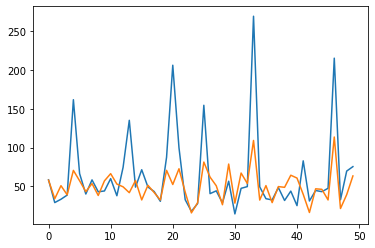

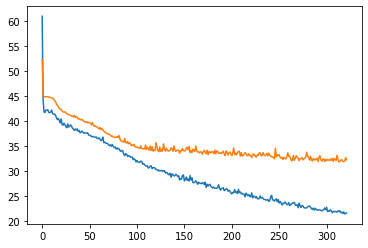

In [179]:
# Visualising Performance
start = 50
stop = start + 50



plt.figure()
plt.plot(testy[start:stop])
plt.plot(y_predict_LSTM[start:stop])



plt.figure()
plt.plot(np.sqrt(mLSTM_hist.history['loss']))
plt.plot(np.sqrt(mLSTM_hist.history['val_loss']))